
**Install requirements**

In [ ]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 634kB 6.9MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110350 sha256=09da35ab39ee6e87e5c94fe431fcfee3b818dba9fada1d6b15f11f76690fc1f7
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
try:
  import tensorboardX
except:
  !pip3 install tensorboardX
  import tensorboardX

import numpy as np

import matplotlib.pyplot as plt
import matplotlib

     |████████████████████████████████| 204kB 6.9MB/s 


**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

#NUM_CLASSES = 7 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
ALPHA = 0.1         # Parameter multiplied by backpropagation of the reversed layer

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

NUM_DOMAINS = 2

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                                    
])

**Prepare Dataset**

dict_keys([0, 1, 2, 3, 4, 5, 6])


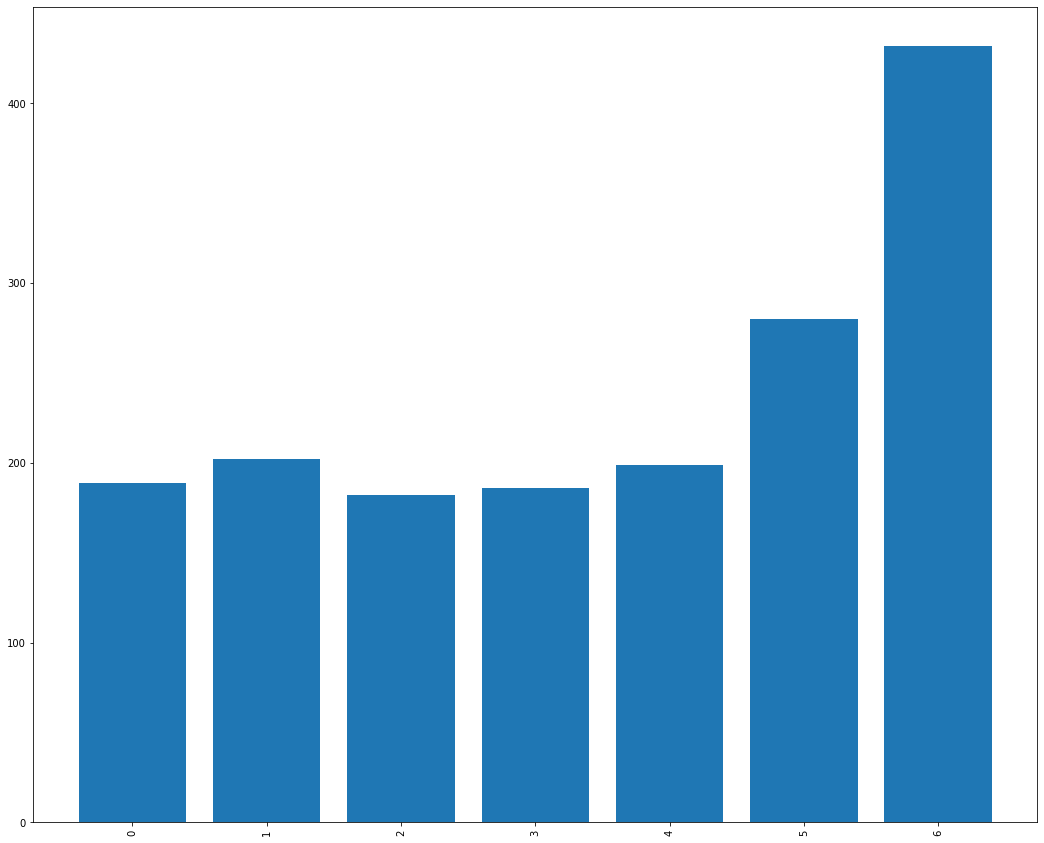

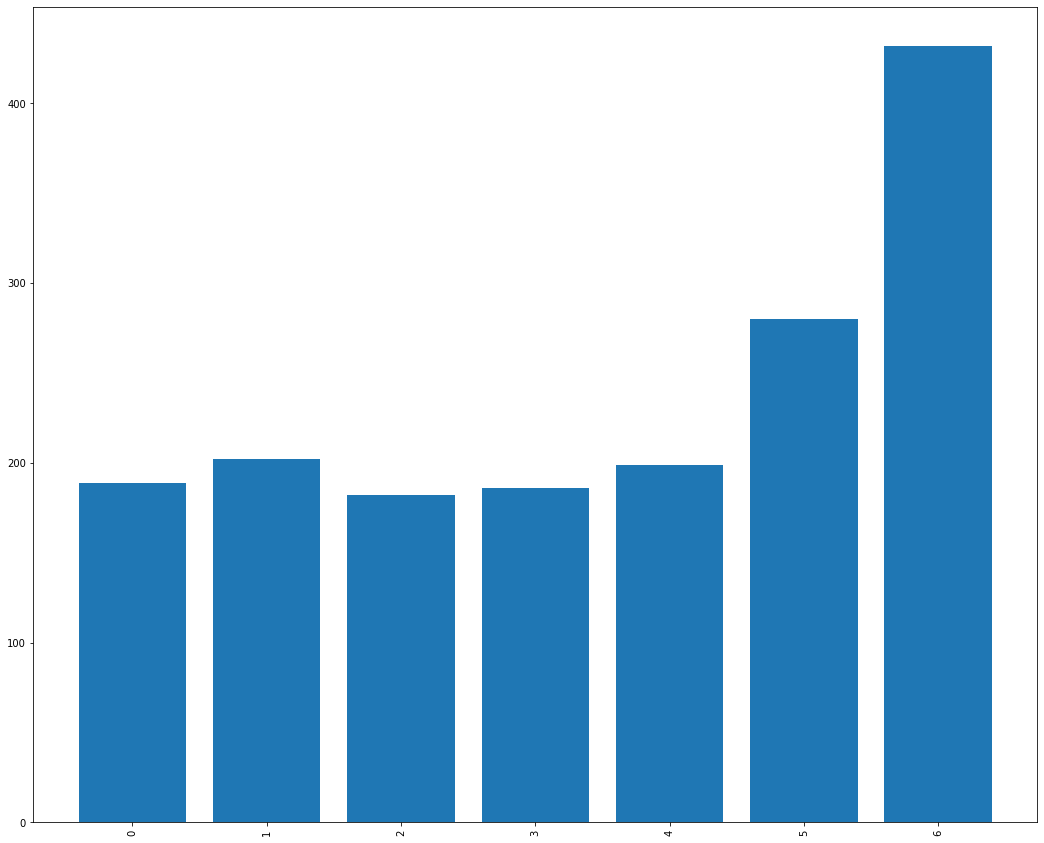

Source Dataset: 1670
Target Dataset: 2048


In [ ]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

DATA_DIR = 'Homework3-PACS/PACS'

# Prepare Pytorch train/test Datasets
src_dataset = torchvision.datasets.ImageFolder(DATA_DIR+"/photo", transform=train_transform)
src_distribution = {}
for img,label in src_dataset:
  src_distribution[label] = src_distribution.get(label,0) + 1
print(src_distribution.keys())
NUM_CLASSES = len(src_distribution.keys())
plt.figure(figsize=(18, 15))
plt.bar(src_distribution.keys(),src_distribution.values(),)
plt.xticks(rotation='vertical')
plt.show()

target_dataset = torchvision.datasets.ImageFolder(DATA_DIR+"/art_painting", transform=eval_transform)
target_distribution = {}
for img,label in src_dataset:
  target_distribution[label] = target_distribution.get(label,0) + 1
plt.figure(figsize=(18, 15))
plt.bar(target_distribution.keys(),target_distribution.values(),)
plt.xticks(rotation='vertical')
plt.show()
#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Source Dataset: {}'.format(len(src_dataset)))
print('Target Dataset: {}'.format(len(target_dataset)))

In [ ]:
src_dataset.__getitem__(7)

(tensor([[[ 0.9817, -1.3644,  1.4098,  ..., -1.4329, -1.4672, -1.5528],
          [-0.7650, -1.4843, -0.6965,  ..., -1.3815, -1.3130, -1.5185],
          [-1.2445, -1.1932, -1.0219,  ..., -1.6213, -1.4500, -1.5014],
          ...,
          [-0.4397, -0.6109,  0.3138,  ..., -0.7822, -0.7308, -0.6794],
          [-0.3541, -0.0629,  0.1939,  ..., -0.7993, -0.7650, -0.6965],
          [-0.1828,  0.4851,  0.1597,  ..., -0.8164, -0.8849, -0.7308]],
 
         [[ 1.1681, -1.2304,  1.6057,  ..., -1.1604, -1.1779, -1.2654],
          [-0.6352, -1.3880, -0.5476,  ..., -1.1078, -1.0203, -1.2304],
          [-1.0553, -1.0028, -0.8627,  ..., -1.4055, -1.2479, -1.3179],
          ...,
          [-0.7227, -0.8978,  0.2052,  ..., -0.8978, -0.8452, -0.7402],
          [-0.6527, -0.3550,  0.0826,  ..., -0.9153, -0.8803, -0.7927],
          [-0.4776,  0.2227, -0.0049,  ..., -0.9328, -1.0028, -0.8452]],
 
         [[ 1.3328, -1.0550,  1.7511,  ..., -1.0898, -1.1944, -1.3164],
          [-0.4624, -1.1944,

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
src_dataloader = DataLoader(src_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


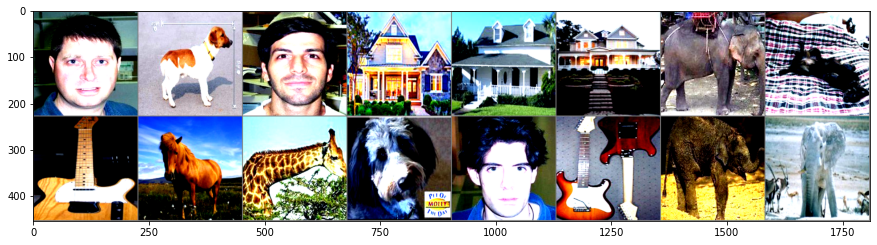

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


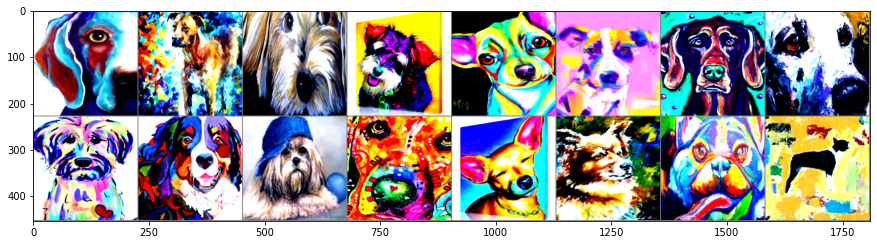

In [ ]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# get some random training images
dataiter = iter(src_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16]))


# get some random training images
dataiter = iter(target_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16]))

**Prepare Network**

**Prepare Training**

**Train (no DANN)**

In [ ]:
# By default, everything is loaded to cpu

def train(net,train_dataloader,val_dataloader,checkpoint_path):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  n_epochs_stop = 8
  min_val_loss = float('inf')
  epochs_no_improve = 0
  cudnn.benchmark # Calling this optimizes runtime
  train_loss , train_accuracy = [], []
  val_loss , val_accuracy = [], []

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    val_running_loss = 0.0
    val_running_correct = 0
    train_running_loss = 0.0
    train_running_correct = 0
    train_NUM_BATCHES = 0
    val_NUM_BATCHES = 0
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    net.train(True)
    # Iterate over the dataset
    for images, labels in train_dataloader:  ##---------------------------------  TRAINING
      train_NUM_BATCHES += 1
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      train_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      train_running_correct += torch.sum(preds == labels.data).data.item()
      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      

      current_step += 1


    net.train(False) # Set Network to evaluation mode
    for val_images, val_labels in tqdm(val_dataloader): ##----------------------  VALIDATION
      val_NUM_BATCHES += 1
      val_images = val_images.to(DEVICE)
      val_labels = val_labels.to(DEVICE)

      # Forward Pass
      outputs = net(val_images)
      loss = criterion(outputs, val_labels)
      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      val_running_correct += torch.sum(preds == val_labels.data).data.item()

      val_running_loss += loss.item()

    print()
    epoch_train_loss = train_running_loss/train_NUM_BATCHES
    epoch_train_accuracy = train_running_correct/float(len(src_dataset))
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}")
    epoch_val_loss = val_running_loss/val_NUM_BATCHES
    epoch_val_accuracy = val_running_correct / float(len(target_dataset))
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}')
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)
    # Step the scheduler
    scheduler.step() 
    print()
    print()


    # If the validation loss is at a minimum
    if epoch_val_loss < min_val_loss:
      # Save the model
      torch.save(net, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = epoch_val_loss

  net = torch.load(checkpoint_path)
  return train_loss,train_accuracy,val_loss,val_accuracy,net
  
def print_acc_loss(train_loss,train_accuracy,val_loss,val_accuracy,title, label1 = 'train accuracy', label2 = 'validation accuracy', label3 = 'train loss',label4= 'validation loss'):
  print(list(zip(train_loss,train_accuracy)),list(zip(val_loss,val_accuracy)))
  # accuracy plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label=label1)
  plt.plot(val_accuracy, color='blue', label=label2)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(title+'_accuracy.png')
  plt.show()

  # loss plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_loss, color='orange', label=label3)
  plt.plot(val_loss, color='red', label=label4)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(title+'_loss.png')
  plt.show()


def print_DANN_acc_loss(total_loss,total_accuracy,domain_loss,domain_acc,train_loss,train_accuracy,train_domain_loss,train_domain_accuracy,target_domain_loss,target_domain_accuracy,val_loss,val_acc,title):
  # accuracy plots
  plt.figure(figsize=(10, 7))
  plt.plot(total_accuracy, color='green', label='total train accuracy')
  plt.plot(domain_acc, color='gray', label='total domain accuracy')
  plt.plot(train_accuracy, color='blue', label='source class accuracy')
  plt.plot(train_domain_accuracy, color='orange', label='source domain accuracy')
  plt.plot(target_domain_accuracy, color='red', label='target domain accuracy')
  #plt.plot(val_accuracy, color = 'purple', label='target val accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(title+'_train_accuracies.png')
  plt.show()

  # loss plots
  plt.figure(figsize=(10, 7))
  plt.plot(total_loss, color='green', label='Avg train loss')
  plt.plot(domain_loss, color='gray', label='Avg domain loss')
  plt.plot(train_loss, color='blue', label='source class loss')
  plt.plot(train_domain_loss, color='orange', label='source domain loss')
  plt.plot(target_domain_loss, color='red', label='target domain loss')
  #plt.plot(val_loss, color = 'purple', label='target val loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(title+'_train_loss.png')
  plt.show()



def test(net, test_dataloader):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(target_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  return accuracy



In [ ]:
# Define loss function
net = alexnet(pretrained = True)#,num_domains = 2) # Loading AlexNet model
net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
domain_criterion = nn.CrossEntropyLoss()
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

57,032,519 total parameters.
57,032,519 training parameters.
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 1.8393406867980957


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Train Loss: 0.6536, Train Acc: 0.70
Val Loss: 1.7455, Val Acc: 0.47


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.12453660368919373


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 0.1218, Train Acc: 0.88
Val Loss: 2.4946, Val Acc: 0.48


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 0.0824, Train Acc: 0.89
Val Loss: 3.0117, Val Acc: 0.46


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.039610620588064194


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0638, Train Acc: 0.90
Val Loss: 3.1090, Val Acc: 0.46


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: 0.0315, Train Acc: 0.91
Val Loss: 2.9883, Val Acc: 0.49


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.018444927409291267


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0209, Train Acc: 0.91
Val Loss: 3.0525, Val Acc: 0.49


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.011555789038538933


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0137, Train Acc: 0.92
Val Loss: 3.0708, Val Acc: 0.49


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0160, Train Acc: 0.91
Val Loss: 3.0472, Val Acc: 0.49


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.005825551226735115


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0068, Train Acc: 0.92
Val Loss: 3.0209, Val Acc: 0.50


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0088, Train Acc: 0.92
Val Loss: 2.9792, Val Acc: 0.50


Starting epoch 11/30, LR = [0.001]


Step 60, Loss 0.009628880769014359


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0076, Train Acc: 0.92
Val Loss: 2.9832, Val Acc: 0.50


Starting epoch 12/30, LR = [0.001]


Step 70, Loss 0.018745770677924156


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Train Loss: 0.0078, Train Acc: 0.92
Val Loss: 2.9866, Val Acc: 0.50


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.0070, Train Acc: 0.92
Val Loss: 2.9862, Val Acc: 0.50


Starting epoch 14/30, LR = [0.001]


Step 80, Loss 0.007749980315566063


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0085, Train Acc: 0.92
Val Loss: 2.9936, Val Acc: 0.50


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0102, Train Acc: 0.92
Val Loss: 3.0037, Val Acc: 0.50


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 0.004012342542409897


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0098, Train Acc: 0.92
Val Loss: 3.0166, Val Acc: 0.50


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 0.0024004466831684113


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0069, Train Acc: 0.92
Val Loss: 3.0273, Val Acc: 0.50


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0055, Train Acc: 0.92
Val Loss: 3.0363, Val Acc: 0.50


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 0.007004577666521072


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Train Loss: 0.0053, Train Acc: 0.92
Val Loss: 3.0412, Val Acc: 0.50


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Train Loss: 0.0057, Train Acc: 0.92
Val Loss: 3.0437, Val Acc: 0.50


Starting epoch 21/30, LR = [0.0001]


Step 120, Loss 0.0024128705263137817


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.0060, Train Acc: 0.92
Val Loss: 3.0440, Val Acc: 0.50


Starting epoch 22/30, LR = [0.0001]


Step 130, Loss 0.0098286597058177


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0060, Train Acc: 0.92
Val Loss: 3.0442, Val Acc: 0.50


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0060, Train Acc: 0.92
Val Loss: 3.0442, Val Acc: 0.50


Starting epoch 24/30, LR = [0.0001]


Step 140, Loss 0.00458298996090889


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0053, Train Acc: 0.92
Val Loss: 3.0442, Val Acc: 0.50


Starting epoch 25/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.0441, Val Acc: 0.50


Starting epoch 26/30, LR = [0.0001]


Step 150, Loss 0.001890638843178749


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.0441, Val Acc: 0.50


Starting epoch 27/30, LR = [0.0001]


Step 160, Loss 0.004776943475008011


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.0440, Val Acc: 0.50


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Train Loss: 0.0036, Train Acc: 0.92
Val Loss: 3.0439, Val Acc: 0.50


Starting epoch 29/30, LR = [0.0001]


Step 170, Loss 0.003986308351159096


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 0.0066, Train Acc: 0.92
Val Loss: 3.0438, Val Acc: 0.50


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Train Loss: 0.0062, Train Acc: 0.92
Val Loss: 3.0437, Val Acc: 0.50


[(0.6536093801259995, 0.7035928143712575), (0.12180110812187195, 0.8838323353293414), (0.08243180190523465, 0.8928143712574851), (0.06383405874172847, 0.9041916167664671), (0.031508003982404865, 0.9107784431137724), (0.020905773776272934, 0.9137724550898204), (0.013718780130147934, 0.9167664670658683), (0.016030834677318733, 0.9149700598802395), (0.0067551944715281325, 0.918562874251497), (0.00881901616230607, 0.918562874251497), (0.007576429595549901, 0.918562874251497), (0.007780691608786583, 0.9191616766467066), (0.0070364465937018394, 0.9179640718562875), (0.008544149808585644, 0.918562874251497), (0.01024851001178225, 0.9155688622754491), (0.009764941719671091, 0.9173652694610779), (0.006903733126819134, 0.9197604790419162), (0.005502650203804175, 0.918562874251497), (0.005267092026770115, 0.9191616766467066), (0.005718750258286794, 0.9191616766467066), (0.005971057650943597, 0.9191616766467066), (0.00599075341

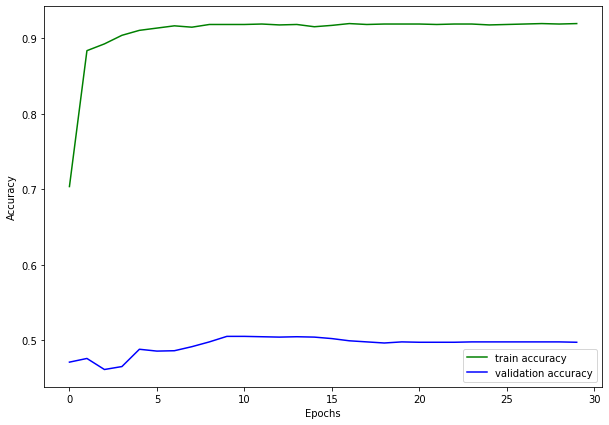

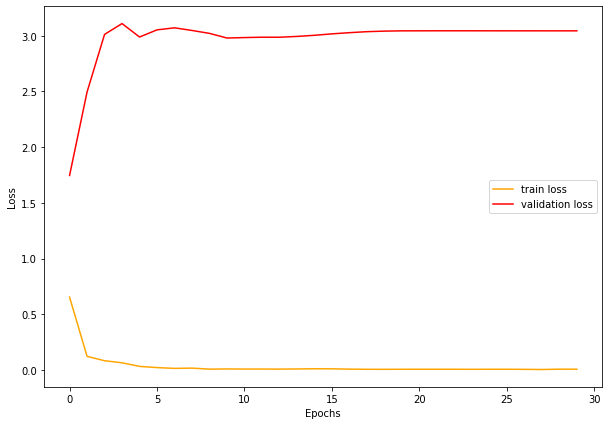

100%|██████████| 8/8 [00:08<00:00,  1.02s/it]

Test Accuracy: 0.470703125


In [ ]:
#net = alexnet(pretrained = True,num_classes = NUM_CLASSES)#,num_domains = 2) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="./alexnet_noDANN_pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained")
test(net,target_dataloader)

*TRAIN DANN*

In [ ]:
import torch.nn as nn
from torch.autograd import Function
from torch import hub

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
      
        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(x, alpha)
            x = self.domain_classifier(x)
            return x
        # If we don't pass alpha, we assume we are training with supervision
        else:
            # do something else
            x = self.classifier(x)
            return x

    def assign_wb(self):

        self.domain_classifier[1].weight.data.copy_(self.classifier[1].weight.data)
        self.domain_classifier[1].bias.data.copy_(self.classifier[1].bias.data)
        self.domain_classifier[4].weight.data.copy_(self.classifier[4].weight.data)
        self.domain_classifier[4].bias.data.copy_(self.classifier[4].bias.data)
        self.domain_classifier[6].weight.data.copy_(self.classifier[6].weight.data)
        self.domain_classifier[6].bias.data.copy_(self.classifier[6].bias.data)


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = hub.load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict,strict = False)
        model.assign_wb()
    return model

In [ ]:
def train_dann(net,src_dataloader,target_dataloader,checkpoint_path,ALPHA=0.1):
  checkpoint_path = '/content/drive/My Drive'+checkpoint_path[1:]
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda 
  n_epochs_stop = 5
  min_val_loss = np.Inf
  epochs_no_improve = 0
  cudnn.benchmark # Calling this optimizes runtime
  train_loss , train_accuracy , train_src_domain_loss, train_src_domain_accuracy, train_target_domain_loss, train_target_domain_accuracy = [], [], [], [], [], []
  train_domain_loss, train_domain_accuracy,train_total_loss, train_total_accuracy = [], [], [], []
  val_loss , val_accuracy = [], []

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    val_running_loss = 0.0
    val_running_correct = 0
    train_running_loss = 0.0
    train_running_correct = 0
    train_running_src_domain_loss = 0.0
    train_running_src_domain_correct = 0
    train_running_target_domain_loss = 0.0
    train_running_target_domain_correct = 0
    train_running_total_loss = 0.0
    train_running_total_correct = 0

    train_NUM_BATCHES = 0
    val_NUM_BATCHES = 0
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    net.train(True)
    len_dataloader = max(len(src_dataloader), len(target_dataloader))
    data_source_iter = iter(src_dataloader)
    data_target_iter = iter(target_dataloader)
    # Iterate over the dataset
    
    for i in range(len_dataloader): ##------------------------------------------------  TRAINING
      
      #p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
      #alpha = 2. / (1. + np.exp(-10 * p)) - 1
      # training model using source data

      # loss += criterion

      try:
        data_source = data_source_iter.next()
        src_images, src_labels = data_source
      except StopIteration:
        data_source_iter = iter(src_dataloader)
        src_images, src_labels = next(data_source_iter)
      #i += BATCH_SIZE
      
      # Bring data over the device of choice
      src_images = src_images.to(DEVICE)
      src_labels = src_labels.to(DEVICE)
      domain_src_labels = torch.zeros(BATCH_SIZE,dtype=torch.int64).to(DEVICE)
      train_NUM_BATCHES += 1
      
      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(src_images)

      # Compute loss based on output and ground truth (of class)----------------    class classification
      loss = criterion(outputs, src_labels)

      train_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      train_running_correct += torch.sum(preds == src_labels.data).data.item()
      

      # Compute gradients for each layer and update weights
      #loss.backward()  # backward pass: computes gradients
      # end of train label classification
      
      # domain classification src-----------------------------------------------    source domain classification
      domain_src_outputs = net(src_images,alpha = ALPHA)
      domain_src_loss = domain_criterion(domain_src_outputs, domain_src_labels)
      train_running_src_domain_loss += domain_src_loss.item()
      _, dom_src_preds = torch.max(domain_src_outputs.data, 1)
      train_running_src_domain_correct += torch.sum(dom_src_preds == domain_src_labels.data).data.item()
      #domain_src_loss.backward()

      # domain classification target--------------------------------------------    target domain classification
      try:
        data_target = data_target_iter.next()
        target_images, target_labels = data_target
      except StopIteration:
        data_target_iter = iter(target_dataloader)
        target_images, target_labels = next(data_target_iter)
      
      target_images = target_images.to(DEVICE)
      domain_target_labels = torch.ones(BATCH_SIZE,dtype=torch.int64).to(DEVICE)
      domain_target_outputs = net(target_images,alpha = ALPHA)
      domain_target_loss = domain_criterion(domain_target_outputs, domain_target_labels)
      train_running_target_domain_loss += domain_target_loss.item()
      _, dom_target_preds = torch.max(domain_target_outputs.data, 1)
      train_running_target_domain_correct += torch.sum(dom_target_preds == domain_target_labels.data).data.item()
      #domain_target_loss.backward()
      #-------------------------------------------------------------------------    Loss calculus and log
      total_loss = loss + domain_src_loss + domain_target_loss
      total_loss.backward()

      train_running_total_loss += total_loss.item()
      #tot_correct = train_running_correct + train_running_src_domain_correct + train_running_target_domain_correct
      #train_running_total_correct += tot_correct

      optimizer.step()
      current_step += 1
      # Log loss
      #if current_step % LOG_FREQUENCY == 0:
      #  print('ALPHA {}, Step {}, Total Loss {}'.format(ALPHA, current_step, total_loss.item()))
      #  print(f'Source class loss {loss}, Source domain loss {domain_src_loss}, Target domain loss{domain_target_loss}');

    net.train(False) # Set Network to evaluation mode
    for val_images, val_labels in tqdm(target_dataloader): ##----------------------  VALIDATION
      val_NUM_BATCHES += 1
      val_images = val_images.to(DEVICE)
      val_labels = val_labels.to(DEVICE)

      # Forward Pass
      outputs = net(val_images)
      domain_outputs = net(val_images,ALPHA)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      val_running_correct += torch.sum(preds == val_labels.data).data.item()

      val_running_loss += loss.item()
    print()
    epoch_train_loss = train_running_loss/float(train_NUM_BATCHES)
    epoch_train_accuracy = train_running_correct/float(len(target_dataset))
    print(f"Source class Loss: {epoch_train_loss:.4f}, Train class Acc: {epoch_train_accuracy:.2f}")
    epoch_val_loss = val_running_loss/float(val_NUM_BATCHES)
    epoch_val_accuracy = val_running_correct / float(len(target_dataset))
    print(f'Target class Loss: {epoch_val_loss:.4f}, Val class Acc: {epoch_val_accuracy:.2f}')
    epoch_train_domain_loss = train_running_src_domain_loss/float(train_NUM_BATCHES)
    epoch_train_domain_accuracy = train_running_src_domain_correct/float(len(target_dataset))
    print(f"Source domain Loss: {epoch_train_domain_loss:.4f}, Source domain Acc: {epoch_train_domain_accuracy:.2f}")
    epoch_target_domain_loss = train_running_target_domain_loss/float(train_NUM_BATCHES)
    epoch_target_domain_accuracy = train_running_target_domain_correct/float(len(target_dataset))
    print(f"Target domain Loss: {epoch_target_domain_loss:.4f}, Target domain Acc: {epoch_target_domain_accuracy:.2f}")
    epoch_train_total_loss = train_running_total_loss/float((train_NUM_BATCHES*3))
    epoch_train_total_accuracy = (train_running_correct + train_running_src_domain_correct + train_running_target_domain_correct)/float(len(target_dataset)*3)
    print(f"Total train Loss: {epoch_train_total_loss:.4f}, Total train Acc: {epoch_train_total_accuracy:.2f}")
    epoch_train_tot_domain_loss = (train_running_src_domain_loss + train_running_target_domain_loss)/float(train_NUM_BATCHES*2)
    epoch_train_tot_domain_accuracy = (train_running_src_domain_correct + train_running_target_domain_correct)/float(len(target_dataset)*2)
    print(f"Total domain Loss: {epoch_train_tot_domain_loss:.4f}, Total domain Acc: {epoch_train_tot_domain_accuracy:.2f}")
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)
    train_src_domain_loss.append(epoch_train_domain_loss) 
    train_src_domain_accuracy.append(epoch_train_domain_accuracy) 
    train_target_domain_loss.append(epoch_target_domain_loss) 
    train_target_domain_accuracy.append(epoch_target_domain_accuracy)
    train_total_loss.append(epoch_train_total_loss)
    train_total_accuracy.append(epoch_train_total_accuracy)
    train_domain_loss.append(epoch_train_tot_domain_loss)
    train_domain_accuracy.append(epoch_train_tot_domain_accuracy)
    # Step the scheduler
    scheduler.step() 
    print()
    print()


    # If the validation loss is at a minimum
    if epoch_val_loss < min_val_loss:
      # Save the model
      torch.save(net, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = epoch_val_loss
      
  net = torch.load(checkpoint_path)
  return train_total_loss,train_total_accuracy,train_domain_loss,train_domain_accuracy,train_loss,train_accuracy,train_src_domain_loss, train_src_domain_accuracy, train_target_domain_loss, train_target_domain_accuracy,val_loss,val_accuracy,net
  

In [ ]:
BATCH_SIZE = 256
src_dataloader = DataLoader(src_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
net = alexnet(pretrained=True) # Loading AlexNet model
#net.classifier[1].weight.data 
#model.classifier[1].bias.data
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
domain_criterion = nn.CrossEntropyLoss()
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 


parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code
totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN",ALPHA=ALPHA)


Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Source class Loss: 0.7145, Train class Acc: 0.75
Target class Loss: 0.6600, Val class Acc: 0.34
Source domain Loss: 0.6545, Source domain Acc: 0.77
Target domain Loss: 0.5501, Target domain Acc: 0.82
Total train Loss: 0.6397, Total train Acc: 0.78
Total domain Loss: 0.6023, Total domain Acc: 0.79


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.5086, Train class Acc: 0.83
Target class Loss: 0.4500, Val class Acc: 0.31
Source domain Loss: 0.3128, Source domain Acc: 0.88
Target domain Loss: 0.3782, Target domain Acc: 0.83
Total train Loss: 0.3999, Total train Acc: 0.85
Total domain Loss: 0.3455, Total domain Acc: 0.85


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.4202, Train class Acc: 0.85
Target class Loss: 0.3315, Val class Acc: 0.32
Source domain Loss: 0.2792, Source domain Acc: 0.90
Target domain Loss: 0.4097, Target domain Acc: 0.82
Total train Loss: 0.3697, Total train Acc: 0.86
Total domain Loss: 0.3444, Total domain Acc: 0.86


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.3526, Train class Acc: 0.87
Target class Loss: 0.3319, Val class Acc: 0.32
Source domain Loss: 0.2930, Source domain Acc: 0.88
Target domain Loss: 0.2011, Target domain Acc: 0.92
Total train Loss: 0.2823, Total train Acc: 0.89
Total domain Loss: 0.2471, Total domain Acc: 0.90


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.2202, Train class Acc: 0.92
Target class Loss: 0.1907, Val class Acc: 0.36
Source domain Loss: 0.1832, Source domain Acc: 0.93
Target domain Loss: 0.1827, Target domain Acc: 0.92
Total train Loss: 0.1954, Total train Acc: 0.92
Total domain Loss: 0.1829, Total domain Acc: 0.92


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.1620, Train class Acc: 0.94
Target class Loss: 0.1571, Val class Acc: 0.34
Source domain Loss: 0.1388, Source domain Acc: 0.95
Target domain Loss: 0.1357, Target domain Acc: 0.94
Total train Loss: 0.1455, Total train Acc: 0.94
Total domain Loss: 0.1373, Total domain Acc: 0.94


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0976, Train class Acc: 0.96
Target class Loss: 0.0271, Val class Acc: 0.33
Source domain Loss: 0.0798, Source domain Acc: 0.97
Target domain Loss: 0.0792, Target domain Acc: 0.97
Total train Loss: 0.0855, Total train Acc: 0.97
Total domain Loss: 0.0795, Total domain Acc: 0.97


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0482, Train class Acc: 0.98
Target class Loss: 0.0285, Val class Acc: 0.37
Source domain Loss: 0.0701, Source domain Acc: 0.97
Target domain Loss: 0.0585, Target domain Acc: 0.98
Total train Loss: 0.0589, Total train Acc: 0.98
Total domain Loss: 0.0643, Total domain Acc: 0.97


Starting epoch 9/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0293, Train class Acc: 0.99
Target class Loss: 0.0207, Val class Acc: 0.32
Source domain Loss: 0.0294, Source domain Acc: 0.99
Target domain Loss: 0.0410, Target domain Acc: 0.99
Total train Loss: 0.0332, Total train Acc: 0.99
Total domain Loss: 0.0352, Total domain Acc: 0.99


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0172, Train class Acc: 1.00
Target class Loss: 0.0100, Val class Acc: 0.35
Source domain Loss: 0.0296, Source domain Acc: 0.99
Target domain Loss: 0.0331, Target domain Acc: 0.99
Total train Loss: 0.0266, Total train Acc: 0.99
Total domain Loss: 0.0313, Total domain Acc: 0.99


Starting epoch 11/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0124, Train class Acc: 1.00
Target class Loss: 0.0152, Val class Acc: 0.38
Source domain Loss: 0.0434, Source domain Acc: 0.98
Target domain Loss: 0.0064, Target domain Acc: 1.00
Total train Loss: 0.0207, Total train Acc: 0.99
Total domain Loss: 0.0249, Total domain Acc: 0.99


Starting epoch 12/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0106, Train class Acc: 1.00
Target class Loss: 0.0104, Val class Acc: 0.39
Source domain Loss: 0.0075, Source domain Acc: 1.00
Target domain Loss: 0.0204, Target domain Acc: 0.99
Total train Loss: 0.0128, Total train Acc: 1.00
Total domain Loss: 0.0139, Total domain Acc: 1.00


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0071, Train class Acc: 1.00
Target class Loss: 0.0091, Val class Acc: 0.39
Source domain Loss: 0.0079, Source domain Acc: 1.00
Target domain Loss: 0.0188, Target domain Acc: 0.99
Total train Loss: 0.0112, Total train Acc: 1.00
Total domain Loss: 0.0133, Total domain Acc: 1.00


Starting epoch 14/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0063, Train class Acc: 1.00
Target class Loss: 0.0054, Val class Acc: 0.38
Source domain Loss: 0.0090, Source domain Acc: 1.00
Target domain Loss: 0.0067, Target domain Acc: 1.00
Total train Loss: 0.0073, Total train Acc: 1.00
Total domain Loss: 0.0078, Total domain Acc: 1.00


Starting epoch 15/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0069, Train class Acc: 1.00
Target class Loss: 0.0058, Val class Acc: 0.38
Source domain Loss: 0.0108, Source domain Acc: 1.00
Target domain Loss: 0.0052, Target domain Acc: 1.00
Total train Loss: 0.0076, Total train Acc: 1.00
Total domain Loss: 0.0080, Total domain Acc: 1.00


Starting epoch 16/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0073, Train class Acc: 1.00
Target class Loss: 0.0070, Val class Acc: 0.39
Source domain Loss: 0.0077, Source domain Acc: 1.00
Target domain Loss: 0.0080, Target domain Acc: 1.00
Total train Loss: 0.0077, Total train Acc: 1.00
Total domain Loss: 0.0079, Total domain Acc: 1.00


Starting epoch 17/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.39
Source domain Loss: 0.0067, Source domain Acc: 1.00
Target domain Loss: 0.0072, Target domain Acc: 1.00
Total train Loss: 0.0063, Total train Acc: 1.00
Total domain Loss: 0.0069, Total domain Acc: 1.00


Starting epoch 18/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0073, Val class Acc: 0.38
Source domain Loss: 0.0055, Source domain Acc: 1.00
Target domain Loss: 0.0057, Target domain Acc: 1.00
Total train Loss: 0.0053, Total train Acc: 1.00
Total domain Loss: 0.0056, Total domain Acc: 1.00


Starting epoch 19/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0054, Val class Acc: 0.38
Source domain Loss: 0.0057, Source domain Acc: 1.00
Target domain Loss: 0.0057, Target domain Acc: 1.00
Total train Loss: 0.0052, Total train Acc: 1.00
Total domain Loss: 0.0057, Total domain Acc: 1.00


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0049, Train class Acc: 1.00
Target class Loss: 0.0035, Val class Acc: 0.38
Source domain Loss: 0.0058, Source domain Acc: 1.00
Target domain Loss: 0.0062, Target domain Acc: 1.00
Total train Loss: 0.0056, Total train Acc: 1.00
Total domain Loss: 0.0060, Total domain Acc: 1.00


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.38
Source domain Loss: 0.0049, Source domain Acc: 1.00
Target domain Loss: 0.0056, Target domain Acc: 1.00
Total train Loss: 0.0049, Total train Acc: 1.00
Total domain Loss: 0.0053, Total domain Acc: 1.00


Starting epoch 22/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.38
Source domain Loss: 0.0066, Source domain Acc: 1.00
Target domain Loss: 0.0051, Target domain Acc: 1.00
Total train Loss: 0.0052, Total train Acc: 1.00
Total domain Loss: 0.0059, Total domain Acc: 1.00


Starting epoch 23/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0054, Val class Acc: 0.38
Source domain Loss: 0.0075, Source domain Acc: 1.00
Target domain Loss: 0.0058, Target domain Acc: 1.00
Total train Loss: 0.0059, Total train Acc: 1.00
Total domain Loss: 0.0067, Total domain Acc: 1.00


Starting epoch 24/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0042, Val class Acc: 0.38
Source domain Loss: 0.0061, Source domain Acc: 1.00
Target domain Loss: 0.0063, Target domain Acc: 1.00
Total train Loss: 0.0054, Total train Acc: 1.00
Total domain Loss: 0.0062, Total domain Acc: 1.00


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.38
Source domain Loss: 0.0045, Source domain Acc: 1.00
Target domain Loss: 0.0053, Target domain Acc: 1.00
Total train Loss: 0.0047, Total train Acc: 1.00
Total domain Loss: 0.0049, Total domain Acc: 1.00


Starting epoch 26/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0027, Val class Acc: 0.38
Source domain Loss: 0.0055, Source domain Acc: 1.00
Target domain Loss: 0.0061, Target domain Acc: 1.00
Total train Loss: 0.0053, Total train Acc: 1.00
Total domain Loss: 0.0058, Total domain Acc: 1.00


Starting epoch 27/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0039, Val class Acc: 0.38
Source domain Loss: 0.0057, Source domain Acc: 1.00
Target domain Loss: 0.0053, Target domain Acc: 1.00
Total train Loss: 0.0052, Total train Acc: 1.00
Total domain Loss: 0.0055, Total domain Acc: 1.00


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0050, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.38
Source domain Loss: 0.0058, Source domain Acc: 1.00
Target domain Loss: 0.0046, Target domain Acc: 1.00
Total train Loss: 0.0051, Total train Acc: 1.00
Total domain Loss: 0.0052, Total domain Acc: 1.00


Starting epoch 29/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0060, Val class Acc: 0.38
Source domain Loss: 0.0044, Source domain Acc: 1.00
Target domain Loss: 0.0058, Target domain Acc: 1.00
Total train Loss: 0.0053, Total train Acc: 1.00
Total domain Loss: 0.0051, Total domain Acc: 1.00


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0056, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.38
Source domain Loss: 0.0044, Source domain Acc: 1.00
Target domain Loss: 0.0056, Target domain Acc: 1.00
Total train Loss: 0.0052, Total train Acc: 1.00
Total domain Loss: 0.0050, Total domain Acc: 1.00




8

[(0.7145001441240311, 0.74755859375), (0.5085554383695126, 0.830078125), (0.4202008917927742, 0.85498046875), (0.3526456989347935, 0.869140625), (0.22020406648516655, 0.92138671875), (0.1619790680706501, 0.94189453125), (0.09756592172197998, 0.9638671875), (0.04823420150205493, 0.98291015625), (0.029275340028107166, 0.99072265625), (0.01719704654533416, 0.99755859375), (0.012374432408250868, 0.99755859375), (0.010614443570375443, 0.998046875), (0.007070270134136081, 0.9990234375), (0.006328545277938247, 1.0), (0.006863436661660671, 0.9990234375), (0.007292751804925501, 1.0), (0.005065621575340629, 1.0), (0.004714143229648471, 1.0), (0.0042760089272633195, 1.0), (0.004860742716118693, 0.99951171875), (0.0042332555167376995, 0.9990234375), (0.0037992631550878286, 0.99951171875), (0.004413188900798559, 0.99951171875), (0.003802865045145154, 0.99951171875), (0.004306694725528359, 1.0), (0.004292253754101694, 0.99951171875), (0.004697746131569147, 0.9990234375), (0.004975627642124891, 0.999

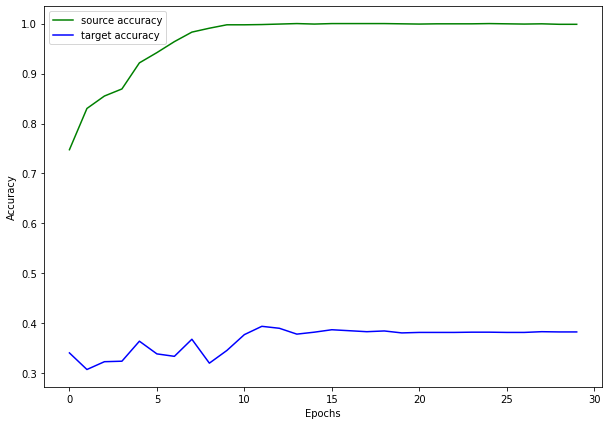

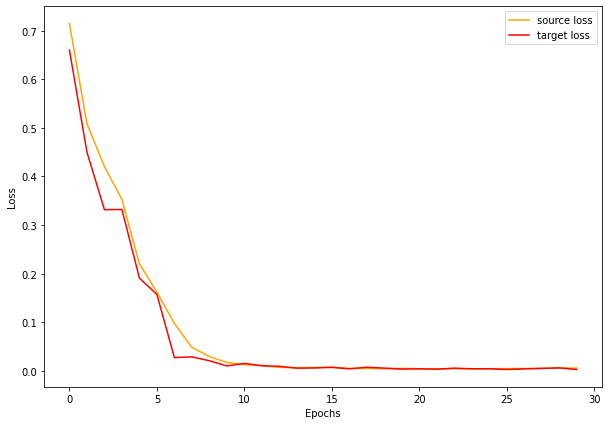

[(0.654452171176672, 0.765625), (0.31284968834370375, 0.87744140625), (0.27922674594447017, 0.8955078125), (0.2929737363010645, 0.880859375), (0.18317141197621822, 0.9287109375), (0.13884188747033477, 0.94580078125), (0.07984075509011745, 0.97265625), (0.07010377489496022, 0.96875), (0.029377020779065788, 0.99072265625), (0.029595070926006883, 0.98876953125), (0.04340983449947089, 0.98388671875), (0.007452546939020976, 0.998046875), (0.0078666225890629, 0.99853515625), (0.008952828822657466, 1.0), (0.010760991950519383, 0.99853515625), (0.007728444703388959, 0.998046875), (0.006651288946159184, 0.9990234375), (0.005547435866901651, 0.99951171875), (0.005668466503266245, 0.99951171875), (0.005759360385127366, 0.99951171875), (0.004943395790178329, 0.99951171875), (0.006648965150816366, 0.99951171875), (0.007539088488556445, 0.99853515625), (0.006127262313384563, 0.9990234375), (0.004487976955715567, 1.0), (0.005455335369333625, 1.0), (0.00568058923818171, 0.99951171875), (0.005750855780

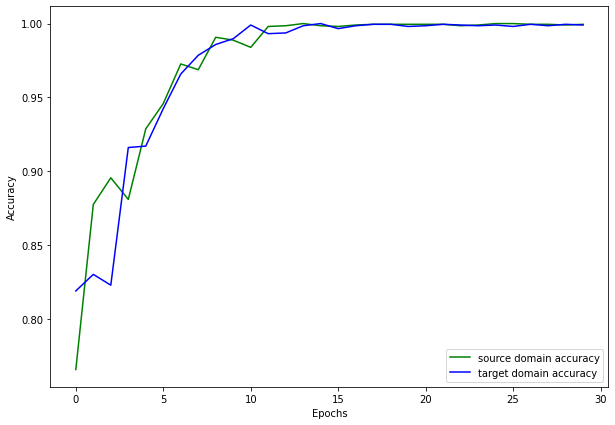

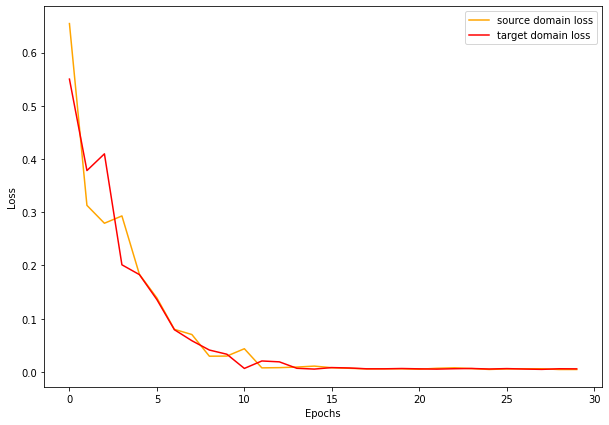

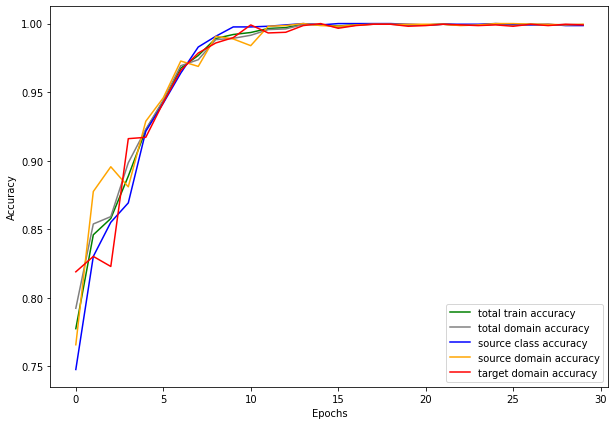

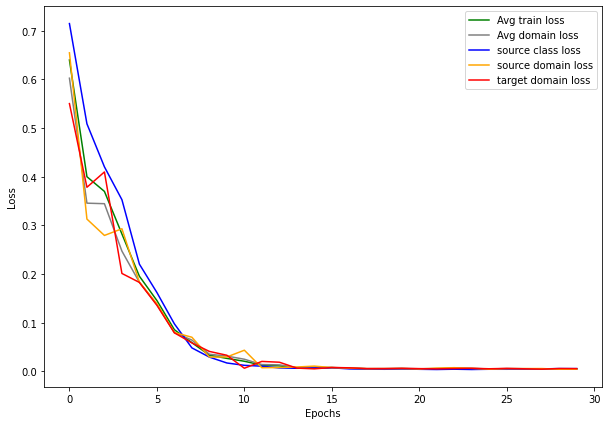

100%|██████████| 8/8 [00:07<00:00,  1.08it/s]

Test Accuracy: 0.3828125


0.3828125

In [ ]:
print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss')
print_acc_loss(sdl,sda,tdl,tda, title="alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss')
print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN_every_plots')
test(net,target_dataloader)

Alexnet hyperparameters search

Iteration 1 / 8


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.0001]
Step 0, Loss 2.145895004272461


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 2.0379, Train Acc: 0.18
Val Loss: 2.0438, Val Acc: 0.18


Starting epoch 2/30, LR = [0.0001]
Step 10, Loss 1.4057812690734863


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Train Loss: 1.5195, Train Acc: 0.46
Val Loss: 1.9237, Val Acc: 0.26


Starting epoch 3/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Train Loss: 1.0895, Train Acc: 0.60
Val Loss: 1.8214, Val Acc: 0.31


Starting epoch 4/30, LR = [0.0001]
Step 20, Loss 0.8451834321022034


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Train Loss: 0.8327, Train Acc: 0.68
Val Loss: 1.7531, Val Acc: 0.34


Starting epoch 5/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Train Loss: 0.6794, Train Acc: 0.73
Val Loss: 1.7155, Val Acc: 0.37


Starting epoch 6/30, LR = [0.0001]
Step 30, Loss 0.6096735596656799


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Train Loss: 0.5704, Train Acc: 0.77
Val Loss: 1.6992, Val Acc: 0.38


Starting epoch 7/30, LR = [0.0001]
Step 40, Loss 0.382916122674942


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Train Loss: 0.4635, Train Acc: 0.81
Val Loss: 1.6973, Val Acc: 0.39


Starting epoch 8/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Train Loss: 0.4022, Train Acc: 0.83
Val Loss: 1.7035, Val Acc: 0.38


Starting epoch 9/30, LR = [0.0001]


Step 50, Loss 0.34696656465530396


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.3509, Train Acc: 0.84
Val Loss: 1.7119, Val Acc: 0.39


Starting epoch 10/30, LR = [0.0001]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Train Loss: 0.3121, Train Acc: 0.85
Val Loss: 1.7215, Val Acc: 0.39


Starting epoch 11/30, LR = [1.4163315384070613e-05]


Step 60, Loss 0.2919807732105255


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2879, Train Acc: 0.85
Val Loss: 1.7227, Val Acc: 0.39


Starting epoch 12/30, LR = [1.4163315384070613e-05]


Step 70, Loss 0.31671643257141113


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2894, Train Acc: 0.85
Val Loss: 1.7236, Val Acc: 0.39


Starting epoch 13/30, LR = [1.4163315384070613e-05]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Train Loss: 0.2979, Train Acc: 0.85
Val Loss: 1.7242, Val Acc: 0.39


Starting epoch 14/30, LR = [1.4163315384070613e-05]


Step 80, Loss 0.2810553014278412


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2924, Train Acc: 0.86
Val Loss: 1.7246, Val Acc: 0.39


Starting epoch 15/30, LR = [1.4163315384070613e-05]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2816, Train Acc: 0.85
Val Loss: 1.7252, Val Acc: 0.40


Starting epoch 16/30, LR = [1.4163315384070613e-05]


Step 90, Loss 0.26560309529304504


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2861, Train Acc: 0.86
Val Loss: 1.7260, Val Acc: 0.40


Starting epoch 17/30, LR = [1.4163315384070613e-05]


Step 100, Loss 0.2609367072582245


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2833, Train Acc: 0.86
Val Loss: 1.7267, Val Acc: 0.40


Starting epoch 18/30, LR = [1.4163315384070613e-05]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Train Loss: 0.2819, Train Acc: 0.85
Val Loss: 1.7272, Val Acc: 0.40


Starting epoch 19/30, LR = [1.4163315384070613e-05]


Step 110, Loss 0.2828192412853241


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2722, Train Acc: 0.86
Val Loss: 1.7280, Val Acc: 0.40


Starting epoch 20/30, LR = [1.4163315384070613e-05]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2693, Train Acc: 0.86
Val Loss: 1.7291, Val Acc: 0.40


Starting epoch 21/30, LR = [2.005995026686513e-06]


Step 120, Loss 0.26576071977615356


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2703, Train Acc: 0.86
Val Loss: 1.7292, Val Acc: 0.40


Starting epoch 22/30, LR = [2.005995026686513e-06]


Step 130, Loss 0.3246994614601135


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2680, Train Acc: 0.86
Val Loss: 1.7293, Val Acc: 0.40


Starting epoch 23/30, LR = [2.005995026686513e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2663, Train Acc: 0.86
Val Loss: 1.7294, Val Acc: 0.40


Starting epoch 24/30, LR = [2.005995026686513e-06]


Step 140, Loss 0.28639063239097595


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2799, Train Acc: 0.85
Val Loss: 1.7295, Val Acc: 0.40


Starting epoch 25/30, LR = [2.005995026686513e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2669, Train Acc: 0.85
Val Loss: 1.7296, Val Acc: 0.40


Starting epoch 26/30, LR = [2.005995026686513e-06]


Step 150, Loss 0.255756676197052


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Train Loss: 0.2634, Train Acc: 0.86
Val Loss: 1.7297, Val Acc: 0.40


Starting epoch 27/30, LR = [2.005995026686513e-06]


Step 160, Loss 0.3092830777168274


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Train Loss: 0.2704, Train Acc: 0.86
Val Loss: 1.7298, Val Acc: 0.40


Starting epoch 28/30, LR = [2.005995026686513e-06]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Train Loss: 0.2726, Train Acc: 0.85
Val Loss: 1.7300, Val Acc: 0.40


Starting epoch 29/30, LR = [2.005995026686513e-06]


Step 170, Loss 0.28305596113204956


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2746, Train Acc: 0.85
Val Loss: 1.7301, Val Acc: 0.40


Starting epoch 30/30, LR = [2.005995026686513e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 0.2616, Train Acc: 0.86
Val Loss: 1.7302, Val Acc: 0.40


[(2.0379067858060202, 0.18023952095808382), (1.5194623470306396, 0.4598802395209581), (1.0894738137722015, 0.6005988023952096), (0.8327372471491495, 0.6766467065868264), (0.6793566942214966, 0.7317365269461078), (0.5703602830568949, 0.7724550898203593), (0.4634810785452525, 0.8119760479041916), (0.40223440527915955, 0.8287425149700599), (0.35090432564417523, 0.8401197604790419), (0.31214962402979535, 0.8467065868263473), (0.2879077270627022, 0.8544910179640719), (0.28941435118516284, 0.8538922155688623), (0.2978942543268204, 0.8473053892215568), (0.2923676073551178, 0.858682634730539), (0.2815979967514674, 0.8526946107784431), (0.28606322407722473, 0.8568862275449102), (0.2832591086626053, 0.855688622754491), (0.2819398492574692, 0.8532934131736527), (0.27217716226975125, 0.858682634730539), (0.26926739513874054, 0.8568862275449102), (0.2702697118123372, 0.862874251497006), (0.2680201480786006, 0.8616766467065868), 

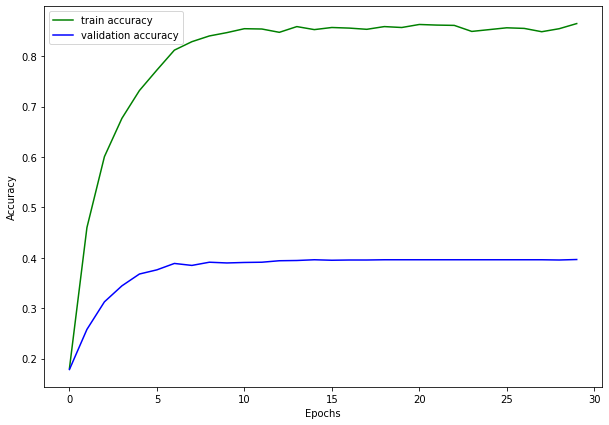

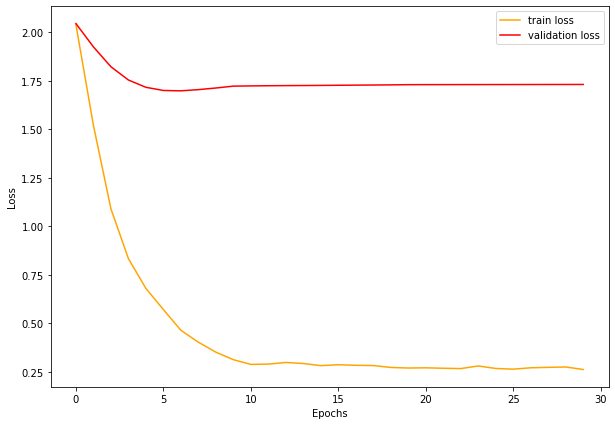

100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Test Accuracy: 0.388671875
Iteration 2 / 8
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.2660422325134277


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Train Loss: 1.5041, Train Acc: 0.41
Val Loss: 1.6776, Val Acc: 0.37


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.34709084033966064


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 0.4588, Train Acc: 0.81
Val Loss: 1.5144, Val Acc: 0.47


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.2008, Train Acc: 0.86
Val Loss: 1.7683, Val Acc: 0.47


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.11586720496416092


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.1383, Train Acc: 0.88
Val Loss: 1.9692, Val Acc: 0.48


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.1112, Train Acc: 0.89
Val Loss: 2.1518, Val Acc: 0.48


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.07873424887657166


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0920, Train Acc: 0.89
Val Loss: 2.2043, Val Acc: 0.49


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.05677910894155502


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0724, Train Acc: 0.90
Val Loss: 2.1927, Val Acc: 0.49


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0681, Train Acc: 0.90
Val Loss: 2.1873, Val Acc: 0.49


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.07192578911781311


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0553, Train Acc: 0.91
Val Loss: 2.2250, Val Acc: 0.49


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0495, Train Acc: 0.91
Val Loss: 2.2429, Val Acc: 0.49


Starting epoch 11/30, LR = [0.00015703938246887605]


Step 60, Loss 0.049631647765636444


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0410, Train Acc: 0.91
Val Loss: 2.2407, Val Acc: 0.49


Starting epoch 12/30, LR = [0.00015703938246887605]


Step 70, Loss 0.04905043542385101


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0476, Train Acc: 0.91
Val Loss: 2.2380, Val Acc: 0.50


Starting epoch 13/30, LR = [0.00015703938246887605]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0412, Train Acc: 0.91
Val Loss: 2.2335, Val Acc: 0.50


Starting epoch 14/30, LR = [0.00015703938246887605]


Step 80, Loss 0.04548443481326103


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0406, Train Acc: 0.91
Val Loss: 2.2354, Val Acc: 0.50


Starting epoch 15/30, LR = [0.00015703938246887605]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0419, Train Acc: 0.91
Val Loss: 2.2363, Val Acc: 0.50


Starting epoch 16/30, LR = [0.00015703938246887605]


Step 90, Loss 0.03967507183551788


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0371, Train Acc: 0.91
Val Loss: 2.2427, Val Acc: 0.49


Starting epoch 17/30, LR = [0.00015703938246887605]


Step 100, Loss 0.04780377447605133


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0399, Train Acc: 0.91
Val Loss: 2.2501, Val Acc: 0.49


Starting epoch 18/30, LR = [0.00015703938246887605]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0409, Train Acc: 0.91
Val Loss: 2.2612, Val Acc: 0.50


Starting epoch 19/30, LR = [0.00015703938246887605]


Step 110, Loss 0.030005713924765587


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0363, Train Acc: 0.91
Val Loss: 2.2672, Val Acc: 0.49


Starting epoch 20/30, LR = [0.00015703938246887605]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0368, Train Acc: 0.91
Val Loss: 2.2768, Val Acc: 0.49


Starting epoch 21/30, LR = [2.4661367646205935e-05]


Step 120, Loss 0.034214623272418976


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0355, Train Acc: 0.91
Val Loss: 2.2788, Val Acc: 0.49


Starting epoch 22/30, LR = [2.4661367646205935e-05]


Step 130, Loss 0.02535923384130001


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0407, Train Acc: 0.91
Val Loss: 2.2797, Val Acc: 0.49


Starting epoch 23/30, LR = [2.4661367646205935e-05]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0383, Train Acc: 0.91
Val Loss: 2.2803, Val Acc: 0.49


Starting epoch 24/30, LR = [2.4661367646205935e-05]


Step 140, Loss 0.0384770892560482


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0346, Train Acc: 0.91
Val Loss: 2.2808, Val Acc: 0.49


Starting epoch 25/30, LR = [2.4661367646205935e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0378, Train Acc: 0.91
Val Loss: 2.2824, Val Acc: 0.49


Starting epoch 26/30, LR = [2.4661367646205935e-05]


Step 150, Loss 0.028526507318019867


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0363, Train Acc: 0.91
Val Loss: 2.2839, Val Acc: 0.49


Starting epoch 27/30, LR = [2.4661367646205935e-05]


Step 160, Loss 0.028712423518300056


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0356, Train Acc: 0.91
Val Loss: 2.2849, Val Acc: 0.49


Starting epoch 28/30, LR = [2.4661367646205935e-05]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0353, Train Acc: 0.91
Val Loss: 2.2851, Val Acc: 0.49


Starting epoch 29/30, LR = [2.4661367646205935e-05]


Step 170, Loss 0.03847867622971535


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0350, Train Acc: 0.91
Val Loss: 2.2861, Val Acc: 0.49


Starting epoch 30/30, LR = [2.4661367646205935e-05]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Train Loss: 0.0369, Train Acc: 0.91
Val Loss: 2.2869, Val Acc: 0.49


[(1.5041211942831676, 0.41437125748502995), (0.4588312953710556, 0.8095808383233533), (0.20083488523960114, 0.858682634730539), (0.13825258240103722, 0.8832335329341318), (0.1112160434325536, 0.88562874251497), (0.09204269138475259, 0.8922155688622755), (0.07235771728058656, 0.8970059880239521), (0.06812229938805103, 0.8994011976047904), (0.055251107240716614, 0.9053892215568863), (0.0494997234394153, 0.907185628742515), (0.040975017783542476, 0.9119760479041916), (0.04758918906251589, 0.9077844311377246), (0.04121212443957726, 0.9107784431137724), (0.04058136108020941, 0.9077844311377246), (0.04192698746919632, 0.911377245508982), (0.037056722988684974, 0.9107784431137724), (0.03990706987679005, 0.911377245508982), (0.04087444922576348, 0.9095808383233533), (0.03625517152249813, 0.9107784431137724), (0.03678433100382487, 0.9107784431137724), (0.03554684203118086, 0.9119760479041916), (0.040749614126980305, 0.908383

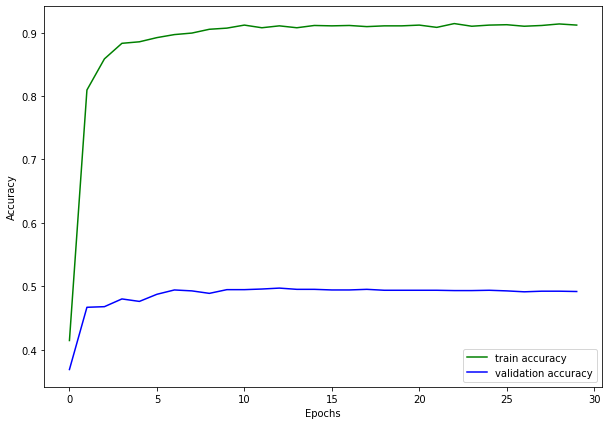

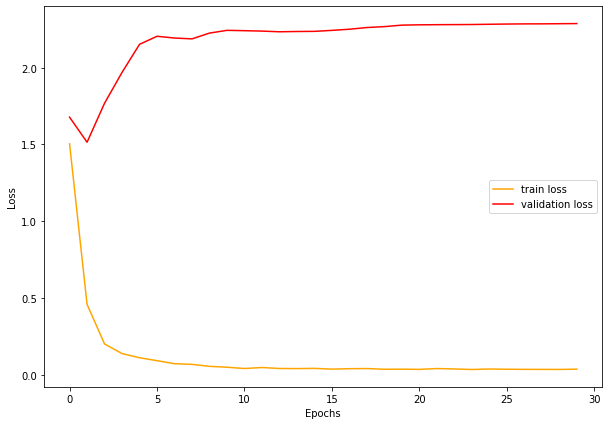

100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Test Accuracy: 0.466796875
Iteration 3 / 8
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.09269642829895


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Train Loss: 1.4591, Train Acc: 0.43
Val Loss: 1.6663, Val Acc: 0.38


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.36613455414772034


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 0.4639, Train Acc: 0.79
Val Loss: 1.5700, Val Acc: 0.46


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Train Loss: 0.1990, Train Acc: 0.87
Val Loss: 1.8470, Val Acc: 0.47


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.14022287726402283


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.1392, Train Acc: 0.88
Val Loss: 2.0647, Val Acc: 0.47


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.1180, Train Acc: 0.89
Val Loss: 2.2394, Val Acc: 0.47


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.085092693567276


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0827, Train Acc: 0.90
Val Loss: 2.3436, Val Acc: 0.46


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.07034683227539062


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0713, Train Acc: 0.90
Val Loss: 2.3301, Val Acc: 0.47


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0606, Train Acc: 0.90
Val Loss: 2.3111, Val Acc: 0.48


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.05543849617242813


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0542, Train Acc: 0.90
Val Loss: 2.3466, Val Acc: 0.47


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0504, Train Acc: 0.91
Val Loss: 2.3343, Val Acc: 0.48


Starting epoch 11/30, LR = [0.00011939617996208681]


Step 60, Loss 0.04343263804912567


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0445, Train Acc: 0.91
Val Loss: 2.3335, Val Acc: 0.48


Starting epoch 12/30, LR = [0.00011939617996208681]


Step 70, Loss 0.04187728464603424


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0386, Train Acc: 0.91
Val Loss: 2.3335, Val Acc: 0.48


Starting epoch 13/30, LR = [0.00011939617996208681]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0431, Train Acc: 0.91
Val Loss: 2.3377, Val Acc: 0.48


Starting epoch 14/30, LR = [0.00011939617996208681]


Step 80, Loss 0.032299529761075974


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0392, Train Acc: 0.91
Val Loss: 2.3393, Val Acc: 0.48


Starting epoch 15/30, LR = [0.00011939617996208681]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0359, Train Acc: 0.91
Val Loss: 2.3400, Val Acc: 0.48


Starting epoch 16/30, LR = [0.00011939617996208681]


Step 90, Loss 0.02349870093166828


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0345, Train Acc: 0.91
Val Loss: 2.3419, Val Acc: 0.48


Starting epoch 17/30, LR = [0.00011939617996208681]


Step 100, Loss 0.025001469999551773


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0361, Train Acc: 0.91
Val Loss: 2.3448, Val Acc: 0.48


Starting epoch 18/30, LR = [0.00011939617996208681]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0380, Train Acc: 0.91
Val Loss: 2.3514, Val Acc: 0.48


Starting epoch 19/30, LR = [0.00011939617996208681]


Step 110, Loss 0.025255437940359116


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0367, Train Acc: 0.91
Val Loss: 2.3573, Val Acc: 0.48


Starting epoch 20/30, LR = [0.00011939617996208681]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0366, Train Acc: 0.91
Val Loss: 2.3637, Val Acc: 0.48


Starting epoch 21/30, LR = [1.425544778953902e-05]


Step 120, Loss 0.051095087081193924


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0371, Train Acc: 0.91
Val Loss: 2.3643, Val Acc: 0.48


Starting epoch 22/30, LR = [1.425544778953902e-05]


Step 130, Loss 0.03471830487251282


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0370, Train Acc: 0.91
Val Loss: 2.3648, Val Acc: 0.48


Starting epoch 23/30, LR = [1.425544778953902e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0382, Train Acc: 0.91
Val Loss: 2.3650, Val Acc: 0.48


Starting epoch 24/30, LR = [1.425544778953902e-05]


Step 140, Loss 0.05485399812459946


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0317, Train Acc: 0.91
Val Loss: 2.3652, Val Acc: 0.48


Starting epoch 25/30, LR = [1.425544778953902e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0368, Train Acc: 0.91
Val Loss: 2.3652, Val Acc: 0.48


Starting epoch 26/30, LR = [1.425544778953902e-05]


Step 150, Loss 0.050319604575634


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0407, Train Acc: 0.91
Val Loss: 2.3653, Val Acc: 0.48


Starting epoch 27/30, LR = [1.425544778953902e-05]


Step 160, Loss 0.019837763160467148


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0375, Train Acc: 0.91
Val Loss: 2.3654, Val Acc: 0.48


Starting epoch 28/30, LR = [1.425544778953902e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0398, Train Acc: 0.91
Val Loss: 2.3654, Val Acc: 0.48


Starting epoch 29/30, LR = [1.425544778953902e-05]


Step 170, Loss 0.03474569693207741


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0336, Train Acc: 0.91
Val Loss: 2.3651, Val Acc: 0.48


Starting epoch 30/30, LR = [1.425544778953902e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Train Loss: 0.0374, Train Acc: 0.91
Val Loss: 2.3654, Val Acc: 0.48


[(1.4590848286946614, 0.4251497005988024), (0.4639301498730977, 0.7934131736526946), (0.19904514650503793, 0.8658682634730539), (0.13923969864845276, 0.8778443113772455), (0.1180239903430144, 0.8862275449101796), (0.08268523961305618, 0.8970059880239521), (0.07126860382656257, 0.8976047904191616), (0.060578095416227974, 0.9005988023952096), (0.054247407242655754, 0.9047904191616767), (0.05037550317744414, 0.9065868263473054), (0.04452700229982535, 0.9089820359281438), (0.0385608933866024, 0.9125748502994012), (0.04308550090839466, 0.9089820359281438), (0.03920881232867638, 0.911377245508982), (0.03592919620374838, 0.9125748502994012), (0.0344640069330732, 0.9137724550898204), (0.03614760904262463, 0.911377245508982), (0.03798363792399565, 0.9107784431137724), (0.03669423609972, 0.9143712574850299), (0.03656075211862723, 0.9101796407185628), (0.03713833695898453, 0.911377245508982), (0.03695261695732673, 0.9095808383

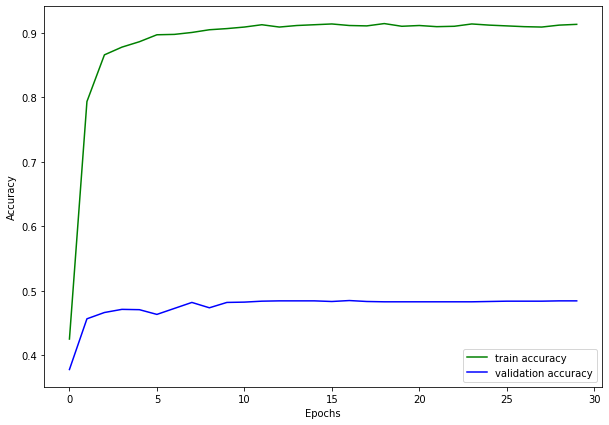

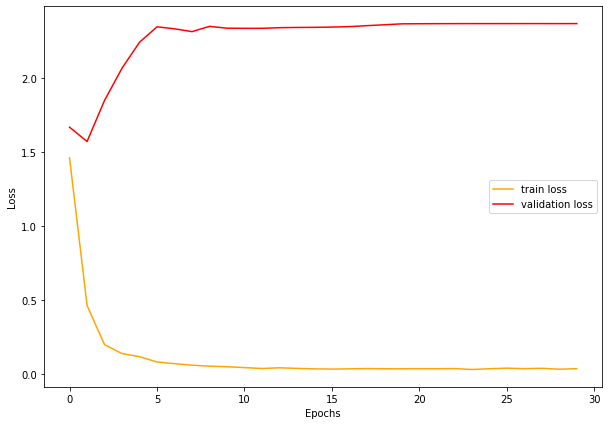

100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Test Accuracy: 0.45654296875
Iteration 4 / 8
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.29021954536438


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Train Loss: 1.5135, Train Acc: 0.41
Val Loss: 1.6071, Val Acc: 0.41


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.3440742790699005


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 0.4919, Train Acc: 0.78
Val Loss: 1.4423, Val Acc: 0.50


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.2157, Train Acc: 0.86
Val Loss: 1.6500, Val Acc: 0.49


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.13146723806858063


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.1438, Train Acc: 0.88
Val Loss: 1.8892, Val Acc: 0.49


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.1116, Train Acc: 0.88
Val Loss: 2.0342, Val Acc: 0.49


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.10193059593439102


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Train Loss: 0.0951, Train Acc: 0.89
Val Loss: 2.1603, Val Acc: 0.48


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.07096490263938904


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0770, Train Acc: 0.90
Val Loss: 2.1922, Val Acc: 0.48


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0672, Train Acc: 0.90
Val Loss: 2.1178, Val Acc: 0.50


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.07447115331888199


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0578, Train Acc: 0.90
Val Loss: 2.1162, Val Acc: 0.50


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0453, Train Acc: 0.91
Val Loss: 2.1318, Val Acc: 0.50


Starting epoch 11/30, LR = [0.00013498619876105714]


Step 60, Loss 0.03612321987748146


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0437, Train Acc: 0.91
Val Loss: 2.1337, Val Acc: 0.50


Starting epoch 12/30, LR = [0.00013498619876105714]


Step 70, Loss 0.04561746120452881


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0431, Train Acc: 0.91
Val Loss: 2.1349, Val Acc: 0.50


Starting epoch 13/30, LR = [0.00013498619876105714]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0474, Train Acc: 0.90
Val Loss: 2.1391, Val Acc: 0.50


Starting epoch 14/30, LR = [0.00013498619876105714]


Step 80, Loss 0.0348704569041729


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0408, Train Acc: 0.91
Val Loss: 2.1394, Val Acc: 0.50


Starting epoch 15/30, LR = [0.00013498619876105714]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0421, Train Acc: 0.91
Val Loss: 2.1416, Val Acc: 0.50


Starting epoch 16/30, LR = [0.00013498619876105714]


Step 90, Loss 0.03502393886446953


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0351, Train Acc: 0.91
Val Loss: 2.1428, Val Acc: 0.50


Starting epoch 17/30, LR = [0.00013498619876105714]


Step 100, Loss 0.035766880959272385


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0397, Train Acc: 0.91
Val Loss: 2.1445, Val Acc: 0.50


Starting epoch 18/30, LR = [0.00013498619876105714]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0426, Train Acc: 0.91
Val Loss: 2.1482, Val Acc: 0.50


Starting epoch 19/30, LR = [0.00013498619876105714]


Step 110, Loss 0.03267908841371536


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0369, Train Acc: 0.91
Val Loss: 2.1531, Val Acc: 0.50


Starting epoch 20/30, LR = [0.00013498619876105714]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0407, Train Acc: 0.91
Val Loss: 2.1621, Val Acc: 0.50


Starting epoch 21/30, LR = [1.8221273855959625e-05]


Step 120, Loss 0.03477683663368225


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0395, Train Acc: 0.91
Val Loss: 2.1630, Val Acc: 0.50


Starting epoch 22/30, LR = [1.8221273855959625e-05]


Step 130, Loss 0.028379788622260094


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0347, Train Acc: 0.91
Val Loss: 2.1638, Val Acc: 0.50


Starting epoch 23/30, LR = [1.8221273855959625e-05]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0382, Train Acc: 0.91
Val Loss: 2.1645, Val Acc: 0.50


Starting epoch 24/30, LR = [1.8221273855959625e-05]


Step 140, Loss 0.046707883477211


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0394, Train Acc: 0.91
Val Loss: 2.1657, Val Acc: 0.50


Starting epoch 25/30, LR = [1.8221273855959625e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0325, Train Acc: 0.91
Val Loss: 2.1666, Val Acc: 0.50


Starting epoch 26/30, LR = [1.8221273855959625e-05]


Step 150, Loss 0.03305215761065483


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0361, Train Acc: 0.91
Val Loss: 2.1680, Val Acc: 0.50


Starting epoch 27/30, LR = [1.8221273855959625e-05]


Step 160, Loss 0.03147050365805626


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0367, Train Acc: 0.91
Val Loss: 2.1693, Val Acc: 0.50


Starting epoch 28/30, LR = [1.8221273855959625e-05]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0339, Train Acc: 0.91
Val Loss: 2.1704, Val Acc: 0.50


Starting epoch 29/30, LR = [1.8221273855959625e-05]


Step 170, Loss 0.017855385318398476


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0395, Train Acc: 0.91
Val Loss: 2.1708, Val Acc: 0.50


Starting epoch 30/30, LR = [1.8221273855959625e-05]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Train Loss: 0.0372, Train Acc: 0.91
Val Loss: 2.1710, Val Acc: 0.50


[(1.5135332743326824, 0.4095808383233533), (0.49191413819789886, 0.7778443113772455), (0.21572132408618927, 0.8592814371257484), (0.1438380628824234, 0.8796407185628743), (0.11159009858965874, 0.884431137724551), (0.09512259190281232, 0.8910179640718563), (0.07703714817762375, 0.8976047904191616), (0.06723552631835143, 0.8988023952095808), (0.05779001737634341, 0.9029940119760479), (0.04527717766662439, 0.9077844311377246), (0.043666873748103775, 0.9089820359281438), (0.043081111585100494, 0.9077844311377246), (0.04735544634362062, 0.9047904191616767), (0.04076711212595304, 0.9089820359281438), (0.042096552439033985, 0.9119760479041916), (0.0351457791402936, 0.9107784431137724), (0.03970048390328884, 0.9125748502994012), (0.042566994515558086, 0.9077844311377246), (0.03688684571534395, 0.9119760479041916), (0.040728300188978515, 0.9095808383233533), (0.039501103572547436, 0.9119760479041916), (0.03472407286365827, 0

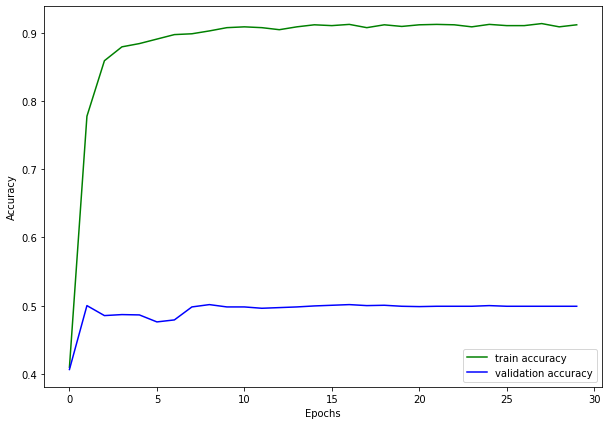

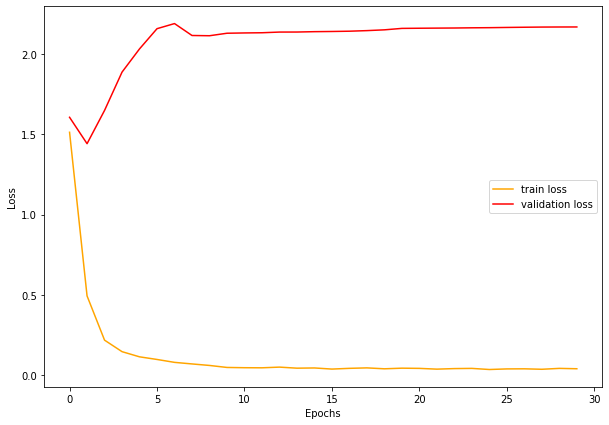

100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Test Accuracy: 0.5
Iteration 5 / 8
Starting epoch 1/30, LR = [1e-05]
Step 0, Loss 2.278992176055908


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Train Loss: 2.2963, Train Acc: 0.14
Val Loss: 2.1233, Val Acc: 0.15


Starting epoch 2/30, LR = [1e-05]
Step 10, Loss 2.1687633991241455


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 2.2222, Train Acc: 0.15
Val Loss: 2.1062, Val Acc: 0.15


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 2.1219, Train Acc: 0.18
Val Loss: 2.0854, Val Acc: 0.16


Starting epoch 4/30, LR = [1e-05]
Step 20, Loss 2.023993730545044


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.9992, Train Acc: 0.21
Val Loss: 2.0634, Val Acc: 0.17


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 1.8862, Train Acc: 0.25
Val Loss: 2.0416, Val Acc: 0.19


Starting epoch 6/30, LR = [1e-05]
Step 30, Loss 1.8733524084091187


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.7759, Train Acc: 0.31
Val Loss: 2.0209, Val Acc: 0.19


Starting epoch 7/30, LR = [1e-05]
Step 40, Loss 1.6747108697891235


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.6993, Train Acc: 0.38
Val Loss: 2.0012, Val Acc: 0.20


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.6023, Train Acc: 0.43
Val Loss: 1.9829, Val Acc: 0.21


Starting epoch 9/30, LR = [1e-05]
Step 50, Loss 1.4961543083190918


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 1.5267, Train Acc: 0.46
Val Loss: 1.9656, Val Acc: 0.23


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.4358, Train Acc: 0.49
Val Loss: 1.9495, Val Acc: 0.23


Starting epoch 11/30, LR = [1.3654770754834204e-06]
Step 60, Loss 1.3945493698120117


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 1.3982, Train Acc: 0.50
Val Loss: 1.9474, Val Acc: 0.23


Starting epoch 12/30, LR = [1.3654770754834204e-06]
Step 70, Loss 1.3802399635314941


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3679, Train Acc: 0.51
Val Loss: 1.9454, Val Acc: 0.24


Starting epoch 13/30, LR = [1.3654770754834204e-06]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3760, Train Acc: 0.51
Val Loss: 1.9435, Val Acc: 0.24


Starting epoch 14/30, LR = [1.3654770754834204e-06]
Step 80, Loss 1.378223180770874


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.3822, Train Acc: 0.50
Val Loss: 1.9416, Val Acc: 0.24


Starting epoch 15/30, LR = [1.3654770754834204e-06]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3596, Train Acc: 0.51
Val Loss: 1.9397, Val Acc: 0.24


Starting epoch 16/30, LR = [1.3654770754834204e-06]
Step 90, Loss 1.4430935382843018


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3571, Train Acc: 0.52
Val Loss: 1.9378, Val Acc: 0.24


Starting epoch 17/30, LR = [1.3654770754834204e-06]
Step 100, Loss 1.3812299966812134


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3616, Train Acc: 0.51
Val Loss: 1.9359, Val Acc: 0.24


Starting epoch 18/30, LR = [1.3654770754834204e-06]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3525, Train Acc: 0.51
Val Loss: 1.9341, Val Acc: 0.24


Starting epoch 19/30, LR = [1.3654770754834204e-06]
Step 110, Loss 1.2477868795394897


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.3261, Train Acc: 0.52
Val Loss: 1.9323, Val Acc: 0.24


Starting epoch 20/30, LR = [1.3654770754834204e-06]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Train Loss: 1.3497, Train Acc: 0.52
Val Loss: 1.9305, Val Acc: 0.24


Starting epoch 21/30, LR = [1.8645276436707544e-07]
Step 120, Loss 1.3525632619857788


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3257, Train Acc: 0.52
Val Loss: 1.9303, Val Acc: 0.24


Starting epoch 22/30, LR = [1.8645276436707544e-07]
Step 130, Loss 1.359620213508606


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Train Loss: 1.3223, Train Acc: 0.53
Val Loss: 1.9300, Val Acc: 0.24


Starting epoch 23/30, LR = [1.8645276436707544e-07]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.3234, Train Acc: 0.52
Val Loss: 1.9298, Val Acc: 0.24


Starting epoch 24/30, LR = [1.8645276436707544e-07]
Step 140, Loss 1.3104828596115112


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3092, Train Acc: 0.53
Val Loss: 1.9295, Val Acc: 0.24


Starting epoch 25/30, LR = [1.8645276436707544e-07]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3212, Train Acc: 0.53
Val Loss: 1.9293, Val Acc: 0.24


Starting epoch 26/30, LR = [1.8645276436707544e-07]
Step 150, Loss 1.3433125019073486


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.3149, Train Acc: 0.52
Val Loss: 1.9291, Val Acc: 0.24


Starting epoch 27/30, LR = [1.8645276436707544e-07]
Step 160, Loss 1.336606740951538


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3316, Train Acc: 0.51
Val Loss: 1.9288, Val Acc: 0.25


Starting epoch 28/30, LR = [1.8645276436707544e-07]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.3237, Train Acc: 0.52
Val Loss: 1.9286, Val Acc: 0.25


Starting epoch 29/30, LR = [1.8645276436707544e-07]
Step 170, Loss 1.302409291267395


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3235, Train Acc: 0.52
Val Loss: 1.9283, Val Acc: 0.25


Starting epoch 30/30, LR = [1.8645276436707544e-07]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.3087, Train Acc: 0.54
Val Loss: 1.9281, Val Acc: 0.24


[(2.296257813771566, 0.14011976047904193), (2.222236434618632, 0.1467065868263473), (2.1219231685002646, 0.17784431137724552), (1.9991662899653118, 0.20958083832335328), (1.8861589630444844, 0.2502994011976048), (1.7758957743644714, 0.307185628742515), (1.69932226339976, 0.3778443113772455), (1.602295994758606, 0.4293413173652695), (1.5266688068707783, 0.4562874251497006), (1.435846209526062, 0.49161676646706587), (1.3981822331746419, 0.49640718562874253), (1.3679042061169941, 0.51437125748503), (1.3760241270065308, 0.5077844311377245), (1.382211188475291, 0.5047904191616767), (1.3596021334330242, 0.51437125748503), (1.357136348883311, 0.5191616766467065), (1.3615783055623372, 0.5077844311377245), (1.352522651354472, 0.51437125748503), (1.3261189460754395, 0.5239520958083832), (1.3497274319330852, 0.5197604790419161), (1.3256748119990032, 0.5203592814371257), (1.322298566500346, 0.5299401197604791), (1.3233520189921

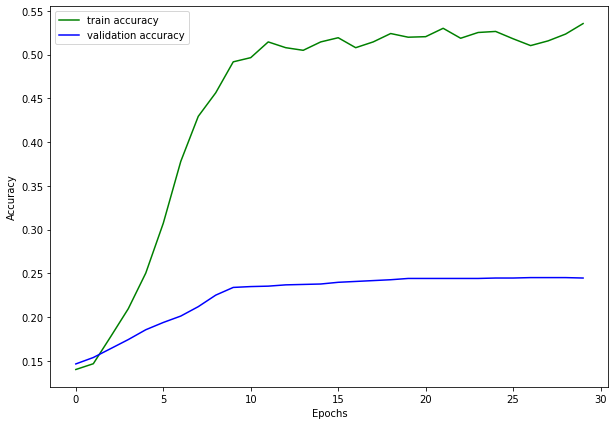

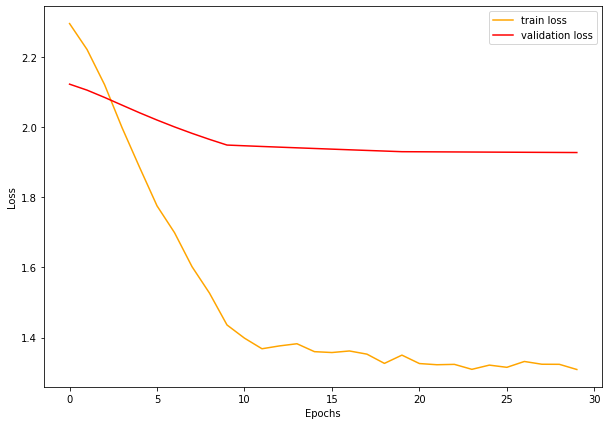

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Test Accuracy: 0.24462890625
Iteration 6 / 8
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.0017025470733643


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.3959, Train Acc: 0.45
Val Loss: 1.6937, Val Acc: 0.38


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.2767949104309082


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 0.4491, Train Acc: 0.80
Val Loss: 1.5265, Val Acc: 0.46


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Train Loss: 0.2017, Train Acc: 0.87
Val Loss: 1.8090, Val Acc: 0.45


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.1542123556137085


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.1324, Train Acc: 0.88
Val Loss: 2.0616, Val Acc: 0.45


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.1056, Train Acc: 0.88
Val Loss: 2.2495, Val Acc: 0.46


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.1046619564294815


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0948, Train Acc: 0.89
Val Loss: 2.3379, Val Acc: 0.46


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.07984331995248795


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0731, Train Acc: 0.90
Val Loss: 2.3597, Val Acc: 0.46


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0597, Train Acc: 0.90
Val Loss: 2.4182, Val Acc: 0.44


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.057307083159685135


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0527, Train Acc: 0.90
Val Loss: 2.4040, Val Acc: 0.45


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0449, Train Acc: 0.91
Val Loss: 2.4209, Val Acc: 0.46


Starting epoch 11/30, LR = [0.00016327308498754206]


Step 60, Loss 0.030582034960389137


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0459, Train Acc: 0.90
Val Loss: 2.4256, Val Acc: 0.46


Starting epoch 12/30, LR = [0.00016327308498754206]


Step 70, Loss 0.029900753870606422


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0405, Train Acc: 0.91
Val Loss: 2.4305, Val Acc: 0.45


Starting epoch 13/30, LR = [0.00016327308498754206]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Train Loss: 0.0424, Train Acc: 0.91
Val Loss: 2.4310, Val Acc: 0.45


Starting epoch 14/30, LR = [0.00016327308498754206]


Step 80, Loss 0.03339146822690964


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0339, Train Acc: 0.91
Val Loss: 2.4266, Val Acc: 0.46


Starting epoch 15/30, LR = [0.00016327308498754206]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0365, Train Acc: 0.92
Val Loss: 2.4241, Val Acc: 0.46


Starting epoch 16/30, LR = [0.00016327308498754206]


Step 90, Loss 0.03852060064673424


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0408, Train Acc: 0.91
Val Loss: 2.4269, Val Acc: 0.45


Starting epoch 17/30, LR = [0.00016327308498754206]


Step 100, Loss 0.029393037781119347


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0342, Train Acc: 0.91
Val Loss: 2.4269, Val Acc: 0.46


Starting epoch 18/30, LR = [0.00016327308498754206]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0321, Train Acc: 0.91
Val Loss: 2.4313, Val Acc: 0.46


Starting epoch 19/30, LR = [0.00016327308498754206]


Step 110, Loss 0.0388815738260746


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0340, Train Acc: 0.91
Val Loss: 2.4345, Val Acc: 0.46


Starting epoch 20/30, LR = [0.00016327308498754206]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0329, Train Acc: 0.91
Val Loss: 2.4360, Val Acc: 0.46


Starting epoch 21/30, LR = [2.6658100281349134e-05]


Step 120, Loss 0.026890646666288376


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0348, Train Acc: 0.91
Val Loss: 2.4368, Val Acc: 0.46


Starting epoch 22/30, LR = [2.6658100281349134e-05]


Step 130, Loss 0.0261798445135355


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0332, Train Acc: 0.91
Val Loss: 2.4380, Val Acc: 0.46


Starting epoch 23/30, LR = [2.6658100281349134e-05]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0368, Train Acc: 0.91
Val Loss: 2.4381, Val Acc: 0.46


Starting epoch 24/30, LR = [2.6658100281349134e-05]


Step 140, Loss 0.034741874784231186


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0354, Train Acc: 0.91
Val Loss: 2.4381, Val Acc: 0.46


Starting epoch 25/30, LR = [2.6658100281349134e-05]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 0.0392, Train Acc: 0.91
Val Loss: 2.4377, Val Acc: 0.46


Starting epoch 26/30, LR = [2.6658100281349134e-05]


Step 150, Loss 0.05093315616250038


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0344, Train Acc: 0.91
Val Loss: 2.4377, Val Acc: 0.46


Starting epoch 27/30, LR = [2.6658100281349134e-05]


Step 160, Loss 0.03352008014917374


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0292, Train Acc: 0.91
Val Loss: 2.4387, Val Acc: 0.46


Starting epoch 28/30, LR = [2.6658100281349134e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0295, Train Acc: 0.91
Val Loss: 2.4403, Val Acc: 0.46


Starting epoch 29/30, LR = [2.6658100281349134e-05]


Step 170, Loss 0.03742223605513573


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0354, Train Acc: 0.91
Val Loss: 2.4421, Val Acc: 0.46


Starting epoch 30/30, LR = [2.6658100281349134e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Train Loss: 0.0334, Train Acc: 0.91
Val Loss: 2.4425, Val Acc: 0.46


[(1.3959388931592305, 0.45089820359281435), (0.44905851781368256, 0.8041916167664671), (0.20165166755517325, 0.8688622754491018), (0.13241084789236388, 0.8808383233532934), (0.10564812148610751, 0.8832335329341318), (0.09482985362410545, 0.8916167664670659), (0.07310908908645312, 0.8970059880239521), (0.05966301324466864, 0.9035928143712575), (0.05268783991535505, 0.9029940119760479), (0.04485550398627917, 0.9059880239520958), (0.045895930069188275, 0.9041916167664671), (0.040519168600440025, 0.9083832335329342), (0.042385837684075035, 0.9083832335329342), (0.03392196322480837, 0.9137724550898204), (0.03654365738232931, 0.9155688622754491), (0.04081355842451254, 0.9089820359281438), (0.03421689756214619, 0.911377245508982), (0.0321091820175449, 0.9131736526946108), (0.03398067535211643, 0.9119760479041916), (0.03293515214075645, 0.9137724550898204), (0.034755862628420196, 0.9107784431137724), (0.03323687178393205, 0

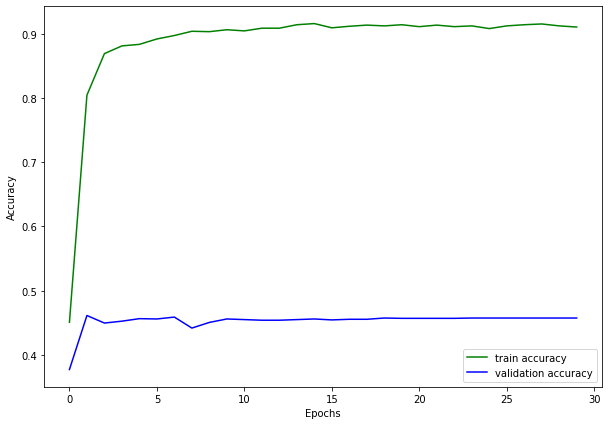

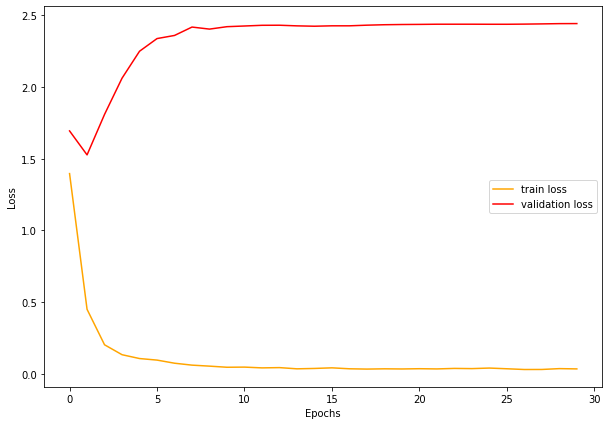

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Test Accuracy: 0.46142578125
Iteration 7 / 8
Starting epoch 1/30, LR = [1e-05]
Step 0, Loss 2.1522576808929443


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Train Loss: 2.1391, Train Acc: 0.11
Val Loss: 2.1801, Val Acc: 0.11


Starting epoch 2/30, LR = [1e-05]
Step 10, Loss 2.0899384021759033


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 2.0668, Train Acc: 0.12
Val Loss: 2.1627, Val Acc: 0.12


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 1.9863, Train Acc: 0.17
Val Loss: 2.1410, Val Acc: 0.12


Starting epoch 4/30, LR = [1e-05]
Step 20, Loss 1.8410017490386963


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.8532, Train Acc: 0.24
Val Loss: 2.1182, Val Acc: 0.13


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.7552, Train Acc: 0.34
Val Loss: 2.0960, Val Acc: 0.14


Starting epoch 6/30, LR = [1e-05]
Step 30, Loss 1.6987553834915161


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.6755, Train Acc: 0.38
Val Loss: 2.0750, Val Acc: 0.15


Starting epoch 7/30, LR = [1e-05]
Step 40, Loss 1.4834171533584595


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.5692, Train Acc: 0.45
Val Loss: 2.0549, Val Acc: 0.17


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 1.4804, Train Acc: 0.49
Val Loss: 2.0361, Val Acc: 0.18


Starting epoch 9/30, LR = [1e-05]
Step 50, Loss 1.3205941915512085


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3994, Train Acc: 0.51
Val Loss: 2.0186, Val Acc: 0.19


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.3354, Train Acc: 0.54
Val Loss: 2.0027, Val Acc: 0.20


Starting epoch 11/30, LR = [2.1006907639888742e-06]
Step 60, Loss 1.3596035242080688


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 1.2994, Train Acc: 0.54
Val Loss: 1.9996, Val Acc: 0.20


Starting epoch 12/30, LR = [2.1006907639888742e-06]
Step 70, Loss 1.3921678066253662


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.3113, Train Acc: 0.53
Val Loss: 1.9967, Val Acc: 0.20


Starting epoch 13/30, LR = [2.1006907639888742e-06]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2921, Train Acc: 0.54
Val Loss: 1.9938, Val Acc: 0.21


Starting epoch 14/30, LR = [2.1006907639888742e-06]
Step 80, Loss 1.2500354051589966


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2643, Train Acc: 0.56
Val Loss: 1.9909, Val Acc: 0.21


Starting epoch 15/30, LR = [2.1006907639888742e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Train Loss: 1.2781, Train Acc: 0.55
Val Loss: 1.9881, Val Acc: 0.21


Starting epoch 16/30, LR = [2.1006907639888742e-06]
Step 90, Loss 1.199037790298462


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Train Loss: 1.2477, Train Acc: 0.55
Val Loss: 1.9854, Val Acc: 0.21


Starting epoch 17/30, LR = [2.1006907639888742e-06]
Step 100, Loss 1.2361807823181152


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2530, Train Acc: 0.55
Val Loss: 1.9828, Val Acc: 0.21


Starting epoch 18/30, LR = [2.1006907639888742e-06]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 1.2226, Train Acc: 0.57
Val Loss: 1.9801, Val Acc: 0.21


Starting epoch 19/30, LR = [2.1006907639888742e-06]
Step 110, Loss 1.2499442100524902


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2066, Train Acc: 0.57
Val Loss: 1.9775, Val Acc: 0.22


Starting epoch 20/30, LR = [2.1006907639888742e-06]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Train Loss: 1.2140, Train Acc: 0.57
Val Loss: 1.9750, Val Acc: 0.22


Starting epoch 21/30, LR = [4.41290168590816e-07]
Step 120, Loss 1.2331613302230835


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2174, Train Acc: 0.56
Val Loss: 1.9744, Val Acc: 0.22


Starting epoch 22/30, LR = [4.41290168590816e-07]
Step 130, Loss 1.207806944847107


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2024, Train Acc: 0.57
Val Loss: 1.9739, Val Acc: 0.22


Starting epoch 23/30, LR = [4.41290168590816e-07]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Train Loss: 1.1890, Train Acc: 0.58
Val Loss: 1.9734, Val Acc: 0.22


Starting epoch 24/30, LR = [4.41290168590816e-07]
Step 140, Loss 1.1299500465393066


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 1.1889, Train Acc: 0.59
Val Loss: 1.9729, Val Acc: 0.22


Starting epoch 25/30, LR = [4.41290168590816e-07]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Train Loss: 1.1817, Train Acc: 0.57
Val Loss: 1.9723, Val Acc: 0.22


Starting epoch 26/30, LR = [4.41290168590816e-07]
Step 150, Loss 1.2131553888320923


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2006, Train Acc: 0.56
Val Loss: 1.9718, Val Acc: 0.22


Starting epoch 27/30, LR = [4.41290168590816e-07]
Step 160, Loss 1.3010212182998657


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.1989, Train Acc: 0.57
Val Loss: 1.9713, Val Acc: 0.22


Starting epoch 28/30, LR = [4.41290168590816e-07]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Train Loss: 1.2005, Train Acc: 0.57
Val Loss: 1.9708, Val Acc: 0.22


Starting epoch 29/30, LR = [4.41290168590816e-07]
Step 170, Loss 1.2002009153366089


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Train Loss: 1.2047, Train Acc: 0.57
Val Loss: 1.9703, Val Acc: 0.22


Starting epoch 30/30, LR = [4.41290168590816e-07]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Train Loss: 1.1863, Train Acc: 0.58
Val Loss: 1.9698, Val Acc: 0.22


[(2.139110048611959, 0.10958083832335329), (2.0668212175369263, 0.12275449101796407), (1.9863285819689434, 0.1658682634730539), (1.8532419006029766, 0.24311377245508983), (1.755246877670288, 0.33652694610778444), (1.675506830215454, 0.3838323353293413), (1.5692003568013508, 0.45269461077844314), (1.4804260730743408, 0.4880239520958084), (1.399427553017934, 0.5149700598802395), (1.3353898326555889, 0.5407185628742515), (1.2994035283724468, 0.5425149700598803), (1.311254898707072, 0.5269461077844312), (1.292066256205241, 0.5407185628742515), (1.2642635703086853, 0.5592814371257485), (1.2780994375546773, 0.5526946107784431), (1.2477498253186543, 0.5502994011976048), (1.2530385851860046, 0.5467065868263473), (1.2225951353708904, 0.5706586826347305), (1.2065669298171997, 0.574251497005988), (1.2140458623568218, 0.5694610778443113), (1.2174020012219746, 0.5634730538922156), (1.2024335861206055, 0.5736526946107784), (1.189

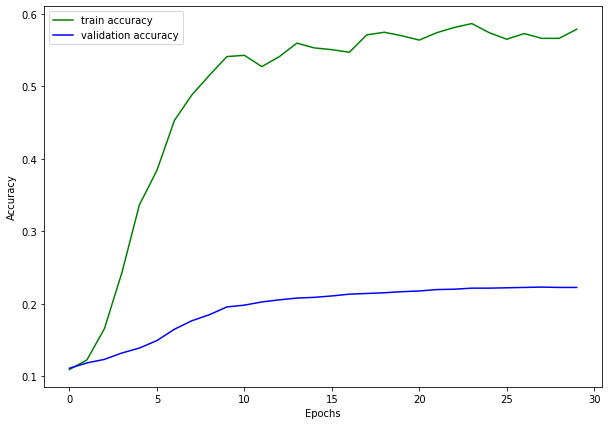

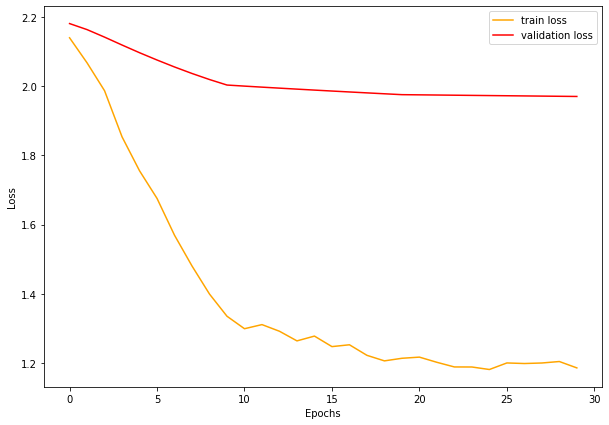

100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Test Accuracy: 0.22265625
Iteration 8 / 8
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.2647740840911865


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Train Loss: 1.5011, Train Acc: 0.42
Val Loss: 1.6842, Val Acc: 0.38


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.35379108786582947


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Train Loss: 0.4759, Train Acc: 0.80
Val Loss: 1.4916, Val Acc: 0.47


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Train Loss: 0.2096, Train Acc: 0.87
Val Loss: 1.6876, Val Acc: 0.46


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.11989086866378784


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.1387, Train Acc: 0.88
Val Loss: 1.9333, Val Acc: 0.47


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.1059, Train Acc: 0.89
Val Loss: 2.0993, Val Acc: 0.46


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.09004247188568115


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0966, Train Acc: 0.89
Val Loss: 2.1839, Val Acc: 0.47


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.10608838498592377


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0745, Train Acc: 0.89
Val Loss: 2.2078, Val Acc: 0.47


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Train Loss: 0.0634, Train Acc: 0.90
Val Loss: 2.1888, Val Acc: 0.48


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.0655864030122757


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0565, Train Acc: 0.90
Val Loss: 2.2436, Val Acc: 0.48


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0488, Train Acc: 0.90
Val Loss: 2.2948, Val Acc: 0.48


Starting epoch 11/30, LR = [0.00021943047449322691]


Step 60, Loss 0.04810164496302605


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0476, Train Acc: 0.91
Val Loss: 2.2819, Val Acc: 0.48


Starting epoch 12/30, LR = [0.00021943047449322691]


Step 70, Loss 0.046003714203834534


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0440, Train Acc: 0.91
Val Loss: 2.2707, Val Acc: 0.49


Starting epoch 13/30, LR = [0.00021943047449322691]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0410, Train Acc: 0.91
Val Loss: 2.2597, Val Acc: 0.49


Starting epoch 14/30, LR = [0.00021943047449322691]


Step 80, Loss 0.04999545216560364


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0448, Train Acc: 0.91
Val Loss: 2.2632, Val Acc: 0.49


Starting epoch 15/30, LR = [0.00021943047449322691]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0418, Train Acc: 0.91
Val Loss: 2.2714, Val Acc: 0.49


Starting epoch 16/30, LR = [0.00021943047449322691]


Step 90, Loss 0.029178617522120476


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0395, Train Acc: 0.91
Val Loss: 2.2873, Val Acc: 0.49


Starting epoch 17/30, LR = [0.00021943047449322691]


Step 100, Loss 0.03615850955247879


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0347, Train Acc: 0.91
Val Loss: 2.3000, Val Acc: 0.49


Starting epoch 18/30, LR = [0.00021943047449322691]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0360, Train Acc: 0.91
Val Loss: 2.3063, Val Acc: 0.49


Starting epoch 19/30, LR = [0.00021943047449322691]


Step 110, Loss 0.03531161695718765


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0333, Train Acc: 0.91
Val Loss: 2.3114, Val Acc: 0.49


Starting epoch 20/30, LR = [0.00021943047449322691]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0391, Train Acc: 0.91
Val Loss: 2.3132, Val Acc: 0.49


Starting epoch 21/30, LR = [4.814973313632271e-05]


Step 120, Loss 0.04225703328847885


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0334, Train Acc: 0.91
Val Loss: 2.3142, Val Acc: 0.49


Starting epoch 22/30, LR = [4.814973313632271e-05]


Step 130, Loss 0.03328169509768486


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0421, Train Acc: 0.91
Val Loss: 2.3154, Val Acc: 0.49


Starting epoch 23/30, LR = [4.814973313632271e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0364, Train Acc: 0.91
Val Loss: 2.3160, Val Acc: 0.49


Starting epoch 24/30, LR = [4.814973313632271e-05]


Step 140, Loss 0.04493872821331024


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0393, Train Acc: 0.91
Val Loss: 2.3172, Val Acc: 0.49


Starting epoch 25/30, LR = [4.814973313632271e-05]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 0.0307, Train Acc: 0.91
Val Loss: 2.3178, Val Acc: 0.49


Starting epoch 26/30, LR = [4.814973313632271e-05]


Step 150, Loss 0.02643076702952385


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.0308, Train Acc: 0.91
Val Loss: 2.3181, Val Acc: 0.49


Starting epoch 27/30, LR = [4.814973313632271e-05]


Step 160, Loss 0.03813357651233673


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0325, Train Acc: 0.91
Val Loss: 2.3182, Val Acc: 0.49


Starting epoch 28/30, LR = [4.814973313632271e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 0.0323, Train Acc: 0.91
Val Loss: 2.3198, Val Acc: 0.49


Starting epoch 29/30, LR = [4.814973313632271e-05]


Step 170, Loss 0.033434316515922546


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Train Loss: 0.0348, Train Acc: 0.91
Val Loss: 2.3220, Val Acc: 0.49


Starting epoch 30/30, LR = [4.814973313632271e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Train Loss: 0.0319, Train Acc: 0.92
Val Loss: 2.3239, Val Acc: 0.49


[(1.5010639528433483, 0.42095808383233535), (0.4759148856004079, 0.795808383233533), (0.20961353927850723, 0.8694610778443114), (0.13874111076196036, 0.881437125748503), (0.10587912425398827, 0.8892215568862275), (0.09658941999077797, 0.8946107784431138), (0.07449594140052795, 0.8946107784431138), (0.06344835956891377, 0.9011976047904192), (0.056529692063728966, 0.9041916167664671), (0.04883132937053839, 0.9047904191616767), (0.04759675202270349, 0.9077844311377246), (0.04395752027630806, 0.9107784431137724), (0.04099127805481354, 0.9089820359281438), (0.04482110124081373, 0.9101796407185628), (0.04178853922833999, 0.9101796407185628), (0.03953906490157048, 0.9143712574850299), (0.034699266155560814, 0.9119760479041916), (0.03597641115387281, 0.9143712574850299), (0.03333306902398666, 0.9125748502994012), (0.039050412674744926, 0.9077844311377246), (0.03342818499853214, 0.9143712574850299), (0.04205600110193094, 0.9

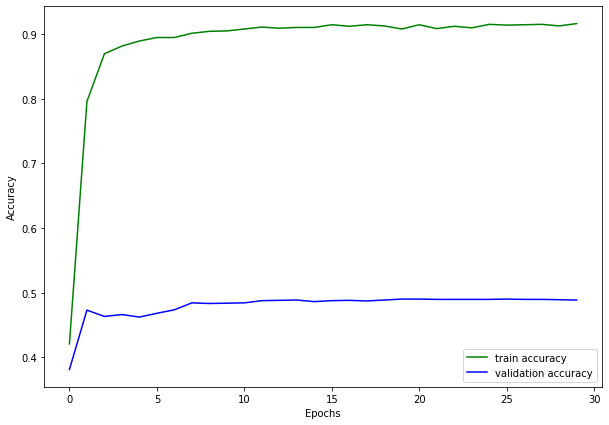

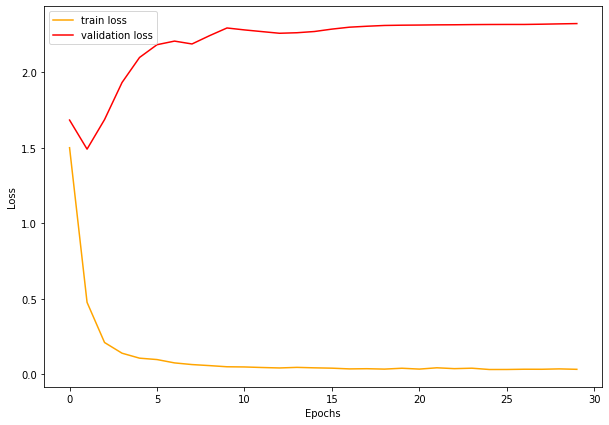

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]

Test Accuracy: 0.47314453125
The highest accuracy is: {max(ress)} for params: {best_params}


In [ ]:
BATCH_SIZE = 256     
LR = 1e-2            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5   
NUM_EPOCHS = 30      
STEP_SIZE = 10       
GAMMA = 0.1       

tests = []
first_attempt = {
'LR' : LR,
'WEIGHT_DECAY' : WEIGHT_DECAY,
'STEP_SIZE': STEP_SIZE,
'GAMMA' : GAMMA,
'accuracy' : 0.470703125
}
tests.append(first_attempt)
ress = [0.470703125]


best_params = {}

import random
num_iters=8

for i in range(num_iters):
    print(f'Iteration {i+1} / {num_iters}')
    lr = 10**(-random.randint(3,5))
    wd = 5*10**(-random.randint(4,6))
    gamma = random.uniform(0.1,0.5)
    #alpha = random.uniform(0.01,0.5)
    s = f'{lr}_{wd}_{gamma}'
    net = torchvision.models.alexnet(pretrained=True) 
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=gamma)
    tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="/content/drive/My Drive/alexnet_noDANN_pretrained_"+s)
    print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained_"+s)
    res = test(net,target_dataloader)

    result = {  'LR' : lr,
                'WEIGHT_DECAY' : wd,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : gamma,
                'accuracy' : res}

    tests.append(result)
    if res > max(ress):
        best_params = result
    ress.append(res)


print(f"The highest accuracy is: {max(ress)} for params: {best_params}")



In [ ]:

print(f"The highest accuracy is: {max(ress)} for params: {best_params}")

The highest accuracy is: 0.5 for params: {'LR': 0.001, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.13498619876105714, 'accuracy': 0.5}


DANN hyperparameters search

Iteration 1 / 8
Starting epoch 1/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Source class Loss: 1.2337, Train class Acc: 0.55
Target class Loss: 0.5427, Val class Acc: 0.38
Source domain Loss: 0.4493, Source domain Acc: 0.77
Target domain Loss: 0.4311, Target domain Acc: 0.79
Total train Loss: 0.7047, Total train Acc: 0.70
Total domain Loss: 0.4402, Total domain Acc: 0.78


Starting epoch 2/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.2949, Train class Acc: 0.92
Target class Loss: 0.1673, Val class Acc: 0.36
Source domain Loss: 0.2355, Source domain Acc: 0.92
Target domain Loss: 0.2449, Target domain Acc: 0.91
Total train Loss: 0.2584, Total train Acc: 0.92
Total domain Loss: 0.2402, Total domain Acc: 0.92


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 0.1648, Train class Acc: 0.95
Target class Loss: 0.1613, Val class Acc: 0.39
Source domain Loss: 0.1817, Source domain Acc: 0.94
Target domain Loss: 0.1162, Target domain Acc: 0.96
Total train Loss: 0.1542, Total train Acc: 0.95
Total domain Loss: 0.1490, Total domain Acc: 0.95


Starting epoch 4/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.1388, Train class Acc: 0.96
Target class Loss: 0.1543, Val class Acc: 0.40
Source domain Loss: 0.1309, Source domain Acc: 0.96
Target domain Loss: 0.1189, Target domain Acc: 0.95
Total train Loss: 0.1295, Total train Acc: 0.96
Total domain Loss: 0.1249, Total domain Acc: 0.96


Starting epoch 5/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.1104, Train class Acc: 0.96
Target class Loss: 0.1214, Val class Acc: 0.41
Source domain Loss: 0.0739, Source domain Acc: 0.97
Target domain Loss: 0.1274, Target domain Acc: 0.95
Total train Loss: 0.1039, Total train Acc: 0.96
Total domain Loss: 0.1007, Total domain Acc: 0.96


Starting epoch 6/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.0913, Train class Acc: 0.97
Target class Loss: 0.0795, Val class Acc: 0.42
Source domain Loss: 0.0974, Source domain Acc: 0.96
Target domain Loss: 0.0637, Target domain Acc: 0.98
Total train Loss: 0.0841, Total train Acc: 0.97
Total domain Loss: 0.0805, Total domain Acc: 0.97


Starting epoch 7/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 0.0764, Train class Acc: 0.98
Target class Loss: 0.0615, Val class Acc: 0.42
Source domain Loss: 0.0646, Source domain Acc: 0.98
Target domain Loss: 0.0618, Target domain Acc: 0.97
Total train Loss: 0.0676, Total train Acc: 0.98
Total domain Loss: 0.0632, Total domain Acc: 0.98


Starting epoch 8/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.0629, Train class Acc: 0.99
Target class Loss: 0.0593, Val class Acc: 0.42
Source domain Loss: 0.0522, Source domain Acc: 0.98
Target domain Loss: 0.0670, Target domain Acc: 0.98
Total train Loss: 0.0607, Total train Acc: 0.98
Total domain Loss: 0.0596, Total domain Acc: 0.98


Starting epoch 9/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.0519, Train class Acc: 0.99
Target class Loss: 0.0226, Val class Acc: 0.42
Source domain Loss: 0.0570, Source domain Acc: 0.98
Target domain Loss: 0.0379, Target domain Acc: 0.99
Total train Loss: 0.0489, Total train Acc: 0.98
Total domain Loss: 0.0475, Total domain Acc: 0.98


Starting epoch 10/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.0491, Train class Acc: 0.99
Target class Loss: 0.0371, Val class Acc: 0.42
Source domain Loss: 0.0398, Source domain Acc: 0.99
Target domain Loss: 0.0435, Target domain Acc: 0.98
Total train Loss: 0.0441, Total train Acc: 0.99
Total domain Loss: 0.0416, Total domain Acc: 0.99


Starting epoch 11/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0464, Train class Acc: 0.99
Target class Loss: 0.0366, Val class Acc: 0.43
Source domain Loss: 0.0399, Source domain Acc: 0.99
Target domain Loss: 0.0409, Target domain Acc: 0.99
Total train Loss: 0.0424, Total train Acc: 0.99
Total domain Loss: 0.0404, Total domain Acc: 0.99


Starting epoch 12/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0387, Train class Acc: 0.99
Target class Loss: 0.0261, Val class Acc: 0.42
Source domain Loss: 0.0310, Source domain Acc: 0.99
Target domain Loss: 0.0385, Target domain Acc: 0.99
Total train Loss: 0.0361, Total train Acc: 0.99
Total domain Loss: 0.0348, Total domain Acc: 0.99


Starting epoch 13/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0374, Train class Acc: 0.99
Target class Loss: 0.0305, Val class Acc: 0.42
Source domain Loss: 0.0351, Source domain Acc: 0.99
Target domain Loss: 0.0283, Target domain Acc: 0.99
Total train Loss: 0.0336, Total train Acc: 0.99
Total domain Loss: 0.0317, Total domain Acc: 0.99


Starting epoch 14/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0301, Train class Acc: 0.99
Target class Loss: 0.0233, Val class Acc: 0.42
Source domain Loss: 0.0264, Source domain Acc: 0.99
Target domain Loss: 0.0348, Target domain Acc: 0.99
Total train Loss: 0.0304, Total train Acc: 0.99
Total domain Loss: 0.0306, Total domain Acc: 0.99


Starting epoch 15/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0330, Train class Acc: 0.99
Target class Loss: 0.0292, Val class Acc: 0.42
Source domain Loss: 0.0323, Source domain Acc: 0.99
Target domain Loss: 0.0266, Target domain Acc: 0.99
Total train Loss: 0.0307, Total train Acc: 0.99
Total domain Loss: 0.0295, Total domain Acc: 0.99


Starting epoch 16/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0276, Train class Acc: 0.99
Target class Loss: 0.0256, Val class Acc: 0.42
Source domain Loss: 0.0251, Source domain Acc: 0.99
Target domain Loss: 0.0337, Target domain Acc: 0.99
Total train Loss: 0.0288, Total train Acc: 0.99
Total domain Loss: 0.0294, Total domain Acc: 0.99


Starting epoch 17/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0284, Train class Acc: 1.00
Target class Loss: 0.0182, Val class Acc: 0.42
Source domain Loss: 0.0298, Source domain Acc: 0.99
Target domain Loss: 0.0241, Target domain Acc: 0.99
Total train Loss: 0.0274, Total train Acc: 0.99
Total domain Loss: 0.0270, Total domain Acc: 0.99


Starting epoch 18/30, LR = [0.00045794398102657133]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.0296, Train class Acc: 1.00
Target class Loss: 0.0375, Val class Acc: 0.42
Source domain Loss: 0.0272, Source domain Acc: 0.99
Target domain Loss: 0.0309, Target domain Acc: 0.99
Total train Loss: 0.0292, Total train Acc: 0.99
Total domain Loss: 0.0291, Total domain Acc: 0.99


Starting epoch 19/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.0252, Train class Acc: 0.99
Target class Loss: 0.0242, Val class Acc: 0.42
Source domain Loss: 0.0256, Source domain Acc: 0.99
Target domain Loss: 0.0220, Target domain Acc: 0.99
Total train Loss: 0.0242, Total train Acc: 0.99
Total domain Loss: 0.0238, Total domain Acc: 0.99


Starting epoch 20/30, LR = [0.00045794398102657133]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0253, Train class Acc: 1.00
Target class Loss: 0.0228, Val class Acc: 0.43
Source domain Loss: 0.0207, Source domain Acc: 1.00
Target domain Loss: 0.0228, Target domain Acc: 0.99
Total train Loss: 0.0229, Total train Acc: 0.99
Total domain Loss: 0.0217, Total domain Acc: 0.99


Starting epoch 21/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0239, Train class Acc: 1.00
Target class Loss: 0.0244, Val class Acc: 0.43
Source domain Loss: 0.0229, Source domain Acc: 0.99
Target domain Loss: 0.0226, Target domain Acc: 0.99
Total train Loss: 0.0231, Total train Acc: 0.99
Total domain Loss: 0.0227, Total domain Acc: 0.99


Starting epoch 22/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0235, Train class Acc: 1.00
Target class Loss: 0.0330, Val class Acc: 0.42
Source domain Loss: 0.0238, Source domain Acc: 0.99
Target domain Loss: 0.0230, Target domain Acc: 0.99
Total train Loss: 0.0234, Total train Acc: 0.99
Total domain Loss: 0.0234, Total domain Acc: 0.99


Starting epoch 23/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0239, Train class Acc: 0.99
Target class Loss: 0.0310, Val class Acc: 0.43
Source domain Loss: 0.0192, Source domain Acc: 0.99
Target domain Loss: 0.0216, Target domain Acc: 0.99
Total train Loss: 0.0216, Total train Acc: 0.99
Total domain Loss: 0.0204, Total domain Acc: 0.99


Starting epoch 24/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0210, Train class Acc: 1.00
Target class Loss: 0.0230, Val class Acc: 0.42
Source domain Loss: 0.0205, Source domain Acc: 1.00
Target domain Loss: 0.0247, Target domain Acc: 0.99
Total train Loss: 0.0221, Total train Acc: 1.00
Total domain Loss: 0.0226, Total domain Acc: 0.99


Starting epoch 25/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.0227, Train class Acc: 1.00
Target class Loss: 0.0290, Val class Acc: 0.43
Source domain Loss: 0.0194, Source domain Acc: 1.00
Target domain Loss: 0.0148, Target domain Acc: 1.00
Total train Loss: 0.0190, Total train Acc: 1.00
Total domain Loss: 0.0171, Total domain Acc: 1.00


Starting epoch 26/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0212, Train class Acc: 1.00
Target class Loss: 0.0307, Val class Acc: 0.42
Source domain Loss: 0.0172, Source domain Acc: 1.00
Target domain Loss: 0.0184, Target domain Acc: 0.99
Total train Loss: 0.0189, Total train Acc: 1.00
Total domain Loss: 0.0178, Total domain Acc: 1.00


Starting epoch 27/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0221, Train class Acc: 0.99
Target class Loss: 0.0230, Val class Acc: 0.43
Source domain Loss: 0.0166, Source domain Acc: 1.00
Target domain Loss: 0.0179, Target domain Acc: 1.00
Total train Loss: 0.0189, Total train Acc: 0.99
Total domain Loss: 0.0172, Total domain Acc: 1.00


Starting epoch 28/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0206, Train class Acc: 1.00
Target class Loss: 0.0228, Val class Acc: 0.42
Source domain Loss: 0.0184, Source domain Acc: 0.99
Target domain Loss: 0.0178, Target domain Acc: 0.99
Total train Loss: 0.0189, Total train Acc: 0.99
Total domain Loss: 0.0181, Total domain Acc: 0.99


Starting epoch 29/30, LR = [0.0002097126897584647]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Source class Loss: 0.0209, Train class Acc: 1.00
Target class Loss: 0.0180, Val class Acc: 0.42
Source domain Loss: 0.0169, Source domain Acc: 1.00
Target domain Loss: 0.0193, Target domain Acc: 0.99
Total train Loss: 0.0191, Total train Acc: 0.99
Total domain Loss: 0.0181, Total domain Acc: 0.99


Starting epoch 30/30, LR = [0.0002097126897584647]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.0190, Train class Acc: 1.00
Target class Loss: 0.0172, Val class Acc: 0.43
Source domain Loss: 0.0152, Source domain Acc: 1.00
Target domain Loss: 0.0199, Target domain Acc: 0.99
Total train Loss: 0.0180, Total train Acc: 1.00
Total domain Loss: 0.0175, Total domain Acc: 0.99


[(1.2337199822068214, 0.5458984375), (0.29493209533393383, 0.9189453125), (0.16481484659016132, 0.95166015625), (0.13883760012686253, 0.95703125), (0.11043804325163364, 0.96435546875), (0.09126562997698784, 0.97216796875), (0.07644939562305808, 0.978515625), (0.06285957712680101, 0.98828125), (0.051859411178156734, 0.9853515625), (0.04911120142787695, 0.98681640625), (0.04636959219351411, 0.9892578125), (0.038722080178558826, 0.98974609375), (0.03741623065434396, 0.99072265625), (0.030073866713792086, 0.99267578125), (0.03304836410097778, 0.9912109375), (0.02763871755450964, 0.9931640625), (0.028369008097797632, 0.99658203125), (0.029624646063894033, 0.9951171875), (0.0251560197211802, 0.99

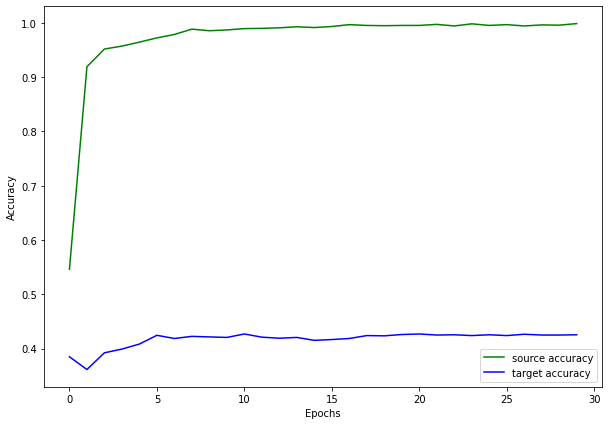

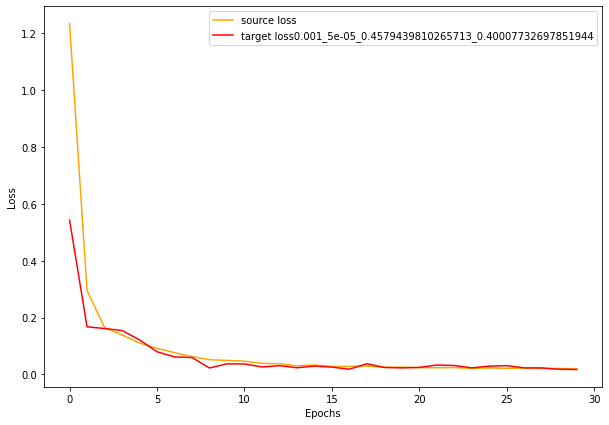

[(0.44930958934128284, 0.7705078125), (0.23546670377254486, 0.92236328125), (0.1816785386763513, 0.94140625), (0.13085268950089812, 0.95703125), (0.07387919910252094, 0.9716796875), (0.09737279172986746, 0.96484375), (0.06455380376428366, 0.97802734375), (0.052189408568665385, 0.982421875), (0.057027391623705626, 0.9814453125), (0.039809877751395106, 0.986328125), (0.03985151811502874, 0.98779296875), (0.03101253230124712, 0.99072265625), (0.035122056026011705, 0.98974609375), (0.02637198125012219, 0.99365234375), (0.0323300096206367, 0.9921875), (0.02512080839369446, 0.9912109375), (0.029839884722605348, 0.98974609375), (0.027186575112864375, 0.9912109375), (0.02556732704397291, 0.9921875), (0.020736007019877434, 0.99609375), (0.022863451042212546, 0.99267578125), (0.023791978135704994, 0.99267578125), (0.019163410761393607, 0.99462890625), (0.020476244390010834, 0.9951171875), (0.019434810732491314, 0.9951171875), (0.01716461917385459, 0.9970703125), (0.01661560812499374, 0.995605468

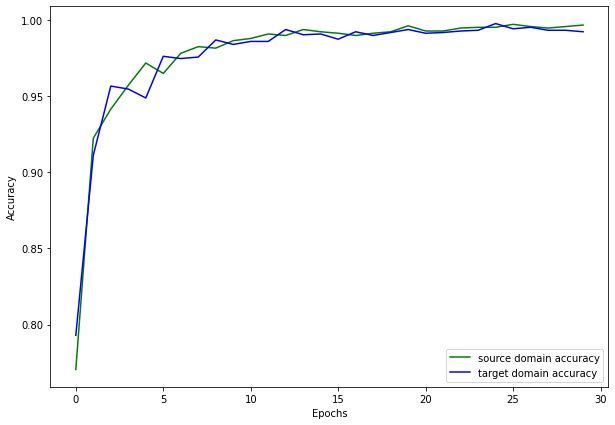

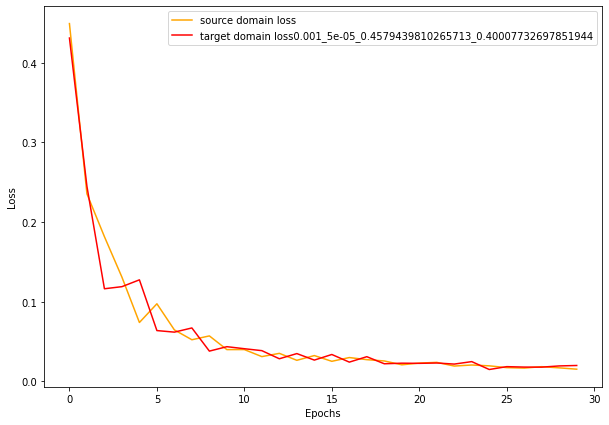

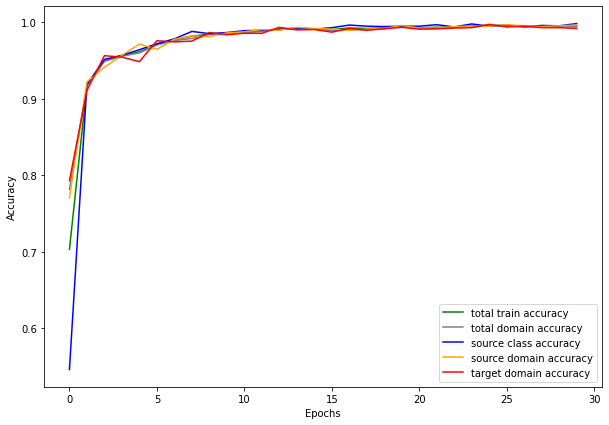

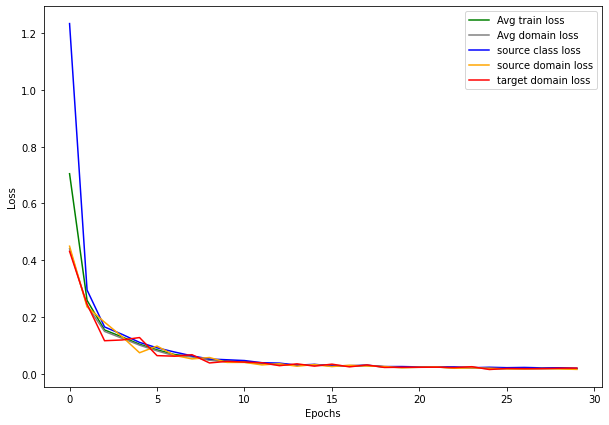

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Test Accuracy: 0.42529296875
Iteration 2 / 8
Starting epoch 1/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.9707, Train class Acc: 0.28
Target class Loss: 1.9806, Val class Acc: 0.18
Source domain Loss: 0.7712, Source domain Acc: 0.52
Target domain Loss: 0.7520, Target domain Acc: 0.54
Total train Loss: 1.1647, Total train Acc: 0.45
Total domain Loss: 0.7616, Total domain Acc: 0.53


Starting epoch 2/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 1.9003, Train class Acc: 0.32
Target class Loss: 1.8048, Val class Acc: 0.19
Source domain Loss: 0.7225, Source domain Acc: 0.56
Target domain Loss: 0.6688, Target domain Acc: 0.62
Total train Loss: 1.0972, Total train Acc: 0.50
Total domain Loss: 0.6956, Total domain Acc: 0.59


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.7772, Train class Acc: 0.41
Target class Loss: 1.7172, Val class Acc: 0.20
Source domain Loss: 0.6695, Source domain Acc: 0.62
Target domain Loss: 0.5506, Target domain Acc: 0.72
Total train Loss: 0.9991, Total train Acc: 0.58
Total domain Loss: 0.6100, Total domain Acc: 0.67


Starting epoch 4/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 1.6445, Train class Acc: 0.46
Target class Loss: 1.5823, Val class Acc: 0.22
Source domain Loss: 0.5946, Source domain Acc: 0.70
Target domain Loss: 0.4836, Target domain Acc: 0.79
Total train Loss: 0.9076, Total train Acc: 0.65
Total domain Loss: 0.5391, Total domain Acc: 0.74


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 1.5569, Train class Acc: 0.48
Target class Loss: 1.5636, Val class Acc: 0.23
Source domain Loss: 0.5502, Source domain Acc: 0.73
Target domain Loss: 0.4307, Target domain Acc: 0.82
Total train Loss: 0.8459, Total train Acc: 0.68
Total domain Loss: 0.4905, Total domain Acc: 0.77


Starting epoch 6/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 1.4613, Train class Acc: 0.51
Target class Loss: 1.4493, Val class Acc: 0.24
Source domain Loss: 0.4937, Source domain Acc: 0.76
Target domain Loss: 0.3995, Target domain Acc: 0.84
Total train Loss: 0.7848, Total train Acc: 0.70
Total domain Loss: 0.4466, Total domain Acc: 0.80


Starting epoch 7/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.3824, Train class Acc: 0.55
Target class Loss: 1.3716, Val class Acc: 0.25
Source domain Loss: 0.4395, Source domain Acc: 0.81
Target domain Loss: 0.3707, Target domain Acc: 0.85
Total train Loss: 0.7309, Total train Acc: 0.74
Total domain Loss: 0.4051, Total domain Acc: 0.83


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 1.3067, Train class Acc: 0.56
Target class Loss: 1.2576, Val class Acc: 0.26
Source domain Loss: 0.4252, Source domain Acc: 0.80
Target domain Loss: 0.3474, Target domain Acc: 0.86
Total train Loss: 0.6931, Total train Acc: 0.74
Total domain Loss: 0.3863, Total domain Acc: 0.83


Starting epoch 9/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.2466, Train class Acc: 0.57
Target class Loss: 1.1301, Val class Acc: 0.27
Source domain Loss: 0.3998, Source domain Acc: 0.83
Target domain Loss: 0.3384, Target domain Acc: 0.87
Total train Loss: 0.6616, Total train Acc: 0.76
Total domain Loss: 0.3691, Total domain Acc: 0.85


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.1844, Train class Acc: 0.59
Target class Loss: 1.0823, Val class Acc: 0.28
Source domain Loss: 0.3710, Source domain Acc: 0.85
Target domain Loss: 0.3186, Target domain Acc: 0.87
Total train Loss: 0.6247, Total train Acc: 0.77
Total domain Loss: 0.3448, Total domain Acc: 0.86


Starting epoch 11/30, LR = [3.948317124058427e-06]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Source class Loss: 1.1585, Train class Acc: 0.60
Target class Loss: 1.1840, Val class Acc: 0.29
Source domain Loss: 0.3675, Source domain Acc: 0.84
Target domain Loss: 0.3230, Target domain Acc: 0.87
Total train Loss: 0.6163, Total train Acc: 0.77
Total domain Loss: 0.3452, Total domain Acc: 0.85


Starting epoch 12/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 1.1367, Train class Acc: 0.62
Target class Loss: 1.1059, Val class Acc: 0.29
Source domain Loss: 0.3567, Source domain Acc: 0.85
Target domain Loss: 0.3105, Target domain Acc: 0.88
Total train Loss: 0.6013, Total train Acc: 0.78
Total domain Loss: 0.3336, Total domain Acc: 0.87


Starting epoch 13/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 1.1164, Train class Acc: 0.62
Target class Loss: 1.2092, Val class Acc: 0.29
Source domain Loss: 0.3513, Source domain Acc: 0.85
Target domain Loss: 0.3054, Target domain Acc: 0.88
Total train Loss: 0.5910, Total train Acc: 0.78
Total domain Loss: 0.3283, Total domain Acc: 0.86


Starting epoch 14/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 1.1174, Train class Acc: 0.61
Target class Loss: 1.1047, Val class Acc: 0.29
Source domain Loss: 0.3459, Source domain Acc: 0.85
Target domain Loss: 0.3048, Target domain Acc: 0.88
Total train Loss: 0.5894, Total train Acc: 0.78
Total domain Loss: 0.3253, Total domain Acc: 0.87


Starting epoch 15/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 1.0885, Train class Acc: 0.63
Target class Loss: 1.0328, Val class Acc: 0.29
Source domain Loss: 0.3422, Source domain Acc: 0.85
Target domain Loss: 0.3011, Target domain Acc: 0.88
Total train Loss: 0.5773, Total train Acc: 0.79
Total domain Loss: 0.3217, Total domain Acc: 0.86


Starting epoch 16/30, LR = [3.948317124058427e-06]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 1.0566, Train class Acc: 0.65
Target class Loss: 1.0762, Val class Acc: 0.29
Source domain Loss: 0.3230, Source domain Acc: 0.87
Target domain Loss: 0.3000, Target domain Acc: 0.89
Total train Loss: 0.5599, Total train Acc: 0.80
Total domain Loss: 0.3115, Total domain Acc: 0.88


Starting epoch 17/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 1.0497, Train class Acc: 0.64
Target class Loss: 0.9882, Val class Acc: 0.29
Source domain Loss: 0.3359, Source domain Acc: 0.85
Target domain Loss: 0.2960, Target domain Acc: 0.88
Total train Loss: 0.5605, Total train Acc: 0.79
Total domain Loss: 0.3160, Total domain Acc: 0.87


Starting epoch 18/30, LR = [3.948317124058427e-06]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 1.0271, Train class Acc: 0.66
Target class Loss: 1.0165, Val class Acc: 0.30
Source domain Loss: 0.3413, Source domain Acc: 0.86
Target domain Loss: 0.2861, Target domain Acc: 0.89
Total train Loss: 0.5515, Total train Acc: 0.80
Total domain Loss: 0.3137, Total domain Acc: 0.88


Starting epoch 19/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 1.0203, Train class Acc: 0.65
Target class Loss: 1.0686, Val class Acc: 0.30
Source domain Loss: 0.3165, Source domain Acc: 0.87
Target domain Loss: 0.2874, Target domain Acc: 0.88
Total train Loss: 0.5414, Total train Acc: 0.80
Total domain Loss: 0.3020, Total domain Acc: 0.88


Starting epoch 20/30, LR = [3.948317124058427e-06]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 1.0317, Train class Acc: 0.65
Target class Loss: 1.0539, Val class Acc: 0.30
Source domain Loss: 0.3267, Source domain Acc: 0.86
Target domain Loss: 0.2808, Target domain Acc: 0.89
Total train Loss: 0.5464, Total train Acc: 0.80
Total domain Loss: 0.3037, Total domain Acc: 0.88


Starting epoch 21/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.9818, Train class Acc: 0.68
Target class Loss: 0.9918, Val class Acc: 0.31
Source domain Loss: 0.3166, Source domain Acc: 0.87
Target domain Loss: 0.2837, Target domain Acc: 0.89
Total train Loss: 0.5274, Total train Acc: 0.81
Total domain Loss: 0.3002, Total domain Acc: 0.88


Starting epoch 22/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.9948, Train class Acc: 0.67
Target class Loss: 0.9665, Val class Acc: 0.31
Source domain Loss: 0.3212, Source domain Acc: 0.87
Target domain Loss: 0.2840, Target domain Acc: 0.89
Total train Loss: 0.5333, Total train Acc: 0.81
Total domain Loss: 0.3026, Total domain Acc: 0.88


Starting epoch 23/30, LR = [1.558920811213301e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.9934, Train class Acc: 0.67
Target class Loss: 1.0248, Val class Acc: 0.31
Source domain Loss: 0.3228, Source domain Acc: 0.86
Target domain Loss: 0.2825, Target domain Acc: 0.89
Total train Loss: 0.5329, Total train Acc: 0.81
Total domain Loss: 0.3026, Total domain Acc: 0.87


Starting epoch 24/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 0.9896, Train class Acc: 0.66
Target class Loss: 0.9494, Val class Acc: 0.31
Source domain Loss: 0.3151, Source domain Acc: 0.87
Target domain Loss: 0.2805, Target domain Acc: 0.89
Total train Loss: 0.5284, Total train Acc: 0.81
Total domain Loss: 0.2978, Total domain Acc: 0.88


Starting epoch 25/30, LR = [1.558920811213301e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.9872, Train class Acc: 0.67
Target class Loss: 1.0366, Val class Acc: 0.31
Source domain Loss: 0.3109, Source domain Acc: 0.88
Target domain Loss: 0.2774, Target domain Acc: 0.89
Total train Loss: 0.5251, Total train Acc: 0.81
Total domain Loss: 0.2941, Total domain Acc: 0.88


Starting epoch 26/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.9798, Train class Acc: 0.67
Target class Loss: 1.0630, Val class Acc: 0.31
Source domain Loss: 0.3183, Source domain Acc: 0.87
Target domain Loss: 0.2829, Target domain Acc: 0.89
Total train Loss: 0.5270, Total train Acc: 0.81
Total domain Loss: 0.3006, Total domain Acc: 0.88


Starting epoch 27/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 0.9789, Train class Acc: 0.67
Target class Loss: 0.9924, Val class Acc: 0.31
Source domain Loss: 0.3109, Source domain Acc: 0.87
Target domain Loss: 0.2804, Target domain Acc: 0.89
Total train Loss: 0.5234, Total train Acc: 0.81
Total domain Loss: 0.2957, Total domain Acc: 0.88


Starting epoch 28/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.9630, Train class Acc: 0.69
Target class Loss: 0.9685, Val class Acc: 0.31
Source domain Loss: 0.3036, Source domain Acc: 0.87
Target domain Loss: 0.2795, Target domain Acc: 0.88
Total train Loss: 0.5154, Total train Acc: 0.81
Total domain Loss: 0.2916, Total domain Acc: 0.88


Starting epoch 29/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.9462, Train class Acc: 0.69
Target class Loss: 0.9557, Val class Acc: 0.31
Source domain Loss: 0.3076, Source domain Acc: 0.87
Target domain Loss: 0.2710, Target domain Acc: 0.89
Total train Loss: 0.5082, Total train Acc: 0.82
Total domain Loss: 0.2893, Total domain Acc: 0.88


Starting epoch 30/30, LR = [1.558920811213301e-06]



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.9589, Train class Acc: 0.68
Target class Loss: 0.9691, Val class Acc: 0.31
Source domain Loss: 0.3005, Source domain Acc: 0.88
Target domain Loss: 0.2706, Target domain Acc: 0.89
Total train Loss: 0.5100, Total train Acc: 0.82
Total domain Loss: 0.2855, Total domain Acc: 0.89


[(1.9707383662462234, 0.2802734375), (1.9002543836832047, 0.3203125), (1.7772187143564224, 0.4091796875), (1.6444784700870514, 0.46337890625), (1.5568559914827347, 0.482421875), (1.4613060653209686, 0.5068359375), (1.3823982775211334, 0.548828125), (1.3067476153373718, 0.55810546875), (1.2465749830007553, 0.5712890625), (1.1844498217105865, 0.591796875), (1.1584955602884293, 0.59912109375), (1.1366952061653137, 0.6181640625), (1.1163685023784637, 0.6162109375), (1.117407500743866, 0.61181640625), (1.0884564369916916, 0.62939453125), (1.0566416755318642, 0.6494140625), (1.0496818572282791, 0.64013671875), (1.027073159813881, 0.65625), (1.020274668931961, 0.65087890625), (1.0317462384700775, 

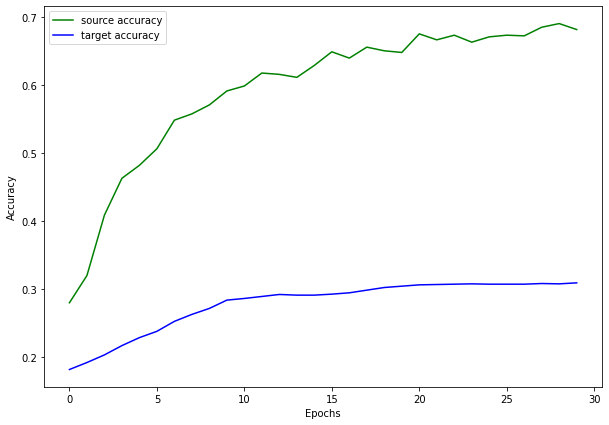

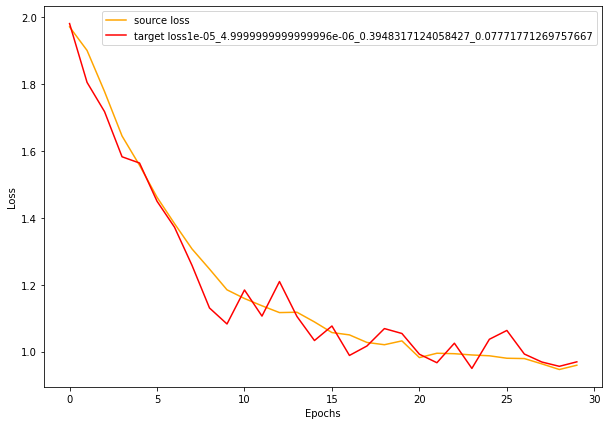

[(0.7712086513638496, 0.51806640625), (0.7225237041711807, 0.55908203125), (0.6694508567452431, 0.6220703125), (0.5946297273039818, 0.70068359375), (0.5501834228634834, 0.73193359375), (0.49369123578071594, 0.76318359375), (0.43948665633797646, 0.80712890625), (0.4251554235816002, 0.80322265625), (0.39977801218628883, 0.826171875), (0.3710181191563606, 0.849609375), (0.3675120174884796, 0.841796875), (0.3566836528480053, 0.84912109375), (0.35129930824041367, 0.849609375), (0.34589843079447746, 0.85498046875), (0.34223196282982826, 0.85205078125), (0.32295777276158333, 0.87158203125), (0.3359014317393303, 0.85400390625), (0.34126654639840126, 0.8623046875), (0.3165261372923851, 0.86865234375), (0.3266681246459484, 0.85888671875), (0.3166300393640995, 0.87109375), (0.3211589381098747, 0.87158203125), (0.3227994032204151, 0.8642578125), (0.3150918334722519, 0.86865234375), (0.31085609644651413, 0.876953125), (0.31825561821460724, 0.8662109375), (0.3108883872628212, 0.87060546875), (0.3036

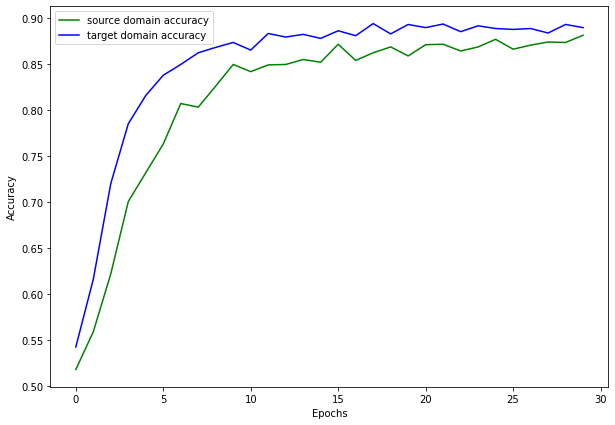

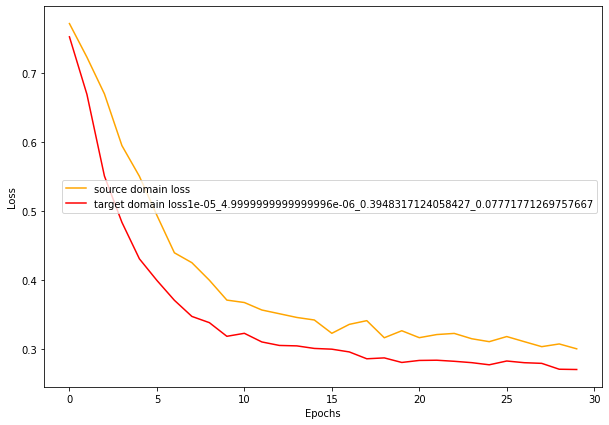

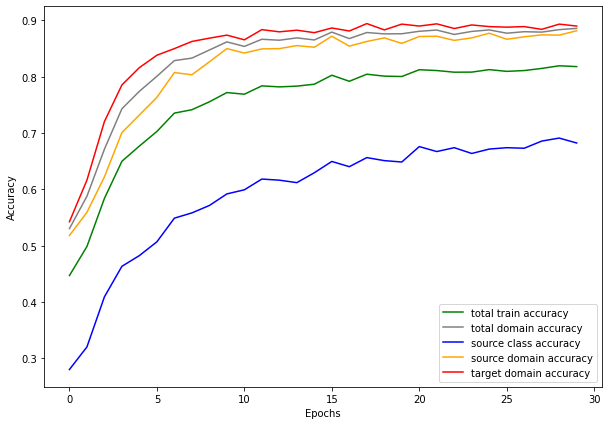

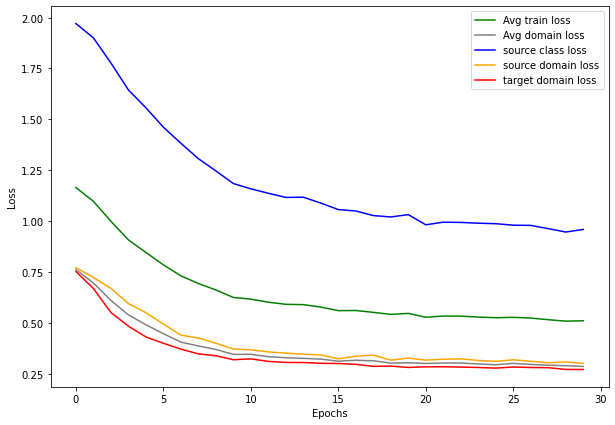

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Test Accuracy: 0.30810546875
Iteration 3 / 8
Starting epoch 1/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.2245, Train class Acc: 0.58
Target class Loss: 0.6012, Val class Acc: 0.38
Source domain Loss: 0.3975, Source domain Acc: 0.82
Target domain Loss: 0.3692, Target domain Acc: 0.83
Total train Loss: 0.6637, Total train Acc: 0.74
Total domain Loss: 0.3833, Total domain Acc: 0.82


Starting epoch 2/30, LR = [0.001]


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]



Source class Loss: 0.3006, Train class Acc: 0.91
Target class Loss: 0.1951, Val class Acc: 0.39
Source domain Loss: 0.1985, Source domain Acc: 0.93
Target domain Loss: 0.2175, Target domain Acc: 0.92
Total train Loss: 0.2389, Total train Acc: 0.92
Total domain Loss: 0.2080, Total domain Acc: 0.92


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 0.1590, Train class Acc: 0.95
Target class Loss: 0.1243, Val class Acc: 0.39
Source domain Loss: 0.1713, Source domain Acc: 0.95
Target domain Loss: 0.1317, Target domain Acc: 0.96
Total train Loss: 0.1540, Total train Acc: 0.95
Total domain Loss: 0.1515, Total domain Acc: 0.95


Starting epoch 4/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 0.1226, Train class Acc: 0.96
Target class Loss: 0.0998, Val class Acc: 0.40
Source domain Loss: 0.1125, Source domain Acc: 0.96
Target domain Loss: 0.1180, Target domain Acc: 0.96
Total train Loss: 0.1177, Total train Acc: 0.96
Total domain Loss: 0.1153, Total domain Acc: 0.96


Starting epoch 5/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.0920, Train class Acc: 0.97
Target class Loss: 0.0706, Val class Acc: 0.42
Source domain Loss: 0.0894, Source domain Acc: 0.97
Target domain Loss: 0.0944, Target domain Acc: 0.97
Total train Loss: 0.0919, Total train Acc: 0.97
Total domain Loss: 0.0919, Total domain Acc: 0.97


Starting epoch 6/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Source class Loss: 0.0839, Train class Acc: 0.97
Target class Loss: 0.0824, Val class Acc: 0.44
Source domain Loss: 0.0830, Source domain Acc: 0.97
Target domain Loss: 0.0605, Target domain Acc: 0.98
Total train Loss: 0.0758, Total train Acc: 0.97
Total domain Loss: 0.0718, Total domain Acc: 0.97


Starting epoch 7/30, LR = [0.001]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 0.0702, Train class Acc: 0.98
Target class Loss: 0.0762, Val class Acc: 0.43
Source domain Loss: 0.0582, Source domain Acc: 0.98
Target domain Loss: 0.0729, Target domain Acc: 0.97
Total train Loss: 0.0671, Total train Acc: 0.98
Total domain Loss: 0.0655, Total domain Acc: 0.97


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.0598, Train class Acc: 0.98
Target class Loss: 0.0542, Val class Acc: 0.44
Source domain Loss: 0.0539, Source domain Acc: 0.98
Target domain Loss: 0.0505, Target domain Acc: 0.98
Total train Loss: 0.0547, Total train Acc: 0.98
Total domain Loss: 0.0522, Total domain Acc: 0.98


Starting epoch 9/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 0.0492, Train class Acc: 0.99
Target class Loss: 0.0513, Val class Acc: 0.42
Source domain Loss: 0.0476, Source domain Acc: 0.98
Target domain Loss: 0.0498, Target domain Acc: 0.98
Total train Loss: 0.0489, Total train Acc: 0.99
Total domain Loss: 0.0487, Total domain Acc: 0.98


Starting epoch 10/30, LR = [0.001]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 0.0475, Train class Acc: 0.99
Target class Loss: 0.0373, Val class Acc: 0.42
Source domain Loss: 0.0430, Source domain Acc: 0.98
Target domain Loss: 0.0435, Target domain Acc: 0.99
Total train Loss: 0.0447, Total train Acc: 0.99
Total domain Loss: 0.0433, Total domain Acc: 0.99


Starting epoch 11/30, LR = [0.00029026623517199984]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.0391, Train class Acc: 0.99
Target class Loss: 0.0300, Val class Acc: 0.42
Source domain Loss: 0.0344, Source domain Acc: 0.99
Target domain Loss: 0.0359, Target domain Acc: 0.99
Total train Loss: 0.0364, Total train Acc: 0.99
Total domain Loss: 0.0351, Total domain Acc: 0.99


Starting epoch 12/30, LR = [0.00029026623517199984]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.0355, Train class Acc: 0.99
Target class Loss: 0.0267, Val class Acc: 0.42
Source domain Loss: 0.0339, Source domain Acc: 0.99
Target domain Loss: 0.0294, Target domain Acc: 0.99
Total train Loss: 0.0330, Total train Acc: 0.99
Total domain Loss: 0.0317, Total domain Acc: 0.99


Starting epoch 13/30, LR = [0.00029026623517199984]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.0304, Train class Acc: 0.99
Target class Loss: 0.0400, Val class Acc: 0.42
Source domain Loss: 0.0271, Source domain Acc: 0.99
Target domain Loss: 0.0321, Target domain Acc: 0.99
Total train Loss: 0.0299, Total train Acc: 0.99
Total domain Loss: 0.0296, Total domain Acc: 0.99


Starting epoch 14/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.0331, Train class Acc: 0.99
Target class Loss: 0.0380, Val class Acc: 0.43
Source domain Loss: 0.0335, Source domain Acc: 0.99
Target domain Loss: 0.0337, Target domain Acc: 0.99
Total train Loss: 0.0334, Total train Acc: 0.99
Total domain Loss: 0.0336, Total domain Acc: 0.99


Starting epoch 15/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0322, Train class Acc: 0.99
Target class Loss: 0.0298, Val class Acc: 0.43
Source domain Loss: 0.0246, Source domain Acc: 0.99
Target domain Loss: 0.0319, Target domain Acc: 0.99
Total train Loss: 0.0295, Total train Acc: 0.99
Total domain Loss: 0.0282, Total domain Acc: 0.99


Starting epoch 16/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0267, Train class Acc: 1.00
Target class Loss: 0.0218, Val class Acc: 0.43
Source domain Loss: 0.0361, Source domain Acc: 0.99
Target domain Loss: 0.0286, Target domain Acc: 0.99
Total train Loss: 0.0305, Total train Acc: 0.99
Total domain Loss: 0.0324, Total domain Acc: 0.99


Starting epoch 17/30, LR = [0.00029026623517199984]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.0288, Train class Acc: 0.99
Target class Loss: 0.0396, Val class Acc: 0.43
Source domain Loss: 0.0251, Source domain Acc: 0.99
Target domain Loss: 0.0371, Target domain Acc: 0.99
Total train Loss: 0.0304, Total train Acc: 0.99
Total domain Loss: 0.0311, Total domain Acc: 0.99


Starting epoch 18/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0280, Train class Acc: 0.99
Target class Loss: 0.0396, Val class Acc: 0.43
Source domain Loss: 0.0357, Source domain Acc: 0.99
Target domain Loss: 0.0294, Target domain Acc: 0.99
Total train Loss: 0.0310, Total train Acc: 0.99
Total domain Loss: 0.0325, Total domain Acc: 0.99


Starting epoch 19/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0286, Train class Acc: 0.99
Target class Loss: 0.0283, Val class Acc: 0.42
Source domain Loss: 0.0258, Source domain Acc: 0.99
Target domain Loss: 0.0310, Target domain Acc: 0.99
Total train Loss: 0.0285, Total train Acc: 0.99
Total domain Loss: 0.0284, Total domain Acc: 0.99


Starting epoch 20/30, LR = [0.00029026623517199984]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0269, Train class Acc: 1.00
Target class Loss: 0.0367, Val class Acc: 0.42
Source domain Loss: 0.0263, Source domain Acc: 0.99
Target domain Loss: 0.0271, Target domain Acc: 0.99
Total train Loss: 0.0268, Total train Acc: 0.99
Total domain Loss: 0.0267, Total domain Acc: 0.99


Starting epoch 21/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.0246, Train class Acc: 1.00
Target class Loss: 0.0120, Val class Acc: 0.43
Source domain Loss: 0.0280, Source domain Acc: 0.99
Target domain Loss: 0.0223, Target domain Acc: 0.99
Total train Loss: 0.0249, Total train Acc: 0.99
Total domain Loss: 0.0251, Total domain Acc: 0.99


Starting epoch 22/30, LR = [8.425448728092672e-05]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.0239, Train class Acc: 0.99
Target class Loss: 0.0191, Val class Acc: 0.42
Source domain Loss: 0.0219, Source domain Acc: 1.00
Target domain Loss: 0.0269, Target domain Acc: 0.99
Total train Loss: 0.0242, Total train Acc: 0.99
Total domain Loss: 0.0244, Total domain Acc: 0.99


Starting epoch 23/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0271, Train class Acc: 0.99
Target class Loss: 0.0404, Val class Acc: 0.43
Source domain Loss: 0.0237, Source domain Acc: 0.99
Target domain Loss: 0.0237, Target domain Acc: 0.99
Total train Loss: 0.0248, Total train Acc: 0.99
Total domain Loss: 0.0237, Total domain Acc: 0.99


Starting epoch 24/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0268, Train class Acc: 0.99
Target class Loss: 0.0129, Val class Acc: 0.43
Source domain Loss: 0.0248, Source domain Acc: 0.99
Target domain Loss: 0.0251, Target domain Acc: 0.99
Total train Loss: 0.0256, Total train Acc: 0.99
Total domain Loss: 0.0250, Total domain Acc: 0.99


Starting epoch 25/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0226, Train class Acc: 1.00
Target class Loss: 0.0327, Val class Acc: 0.43
Source domain Loss: 0.0221, Source domain Acc: 0.99
Target domain Loss: 0.0272, Target domain Acc: 0.99
Total train Loss: 0.0239, Total train Acc: 0.99
Total domain Loss: 0.0246, Total domain Acc: 0.99


Starting epoch 26/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0286, Train class Acc: 0.99
Target class Loss: 0.0384, Val class Acc: 0.42
Source domain Loss: 0.0273, Source domain Acc: 0.99
Target domain Loss: 0.0237, Target domain Acc: 0.99
Total train Loss: 0.0265, Total train Acc: 0.99
Total domain Loss: 0.0255, Total domain Acc: 0.99


Starting epoch 27/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0248, Train class Acc: 1.00
Target class Loss: 0.0243, Val class Acc: 0.43
Source domain Loss: 0.0247, Source domain Acc: 0.99
Target domain Loss: 0.0267, Target domain Acc: 0.99
Total train Loss: 0.0254, Total train Acc: 0.99
Total domain Loss: 0.0257, Total domain Acc: 0.99


Starting epoch 28/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0224, Train class Acc: 0.99
Target class Loss: 0.0180, Val class Acc: 0.43
Source domain Loss: 0.0241, Source domain Acc: 0.99
Target domain Loss: 0.0220, Target domain Acc: 0.99
Total train Loss: 0.0228, Total train Acc: 0.99
Total domain Loss: 0.0230, Total domain Acc: 0.99


Starting epoch 29/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0253, Train class Acc: 0.99
Target class Loss: 0.0252, Val class Acc: 0.43
Source domain Loss: 0.0245, Source domain Acc: 0.99
Target domain Loss: 0.0223, Target domain Acc: 0.99
Total train Loss: 0.0240, Total train Acc: 0.99
Total domain Loss: 0.0234, Total domain Acc: 0.99


Starting epoch 30/30, LR = [8.425448728092672e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0243, Train class Acc: 1.00
Target class Loss: 0.0286, Val class Acc: 0.42
Source domain Loss: 0.0260, Source domain Acc: 0.99
Target domain Loss: 0.0238, Target domain Acc: 0.99
Total train Loss: 0.0247, Total train Acc: 0.99
Total domain Loss: 0.0249, Total domain Acc: 0.99


[(1.224537506699562, 0.5771484375), (0.3006386701017618, 0.91162109375), (0.1590280495584011, 0.95166015625), (0.12256462126970291, 0.9609375), (0.09203811455518007, 0.97119140625), (0.08388753980398178, 0.97314453125), (0.07020530756562948, 0.97900390625), (0.059843618888407946, 0.98193359375), (0.04921041801571846, 0.98828125), (0.047450289130210876, 0.98681640625), (0.039050266379490495, 0.99169921875), (0.0354986775200814, 0.99072265625), (0.0304294612724334, 0.99365234375), (0.033127445727586746, 0.994140625), (0.03222197340801358, 0.9931640625), (0.026745829731225967, 0.99658203125), (0.02883892855606973, 0.99365234375), (0.02804460283368826, 0.99462890625), (0.028592384071089327, 0.9

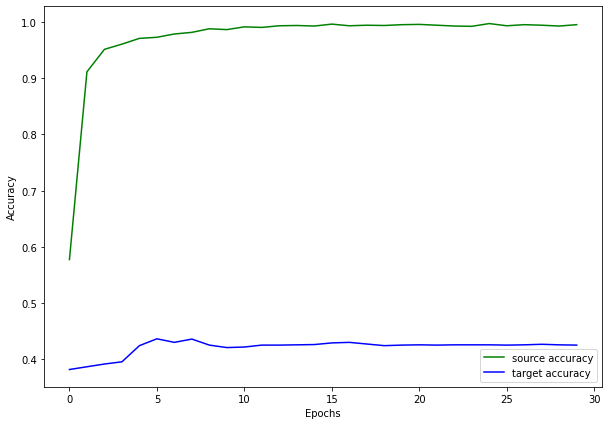

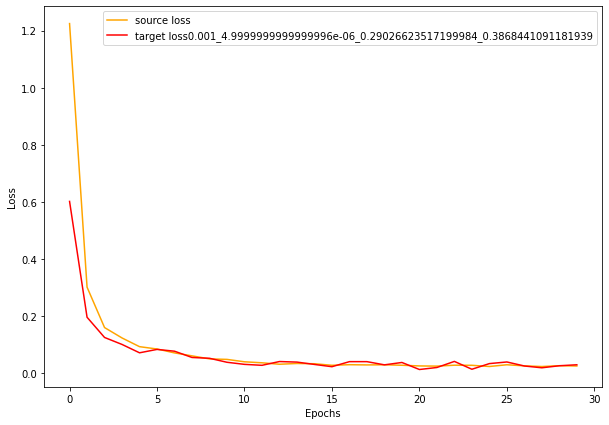

[(0.3974834457039833, 0.8154296875), (0.19850684236735106, 0.927734375), (0.17130156140774488, 0.94921875), (0.11251082830131054, 0.96337890625), (0.08937763655558228, 0.97216796875), (0.08303485298529267, 0.9697265625), (0.05819782381877303, 0.97607421875), (0.05390252103097737, 0.98095703125), (0.04761244589462876, 0.98193359375), (0.04301827005110681, 0.98486328125), (0.03436409356072545, 0.99072265625), (0.03394998190924525, 0.98681640625), (0.027111182222142816, 0.994140625), (0.03346196748316288, 0.98876953125), (0.024571762653067708, 0.99462890625), (0.03611426427960396, 0.98681640625), (0.02514268015511334, 0.9921875), (0.035699725267477334, 0.986328125), (0.02584792918059975, 0.98974609375), (0.026325769955292344, 0.99169921875), (0.027962739346548915, 0.98974609375), (0.021921022329479456, 0.9970703125), (0.02373341133352369, 0.99365234375), (0.02478894591331482, 0.990234375), (0.022063307813368738, 0.994140625), (0.0272691089194268, 0.9912109375), (0.024672572733834386, 0.99

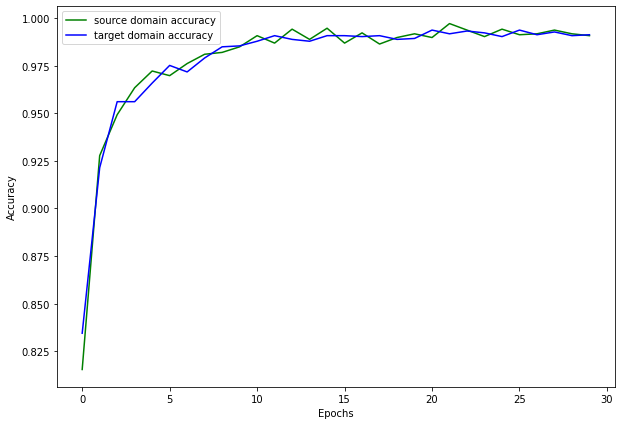

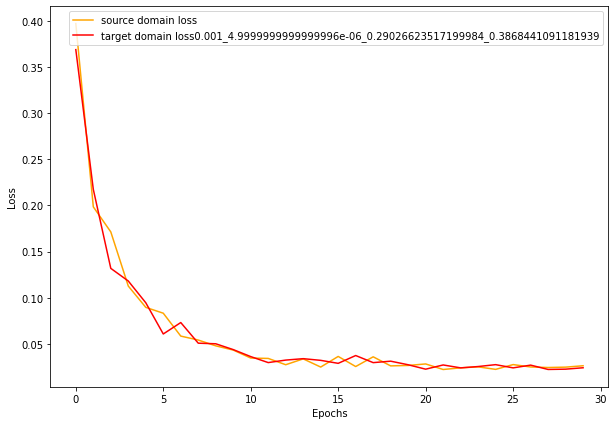

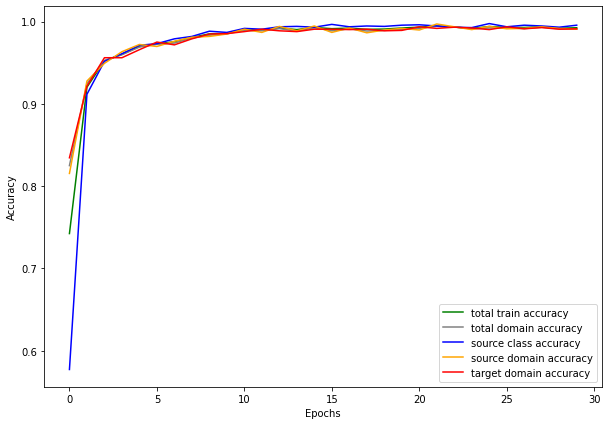

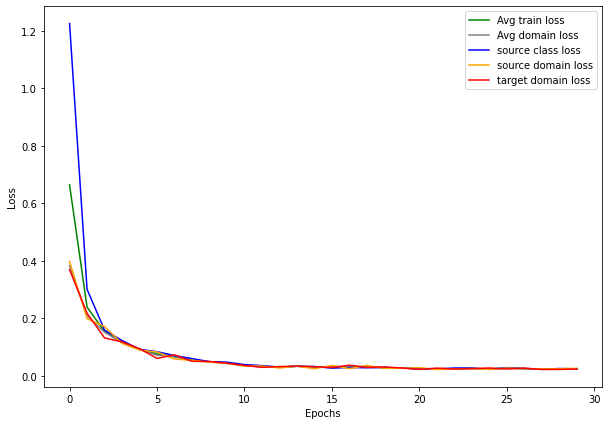

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Test Accuracy: 0.42529296875
Iteration 4 / 8
Starting epoch 1/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 2.0741, Train class Acc: 0.16
Target class Loss: 2.0889, Val class Acc: 0.13
Source domain Loss: 0.3727, Source domain Acc: 0.89
Target domain Loss: 1.1367, Target domain Acc: 0.24
Total train Loss: 1.1945, Total train Acc: 0.43
Total domain Loss: 0.7547, Total domain Acc: 0.57


Starting epoch 2/30, LR = [1e-05]


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]



Source class Loss: 1.9648, Train class Acc: 0.20
Target class Loss: 1.8983, Val class Acc: 0.13
Source domain Loss: 0.4150, Source domain Acc: 0.85
Target domain Loss: 0.8931, Target domain Acc: 0.42
Total train Loss: 1.0909, Total train Acc: 0.49
Total domain Loss: 0.6540, Total domain Acc: 0.63


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.8215, Train class Acc: 0.28
Target class Loss: 1.7232, Val class Acc: 0.14
Source domain Loss: 0.4600, Source domain Acc: 0.81
Target domain Loss: 0.6505, Target domain Acc: 0.63
Total train Loss: 0.9773, Total train Acc: 0.57
Total domain Loss: 0.5553, Total domain Acc: 0.72


Starting epoch 4/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.6920, Train class Acc: 0.41
Target class Loss: 1.6689, Val class Acc: 0.15
Source domain Loss: 0.4822, Source domain Acc: 0.78
Target domain Loss: 0.4919, Target domain Acc: 0.78
Total train Loss: 0.8887, Total train Acc: 0.66
Total domain Loss: 0.4871, Total domain Acc: 0.78


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.5591, Train class Acc: 0.50
Target class Loss: 1.4859, Val class Acc: 0.16
Source domain Loss: 0.4862, Source domain Acc: 0.78
Target domain Loss: 0.4072, Target domain Acc: 0.84
Total train Loss: 0.8175, Total train Acc: 0.71
Total domain Loss: 0.4467, Total domain Acc: 0.81


Starting epoch 6/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.4573, Train class Acc: 0.56
Target class Loss: 1.4007, Val class Acc: 0.17
Source domain Loss: 0.4692, Source domain Acc: 0.79
Target domain Loss: 0.3689, Target domain Acc: 0.86
Total train Loss: 0.7651, Total train Acc: 0.73
Total domain Loss: 0.4190, Total domain Acc: 0.82


Starting epoch 7/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.3434, Train class Acc: 0.60
Target class Loss: 1.2599, Val class Acc: 0.19
Source domain Loss: 0.4373, Source domain Acc: 0.81
Target domain Loss: 0.3438, Target domain Acc: 0.87
Total train Loss: 0.7081, Total train Acc: 0.76
Total domain Loss: 0.3905, Total domain Acc: 0.84


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.2585, Train class Acc: 0.62
Target class Loss: 1.2012, Val class Acc: 0.19
Source domain Loss: 0.4110, Source domain Acc: 0.81
Target domain Loss: 0.3314, Target domain Acc: 0.87
Total train Loss: 0.6670, Total train Acc: 0.77
Total domain Loss: 0.3712, Total domain Acc: 0.84


Starting epoch 9/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.1991, Train class Acc: 0.63
Target class Loss: 1.1852, Val class Acc: 0.21
Source domain Loss: 0.3985, Source domain Acc: 0.83
Target domain Loss: 0.3197, Target domain Acc: 0.88
Total train Loss: 0.6391, Total train Acc: 0.78
Total domain Loss: 0.3591, Total domain Acc: 0.85


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Source class Loss: 1.1441, Train class Acc: 0.65
Target class Loss: 1.1923, Val class Acc: 0.21
Source domain Loss: 0.3726, Source domain Acc: 0.84
Target domain Loss: 0.3086, Target domain Acc: 0.88
Total train Loss: 0.6084, Total train Acc: 0.79
Total domain Loss: 0.3406, Total domain Acc: 0.86


Starting epoch 11/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 1.0963, Train class Acc: 0.66
Target class Loss: 1.1263, Val class Acc: 0.21
Source domain Loss: 0.3650, Source domain Acc: 0.84
Target domain Loss: 0.2948, Target domain Acc: 0.89
Total train Loss: 0.5854, Total train Acc: 0.80
Total domain Loss: 0.3299, Total domain Acc: 0.87


Starting epoch 12/30, LR = [1.7270455990182665e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.0800, Train class Acc: 0.68
Target class Loss: 1.0605, Val class Acc: 0.21
Source domain Loss: 0.3512, Source domain Acc: 0.86
Target domain Loss: 0.3022, Target domain Acc: 0.88
Total train Loss: 0.5778, Total train Acc: 0.81
Total domain Loss: 0.3267, Total domain Acc: 0.87


Starting epoch 13/30, LR = [1.7270455990182665e-06]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Source class Loss: 1.0888, Train class Acc: 0.66
Target class Loss: 1.0656, Val class Acc: 0.21
Source domain Loss: 0.3565, Source domain Acc: 0.84
Target domain Loss: 0.2986, Target domain Acc: 0.89
Total train Loss: 0.5813, Total train Acc: 0.80
Total domain Loss: 0.3275, Total domain Acc: 0.86


Starting epoch 14/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 1.0637, Train class Acc: 0.67
Target class Loss: 1.0453, Val class Acc: 0.21
Source domain Loss: 0.3475, Source domain Acc: 0.86
Target domain Loss: 0.3066, Target domain Acc: 0.88
Total train Loss: 0.5726, Total train Acc: 0.80
Total domain Loss: 0.3271, Total domain Acc: 0.87


Starting epoch 15/30, LR = [1.7270455990182665e-06]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 1.0624, Train class Acc: 0.68
Target class Loss: 1.0992, Val class Acc: 0.22
Source domain Loss: 0.3483, Source domain Acc: 0.85
Target domain Loss: 0.3061, Target domain Acc: 0.89
Total train Loss: 0.5723, Total train Acc: 0.80
Total domain Loss: 0.3272, Total domain Acc: 0.87


Starting epoch 16/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 1.0512, Train class Acc: 0.68
Target class Loss: 1.0557, Val class Acc: 0.22
Source domain Loss: 0.3513, Source domain Acc: 0.85
Target domain Loss: 0.2984, Target domain Acc: 0.89
Total train Loss: 0.5670, Total train Acc: 0.81
Total domain Loss: 0.3249, Total domain Acc: 0.87


Starting epoch 17/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 1.0466, Train class Acc: 0.68
Target class Loss: 1.0580, Val class Acc: 0.22
Source domain Loss: 0.3430, Source domain Acc: 0.85
Target domain Loss: 0.2981, Target domain Acc: 0.88
Total train Loss: 0.5626, Total train Acc: 0.80
Total domain Loss: 0.3206, Total domain Acc: 0.87


Starting epoch 18/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 1.0415, Train class Acc: 0.67
Target class Loss: 1.0530, Val class Acc: 0.22
Source domain Loss: 0.3526, Source domain Acc: 0.85
Target domain Loss: 0.2993, Target domain Acc: 0.89
Total train Loss: 0.5645, Total train Acc: 0.80
Total domain Loss: 0.3260, Total domain Acc: 0.87


Starting epoch 19/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 1.0307, Train class Acc: 0.68
Target class Loss: 1.0702, Val class Acc: 0.23
Source domain Loss: 0.3399, Source domain Acc: 0.86
Target domain Loss: 0.2939, Target domain Acc: 0.89
Total train Loss: 0.5548, Total train Acc: 0.81
Total domain Loss: 0.3169, Total domain Acc: 0.88


Starting epoch 20/30, LR = [1.7270455990182665e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 1.0200, Train class Acc: 0.69
Target class Loss: 1.0059, Val class Acc: 0.23
Source domain Loss: 0.3430, Source domain Acc: 0.86
Target domain Loss: 0.2924, Target domain Acc: 0.89
Total train Loss: 0.5518, Total train Acc: 0.82
Total domain Loss: 0.3177, Total domain Acc: 0.88


Starting epoch 21/30, LR = [2.982686501088363e-07]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 1.0037, Train class Acc: 0.71
Target class Loss: 1.0133, Val class Acc: 0.23
Source domain Loss: 0.3355, Source domain Acc: 0.86
Target domain Loss: 0.2924, Target domain Acc: 0.89
Total train Loss: 0.5439, Total train Acc: 0.82
Total domain Loss: 0.3140, Total domain Acc: 0.87


Starting epoch 22/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 1.0242, Train class Acc: 0.69
Target class Loss: 1.1241, Val class Acc: 0.23
Source domain Loss: 0.3434, Source domain Acc: 0.85
Target domain Loss: 0.2939, Target domain Acc: 0.89
Total train Loss: 0.5538, Total train Acc: 0.81
Total domain Loss: 0.3186, Total domain Acc: 0.87


Starting epoch 23/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 1.0194, Train class Acc: 0.69
Target class Loss: 0.9882, Val class Acc: 0.23
Source domain Loss: 0.3373, Source domain Acc: 0.86
Target domain Loss: 0.2885, Target domain Acc: 0.89
Total train Loss: 0.5484, Total train Acc: 0.81
Total domain Loss: 0.3129, Total domain Acc: 0.88


Starting epoch 24/30, LR = [2.982686501088363e-07]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 1.0091, Train class Acc: 0.69
Target class Loss: 1.0348, Val class Acc: 0.23
Source domain Loss: 0.3286, Source domain Acc: 0.86
Target domain Loss: 0.2908, Target domain Acc: 0.89
Total train Loss: 0.5428, Total train Acc: 0.82
Total domain Loss: 0.3097, Total domain Acc: 0.88


Starting epoch 25/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 1.0056, Train class Acc: 0.69
Target class Loss: 0.9677, Val class Acc: 0.23
Source domain Loss: 0.3333, Source domain Acc: 0.86
Target domain Loss: 0.2939, Target domain Acc: 0.89
Total train Loss: 0.5443, Total train Acc: 0.81
Total domain Loss: 0.3136, Total domain Acc: 0.87


Starting epoch 26/30, LR = [2.982686501088363e-07]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.9982, Train class Acc: 0.69
Target class Loss: 1.0164, Val class Acc: 0.23
Source domain Loss: 0.3402, Source domain Acc: 0.85
Target domain Loss: 0.2936, Target domain Acc: 0.88
Total train Loss: 0.5440, Total train Acc: 0.81
Total domain Loss: 0.3169, Total domain Acc: 0.87


Starting epoch 27/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 1.0047, Train class Acc: 0.70
Target class Loss: 1.0127, Val class Acc: 0.23
Source domain Loss: 0.3335, Source domain Acc: 0.86
Target domain Loss: 0.2907, Target domain Acc: 0.89
Total train Loss: 0.5429, Total train Acc: 0.82
Total domain Loss: 0.3121, Total domain Acc: 0.88


Starting epoch 28/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 1.0104, Train class Acc: 0.69
Target class Loss: 0.9898, Val class Acc: 0.23
Source domain Loss: 0.3305, Source domain Acc: 0.87
Target domain Loss: 0.2906, Target domain Acc: 0.89
Total train Loss: 0.5438, Total train Acc: 0.82
Total domain Loss: 0.3105, Total domain Acc: 0.88


Starting epoch 29/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 1.0064, Train class Acc: 0.70
Target class Loss: 1.0241, Val class Acc: 0.23
Source domain Loss: 0.3450, Source domain Acc: 0.85
Target domain Loss: 0.2887, Target domain Acc: 0.89
Total train Loss: 0.5467, Total train Acc: 0.81
Total domain Loss: 0.3168, Total domain Acc: 0.87


Starting epoch 30/30, LR = [2.982686501088363e-07]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 1.0071, Train class Acc: 0.70
Target class Loss: 0.9505, Val class Acc: 0.23
Source domain Loss: 0.3358, Source domain Acc: 0.86
Target domain Loss: 0.2896, Target domain Acc: 0.90
Total train Loss: 0.5442, Total train Acc: 0.82
Total domain Loss: 0.3127, Total domain Acc: 0.88


[(2.0740698873996735, 0.15576171875), (1.9647773802280426, 0.1953125), (1.8214595019817352, 0.283203125), (1.6919995844364166, 0.41357421875), (1.5591183602809906, 0.5009765625), (1.4573417752981186, 0.55615234375), (1.3433987200260162, 0.59716796875), (1.2584808468818665, 0.61767578125), (1.19914810359478, 0.634765625), (1.144080489873886, 0.65087890625), (1.0962597876787186, 0.66162109375), (1.0800486654043198, 0.6787109375), (1.0887728333473206, 0.6591796875), (1.0636961087584496, 0.67138671875), (1.062408372759819, 0.67578125), (1.0512118116021156, 0.68310546875), (1.0466447249054909, 0.6767578125), (1.0414983928203583, 0.6748046875), (1.0307185426354408, 0.681640625), (1.01997229456901

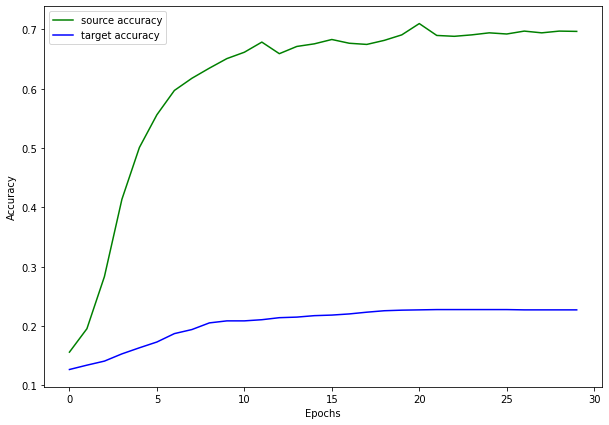

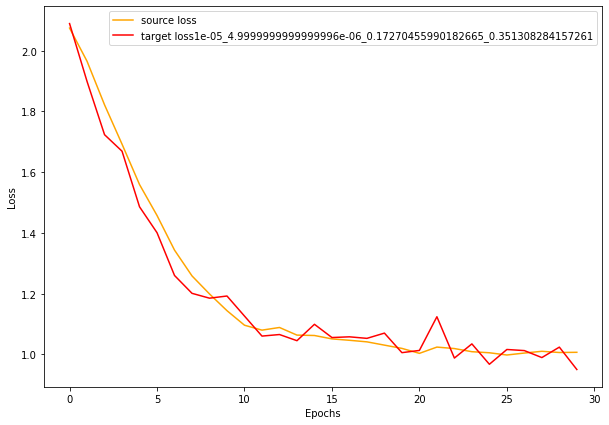

[(0.3727104105055332, 0.88818359375), (0.4149823375046253, 0.8486328125), (0.46000733971595764, 0.81201171875), (0.48220406472682953, 0.78173828125), (0.486235897988081, 0.7802734375), (0.4691874720156193, 0.78857421875), (0.4372589737176895, 0.8076171875), (0.41104551404714584, 0.8095703125), (0.3985367454588413, 0.83056640625), (0.37257665023207664, 0.84375), (0.36495162546634674, 0.84423828125), (0.3512076810002327, 0.85595703125), (0.3564988821744919, 0.84130859375), (0.3475136049091816, 0.861328125), (0.3483238108456135, 0.85205078125), (0.35132328420877457, 0.85302734375), (0.3429710492491722, 0.85009765625), (0.35257743671536446, 0.84814453125), (0.3399204611778259, 0.85888671875), (0.34303733333945274, 0.86376953125), (0.33547336980700493, 0.85595703125), (0.34336065873503685, 0.8525390625), (0.33733347058296204, 0.85986328125), (0.32860882207751274, 0.86328125), (0.33328748494386673, 0.86181640625), (0.3401663415133953, 0.85107421875), (0.33346034958958626, 0.86083984375), (0.

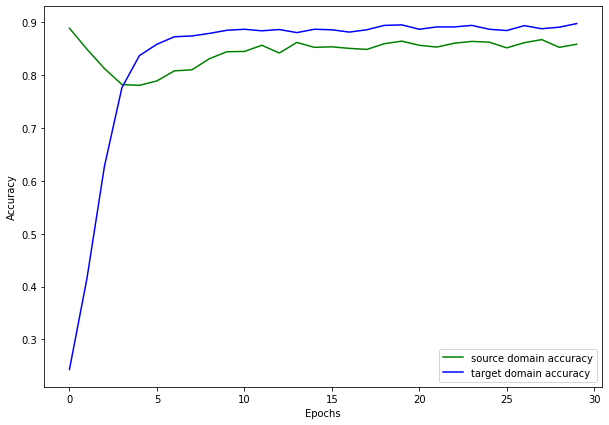

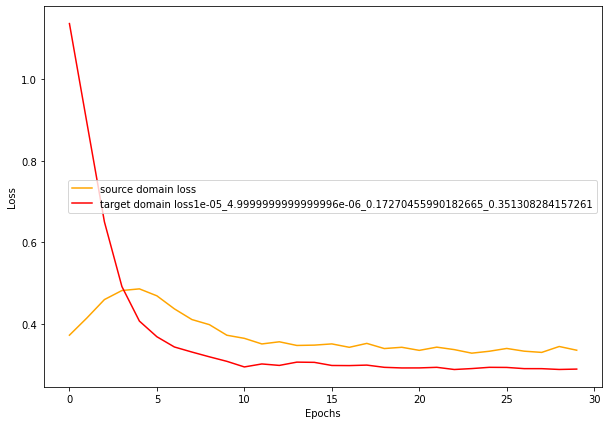

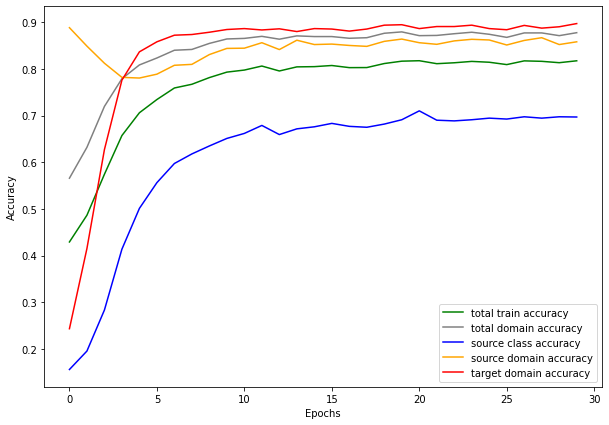

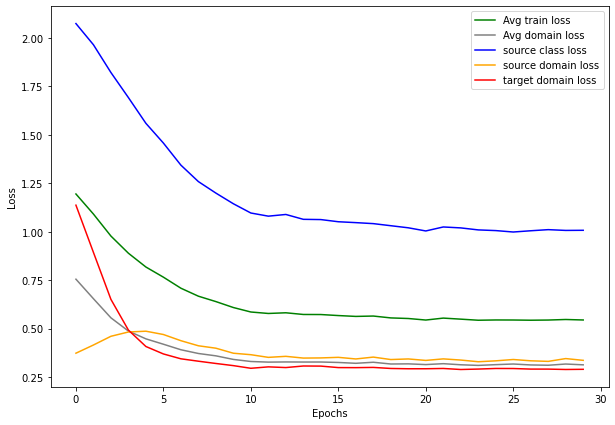

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Test Accuracy: 0.22705078125
Iteration 5 / 8
Starting epoch 1/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 1.9199, Train class Acc: 0.23
Target class Loss: 1.6160, Val class Acc: 0.21
Source domain Loss: 0.8871, Source domain Acc: 0.48
Target domain Loss: 0.6866, Target domain Acc: 0.60
Total train Loss: 1.1645, Total train Acc: 0.44
Total domain Loss: 0.7868, Total domain Acc: 0.54


Starting epoch 2/30, LR = [0.0001]


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]



Source class Loss: 1.2524, Train class Acc: 0.60
Target class Loss: 1.0226, Val class Acc: 0.32
Source domain Loss: 0.4150, Source domain Acc: 0.81
Target domain Loss: 0.3706, Target domain Acc: 0.84
Total train Loss: 0.6794, Total train Acc: 0.75
Total domain Loss: 0.3928, Total domain Acc: 0.82


Starting epoch 3/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.8441, Train class Acc: 0.74
Target class Loss: 0.7053, Val class Acc: 0.37
Source domain Loss: 0.2430, Source domain Acc: 0.91
Target domain Loss: 0.2754, Target domain Acc: 0.88
Total train Loss: 0.4541, Total train Acc: 0.84
Total domain Loss: 0.2592, Total domain Acc: 0.89


Starting epoch 4/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.6452, Train class Acc: 0.82
Target class Loss: 0.5951, Val class Acc: 0.40
Source domain Loss: 0.2269, Source domain Acc: 0.91
Target domain Loss: 0.2034, Target domain Acc: 0.91
Total train Loss: 0.3585, Total train Acc: 0.88
Total domain Loss: 0.2152, Total domain Acc: 0.91


Starting epoch 5/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.5253, Train class Acc: 0.85
Target class Loss: 0.4929, Val class Acc: 0.42
Source domain Loss: 0.2014, Source domain Acc: 0.92
Target domain Loss: 0.1686, Target domain Acc: 0.93
Total train Loss: 0.2984, Total train Acc: 0.90
Total domain Loss: 0.1850, Total domain Acc: 0.93


Starting epoch 6/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.4200, Train class Acc: 0.89
Target class Loss: 0.4265, Val class Acc: 0.42
Source domain Loss: 0.1863, Source domain Acc: 0.92
Target domain Loss: 0.1600, Target domain Acc: 0.93
Total train Loss: 0.2554, Total train Acc: 0.91
Total domain Loss: 0.1732, Total domain Acc: 0.93


Starting epoch 7/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 0.3576, Train class Acc: 0.90
Target class Loss: 0.3353, Val class Acc: 0.43
Source domain Loss: 0.1604, Source domain Acc: 0.94
Target domain Loss: 0.1625, Target domain Acc: 0.93
Total train Loss: 0.2269, Total train Acc: 0.93
Total domain Loss: 0.1615, Total domain Acc: 0.94


Starting epoch 8/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.3076, Train class Acc: 0.92
Target class Loss: 0.2758, Val class Acc: 0.43
Source domain Loss: 0.1654, Source domain Acc: 0.94
Target domain Loss: 0.1470, Target domain Acc: 0.95
Total train Loss: 0.2067, Total train Acc: 0.93
Total domain Loss: 0.1562, Total domain Acc: 0.94


Starting epoch 9/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.2668, Train class Acc: 0.93
Target class Loss: 0.2692, Val class Acc: 0.43
Source domain Loss: 0.1510, Source domain Acc: 0.94
Target domain Loss: 0.1423, Target domain Acc: 0.94
Total train Loss: 0.1867, Total train Acc: 0.94
Total domain Loss: 0.1466, Total domain Acc: 0.94


Starting epoch 10/30, LR = [0.0001]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.2573, Train class Acc: 0.93
Target class Loss: 0.2392, Val class Acc: 0.43
Source domain Loss: 0.1426, Source domain Acc: 0.95
Target domain Loss: 0.1379, Target domain Acc: 0.95
Total train Loss: 0.1793, Total train Acc: 0.94
Total domain Loss: 0.1402, Total domain Acc: 0.95


Starting epoch 11/30, LR = [1.2556186218504746e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 0.2379, Train class Acc: 0.94
Target class Loss: 0.2249, Val class Acc: 0.43
Source domain Loss: 0.1411, Source domain Acc: 0.95
Target domain Loss: 0.1345, Target domain Acc: 0.95
Total train Loss: 0.1712, Total train Acc: 0.94
Total domain Loss: 0.1378, Total domain Acc: 0.95


Starting epoch 12/30, LR = [1.2556186218504746e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Source class Loss: 0.2448, Train class Acc: 0.93
Target class Loss: 0.2793, Val class Acc: 0.43
Source domain Loss: 0.1470, Source domain Acc: 0.95
Target domain Loss: 0.1281, Target domain Acc: 0.95
Total train Loss: 0.1733, Total train Acc: 0.94
Total domain Loss: 0.1375, Total domain Acc: 0.95


Starting epoch 13/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.2504, Train class Acc: 0.93
Target class Loss: 0.2827, Val class Acc: 0.43
Source domain Loss: 0.1435, Source domain Acc: 0.95
Target domain Loss: 0.1321, Target domain Acc: 0.95
Total train Loss: 0.1753, Total train Acc: 0.94
Total domain Loss: 0.1378, Total domain Acc: 0.95


Starting epoch 14/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.2404, Train class Acc: 0.94
Target class Loss: 0.2384, Val class Acc: 0.43
Source domain Loss: 0.1461, Source domain Acc: 0.95
Target domain Loss: 0.1295, Target domain Acc: 0.95
Total train Loss: 0.1720, Total train Acc: 0.95
Total domain Loss: 0.1378, Total domain Acc: 0.95


Starting epoch 15/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:09<00:00,  1.21s/it]



Source class Loss: 0.2227, Train class Acc: 0.94
Target class Loss: 0.1889, Val class Acc: 0.44
Source domain Loss: 0.1265, Source domain Acc: 0.96
Target domain Loss: 0.1316, Target domain Acc: 0.95
Total train Loss: 0.1603, Total train Acc: 0.95
Total domain Loss: 0.1291, Total domain Acc: 0.95


Starting epoch 16/30, LR = [1.2556186218504746e-05]


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Source class Loss: 0.2396, Train class Acc: 0.93
Target class Loss: 0.2489, Val class Acc: 0.44
Source domain Loss: 0.1407, Source domain Acc: 0.95
Target domain Loss: 0.1315, Target domain Acc: 0.95
Total train Loss: 0.1706, Total train Acc: 0.94
Total domain Loss: 0.1361, Total domain Acc: 0.95


Starting epoch 17/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.2269, Train class Acc: 0.94
Target class Loss: 0.1855, Val class Acc: 0.44
Source domain Loss: 0.1354, Source domain Acc: 0.95
Target domain Loss: 0.1298, Target domain Acc: 0.95
Total train Loss: 0.1640, Total train Acc: 0.95
Total domain Loss: 0.1326, Total domain Acc: 0.95


Starting epoch 18/30, LR = [1.2556186218504746e-05]


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Source class Loss: 0.2174, Train class Acc: 0.94
Target class Loss: 0.2409, Val class Acc: 0.44
Source domain Loss: 0.1395, Source domain Acc: 0.95
Target domain Loss: 0.1306, Target domain Acc: 0.95
Total train Loss: 0.1625, Total train Acc: 0.95
Total domain Loss: 0.1350, Total domain Acc: 0.95


Starting epoch 19/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Source class Loss: 0.2292, Train class Acc: 0.94
Target class Loss: 0.2141, Val class Acc: 0.44
Source domain Loss: 0.1257, Source domain Acc: 0.95
Target domain Loss: 0.1267, Target domain Acc: 0.95
Total train Loss: 0.1606, Total train Acc: 0.95
Total domain Loss: 0.1262, Total domain Acc: 0.95


Starting epoch 20/30, LR = [1.2556186218504746e-05]



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.2221, Train class Acc: 0.94
Target class Loss: 0.2414, Val class Acc: 0.44
Source domain Loss: 0.1322, Source domain Acc: 0.95
Target domain Loss: 0.1283, Target domain Acc: 0.95
Total train Loss: 0.1608, Total train Acc: 0.95
Total domain Loss: 0.1302, Total domain Acc: 0.95


Starting epoch 21/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Source class Loss: 0.2231, Train class Acc: 0.94
Target class Loss: 0.2246, Val class Acc: 0.44
Source domain Loss: 0.1296, Source domain Acc: 0.95
Target domain Loss: 0.1272, Target domain Acc: 0.95
Total train Loss: 0.1600, Total train Acc: 0.95
Total domain Loss: 0.1284, Total domain Acc: 0.95


Starting epoch 22/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Source class Loss: 0.2253, Train class Acc: 0.94
Target class Loss: 0.2477, Val class Acc: 0.44
Source domain Loss: 0.1252, Source domain Acc: 0.96
Target domain Loss: 0.1262, Target domain Acc: 0.95
Total train Loss: 0.1589, Total train Acc: 0.95
Total domain Loss: 0.1257, Total domain Acc: 0.95


Starting epoch 23/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.2177, Train class Acc: 0.95
Target class Loss: 0.2078, Val class Acc: 0.44
Source domain Loss: 0.1335, Source domain Acc: 0.95
Target domain Loss: 0.1291, Target domain Acc: 0.95
Total train Loss: 0.1601, Total train Acc: 0.95
Total domain Loss: 0.1313, Total domain Acc: 0.95


Starting epoch 24/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.2238, Train class Acc: 0.93
Target class Loss: 0.2248, Val class Acc: 0.44
Source domain Loss: 0.1271, Source domain Acc: 0.95
Target domain Loss: 0.1271, Target domain Acc: 0.95
Total train Loss: 0.1593, Total train Acc: 0.95
Total domain Loss: 0.1271, Total domain Acc: 0.95


Starting epoch 25/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.2165, Train class Acc: 0.95
Target class Loss: 0.1968, Val class Acc: 0.44
Source domain Loss: 0.1377, Source domain Acc: 0.95
Target domain Loss: 0.1294, Target domain Acc: 0.95
Total train Loss: 0.1612, Total train Acc: 0.95
Total domain Loss: 0.1336, Total domain Acc: 0.95


Starting epoch 26/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.2248, Train class Acc: 0.94
Target class Loss: 0.2418, Val class Acc: 0.44
Source domain Loss: 0.1310, Source domain Acc: 0.95
Target domain Loss: 0.1228, Target domain Acc: 0.96
Total train Loss: 0.1595, Total train Acc: 0.95
Total domain Loss: 0.1269, Total domain Acc: 0.95


Starting epoch 27/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.2299, Train class Acc: 0.94
Target class Loss: 0.2210, Val class Acc: 0.44
Source domain Loss: 0.1295, Source domain Acc: 0.95
Target domain Loss: 0.1235, Target domain Acc: 0.96
Total train Loss: 0.1609, Total train Acc: 0.95
Total domain Loss: 0.1265, Total domain Acc: 0.95


Starting epoch 28/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.2144, Train class Acc: 0.95
Target class Loss: 0.1940, Val class Acc: 0.44
Source domain Loss: 0.1353, Source domain Acc: 0.96
Target domain Loss: 0.1282, Target domain Acc: 0.95
Total train Loss: 0.1593, Total train Acc: 0.95
Total domain Loss: 0.1317, Total domain Acc: 0.95


Starting epoch 29/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.2203, Train class Acc: 0.94
Target class Loss: 0.2053, Val class Acc: 0.44
Source domain Loss: 0.1317, Source domain Acc: 0.95
Target domain Loss: 0.1309, Target domain Acc: 0.95
Total train Loss: 0.1610, Total train Acc: 0.95
Total domain Loss: 0.1313, Total domain Acc: 0.95


Starting epoch 30/30, LR = [1.5765781235376849e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.2211, Train class Acc: 0.93
Target class Loss: 0.2670, Val class Acc: 0.44
Source domain Loss: 0.1321, Source domain Acc: 0.95
Target domain Loss: 0.1279, Target domain Acc: 0.95
Total train Loss: 0.1604, Total train Acc: 0.95
Total domain Loss: 0.1300, Total domain Acc: 0.95


[(1.9199472665786743, 0.2265625), (1.2523916959762573, 0.5986328125), (0.8440676182508469, 0.7392578125), (0.6452352777123451, 0.8154296875), (0.5253269895911217, 0.8486328125), (0.4199571944773197, 0.88623046875), (0.35760311409831047, 0.90478515625), (0.3076060488820076, 0.91796875), (0.26675862818956375, 0.93310546875), (0.2573031969368458, 0.9287109375), (0.23789672926068306, 0.9365234375), (0.24484476447105408, 0.93359375), (0.250366747379303, 0.931640625), (0.24043729342520237, 0.9384765625), (0.22273120284080505, 0.94140625), (0.2395630981773138, 0.93359375), (0.22693852707743645, 0.9443359375), (0.21737606637179852, 0.94384765625), (0.22922084294259548, 0.94140625), (0.2220510169863

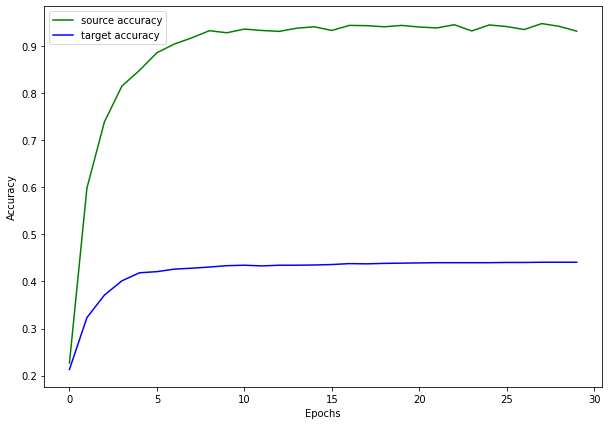

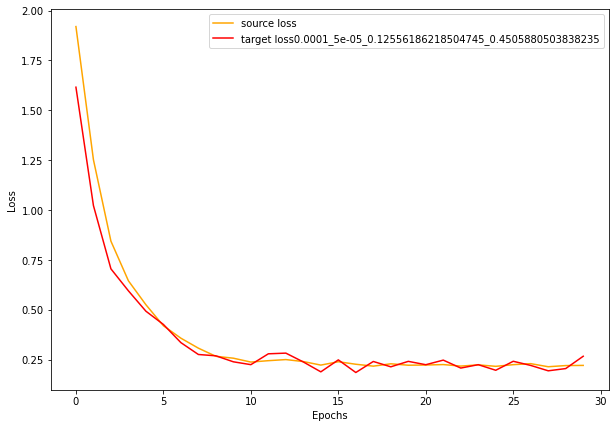

[(0.8870849683880806, 0.47998046875), (0.41503240913152695, 0.80810546875), (0.24299149587750435, 0.90673828125), (0.2269077282398939, 0.9111328125), (0.2014138139784336, 0.9248046875), (0.18632199242711067, 0.9228515625), (0.1604302003979683, 0.9375), (0.1653647106140852, 0.93896484375), (0.15101706236600876, 0.94287109375), (0.14257703442126513, 0.94921875), (0.14111001323908567, 0.95166015625), (0.14699786715209484, 0.9453125), (0.14351577591151, 0.9482421875), (0.1460690200328827, 0.94580078125), (0.1265416070818901, 0.95654296875), (0.14074603747576475, 0.9521484375), (0.1353998426347971, 0.9462890625), (0.13952039368450642, 0.94873046875), (0.12574558798223734, 0.95361328125), (0.13218847569078207, 0.95068359375), (0.1296166405081749, 0.953125), (0.12518152873963118, 0.9580078125), (0.13345125317573547, 0.951171875), (0.12708155158907175, 0.953125), (0.1376862581819296, 0.9521484375), (0.13104869984090328, 0.9541015625), (0.12948194053024054, 0.9521484375), (0.13530679140239954, 

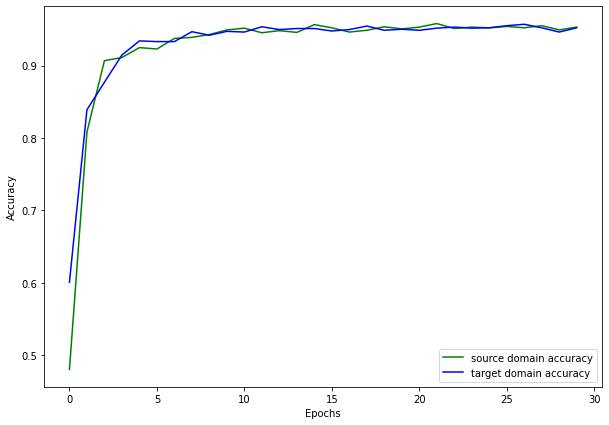

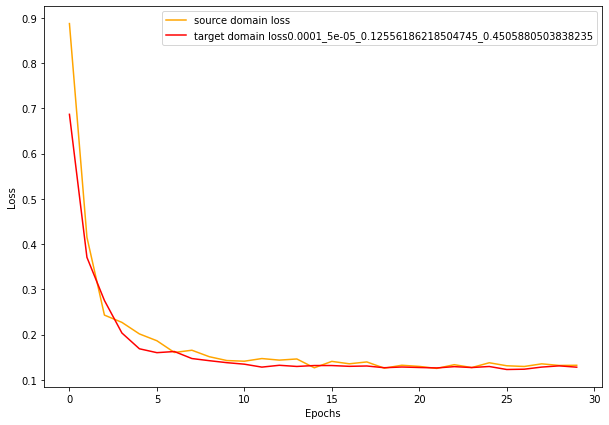

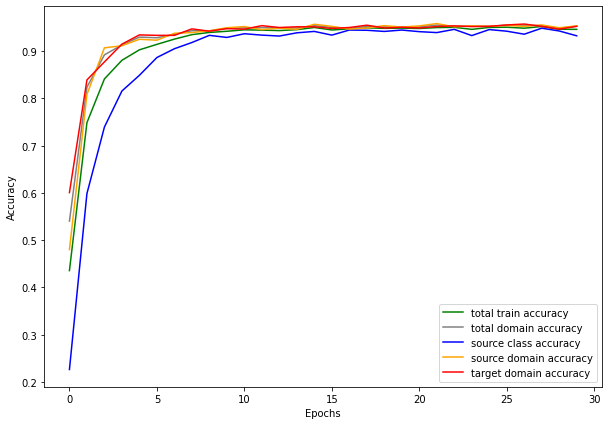

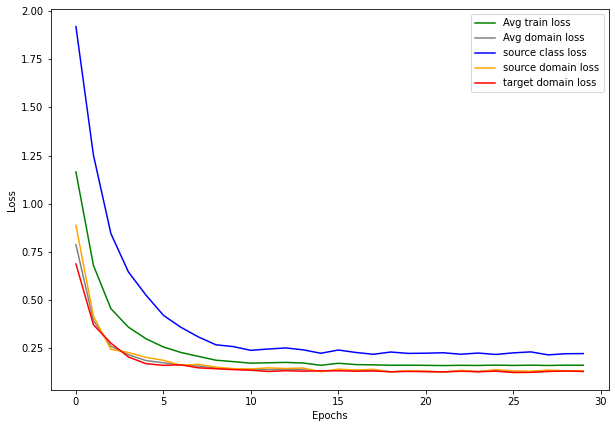

100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Test Accuracy: 0.43798828125
Iteration 6 / 8
Starting epoch 1/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 2.2999, Train class Acc: 0.08
Target class Loss: 2.3439, Val class Acc: 0.12
Source domain Loss: 0.8610, Source domain Acc: 0.42
Target domain Loss: 0.9506, Target domain Acc: 0.36
Total train Loss: 1.3705, Total train Acc: 0.29
Total domain Loss: 0.9058, Total domain Acc: 0.39


Starting epoch 2/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]



Source class Loss: 2.1805, Train class Acc: 0.11
Target class Loss: 2.1436, Val class Acc: 0.13
Source domain Loss: 0.8199, Source domain Acc: 0.46
Target domain Loss: 0.8181, Target domain Acc: 0.46
Total train Loss: 1.2728, Total train Acc: 0.35
Total domain Loss: 0.8190, Total domain Acc: 0.46


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 2.0199, Train class Acc: 0.17
Target class Loss: 1.9606, Val class Acc: 0.14
Source domain Loss: 0.7332, Source domain Acc: 0.55
Target domain Loss: 0.6750, Target domain Acc: 0.59
Total train Loss: 1.1427, Total train Acc: 0.44
Total domain Loss: 0.7041, Total domain Acc: 0.57


Starting epoch 4/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 1.8706, Train class Acc: 0.27
Target class Loss: 1.7835, Val class Acc: 0.16
Source domain Loss: 0.6581, Source domain Acc: 0.65
Target domain Loss: 0.5575, Target domain Acc: 0.70
Total train Loss: 1.0287, Total train Acc: 0.54
Total domain Loss: 0.6078, Total domain Acc: 0.67


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 1.7289, Train class Acc: 0.38
Target class Loss: 1.6461, Val class Acc: 0.18
Source domain Loss: 0.5998, Source domain Acc: 0.70
Target domain Loss: 0.4934, Target domain Acc: 0.75
Total train Loss: 0.9407, Total train Acc: 0.61
Total domain Loss: 0.5466, Total domain Acc: 0.73


Starting epoch 6/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 1.5859, Train class Acc: 0.47
Target class Loss: 1.5020, Val class Acc: 0.19
Source domain Loss: 0.5398, Source domain Acc: 0.75
Target domain Loss: 0.4364, Target domain Acc: 0.80
Total train Loss: 0.8540, Total train Acc: 0.67
Total domain Loss: 0.4881, Total domain Acc: 0.77


Starting epoch 7/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.4753, Train class Acc: 0.52
Target class Loss: 1.4716, Val class Acc: 0.21
Source domain Loss: 0.4894, Source domain Acc: 0.78
Target domain Loss: 0.3974, Target domain Acc: 0.83
Total train Loss: 0.7874, Total train Acc: 0.71
Total domain Loss: 0.4434, Total domain Acc: 0.81


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.3855, Train class Acc: 0.55
Target class Loss: 1.3424, Val class Acc: 0.22
Source domain Loss: 0.4587, Source domain Acc: 0.81
Target domain Loss: 0.3754, Target domain Acc: 0.84
Total train Loss: 0.7399, Total train Acc: 0.73
Total domain Loss: 0.4171, Total domain Acc: 0.82


Starting epoch 9/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 1.3068, Train class Acc: 0.56
Target class Loss: 1.2408, Val class Acc: 0.24
Source domain Loss: 0.4257, Source domain Acc: 0.82
Target domain Loss: 0.3469, Target domain Acc: 0.87
Total train Loss: 0.6932, Total train Acc: 0.75
Total domain Loss: 0.3863, Total domain Acc: 0.85


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.2319, Train class Acc: 0.60
Target class Loss: 1.2291, Val class Acc: 0.25
Source domain Loss: 0.4066, Source domain Acc: 0.83
Target domain Loss: 0.3352, Target domain Acc: 0.86
Total train Loss: 0.6579, Total train Acc: 0.76
Total domain Loss: 0.3709, Total domain Acc: 0.85


Starting epoch 11/30, LR = [3.692026046804721e-06]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 1.1842, Train class Acc: 0.61
Target class Loss: 1.1690, Val class Acc: 0.25
Source domain Loss: 0.3928, Source domain Acc: 0.84
Target domain Loss: 0.3245, Target domain Acc: 0.87
Total train Loss: 0.6339, Total train Acc: 0.77
Total domain Loss: 0.3587, Total domain Acc: 0.86


Starting epoch 12/30, LR = [3.692026046804721e-06]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.1730, Train class Acc: 0.62
Target class Loss: 1.1545, Val class Acc: 0.26
Source domain Loss: 0.3848, Source domain Acc: 0.84
Target domain Loss: 0.3259, Target domain Acc: 0.86
Total train Loss: 0.6279, Total train Acc: 0.77
Total domain Loss: 0.3554, Total domain Acc: 0.85


Starting epoch 13/30, LR = [3.692026046804721e-06]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.1415, Train class Acc: 0.63
Target class Loss: 1.1400, Val class Acc: 0.26
Source domain Loss: 0.3659, Source domain Acc: 0.85
Target domain Loss: 0.3193, Target domain Acc: 0.87
Total train Loss: 0.6089, Total train Acc: 0.78
Total domain Loss: 0.3426, Total domain Acc: 0.86


Starting epoch 14/30, LR = [3.692026046804721e-06]


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]



Source class Loss: 1.1045, Train class Acc: 0.64
Target class Loss: 1.0049, Val class Acc: 0.26
Source domain Loss: 0.3653, Source domain Acc: 0.86
Target domain Loss: 0.3101, Target domain Acc: 0.87
Total train Loss: 0.5933, Total train Acc: 0.79
Total domain Loss: 0.3377, Total domain Acc: 0.87


Starting epoch 15/30, LR = [3.692026046804721e-06]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Source class Loss: 1.1087, Train class Acc: 0.65
Target class Loss: 1.1310, Val class Acc: 0.26
Source domain Loss: 0.3635, Source domain Acc: 0.86
Target domain Loss: 0.2993, Target domain Acc: 0.88
Total train Loss: 0.5905, Total train Acc: 0.80
Total domain Loss: 0.3314, Total domain Acc: 0.87


Starting epoch 16/30, LR = [3.692026046804721e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 1.0842, Train class Acc: 0.64
Target class Loss: 1.0917, Val class Acc: 0.27
Source domain Loss: 0.3551, Source domain Acc: 0.86
Target domain Loss: 0.3077, Target domain Acc: 0.88
Total train Loss: 0.5823, Total train Acc: 0.79
Total domain Loss: 0.3314, Total domain Acc: 0.87


Starting epoch 17/30, LR = [3.692026046804721e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 1.0729, Train class Acc: 0.66
Target class Loss: 1.0548, Val class Acc: 0.27
Source domain Loss: 0.3463, Source domain Acc: 0.86
Target domain Loss: 0.3010, Target domain Acc: 0.87
Total train Loss: 0.5734, Total train Acc: 0.80
Total domain Loss: 0.3236, Total domain Acc: 0.87


Starting epoch 18/30, LR = [3.692026046804721e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 1.0735, Train class Acc: 0.66
Target class Loss: 1.1572, Val class Acc: 0.27
Source domain Loss: 0.3369, Source domain Acc: 0.88
Target domain Loss: 0.2942, Target domain Acc: 0.88
Total train Loss: 0.5682, Total train Acc: 0.81
Total domain Loss: 0.3156, Total domain Acc: 0.88


Starting epoch 19/30, LR = [3.692026046804721e-06]



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 1.0448, Train class Acc: 0.66
Target class Loss: 1.0331, Val class Acc: 0.28
Source domain Loss: 0.3379, Source domain Acc: 0.87
Target domain Loss: 0.2929, Target domain Acc: 0.88
Total train Loss: 0.5585, Total train Acc: 0.81
Total domain Loss: 0.3154, Total domain Acc: 0.88


Starting epoch 20/30, LR = [3.692026046804721e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 1.0393, Train class Acc: 0.67
Target class Loss: 1.0020, Val class Acc: 0.28
Source domain Loss: 0.3412, Source domain Acc: 0.87
Target domain Loss: 0.2862, Target domain Acc: 0.88
Total train Loss: 0.5556, Total train Acc: 0.81
Total domain Loss: 0.3137, Total domain Acc: 0.88


Starting epoch 21/30, LR = [1.3631056330284494e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.9951, Train class Acc: 0.69
Target class Loss: 0.9362, Val class Acc: 0.28
Source domain Loss: 0.3309, Source domain Acc: 0.87
Target domain Loss: 0.2834, Target domain Acc: 0.88
Total train Loss: 0.5365, Total train Acc: 0.82
Total domain Loss: 0.3071, Total domain Acc: 0.88


Starting epoch 22/30, LR = [1.3631056330284494e-06]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Source class Loss: 1.0047, Train class Acc: 0.68
Target class Loss: 0.9756, Val class Acc: 0.28
Source domain Loss: 0.3313, Source domain Acc: 0.87
Target domain Loss: 0.2813, Target domain Acc: 0.88
Total train Loss: 0.5391, Total train Acc: 0.81
Total domain Loss: 0.3063, Total domain Acc: 0.87


Starting epoch 23/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Source class Loss: 1.0098, Train class Acc: 0.68
Target class Loss: 0.9840, Val class Acc: 0.28
Source domain Loss: 0.3333, Source domain Acc: 0.87
Target domain Loss: 0.2807, Target domain Acc: 0.89
Total train Loss: 0.5413, Total train Acc: 0.81
Total domain Loss: 0.3070, Total domain Acc: 0.88


Starting epoch 24/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 1.0060, Train class Acc: 0.68
Target class Loss: 0.9657, Val class Acc: 0.29
Source domain Loss: 0.3350, Source domain Acc: 0.87
Target domain Loss: 0.2812, Target domain Acc: 0.88
Total train Loss: 0.5407, Total train Acc: 0.81
Total domain Loss: 0.3081, Total domain Acc: 0.88


Starting epoch 25/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9760, Train class Acc: 0.69
Target class Loss: 0.9985, Val class Acc: 0.29
Source domain Loss: 0.3270, Source domain Acc: 0.87
Target domain Loss: 0.2819, Target domain Acc: 0.89
Total train Loss: 0.5283, Total train Acc: 0.82
Total domain Loss: 0.3044, Total domain Acc: 0.88


Starting epoch 26/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9837, Train class Acc: 0.69
Target class Loss: 0.9404, Val class Acc: 0.29
Source domain Loss: 0.3293, Source domain Acc: 0.87
Target domain Loss: 0.2789, Target domain Acc: 0.88
Total train Loss: 0.5306, Total train Acc: 0.81
Total domain Loss: 0.3041, Total domain Acc: 0.88


Starting epoch 27/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9795, Train class Acc: 0.69
Target class Loss: 0.9408, Val class Acc: 0.29
Source domain Loss: 0.3213, Source domain Acc: 0.87
Target domain Loss: 0.2860, Target domain Acc: 0.88
Total train Loss: 0.5289, Total train Acc: 0.82
Total domain Loss: 0.3036, Total domain Acc: 0.88


Starting epoch 28/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:09<00:00,  1.22s/it]



Source class Loss: 0.9788, Train class Acc: 0.70
Target class Loss: 0.9066, Val class Acc: 0.29
Source domain Loss: 0.3209, Source domain Acc: 0.88
Target domain Loss: 0.2752, Target domain Acc: 0.89
Total train Loss: 0.5250, Total train Acc: 0.82
Total domain Loss: 0.2980, Total domain Acc: 0.89


Starting epoch 29/30, LR = [1.3631056330284494e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.9655, Train class Acc: 0.71
Target class Loss: 0.9585, Val class Acc: 0.29
Source domain Loss: 0.3172, Source domain Acc: 0.87
Target domain Loss: 0.2719, Target domain Acc: 0.90
Total train Loss: 0.5182, Total train Acc: 0.82
Total domain Loss: 0.2945, Total domain Acc: 0.88


Starting epoch 30/30, LR = [1.3631056330284494e-06]



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.9795, Train class Acc: 0.69
Target class Loss: 0.9380, Val class Acc: 0.29
Source domain Loss: 0.3184, Source domain Acc: 0.87
Target domain Loss: 0.2763, Target domain Acc: 0.89
Total train Loss: 0.5248, Total train Acc: 0.82
Total domain Loss: 0.2974, Total domain Acc: 0.88


[(2.29988631606102, 0.083984375), (2.1804839968681335, 0.11474609375), (2.019897997379303, 0.16796875), (1.8706275820732117, 0.2734375), (1.7288830280303955, 0.38330078125), (1.5859020203351974, 0.470703125), (1.4753489047288895, 0.51904296875), (1.3855168670415878, 0.54833984375), (1.3068498820066452, 0.56494140625), (1.2319308668375015, 0.6015625), (1.1842315942049026, 0.61083984375), (1.17304065823555, 0.62353515625), (1.1414545774459839, 0.63232421875), (1.1044693440198898, 0.64404296875), (1.1087200120091438, 0.64794921875), (1.0841629356145859, 0.6416015625), (1.0728820711374283, 0.6630859375), (1.0734861269593239, 0.6591796875), (1.044844999909401, 0.6611328125), (1.0392912030220032,

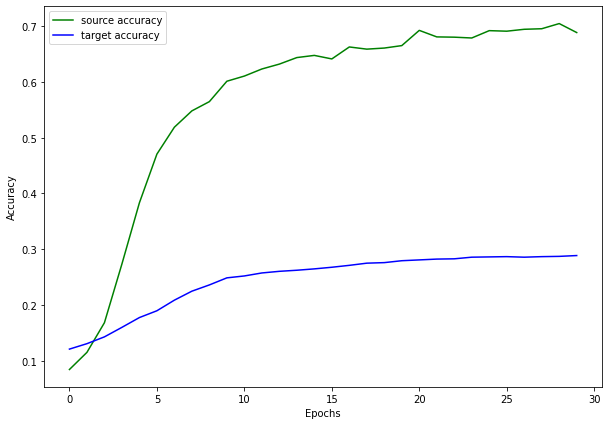

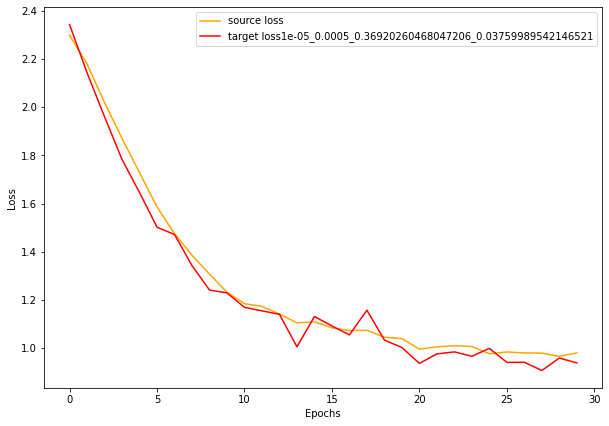

[(0.8610178902745247, 0.4150390625), (0.8199279755353928, 0.46240234375), (0.7331725805997849, 0.55224609375), (0.6580523028969765, 0.646484375), (0.5998033061623573, 0.70263671875), (0.5398143902420998, 0.7470703125), (0.4893746003508568, 0.78369140625), (0.45869146659970284, 0.80517578125), (0.42567556351423264, 0.82470703125), (0.40655674785375595, 0.83154296875), (0.3927934393286705, 0.84326171875), (0.3848169408738613, 0.8359375), (0.36589448153972626, 0.8515625), (0.36529550328850746, 0.859375), (0.36345748975872993, 0.857421875), (0.35510585084557533, 0.86279296875), (0.3462989069521427, 0.86181640625), (0.3369206227362156, 0.876953125), (0.33786965161561966, 0.87451171875), (0.34123218059539795, 0.8681640625), (0.33090218529105186, 0.87255859375), (0.33131545409560204, 0.86767578125), (0.33330196142196655, 0.8662109375), (0.33496470376849174, 0.8671875), (0.32699452340602875, 0.8740234375), (0.3293149285018444, 0.8662109375), (0.3212883025407791, 0.8720703125), (0.3208509422838

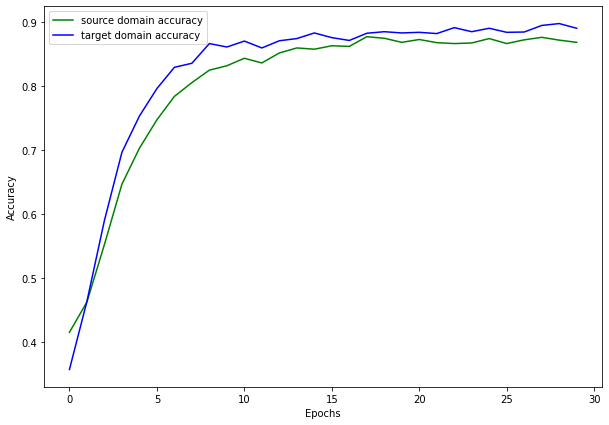

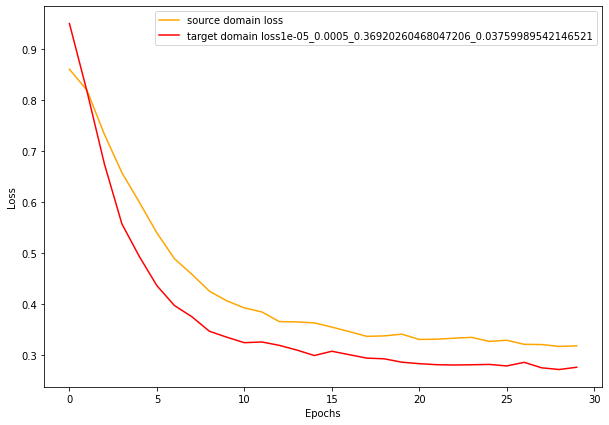

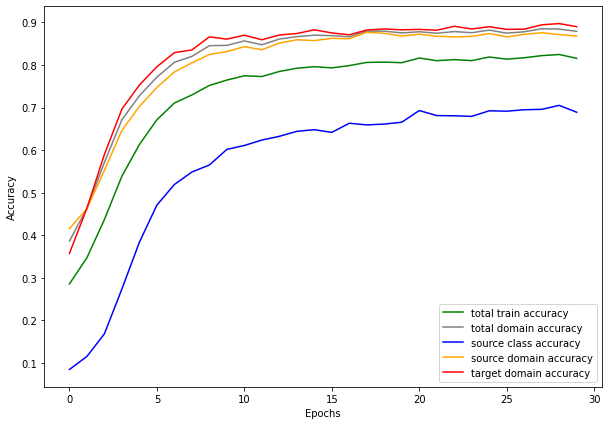

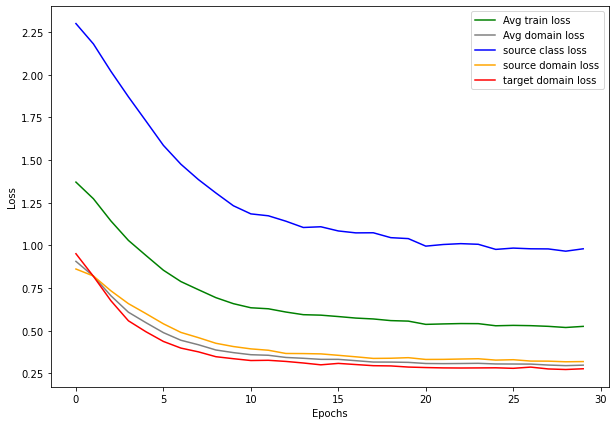

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Test Accuracy: 0.28662109375
Iteration 7 / 8
Starting epoch 1/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.9192, Train class Acc: 0.25
Target class Loss: 1.8741, Val class Acc: 0.17
Source domain Loss: 0.7939, Source domain Acc: 0.51
Target domain Loss: 0.7418, Target domain Acc: 0.57
Total train Loss: 1.1516, Total train Acc: 0.44
Total domain Loss: 0.7678, Total domain Acc: 0.54


Starting epoch 2/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]



Source class Loss: 1.8334, Train class Acc: 0.31
Target class Loss: 1.7438, Val class Acc: 0.19
Source domain Loss: 0.7367, Source domain Acc: 0.56
Target domain Loss: 0.6542, Target domain Acc: 0.64
Total train Loss: 1.0748, Total train Acc: 0.50
Total domain Loss: 0.6955, Total domain Acc: 0.60


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 1.7093, Train class Acc: 0.37
Target class Loss: 1.6541, Val class Acc: 0.21
Source domain Loss: 0.6753, Source domain Acc: 0.61
Target domain Loss: 0.5543, Target domain Acc: 0.72
Total train Loss: 0.9796, Total train Acc: 0.57
Total domain Loss: 0.6148, Total domain Acc: 0.67


Starting epoch 4/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.5793, Train class Acc: 0.44
Target class Loss: 1.5260, Val class Acc: 0.22
Source domain Loss: 0.6230, Source domain Acc: 0.66
Target domain Loss: 0.4798, Target domain Acc: 0.79
Total train Loss: 0.8940, Total train Acc: 0.63
Total domain Loss: 0.5514, Total domain Acc: 0.73


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.4764, Train class Acc: 0.48
Target class Loss: 1.4414, Val class Acc: 0.24
Source domain Loss: 0.5564, Source domain Acc: 0.71
Target domain Loss: 0.4269, Target domain Acc: 0.82
Total train Loss: 0.8199, Total train Acc: 0.67
Total domain Loss: 0.4916, Total domain Acc: 0.76


Starting epoch 6/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.3621, Train class Acc: 0.52
Target class Loss: 1.2837, Val class Acc: 0.26
Source domain Loss: 0.4924, Source domain Acc: 0.77
Target domain Loss: 0.3909, Target domain Acc: 0.85
Total train Loss: 0.7485, Total train Acc: 0.72
Total domain Loss: 0.4416, Total domain Acc: 0.81


Starting epoch 7/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]



Source class Loss: 1.2661, Train class Acc: 0.58
Target class Loss: 1.2230, Val class Acc: 0.27
Source domain Loss: 0.4476, Source domain Acc: 0.79
Target domain Loss: 0.3720, Target domain Acc: 0.85
Total train Loss: 0.6952, Total train Acc: 0.74
Total domain Loss: 0.4098, Total domain Acc: 0.82


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]



Source class Loss: 1.1909, Train class Acc: 0.62
Target class Loss: 1.1766, Val class Acc: 0.28
Source domain Loss: 0.4209, Source domain Acc: 0.82
Target domain Loss: 0.3463, Target domain Acc: 0.87
Total train Loss: 0.6527, Total train Acc: 0.77
Total domain Loss: 0.3836, Total domain Acc: 0.85


Starting epoch 9/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.1254, Train class Acc: 0.65
Target class Loss: 1.0633, Val class Acc: 0.30
Source domain Loss: 0.4129, Source domain Acc: 0.82
Target domain Loss: 0.3345, Target domain Acc: 0.87
Total train Loss: 0.6243, Total train Acc: 0.78
Total domain Loss: 0.3737, Total domain Acc: 0.84


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]



Source class Loss: 1.0822, Train class Acc: 0.66
Target class Loss: 1.0469, Val class Acc: 0.31
Source domain Loss: 0.3795, Source domain Acc: 0.83
Target domain Loss: 0.3173, Target domain Acc: 0.88
Total train Loss: 0.5930, Total train Acc: 0.79
Total domain Loss: 0.3484, Total domain Acc: 0.86


Starting epoch 11/30, LR = [2.6495342668838854e-06]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Source class Loss: 1.0477, Train class Acc: 0.67
Target class Loss: 1.0755, Val class Acc: 0.31
Source domain Loss: 0.3723, Source domain Acc: 0.84
Target domain Loss: 0.3085, Target domain Acc: 0.88
Total train Loss: 0.5762, Total train Acc: 0.80
Total domain Loss: 0.3404, Total domain Acc: 0.86


Starting epoch 12/30, LR = [2.6495342668838854e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 1.0176, Train class Acc: 0.68
Target class Loss: 0.9967, Val class Acc: 0.32
Source domain Loss: 0.3644, Source domain Acc: 0.84
Target domain Loss: 0.3041, Target domain Acc: 0.88
Total train Loss: 0.5620, Total train Acc: 0.80
Total domain Loss: 0.3343, Total domain Acc: 0.86


Starting epoch 13/30, LR = [2.6495342668838854e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 1.0193, Train class Acc: 0.68
Target class Loss: 1.0239, Val class Acc: 0.32
Source domain Loss: 0.3591, Source domain Acc: 0.85
Target domain Loss: 0.3032, Target domain Acc: 0.89
Total train Loss: 0.5606, Total train Acc: 0.81
Total domain Loss: 0.3312, Total domain Acc: 0.87


Starting epoch 14/30, LR = [2.6495342668838854e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.9997, Train class Acc: 0.69
Target class Loss: 0.9338, Val class Acc: 0.32
Source domain Loss: 0.3542, Source domain Acc: 0.85
Target domain Loss: 0.2997, Target domain Acc: 0.88
Total train Loss: 0.5512, Total train Acc: 0.81
Total domain Loss: 0.3269, Total domain Acc: 0.86


Starting epoch 15/30, LR = [2.6495342668838854e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 1.0021, Train class Acc: 0.69
Target class Loss: 1.0266, Val class Acc: 0.32
Source domain Loss: 0.3550, Source domain Acc: 0.85
Target domain Loss: 0.3012, Target domain Acc: 0.88
Total train Loss: 0.5528, Total train Acc: 0.81
Total domain Loss: 0.3281, Total domain Acc: 0.87


Starting epoch 16/30, LR = [2.6495342668838854e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9713, Train class Acc: 0.71
Target class Loss: 0.9640, Val class Acc: 0.32
Source domain Loss: 0.3505, Source domain Acc: 0.85
Target domain Loss: 0.2952, Target domain Acc: 0.89
Total train Loss: 0.5390, Total train Acc: 0.82
Total domain Loss: 0.3229, Total domain Acc: 0.87


Starting epoch 17/30, LR = [2.6495342668838854e-06]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.9793, Train class Acc: 0.70
Target class Loss: 0.9309, Val class Acc: 0.32
Source domain Loss: 0.3453, Source domain Acc: 0.85
Target domain Loss: 0.2970, Target domain Acc: 0.88
Total train Loss: 0.5405, Total train Acc: 0.81
Total domain Loss: 0.3212, Total domain Acc: 0.86


Starting epoch 18/30, LR = [2.6495342668838854e-06]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 0.9626, Train class Acc: 0.70
Target class Loss: 0.9160, Val class Acc: 0.33
Source domain Loss: 0.3383, Source domain Acc: 0.87
Target domain Loss: 0.2963, Target domain Acc: 0.88
Total train Loss: 0.5324, Total train Acc: 0.82
Total domain Loss: 0.3173, Total domain Acc: 0.87


Starting epoch 19/30, LR = [2.6495342668838854e-06]


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Source class Loss: 0.9566, Train class Acc: 0.70
Target class Loss: 0.9825, Val class Acc: 0.33
Source domain Loss: 0.3376, Source domain Acc: 0.86
Target domain Loss: 0.2922, Target domain Acc: 0.89
Total train Loss: 0.5288, Total train Acc: 0.82
Total domain Loss: 0.3149, Total domain Acc: 0.87


Starting epoch 20/30, LR = [2.6495342668838854e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.9419, Train class Acc: 0.72
Target class Loss: 0.9270, Val class Acc: 0.33
Source domain Loss: 0.3315, Source domain Acc: 0.86
Target domain Loss: 0.2882, Target domain Acc: 0.89
Total train Loss: 0.5205, Total train Acc: 0.82
Total domain Loss: 0.3098, Total domain Acc: 0.88


Starting epoch 21/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.9372, Train class Acc: 0.71
Target class Loss: 0.9784, Val class Acc: 0.33
Source domain Loss: 0.3306, Source domain Acc: 0.86
Target domain Loss: 0.2856, Target domain Acc: 0.89
Total train Loss: 0.5178, Total train Acc: 0.82
Total domain Loss: 0.3081, Total domain Acc: 0.88


Starting epoch 22/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 0.9270, Train class Acc: 0.72
Target class Loss: 0.9691, Val class Acc: 0.33
Source domain Loss: 0.3304, Source domain Acc: 0.87
Target domain Loss: 0.2855, Target domain Acc: 0.89
Total train Loss: 0.5143, Total train Acc: 0.83
Total domain Loss: 0.3079, Total domain Acc: 0.88


Starting epoch 23/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.9221, Train class Acc: 0.71
Target class Loss: 0.9217, Val class Acc: 0.33
Source domain Loss: 0.3383, Source domain Acc: 0.86
Target domain Loss: 0.2846, Target domain Acc: 0.89
Total train Loss: 0.5150, Total train Acc: 0.82
Total domain Loss: 0.3114, Total domain Acc: 0.87


Starting epoch 24/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.9203, Train class Acc: 0.73
Target class Loss: 0.8399, Val class Acc: 0.33
Source domain Loss: 0.3279, Source domain Acc: 0.86
Target domain Loss: 0.2873, Target domain Acc: 0.89
Total train Loss: 0.5119, Total train Acc: 0.83
Total domain Loss: 0.3076, Total domain Acc: 0.87


Starting epoch 25/30, LR = [7.020031831391927e-07]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.9234, Train class Acc: 0.71
Target class Loss: 0.9626, Val class Acc: 0.33
Source domain Loss: 0.3286, Source domain Acc: 0.86
Target domain Loss: 0.2863, Target domain Acc: 0.89
Total train Loss: 0.5128, Total train Acc: 0.82
Total domain Loss: 0.3075, Total domain Acc: 0.88


Starting epoch 26/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.9209, Train class Acc: 0.73
Target class Loss: 0.8989, Val class Acc: 0.33
Source domain Loss: 0.3274, Source domain Acc: 0.87
Target domain Loss: 0.2808, Target domain Acc: 0.89
Total train Loss: 0.5097, Total train Acc: 0.83
Total domain Loss: 0.3041, Total domain Acc: 0.88


Starting epoch 27/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9075, Train class Acc: 0.73
Target class Loss: 0.8496, Val class Acc: 0.33
Source domain Loss: 0.3141, Source domain Acc: 0.88
Target domain Loss: 0.2771, Target domain Acc: 0.89
Total train Loss: 0.4995, Total train Acc: 0.84
Total domain Loss: 0.2956, Total domain Acc: 0.89


Starting epoch 28/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.9127, Train class Acc: 0.72
Target class Loss: 0.8731, Val class Acc: 0.33
Source domain Loss: 0.3169, Source domain Acc: 0.87
Target domain Loss: 0.2866, Target domain Acc: 0.89
Total train Loss: 0.5054, Total train Acc: 0.83
Total domain Loss: 0.3018, Total domain Acc: 0.88


Starting epoch 29/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Source class Loss: 0.9213, Train class Acc: 0.72
Target class Loss: 0.9356, Val class Acc: 0.33
Source domain Loss: 0.3281, Source domain Acc: 0.86
Target domain Loss: 0.2796, Target domain Acc: 0.89
Total train Loss: 0.5097, Total train Acc: 0.82
Total domain Loss: 0.3039, Total domain Acc: 0.88


Starting epoch 30/30, LR = [7.020031831391927e-07]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Source class Loss: 0.9203, Train class Acc: 0.72
Target class Loss: 0.9295, Val class Acc: 0.33
Source domain Loss: 0.3237, Source domain Acc: 0.87
Target domain Loss: 0.2796, Target domain Acc: 0.89
Total train Loss: 0.5079, Total train Acc: 0.83
Total domain Loss: 0.3016, Total domain Acc: 0.88


[(1.9192248284816742, 0.25146484375), (1.8333599865436554, 0.31298828125), (1.7093373984098434, 0.3740234375), (1.57926507294178, 0.4384765625), (1.4764012396335602, 0.4755859375), (1.3621468991041183, 0.52197265625), (1.2660824805498123, 0.5771484375), (1.1908956468105316, 0.61669921875), (1.125409945845604, 0.650390625), (1.08220374584198, 0.6552734375), (1.047687217593193, 0.67431640625), (1.017557218670845, 0.68017578125), (1.0193305313587189, 0.68310546875), (0.9996527060866356, 0.69482421875), (1.0021382570266724, 0.693359375), (0.9713348671793938, 0.70654296875), (0.9792583882808685, 0.697265625), (0.9625502526760101, 0.7021484375), (0.9565750434994698, 0.70068359375), (0.94188617914

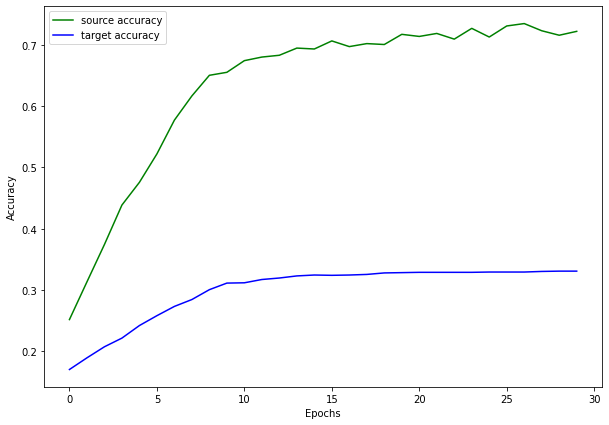

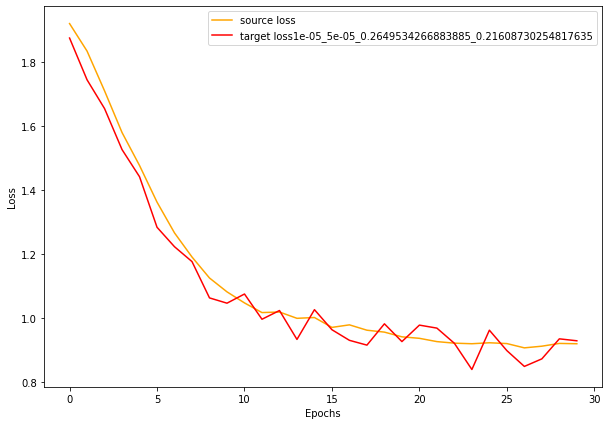

[(0.7938568815588951, 0.5068359375), (0.7366703078150749, 0.556640625), (0.6753111481666565, 0.6142578125), (0.6229848936200142, 0.662109375), (0.5563524514436722, 0.7080078125), (0.4923531413078308, 0.77294921875), (0.447573509067297, 0.794921875), (0.42086421325802803, 0.822265625), (0.41294702887535095, 0.8173828125), (0.37947091832756996, 0.8330078125), (0.3723093196749687, 0.83837890625), (0.3643835075199604, 0.84423828125), (0.3591116853058338, 0.84765625), (0.3541802503168583, 0.84912109375), (0.3549906425178051, 0.853515625), (0.3505028560757637, 0.8544921875), (0.34531382098793983, 0.8525390625), (0.3382621370255947, 0.8671875), (0.3376103714108467, 0.85791015625), (0.33148521184921265, 0.85986328125), (0.3306397944688797, 0.8623046875), (0.3304222896695137, 0.87060546875), (0.3382566571235657, 0.86279296875), (0.3279438316822052, 0.85888671875), (0.3286103568971157, 0.85986328125), (0.32736846059560776, 0.8681640625), (0.31407465413212776, 0.88134765625), (0.3169396370649338,

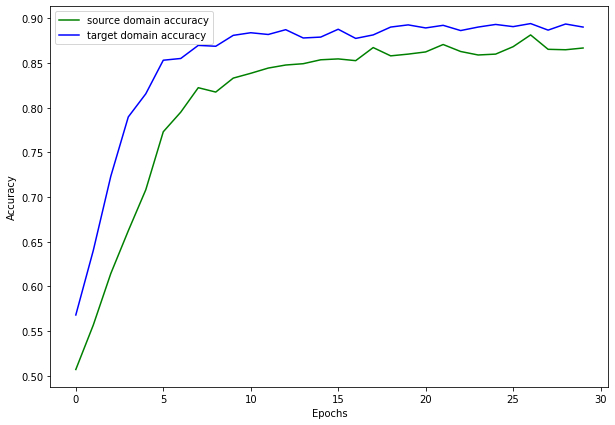

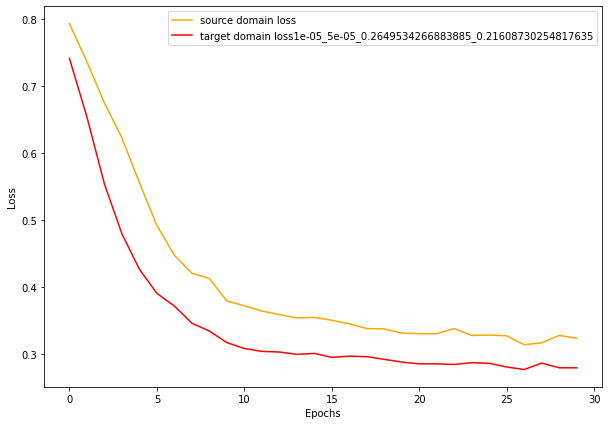

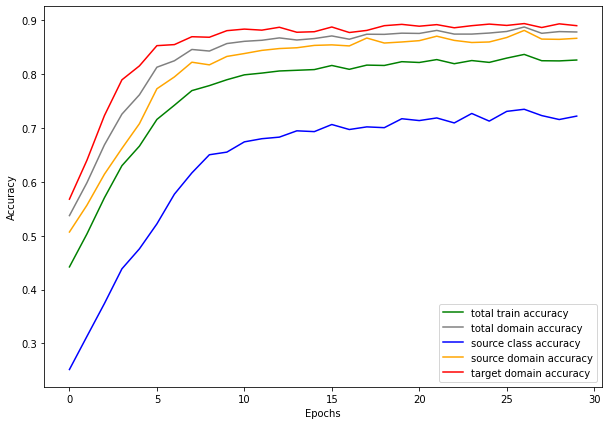

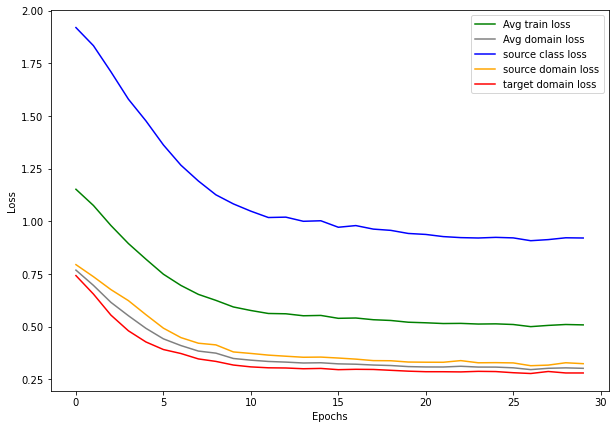

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Test Accuracy: 0.32861328125
Iteration 8 / 8
Starting epoch 1/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]



Source class Loss: 2.1866, Train class Acc: 0.11
Target class Loss: 2.1221, Val class Acc: 0.13
Source domain Loss: 1.1003, Source domain Acc: 0.24
Target domain Loss: 0.6961, Target domain Acc: 0.59
Total train Loss: 1.3277, Total train Acc: 0.31
Total domain Loss: 0.8982, Total domain Acc: 0.42


Starting epoch 2/30, LR = [1e-05]


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]



Source class Loss: 2.0826, Train class Acc: 0.15
Target class Loss: 2.0437, Val class Acc: 0.14
Source domain Loss: 0.9640, Source domain Acc: 0.30
Target domain Loss: 0.6375, Target domain Acc: 0.65
Total train Loss: 1.2280, Total train Acc: 0.37
Total domain Loss: 0.8007, Total domain Acc: 0.47


Starting epoch 3/30, LR = [1e-05]


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]



Source class Loss: 1.9644, Train class Acc: 0.22
Target class Loss: 1.8646, Val class Acc: 0.15
Source domain Loss: 0.8087, Source domain Acc: 0.45
Target domain Loss: 0.5663, Target domain Acc: 0.71
Total train Loss: 1.1131, Total train Acc: 0.46
Total domain Loss: 0.6875, Total domain Acc: 0.58


Starting epoch 4/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.8067, Train class Acc: 0.32
Target class Loss: 1.7913, Val class Acc: 0.15
Source domain Loss: 0.6845, Source domain Acc: 0.60
Target domain Loss: 0.5120, Target domain Acc: 0.76
Total train Loss: 1.0011, Total train Acc: 0.56
Total domain Loss: 0.5983, Total domain Acc: 0.68


Starting epoch 5/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]



Source class Loss: 1.6777, Train class Acc: 0.41
Target class Loss: 1.6436, Val class Acc: 0.16
Source domain Loss: 0.5827, Source domain Acc: 0.71
Target domain Loss: 0.4718, Target domain Acc: 0.80
Total train Loss: 0.9107, Total train Acc: 0.64
Total domain Loss: 0.5273, Total domain Acc: 0.75


Starting epoch 6/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.5749, Train class Acc: 0.46
Target class Loss: 1.5203, Val class Acc: 0.18
Source domain Loss: 0.5149, Source domain Acc: 0.77
Target domain Loss: 0.4379, Target domain Acc: 0.81
Total train Loss: 0.8426, Total train Acc: 0.68
Total domain Loss: 0.4764, Total domain Acc: 0.79


Starting epoch 7/30, LR = [1e-05]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 1.4662, Train class Acc: 0.51
Target class Loss: 1.3895, Val class Acc: 0.19
Source domain Loss: 0.4650, Source domain Acc: 0.80
Target domain Loss: 0.4099, Target domain Acc: 0.83
Total train Loss: 0.7804, Total train Acc: 0.71
Total domain Loss: 0.4375, Total domain Acc: 0.81


Starting epoch 8/30, LR = [1e-05]


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]



Source class Loss: 1.3750, Train class Acc: 0.54
Target class Loss: 1.3049, Val class Acc: 0.20
Source domain Loss: 0.4249, Source domain Acc: 0.83
Target domain Loss: 0.3784, Target domain Acc: 0.85
Total train Loss: 0.7261, Total train Acc: 0.74
Total domain Loss: 0.4017, Total domain Acc: 0.84


Starting epoch 9/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.3016, Train class Acc: 0.57
Target class Loss: 1.2523, Val class Acc: 0.21
Source domain Loss: 0.4013, Source domain Acc: 0.84
Target domain Loss: 0.3675, Target domain Acc: 0.85
Total train Loss: 0.6901, Total train Acc: 0.75
Total domain Loss: 0.3844, Total domain Acc: 0.84


Starting epoch 10/30, LR = [1e-05]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.2457, Train class Acc: 0.59
Target class Loss: 1.2114, Val class Acc: 0.22
Source domain Loss: 0.3887, Source domain Acc: 0.84
Target domain Loss: 0.3473, Target domain Acc: 0.86
Total train Loss: 0.6606, Total train Acc: 0.76
Total domain Loss: 0.3680, Total domain Acc: 0.85


Starting epoch 11/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 1.1743, Train class Acc: 0.62
Target class Loss: 1.1468, Val class Acc: 0.23
Source domain Loss: 0.3595, Source domain Acc: 0.86
Target domain Loss: 0.3284, Target domain Acc: 0.87
Total train Loss: 0.6207, Total train Acc: 0.78
Total domain Loss: 0.3439, Total domain Acc: 0.86


Starting epoch 12/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Source class Loss: 1.1662, Train class Acc: 0.61
Target class Loss: 1.1763, Val class Acc: 0.23
Source domain Loss: 0.3645, Source domain Acc: 0.85
Target domain Loss: 0.3236, Target domain Acc: 0.88
Total train Loss: 0.6181, Total train Acc: 0.78
Total domain Loss: 0.3441, Total domain Acc: 0.86


Starting epoch 13/30, LR = [4.629204676541366e-06]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 1.1484, Train class Acc: 0.63
Target class Loss: 1.1638, Val class Acc: 0.24
Source domain Loss: 0.3527, Source domain Acc: 0.86
Target domain Loss: 0.3227, Target domain Acc: 0.87
Total train Loss: 0.6079, Total train Acc: 0.78
Total domain Loss: 0.3377, Total domain Acc: 0.86


Starting epoch 14/30, LR = [4.629204676541366e-06]



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 1.1218, Train class Acc: 0.62
Target class Loss: 1.1407, Val class Acc: 0.24
Source domain Loss: 0.3441, Source domain Acc: 0.87
Target domain Loss: 0.3118, Target domain Acc: 0.87
Total train Loss: 0.5926, Total train Acc: 0.79
Total domain Loss: 0.3279, Total domain Acc: 0.87


Starting epoch 15/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]



Source class Loss: 1.0995, Train class Acc: 0.64
Target class Loss: 1.1241, Val class Acc: 0.25
Source domain Loss: 0.3393, Source domain Acc: 0.86
Target domain Loss: 0.3086, Target domain Acc: 0.88
Total train Loss: 0.5825, Total train Acc: 0.79
Total domain Loss: 0.3239, Total domain Acc: 0.87


Starting epoch 16/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 1.0641, Train class Acc: 0.65
Target class Loss: 1.0139, Val class Acc: 0.25
Source domain Loss: 0.3296, Source domain Acc: 0.87
Target domain Loss: 0.3084, Target domain Acc: 0.88
Total train Loss: 0.5674, Total train Acc: 0.80
Total domain Loss: 0.3190, Total domain Acc: 0.88


Starting epoch 17/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 1.0652, Train class Acc: 0.65
Target class Loss: 1.1310, Val class Acc: 0.25
Source domain Loss: 0.3325, Source domain Acc: 0.88
Target domain Loss: 0.3026, Target domain Acc: 0.88
Total train Loss: 0.5668, Total train Acc: 0.80
Total domain Loss: 0.3175, Total domain Acc: 0.88


Starting epoch 18/30, LR = [4.629204676541366e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 1.0279, Train class Acc: 0.67
Target class Loss: 1.0053, Val class Acc: 0.25
Source domain Loss: 0.3158, Source domain Acc: 0.88
Target domain Loss: 0.2953, Target domain Acc: 0.88
Total train Loss: 0.5463, Total train Acc: 0.81
Total domain Loss: 0.3056, Total domain Acc: 0.88


Starting epoch 19/30, LR = [4.629204676541366e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 1.0266, Train class Acc: 0.68
Target class Loss: 1.0719, Val class Acc: 0.26
Source domain Loss: 0.3187, Source domain Acc: 0.88
Target domain Loss: 0.2913, Target domain Acc: 0.89
Total train Loss: 0.5455, Total train Acc: 0.81
Total domain Loss: 0.3050, Total domain Acc: 0.88


Starting epoch 20/30, LR = [4.629204676541366e-06]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.9993, Train class Acc: 0.68
Target class Loss: 1.0193, Val class Acc: 0.26
Source domain Loss: 0.3134, Source domain Acc: 0.88
Target domain Loss: 0.2876, Target domain Acc: 0.89
Total train Loss: 0.5334, Total train Acc: 0.82
Total domain Loss: 0.3005, Total domain Acc: 0.88


Starting epoch 21/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.9727, Train class Acc: 0.70
Target class Loss: 0.9725, Val class Acc: 0.26
Source domain Loss: 0.3225, Source domain Acc: 0.87
Target domain Loss: 0.2889, Target domain Acc: 0.88
Total train Loss: 0.5280, Total train Acc: 0.82
Total domain Loss: 0.3057, Total domain Acc: 0.88


Starting epoch 22/30, LR = [2.142953593731245e-06]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Source class Loss: 0.9602, Train class Acc: 0.70
Target class Loss: 0.9819, Val class Acc: 0.26
Source domain Loss: 0.2946, Source domain Acc: 0.89
Target domain Loss: 0.2842, Target domain Acc: 0.88
Total train Loss: 0.5130, Total train Acc: 0.82
Total domain Loss: 0.2894, Total domain Acc: 0.89


Starting epoch 23/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.9738, Train class Acc: 0.69
Target class Loss: 0.9557, Val class Acc: 0.26
Source domain Loss: 0.3020, Source domain Acc: 0.89
Target domain Loss: 0.2802, Target domain Acc: 0.89
Total train Loss: 0.5187, Total train Acc: 0.83
Total domain Loss: 0.2911, Total domain Acc: 0.89


Starting epoch 24/30, LR = [2.142953593731245e-06]


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Source class Loss: 0.9658, Train class Acc: 0.71
Target class Loss: 1.0500, Val class Acc: 0.27
Source domain Loss: 0.3011, Source domain Acc: 0.89
Target domain Loss: 0.2765, Target domain Acc: 0.89
Total train Loss: 0.5145, Total train Acc: 0.83
Total domain Loss: 0.2888, Total domain Acc: 0.89


Starting epoch 25/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.9497, Train class Acc: 0.70
Target class Loss: 0.9158, Val class Acc: 0.27
Source domain Loss: 0.2973, Source domain Acc: 0.89
Target domain Loss: 0.2795, Target domain Acc: 0.89
Total train Loss: 0.5088, Total train Acc: 0.83
Total domain Loss: 0.2884, Total domain Acc: 0.89


Starting epoch 26/30, LR = [2.142953593731245e-06]


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Source class Loss: 0.9351, Train class Acc: 0.71
Target class Loss: 0.9440, Val class Acc: 0.27
Source domain Loss: 0.2890, Source domain Acc: 0.90
Target domain Loss: 0.2722, Target domain Acc: 0.90
Total train Loss: 0.4988, Total train Acc: 0.83
Total domain Loss: 0.2806, Total domain Acc: 0.90


Starting epoch 27/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.9360, Train class Acc: 0.71
Target class Loss: 0.9530, Val class Acc: 0.27
Source domain Loss: 0.3038, Source domain Acc: 0.89
Target domain Loss: 0.2710, Target domain Acc: 0.90
Total train Loss: 0.5036, Total train Acc: 0.83
Total domain Loss: 0.2874, Total domain Acc: 0.89


Starting epoch 28/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.9239, Train class Acc: 0.71
Target class Loss: 0.8672, Val class Acc: 0.27
Source domain Loss: 0.2939, Source domain Acc: 0.89
Target domain Loss: 0.2704, Target domain Acc: 0.89
Total train Loss: 0.4961, Total train Acc: 0.83
Total domain Loss: 0.2821, Total domain Acc: 0.89


Starting epoch 29/30, LR = [2.142953593731245e-06]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Source class Loss: 0.9250, Train class Acc: 0.72
Target class Loss: 0.8683, Val class Acc: 0.27
Source domain Loss: 0.2998, Source domain Acc: 0.89
Target domain Loss: 0.2726, Target domain Acc: 0.89
Total train Loss: 0.4991, Total train Acc: 0.83
Total domain Loss: 0.2862, Total domain Acc: 0.89


Starting epoch 30/30, LR = [2.142953593731245e-06]



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.9185, Train class Acc: 0.71
Target class Loss: 0.9303, Val class Acc: 0.27
Source domain Loss: 0.2929, Source domain Acc: 0.90
Target domain Loss: 0.2708, Target domain Acc: 0.89
Total train Loss: 0.4941, Total train Acc: 0.83
Total domain Loss: 0.2818, Total domain Acc: 0.90


[(2.186635375022888, 0.1064453125), (2.0826133489608765, 0.14990234375), (1.9643511921167374, 0.22412109375), (1.8067408055067062, 0.32275390625), (1.6776546090841293, 0.40673828125), (1.5748665928840637, 0.45947265625), (1.466177076101303, 0.5078125), (1.3750155717134476, 0.54052734375), (1.3015781044960022, 0.56640625), (1.2457259595394135, 0.58544921875), (1.1742736548185349, 0.6181640625), (1.1661830395460129, 0.60546875), (1.1483601480722427, 0.62841796875), (1.12179496884346, 0.6240234375), (1.099531278014183, 0.6416015625), (1.0641044676303864, 0.654296875), (1.06523397564888, 0.64892578125), (1.0278733745217323, 0.6669921875), (1.0266257598996162, 0.67529296875), (0.9992722794413567

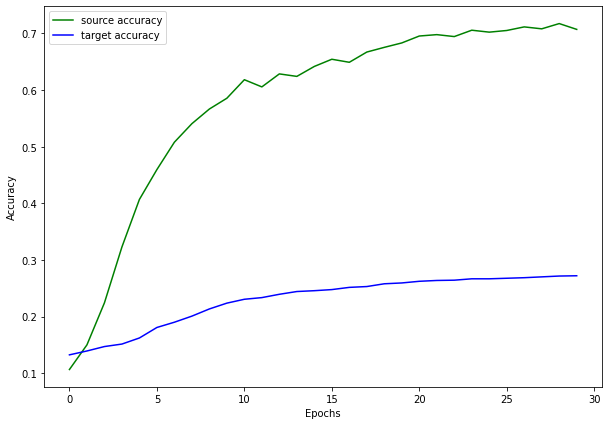

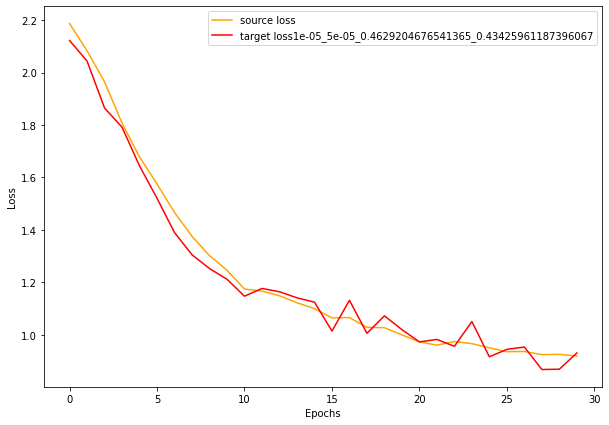

[(1.1003368943929672, 0.24072265625), (0.9640306457877159, 0.30029296875), (0.8087483197450638, 0.4541015625), (0.6845370009541512, 0.6015625), (0.5827065482735634, 0.7099609375), (0.5149370320141315, 0.765625), (0.4650452435016632, 0.80224609375), (0.4249209240078926, 0.8310546875), (0.40131163224577904, 0.8359375), (0.38870691135525703, 0.8427734375), (0.35945432633161545, 0.86328125), (0.36452221497893333, 0.84765625), (0.35269637405872345, 0.85888671875), (0.344072662293911, 0.87255859375), (0.33928221836686134, 0.86083984375), (0.3296418562531471, 0.873046875), (0.3324894644320011, 0.87939453125), (0.3158464580774307, 0.8828125), (0.3186550959944725, 0.876953125), (0.31336240842938423, 0.8759765625), (0.32254697009921074, 0.87109375), (0.2946407161653042, 0.89013671875), (0.30201708152890205, 0.88818359375), (0.30110914260149, 0.888671875), (0.2973296344280243, 0.8876953125), (0.28902519308030605, 0.89697265625), (0.3037962056696415, 0.888671875), (0.2938907314091921, 0.8891601562

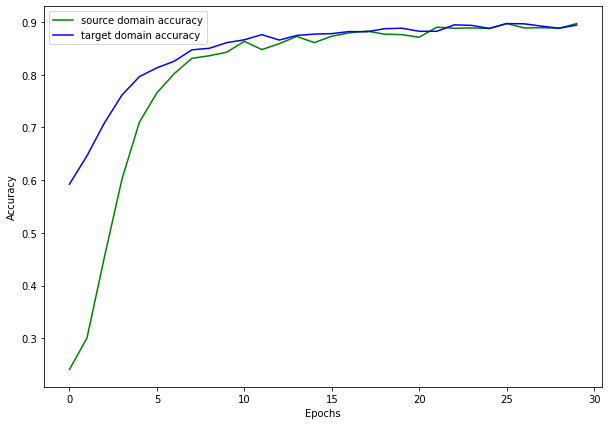

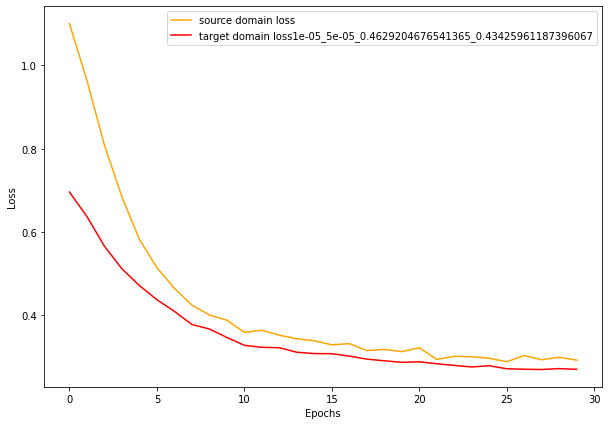

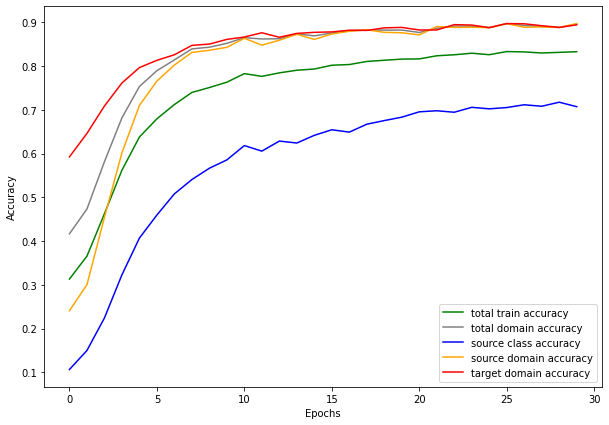

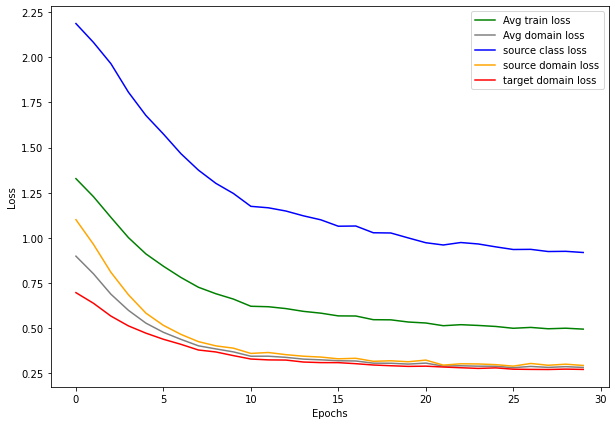

100%|██████████| 8/8 [00:09<00:00,  1.21s/it]

Test Accuracy: 0.27001953125
The highest accuracy is: 0.5 for params: {}


In [ ]:
BATCH_SIZE = 256     
LR = 1e-2            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5   
NUM_EPOCHS = 30      
STEP_SIZE = 10       
GAMMA = 0.1       
ALPHA = 0.1

src_dataloader = DataLoader(src_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss() 
domain_criterion = nn.CrossEntropyLoss()

first_attempt = {
'LR' : LR,
'WEIGHT_DECAY' : WEIGHT_DECAY,
'STEP_SIZE': STEP_SIZE,
'GAMMA' : GAMMA,
'ALPHA':ALPHA,
'accuracy' : 0.3828125
}

best_params = {}

import random
num_iters=8

for i in range(num_iters):    
    print(f'Iteration {i+1} / {num_iters}')
    lr = 10**(-random.randint(3,5))
    wd = 5*10**(-random.randint(4,6))
    gamma = random.uniform(0.1,0.5)
    alpha = random.uniform(0.01,0.5)
    s = f'{lr}_{wd}_{gamma}_{alpha}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=gamma)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=alpha)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)

    result = {  'LR' : lr,
                'WEIGHT_DECAY' : wd,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : gamma,
                'ALPHA' : alpha,
                'accuracy' : res}

    tests.append(result)
    if res > max(ress):
        best_params = result
    ress.append(res)


print(f"The highest accuracy is: {max(ress)} for params: {best_params}")



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.1]
Step 0, Loss 2.2109670639038086


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]



Train Loss: 0.9473, Train Acc: 0.70
Val Loss: 6.6999, Val Acc: 0.42


Starting epoch 2/30, LR = [0.1]
Step 10, Loss 0.47832533717155457


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.5069, Train Acc: 0.86
Val Loss: 7.0796, Val Acc: 0.45


Starting epoch 3/30, LR = [0.1]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.6087, Train Acc: 0.86
Val Loss: 10.2346, Val Acc: 0.36


Starting epoch 4/30, LR = [0.1]


Step 20, Loss 0.9907154440879822


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: 0.8463, Train Acc: 0.86
Val Loss: 10.5710, Val Acc: 0.42


Starting epoch 5/30, LR = [0.1]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Train Loss: 2.0746, Train Acc: 0.84
Val Loss: 33.2237, Val Acc: 0.26


Starting epoch 6/30, LR = [0.1]
Step 30, Loss 8.4049654006958


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 32821.0879, Train Acc: 0.50
Val Loss: 8110808.1484, Val Acc: 0.12


Starting epoch 7/30, LR = [0.1]


Step 40, Loss 1.0576815454158848e+16


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: 33576642749092055111205650432.0000, Train Acc: 0.17
Val Loss: 692126257780610342620240019456.0000, Val Acc: 0.22


Starting epoch 8/30, LR = [0.1]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: nan, Train Acc: 0.13
Val Loss: nan, Val Acc: 0.19


Starting epoch 9/30, LR = [0.1]


Step 50, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.11
Val Loss: nan, Val Acc: 0.19


Starting epoch 10/30, LR = [0.1]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 11/30, LR = [0.010000000000000002]


Step 60, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.11
Val Loss: nan, Val Acc: 0.19


Starting epoch 12/30, LR = [0.010000000000000002]


Step 70, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 13/30, LR = [0.010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 14/30, LR = [0.010000000000000002]


Step 80, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 15/30, LR = [0.010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 16/30, LR = [0.010000000000000002]


Step 90, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 17/30, LR = [0.010000000000000002]


Step 100, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.11
Val Loss: nan, Val Acc: 0.19


Starting epoch 18/30, LR = [0.010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 19/30, LR = [0.010000000000000002]


Step 110, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 20/30, LR = [0.010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.11
Val Loss: nan, Val Acc: 0.19


Starting epoch 21/30, LR = [0.0010000000000000002]


Step 120, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 22/30, LR = [0.0010000000000000002]


Step 130, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 23/30, LR = [0.0010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 24/30, LR = [0.0010000000000000002]


Step 140, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 25/30, LR = [0.0010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 26/30, LR = [0.0010000000000000002]


Step 150, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.11
Val Loss: nan, Val Acc: 0.19


Starting epoch 27/30, LR = [0.0010000000000000002]


Step 160, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 28/30, LR = [0.0010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 29/30, LR = [0.0010000000000000002]


Step 170, Loss nan


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


Starting epoch 30/30, LR = [0.0010000000000000002]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Train Loss: nan, Train Acc: 0.10
Val Loss: nan, Val Acc: 0.19


[(0.9473376820484797, 0.7023952095808383), (0.5069442043701807, 0.8640718562874251), (0.6086946576833725, 0.8592814371257484), (0.8462934195995331, 0.858682634730539), (2.074617231885592, 0.8449101796407186), (32821.08785915375, 0.5041916167664671), (3.3576642749092055e+28, 0.17005988023952096), (nan, 0.13233532934131736), (nan, 0.10538922155688622), (nan, 0.10239520958083832), (nan, 0.1059880239520958), (nan, 0.10479041916167664), (nan, 0.10359281437125749), (nan, 0.10059880239520957), (nan, 0.10479041916167664), (nan, 0.10059880239520957), (nan, 0.10538922155688622), (nan, 0.1029940119760479), (nan, 0.10479041916167664), (nan, 0.10778443113772455), (nan, 0.10479041916167664), (nan, 0.10119760479041916), (nan, 0.10239520958083832), (nan, 0.10419161676646707), (nan, 0.10479041916167664), (nan, 0.1059880239520958), (nan, 0.10239520958083832), (nan, 0.1), (nan, 0.10359281437125749), (nan, 0.1029940119760479)] [(6.6998976469

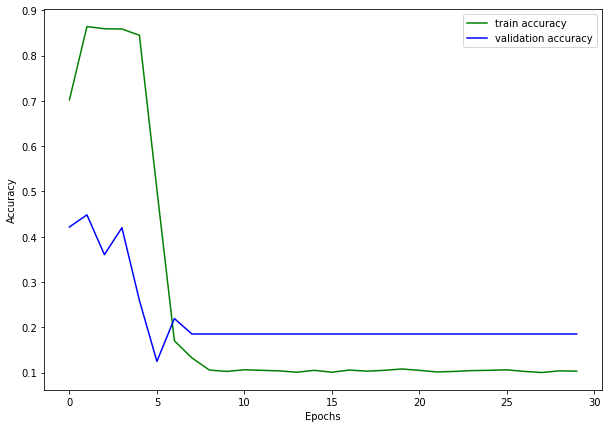

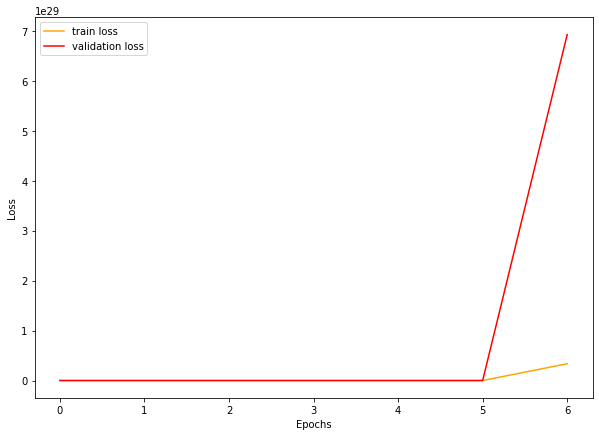

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Test Accuracy: 0.42138671875
Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.0922417640686035


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Train Loss: 1.4752, Train Acc: 0.41
Val Loss: 1.6537, Val Acc: 0.40


Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.33815521001815796


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Train Loss: 0.4633, Train Acc: 0.80
Val Loss: 1.5354, Val Acc: 0.46


Starting epoch 3/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Train Loss: 0.2242, Train Acc: 0.87
Val Loss: 1.6274, Val Acc: 0.47


Starting epoch 4/30, LR = [0.001]


Step 20, Loss 0.17935596406459808


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.1617, Train Acc: 0.88
Val Loss: 1.7109, Val Acc: 0.47


Starting epoch 5/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.1400, Train Acc: 0.88
Val Loss: 1.7635, Val Acc: 0.47


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.13043685257434845


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.1179, Train Acc: 0.89
Val Loss: 1.7914, Val Acc: 0.47


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.08395037055015564


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.1020, Train Acc: 0.89
Val Loss: 1.8093, Val Acc: 0.48


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0917, Train Acc: 0.90
Val Loss: 1.8176, Val Acc: 0.48


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.10478010773658752


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0909, Train Acc: 0.90
Val Loss: 1.8139, Val Acc: 0.48


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0804, Train Acc: 0.90
Val Loss: 1.8106, Val Acc: 0.48


Starting epoch 11/30, LR = [0.0001]


Step 60, Loss 0.09422022849321365


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0821, Train Acc: 0.90
Val Loss: 1.8109, Val Acc: 0.48


Starting epoch 12/30, LR = [0.0001]


Step 70, Loss 0.07205875962972641


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0755, Train Acc: 0.90
Val Loss: 1.8108, Val Acc: 0.48


Starting epoch 13/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0771, Train Acc: 0.90
Val Loss: 1.8115, Val Acc: 0.48


Starting epoch 14/30, LR = [0.0001]


Step 80, Loss 0.07526291161775589


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0764, Train Acc: 0.90
Val Loss: 1.8114, Val Acc: 0.48


Starting epoch 15/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0838, Train Acc: 0.90
Val Loss: 1.8124, Val Acc: 0.49


Starting epoch 16/30, LR = [0.0001]


Step 90, Loss 0.06324537843465805


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0742, Train Acc: 0.90
Val Loss: 1.8133, Val Acc: 0.49


Starting epoch 17/30, LR = [0.0001]


Step 100, Loss 0.09539460390806198


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0767, Train Acc: 0.91
Val Loss: 1.8146, Val Acc: 0.49


Starting epoch 18/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0747, Train Acc: 0.90
Val Loss: 1.8157, Val Acc: 0.49


Starting epoch 19/30, LR = [0.0001]


Step 110, Loss 0.08893360197544098


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0748, Train Acc: 0.90
Val Loss: 1.8168, Val Acc: 0.49


Starting epoch 20/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0722, Train Acc: 0.91
Val Loss: 1.8166, Val Acc: 0.49


Starting epoch 21/30, LR = [1e-05]


Step 120, Loss 0.056311026215553284


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0752, Train Acc: 0.90
Val Loss: 1.8166, Val Acc: 0.49


Starting epoch 22/30, LR = [1e-05]


Step 130, Loss 0.08751659095287323


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0729, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 23/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0729, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 24/30, LR = [1e-05]


Step 140, Loss 0.08132731914520264


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0766, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 25/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0755, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 26/30, LR = [1e-05]


Step 150, Loss 0.089764304459095


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0748, Train Acc: 0.90
Val Loss: 1.8168, Val Acc: 0.49


Starting epoch 27/30, LR = [1e-05]


Step 160, Loss 0.09392055869102478


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0745, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 28/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0727, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 29/30, LR = [1e-05]


Step 170, Loss 0.09358160942792892


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0762, Train Acc: 0.90
Val Loss: 1.8167, Val Acc: 0.49


Starting epoch 30/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.0730, Train Acc: 0.90
Val Loss: 1.8168, Val Acc: 0.49


[(1.4752057294050853, 0.40718562874251496), (0.4632634570201238, 0.8047904191616766), (0.22416549921035767, 0.8664670658682635), (0.16165974736213684, 0.8754491017964072), (0.14004815245668092, 0.8808383233532934), (0.11790815492471059, 0.88562874251497), (0.10195948804418246, 0.8910179640718563), (0.09174375360210736, 0.895808383233533), (0.09093484282493591, 0.8982035928143712), (0.08038909298678239, 0.8970059880239521), (0.08213899408777554, 0.8970059880239521), (0.07546545937657356, 0.9023952095808383), (0.07709006716807683, 0.9017964071856287), (0.07637217206259568, 0.9005988023952096), (0.08375898624459903, 0.8994011976047904), (0.07419620702664058, 0.9035928143712575), (0.0767037384212017, 0.9077844311377246), (0.07470581121742725, 0.9011976047904192), (0.07483200480540593, 0.9047904191616767), (0.07224799071749051, 0.9083832335329342), (0.07515113304058711, 0.9029940119760479), (0.07293402776122093, 0.904191

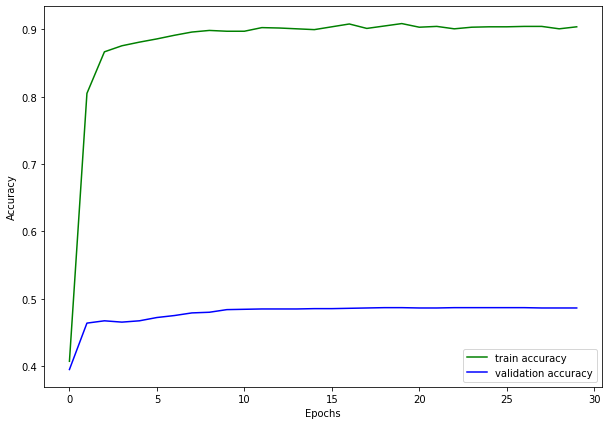

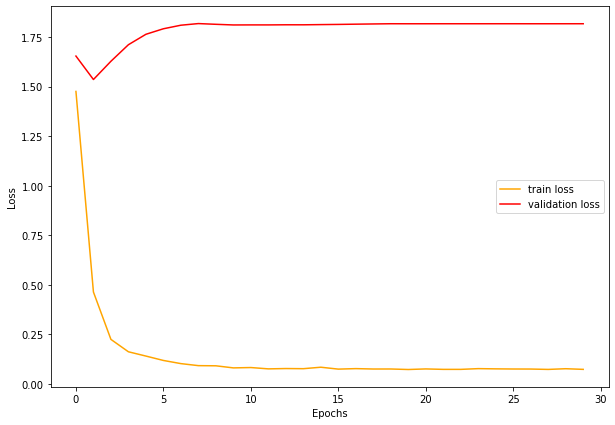

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Test Accuracy: 0.4638671875
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}]
[0.470703125, 0.42138671875, 0.4638671875]
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.20841383934021


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]



Train Loss: 0.7482, Train Acc: 0.67
Val Loss: 1.9236, Val Acc: 0.47


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.0661119893193245


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.1171, Train Acc: 0.89
Val Loss: 2.7040, Val Acc: 0.49


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0725, Train Acc: 0.90
Val Loss: 3.3183, Val Acc: 0.47


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.05546976625919342


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0490, Train Acc: 0.90
Val Loss: 3.5235, Val Acc: 0.47


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0282, Train Acc: 0.91
Val Loss: 3.6522, Val Acc: 0.47


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.010249881073832512


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0198, Train Acc: 0.91
Val Loss: 3.5800, Val Acc: 0.49


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.005982004106044769


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0172, Train Acc: 0.91
Val Loss: 3.6101, Val Acc: 0.49


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0127, Train Acc: 0.92
Val Loss: 3.6948, Val Acc: 0.48


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.011925477534532547


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0068, Train Acc: 0.92
Val Loss: 3.6464, Val Acc: 0.49


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0063, Train Acc: 0.92
Val Loss: 3.6405, Val Acc: 0.49


Starting epoch 11/30, LR = [0.001]


Step 60, Loss 0.0042563192546367645


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0057, Train Acc: 0.92
Val Loss: 3.6407, Val Acc: 0.49


Starting epoch 12/30, LR = [0.001]


Step 70, Loss 0.00877118669450283


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.0084, Train Acc: 0.92
Val Loss: 3.6399, Val Acc: 0.50


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0077, Train Acc: 0.92
Val Loss: 3.6343, Val Acc: 0.49


Starting epoch 14/30, LR = [0.001]


Step 80, Loss 0.00650504045188427


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0064, Train Acc: 0.92
Val Loss: 3.6322, Val Acc: 0.50


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.6320, Val Acc: 0.50


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 0.0020807813853025436


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.6357, Val Acc: 0.50


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 0.0060918573290109634


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0073, Train Acc: 0.92
Val Loss: 3.6364, Val Acc: 0.50


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0065, Train Acc: 0.92
Val Loss: 3.6359, Val Acc: 0.50


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 0.008512986823916435


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0080, Train Acc: 0.92
Val Loss: 3.6350, Val Acc: 0.50


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0042, Train Acc: 0.92
Val Loss: 3.6343, Val Acc: 0.50


Starting epoch 21/30, LR = [0.0001]


Step 120, Loss 0.003714965656399727


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0047, Train Acc: 0.92
Val Loss: 3.6343, Val Acc: 0.50


Starting epoch 22/30, LR = [0.0001]


Step 130, Loss 0.00869026966392994


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0051, Train Acc: 0.92
Val Loss: 3.6343, Val Acc: 0.50


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0054, Train Acc: 0.92
Val Loss: 3.6345, Val Acc: 0.50


Starting epoch 24/30, LR = [0.0001]


Step 140, Loss 0.005544602870941162


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0052, Train Acc: 0.92
Val Loss: 3.6347, Val Acc: 0.50


Starting epoch 25/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 3.6349, Val Acc: 0.50


Starting epoch 26/30, LR = [0.0001]


Step 150, Loss 0.005141258239746094


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0055, Train Acc: 0.92
Val Loss: 3.6354, Val Acc: 0.50


Starting epoch 27/30, LR = [0.0001]


Step 160, Loss 0.004220945760607719


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0074, Train Acc: 0.92
Val Loss: 3.6356, Val Acc: 0.50


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0062, Train Acc: 0.92
Val Loss: 3.6356, Val Acc: 0.50


Starting epoch 29/30, LR = [0.0001]


Step 170, Loss 0.0030478499829769135


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0038, Train Acc: 0.92
Val Loss: 3.6355, Val Acc: 0.50


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.0053, Train Acc: 0.92
Val Loss: 3.6354, Val Acc: 0.50


[(0.7482350592811903, 0.6724550898203593), (0.11706426118810971, 0.8850299401197604), (0.0724943255384763, 0.8976047904191616), (0.049003615975379944, 0.9047904191616767), (0.02816935038814942, 0.9089820359281438), (0.019821540762980778, 0.9131736526946108), (0.017219015086690586, 0.9137724550898204), (0.012650857989986738, 0.9161676646706587), (0.0068335312729080515, 0.9179640718562875), (0.006324753786126773, 0.9191616766467066), (0.005737134255468845, 0.9191616766467066), (0.00842802164455255, 0.9173652694610779), (0.007707414838174979, 0.9173652694610779), (0.006389182681838672, 0.9191616766467066), (0.005859320983290672, 0.918562874251497), (0.004979442805051804, 0.9191616766467066), (0.007332117607196172, 0.9191616766467066), (0.006524027946094672, 0.9191616766467066), (0.008017778707047304, 0.9179640718562875), (0.004218040344615777, 0.9191616766467066), (0.004723499529063702, 0.9197604790419162), (0.00511493

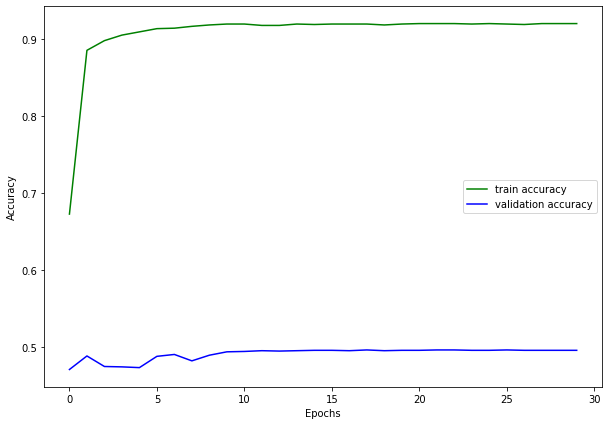

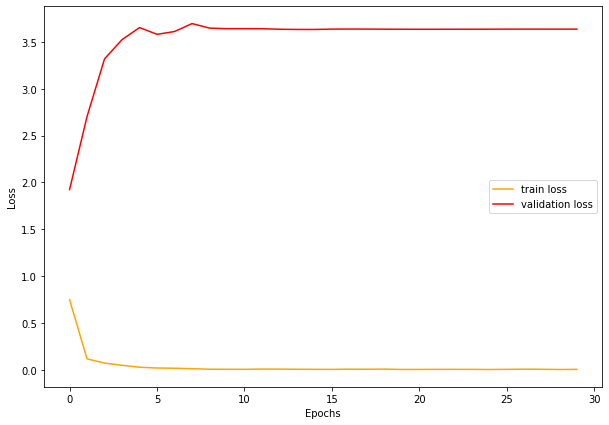

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Test Accuracy: 0.470703125
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 1.7679893970489502


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]



Train Loss: 0.6633, Train Acc: 0.72
Val Loss: 1.9632, Val Acc: 0.46


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.22386611998081207


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.1239, Train Acc: 0.88
Val Loss: 2.9024, Val Acc: 0.46


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0776, Train Acc: 0.89
Val Loss: 3.2396, Val Acc: 0.47


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.08117440342903137


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0498, Train Acc: 0.90
Val Loss: 3.4172, Val Acc: 0.48


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0294, Train Acc: 0.91
Val Loss: 3.5569, Val Acc: 0.47


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.010693585500121117


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0185, Train Acc: 0.91
Val Loss: 3.6151, Val Acc: 0.47


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.02171405591070652


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0115, Train Acc: 0.92
Val Loss: 3.6141, Val Acc: 0.47


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0116, Train Acc: 0.92
Val Loss: 3.5530, Val Acc: 0.48


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.0040266066789627075


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0076, Train Acc: 0.92
Val Loss: 3.5696, Val Acc: 0.48


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0061, Train Acc: 0.92
Val Loss: 3.6072, Val Acc: 0.48


Starting epoch 11/30, LR = [0.001]


Step 60, Loss 0.0043482594192028046


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0079, Train Acc: 0.92
Val Loss: 3.6097, Val Acc: 0.48


Starting epoch 12/30, LR = [0.001]


Step 70, Loss 0.00746740959584713


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0061, Train Acc: 0.92
Val Loss: 3.6058, Val Acc: 0.48


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0086, Train Acc: 0.92
Val Loss: 3.5997, Val Acc: 0.48


Starting epoch 14/30, LR = [0.001]


Step 80, Loss 0.0067105162888765335


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0084, Train Acc: 0.92
Val Loss: 3.5970, Val Acc: 0.48


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0044, Train Acc: 0.92
Val Loss: 3.5977, Val Acc: 0.48


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 0.004720514640212059


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0032, Train Acc: 0.92
Val Loss: 3.5962, Val Acc: 0.48


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 0.012422792613506317


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0066, Train Acc: 0.92
Val Loss: 3.5951, Val Acc: 0.48


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0041, Train Acc: 0.92
Val Loss: 3.5924, Val Acc: 0.48


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 0.007754707708954811


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0061, Train Acc: 0.92
Val Loss: 3.5900, Val Acc: 0.48


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0072, Train Acc: 0.92
Val Loss: 3.5885, Val Acc: 0.48


Starting epoch 21/30, LR = [0.0001]


Step 120, Loss 0.006201410666108131


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0057, Train Acc: 0.92
Val Loss: 3.5885, Val Acc: 0.48


Starting epoch 22/30, LR = [0.0001]


Step 130, Loss 0.003303069621324539


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0028, Train Acc: 0.92
Val Loss: 3.5884, Val Acc: 0.48


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0063, Train Acc: 0.92
Val Loss: 3.5882, Val Acc: 0.48


Starting epoch 24/30, LR = [0.0001]


Step 140, Loss 0.002668270841240883


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0061, Train Acc: 0.92
Val Loss: 3.5878, Val Acc: 0.48


Starting epoch 25/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0067, Train Acc: 0.92
Val Loss: 3.5871, Val Acc: 0.48


Starting epoch 26/30, LR = [0.0001]


Step 150, Loss 0.004938788712024689


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0033, Train Acc: 0.92
Val Loss: 3.5864, Val Acc: 0.48


Starting epoch 27/30, LR = [0.0001]


Step 160, Loss 0.004040632396936417


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0048, Train Acc: 0.92
Val Loss: 3.5858, Val Acc: 0.48


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0048, Train Acc: 0.92
Val Loss: 3.5851, Val Acc: 0.48


Starting epoch 29/30, LR = [0.0001]


Step 170, Loss 0.0034001991152763367


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0044, Train Acc: 0.92
Val Loss: 3.5848, Val Acc: 0.48


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.0072, Train Acc: 0.92
Val Loss: 3.5848, Val Acc: 0.48


[(0.6633256301283836, 0.7173652694610778), (0.12394619733095169, 0.881437125748503), (0.07755265260736148, 0.8928143712574851), (0.049818788965543113, 0.9005988023952096), (0.029447535052895546, 0.9107784431137724), (0.018513647839426994, 0.9131736526946108), (0.011544392133752504, 0.9167664670658683), (0.01162675985445579, 0.9167664670658683), (0.0076234641795357065, 0.9179640718562875), (0.006130646293361981, 0.9191616766467066), (0.007894590807457766, 0.918562874251497), (0.00610583849872152, 0.9191616766467066), (0.008563346850375334, 0.9161676646706587), (0.008427854937811693, 0.9167664670658683), (0.004366042713324229, 0.9191616766467066), (0.0031642671674489975, 0.9197604790419162), (0.006634306783477466, 0.9179640718562875), (0.004075983849664529, 0.9197604790419162), (0.006140143300096194, 0.918562874251497), (0.007168058616419633, 0.9167664670658683), (0.005702023083964984, 0.9179640718562875), (0.00281955

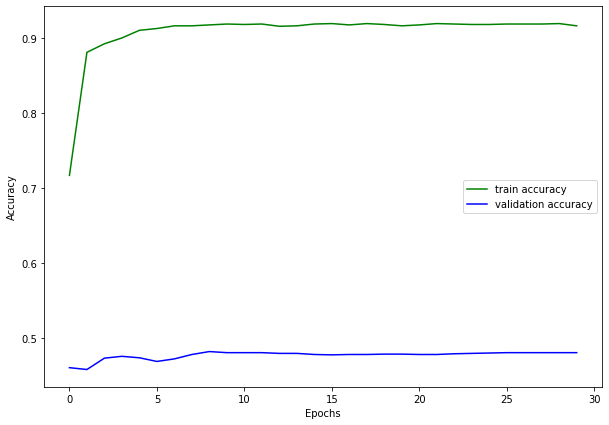

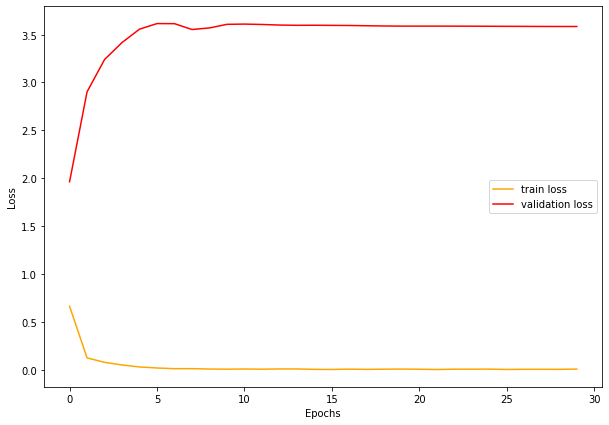

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Test Accuracy: 0.4609375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}]
[0.470703125, 0.42138671875, 0.4638671875, 0.470703125, 0.4609375]
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.0780394077301025


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]



Train Loss: 0.7236, Train Acc: 0.69
Val Loss: 1.8477, Val Acc: 0.48


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.08448148518800735


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 0.1281, Train Acc: 0.88
Val Loss: 2.5982, Val Acc: 0.50


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0712, Train Acc: 0.90
Val Loss: 2.9864, Val Acc: 0.50


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.03302460163831711


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0430, Train Acc: 0.91
Val Loss: 3.1697, Val Acc: 0.49


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0272, Train Acc: 0.91
Val Loss: 3.2340, Val Acc: 0.50


Starting epoch 6/30, LR = [0.001]


Step 30, Loss 0.012893544510006905


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0195, Train Acc: 0.91
Val Loss: 3.2384, Val Acc: 0.50


Starting epoch 7/30, LR = [0.001]


Step 40, Loss 0.015949204564094543


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0171, Train Acc: 0.91
Val Loss: 3.2462, Val Acc: 0.50


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0204, Train Acc: 0.91
Val Loss: 3.2530, Val Acc: 0.50


Starting epoch 9/30, LR = [0.001]


Step 50, Loss 0.017405329272150993


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0154, Train Acc: 0.92
Val Loss: 3.2637, Val Acc: 0.50


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0134, Train Acc: 0.92
Val Loss: 3.2744, Val Acc: 0.49


Starting epoch 11/30, LR = [0.0001]


Step 60, Loss 0.014175472781062126


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0179, Train Acc: 0.91
Val Loss: 3.2750, Val Acc: 0.49


Starting epoch 12/30, LR = [0.0001]


Step 70, Loss 0.011111197993159294


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0145, Train Acc: 0.91
Val Loss: 3.2752, Val Acc: 0.49


Starting epoch 13/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0158, Train Acc: 0.91
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 14/30, LR = [0.0001]


Step 80, Loss 0.028424261137843132


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0209, Train Acc: 0.91
Val Loss: 3.2754, Val Acc: 0.49


Starting epoch 15/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0160, Train Acc: 0.92
Val Loss: 3.2755, Val Acc: 0.49


Starting epoch 16/30, LR = [1e-05]


Step 90, Loss 0.029289603233337402


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0169, Train Acc: 0.91
Val Loss: 3.2754, Val Acc: 0.49


Starting epoch 17/30, LR = [1e-05]


Step 100, Loss 0.0071929022669792175


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0169, Train Acc: 0.92
Val Loss: 3.2754, Val Acc: 0.49


Starting epoch 18/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0140, Train Acc: 0.91
Val Loss: 3.2754, Val Acc: 0.49


Starting epoch 19/30, LR = [1e-05]


Step 110, Loss 0.009244510903954506


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.0166, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 20/30, LR = [1e-05]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0119, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 21/30, LR = [1.0000000000000002e-06]


Step 120, Loss 0.007807610556483269


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0180, Train Acc: 0.91
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 22/30, LR = [1.0000000000000002e-06]


Step 130, Loss 0.007780374959111214


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0121, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 23/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0173, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 24/30, LR = [1.0000000000000002e-06]


Step 140, Loss 0.012102587148547173


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0150, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 25/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0133, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 26/30, LR = [1.0000000000000002e-07]


Step 150, Loss 0.004821352660655975


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0126, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 27/30, LR = [1.0000000000000002e-07]


Step 160, Loss 0.013789691962301731


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0144, Train Acc: 0.91
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 28/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0117, Train Acc: 0.92
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 29/30, LR = [1.0000000000000002e-07]


Step 170, Loss 0.010432494804263115


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0191, Train Acc: 0.91
Val Loss: 3.2753, Val Acc: 0.49


Starting epoch 30/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]



Train Loss: 0.0204, Train Acc: 0.91
Val Loss: 3.2753, Val Acc: 0.49


[(0.7235832437872887, 0.6868263473053893), (0.12813656777143478, 0.8778443113772455), (0.07124331407248974, 0.8952095808383234), (0.04302112509806951, 0.907185628742515), (0.027210256550461054, 0.9143712574850299), (0.019542310386896133, 0.9149700598802395), (0.017136113718152046, 0.9143712574850299), (0.020393901815017063, 0.9107784431137724), (0.015415372947851816, 0.9155688622754491), (0.013423542802532515, 0.9155688622754491), (0.017892871362467606, 0.9143712574850299), (0.014462111828227838, 0.9149700598802395), (0.015823115905125935, 0.9149700598802395), (0.020898677719136078, 0.9149700598802395), (0.01596668517837922, 0.9161676646706587), (0.016855723224580288, 0.9143712574850299), (0.016931259383757908, 0.9167664670658683), (0.013960463460534811, 0.9149700598802395), (0.0166412106094261, 0.9155688622754491), (0.011856253879765669, 0.9167664670658683), (0.018018308250854414, 0.9149700598802395), (0.0120518937

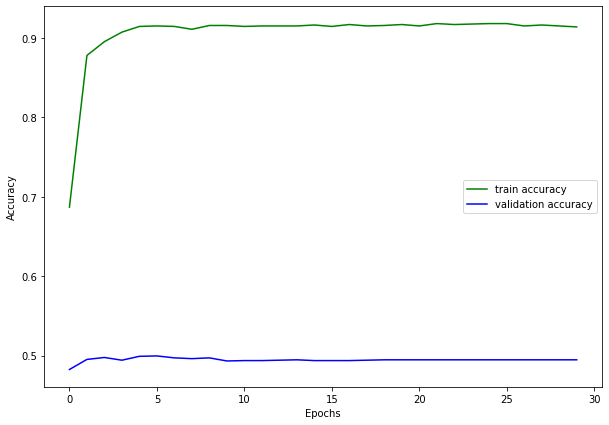

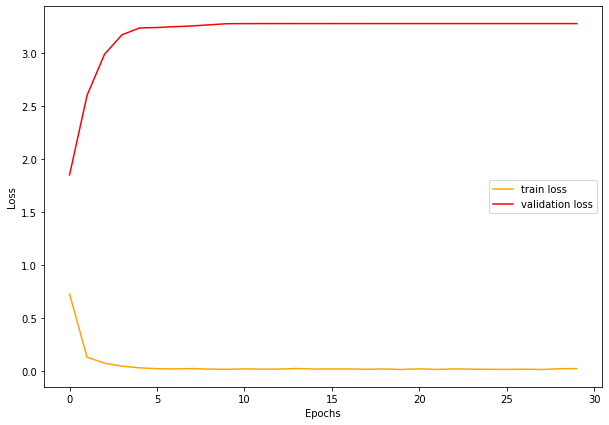

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Test Accuracy: 0.482421875
new best found
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.281390905380249


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]



Train Loss: 0.7558, Train Acc: 0.67
Val Loss: 1.7559, Val Acc: 0.49


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.06823019683361053


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.1130, Train Acc: 0.89
Val Loss: 2.5739, Val Acc: 0.49


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0862, Train Acc: 0.89
Val Loss: 3.1124, Val Acc: 0.50


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.045176878571510315


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0469, Train Acc: 0.91
Val Loss: 3.3275, Val Acc: 0.49


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0295, Train Acc: 0.91
Val Loss: 3.5274, Val Acc: 0.47


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.009767284616827965


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0158, Train Acc: 0.92
Val Loss: 3.5391, Val Acc: 0.48


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.010453145951032639


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0136, Train Acc: 0.92
Val Loss: 3.5042, Val Acc: 0.48


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0140, Train Acc: 0.92
Val Loss: 3.5522, Val Acc: 0.48


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.011171482503414154


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0101, Train Acc: 0.92
Val Loss: 3.5650, Val Acc: 0.48


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0064, Train Acc: 0.92
Val Loss: 3.5006, Val Acc: 0.49


Starting epoch 11/30, LR = [0.001]


Step 60, Loss 0.0018490087240934372


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0060, Train Acc: 0.92
Val Loss: 3.4981, Val Acc: 0.49


Starting epoch 12/30, LR = [0.001]


Step 70, Loss 0.003962811082601547


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.4969, Val Acc: 0.49


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.4994, Val Acc: 0.49


Starting epoch 14/30, LR = [0.001]


Step 80, Loss 0.009427700191736221


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.4984, Val Acc: 0.49


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.5002, Val Acc: 0.49


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 0.012372061610221863


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0049, Train Acc: 0.92
Val Loss: 3.4998, Val Acc: 0.49


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 0.0042661987245082855


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0044, Train Acc: 0.92
Val Loss: 3.4991, Val Acc: 0.49


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.5004, Val Acc: 0.49


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 0.0036012232303619385


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0063, Train Acc: 0.92
Val Loss: 3.5020, Val Acc: 0.49


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0041, Train Acc: 0.92
Val Loss: 3.5012, Val Acc: 0.49


Starting epoch 21/30, LR = [0.0001]


Step 120, Loss 0.008505111560225487


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.5015, Val Acc: 0.49


Starting epoch 22/30, LR = [0.0001]


Step 130, Loss 0.0031235702335834503


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0054, Train Acc: 0.92
Val Loss: 3.5020, Val Acc: 0.49


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0046, Train Acc: 0.92
Val Loss: 3.5020, Val Acc: 0.49


Starting epoch 24/30, LR = [0.0001]


Step 140, Loss 0.00390871986746788


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0040, Train Acc: 0.92
Val Loss: 3.5021, Val Acc: 0.49


Starting epoch 25/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0051, Train Acc: 0.92
Val Loss: 3.5021, Val Acc: 0.49


Starting epoch 26/30, LR = [0.0001]


Step 150, Loss 0.001799408346414566


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0047, Train Acc: 0.92
Val Loss: 3.5022, Val Acc: 0.49


Starting epoch 27/30, LR = [0.0001]


Step 160, Loss 0.002841383218765259


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 0.0037, Train Acc: 0.92
Val Loss: 3.5022, Val Acc: 0.49


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.5022, Val Acc: 0.49


Starting epoch 29/30, LR = [0.0001]


Step 170, Loss 0.0007042903453111649


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 0.0045, Train Acc: 0.92
Val Loss: 3.5022, Val Acc: 0.49


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Train Loss: 0.0037, Train Acc: 0.92
Val Loss: 3.5023, Val Acc: 0.49


[(0.7558282390236855, 0.670059880239521), (0.11298636843760808, 0.8868263473053892), (0.08622244310875733, 0.8922155688622755), (0.046872055158019066, 0.9077844311377246), (0.02951583017905553, 0.9101796407185628), (0.015767105855047703, 0.9155688622754491), (0.013603192754089832, 0.9167664670658683), (0.014023416365186373, 0.9167664670658683), (0.010126324060062567, 0.9167664670658683), (0.006375644666453202, 0.918562874251497), (0.005970661838849385, 0.9191616766467066), (0.005007055898507436, 0.9197604790419162), (0.005828085665901502, 0.9191616766467066), (0.005878554346660773, 0.9197604790419162), (0.005016215766469638, 0.9191616766467066), (0.004934445644418399, 0.9191616766467066), (0.004377443032960097, 0.9191616766467066), (0.0049813684696952505, 0.9191616766467066), (0.006313680671155453, 0.918562874251497), (0.004054404484728972, 0.9191616766467066), (0.005943022668361664, 0.9179640718562875), (0.00543940

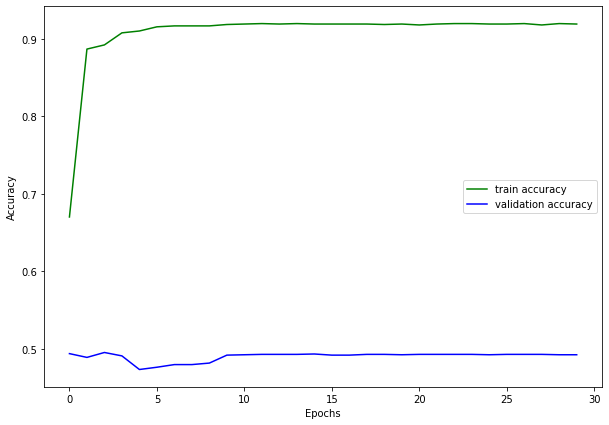

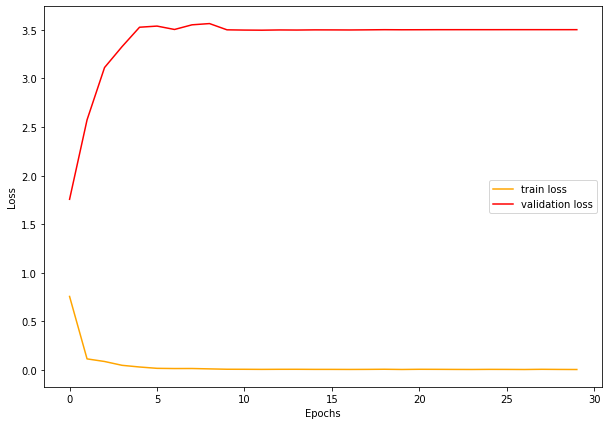

100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Test Accuracy: 0.49365234375
new best found
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.078146457672119


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Train Loss: 0.7078, Train Acc: 0.70
Val Loss: 2.1662, Val Acc: 0.47


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.1203857958316803


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Train Loss: 0.1065, Train Acc: 0.88
Val Loss: 3.1423, Val Acc: 0.47


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.0780, Train Acc: 0.90
Val Loss: 3.5701, Val Acc: 0.48


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.03761989623308182


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Train Loss: 0.0413, Train Acc: 0.91
Val Loss: 3.8144, Val Acc: 0.47


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0309, Train Acc: 0.91
Val Loss: 3.8292, Val Acc: 0.48


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.023902425542473793


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0238, Train Acc: 0.91
Val Loss: 3.9269, Val Acc: 0.47


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.015444105491042137


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0172, Train Acc: 0.91
Val Loss: 3.9319, Val Acc: 0.47


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0117, Train Acc: 0.92
Val Loss: 3.9052, Val Acc: 0.47


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.007575660943984985


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0102, Train Acc: 0.92
Val Loss: 3.9516, Val Acc: 0.47


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0091, Train Acc: 0.92
Val Loss: 4.0165, Val Acc: 0.47


Starting epoch 11/30, LR = [0.01]


Step 60, Loss 0.003678949549794197


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0041, Train Acc: 0.92
Val Loss: 4.0412, Val Acc: 0.47


Starting epoch 12/30, LR = [0.01]


Step 70, Loss 0.004193369299173355


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0063, Train Acc: 0.92
Val Loss: 4.0254, Val Acc: 0.47


Starting epoch 13/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0042, Train Acc: 0.92
Val Loss: 4.0183, Val Acc: 0.47


Starting epoch 14/30, LR = [0.01]


Step 80, Loss 0.002179456874728203


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0041, Train Acc: 0.92
Val Loss: 4.0504, Val Acc: 0.47


Starting epoch 15/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0036, Train Acc: 0.92
Val Loss: 4.0911, Val Acc: 0.47


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 0.0025812797248363495


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0051, Train Acc: 0.92
Val Loss: 4.0851, Val Acc: 0.47


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 0.0026894044131040573


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0045, Train Acc: 0.92
Val Loss: 4.0804, Val Acc: 0.47


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0030, Train Acc: 0.92
Val Loss: 4.0774, Val Acc: 0.47


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 0.0018598679453134537


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0025, Train Acc: 0.92
Val Loss: 4.0724, Val Acc: 0.47


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0032, Train Acc: 0.92
Val Loss: 4.0710, Val Acc: 0.47


Starting epoch 21/30, LR = [0.001]


Step 120, Loss 0.0010008662939071655


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.0027, Train Acc: 0.92
Val Loss: 4.0706, Val Acc: 0.47


Starting epoch 22/30, LR = [0.001]


Step 130, Loss 0.005829675123095512


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0036, Train Acc: 0.92
Val Loss: 4.0700, Val Acc: 0.47


Starting epoch 23/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0033, Train Acc: 0.92
Val Loss: 4.0710, Val Acc: 0.47


Starting epoch 24/30, LR = [0.001]


Step 140, Loss 0.001614641398191452


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0036, Train Acc: 0.92
Val Loss: 4.0676, Val Acc: 0.47


Starting epoch 25/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0037, Train Acc: 0.92
Val Loss: 4.0663, Val Acc: 0.47


Starting epoch 26/30, LR = [0.001]


Step 150, Loss 0.0019678454846143723


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0028, Train Acc: 0.92
Val Loss: 4.0659, Val Acc: 0.47


Starting epoch 27/30, LR = [0.001]


Step 160, Loss 0.0021181609481573105


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 4.0668, Val Acc: 0.47


Starting epoch 28/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.0032, Train Acc: 0.92
Val Loss: 4.0688, Val Acc: 0.47


Starting epoch 29/30, LR = [0.001]


Step 170, Loss 0.0019454285502433777


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0025, Train Acc: 0.92
Val Loss: 4.0692, Val Acc: 0.47


Starting epoch 30/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.0029, Train Acc: 0.92
Val Loss: 4.0689, Val Acc: 0.47


[(0.7077994892994562, 0.7), (0.10648571699857712, 0.8838323353293414), (0.07798280070225398, 0.9005988023952096), (0.04133174009621143, 0.9065868263473054), (0.030867950680355232, 0.9089820359281438), (0.023815795468787353, 0.9107784431137724), (0.017181580886244774, 0.9137724550898204), (0.011729681864380836, 0.9179640718562875), (0.010165698826313019, 0.918562874251497), (0.009122312689820925, 0.9161676646706587), (0.004132569457093875, 0.9197604790419162), (0.006274237918357055, 0.9191616766467066), (0.004223985287050406, 0.9191616766467066), (0.004062654140094916, 0.9197604790419162), (0.0035925585155685744, 0.9191616766467066), (0.005129745850960414, 0.9179640718562875), (0.0045304618154962855, 0.9197604790419162), (0.0030009796222050986, 0.9197604790419162), (0.0025326519583662352, 0.9191616766467066), (0.0031609960521260896, 0.9197604790419162), (0.002737109549343586, 0.9197604790419162), (0.00359743429968754

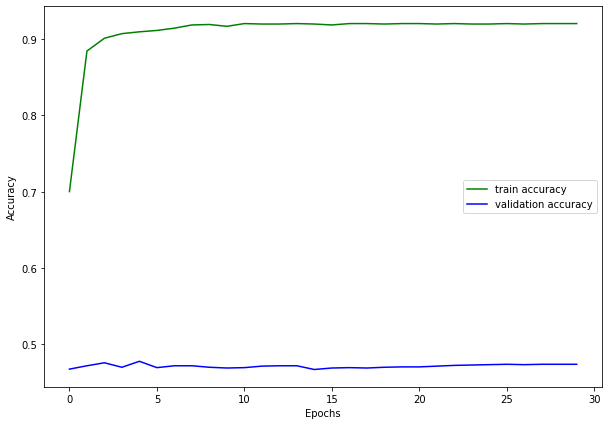

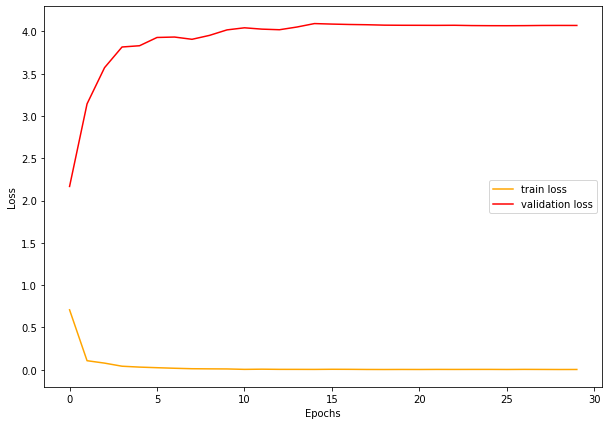

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Test Accuracy: 0.4677734375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}]
[0.470703125, 0.42138671875, 0.4638671875, 0.470703125, 0.4609375, 0.482421875, 0.49365234375, 0.4677734375]
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.1416149139404297


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]



Train Loss: 0.7099, Train Acc: 0.68
Val Loss: 1.8012, Val Acc: 0.48


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.15670399367809296


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.1308, Train Acc: 0.89
Val Loss: 2.7400, Val Acc: 0.48


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0755, Train Acc: 0.89
Val Loss: 3.1743, Val Acc: 0.48


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.04219375178217888


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0454, Train Acc: 0.90
Val Loss: 3.3658, Val Acc: 0.48


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0261, Train Acc: 0.91
Val Loss: 3.4464, Val Acc: 0.48


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.031160401180386543


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0220, Train Acc: 0.91
Val Loss: 3.4206, Val Acc: 0.49


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.010816941037774086


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0164, Train Acc: 0.92
Val Loss: 3.3969, Val Acc: 0.49


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0094, Train Acc: 0.92
Val Loss: 3.3953, Val Acc: 0.49


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.00310378335416317


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0078, Train Acc: 0.92
Val Loss: 3.4206, Val Acc: 0.50


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0067, Train Acc: 0.92
Val Loss: 3.4709, Val Acc: 0.49


Starting epoch 11/30, LR = [0.0005]


Step 60, Loss 0.005661312490701675


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0056, Train Acc: 0.92
Val Loss: 3.4724, Val Acc: 0.49


Starting epoch 12/30, LR = [0.0005]


Step 70, Loss 0.011347822844982147


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0078, Train Acc: 0.92
Val Loss: 3.4721, Val Acc: 0.49


Starting epoch 13/30, LR = [0.0005]



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0046, Train Acc: 0.92
Val Loss: 3.4705, Val Acc: 0.49


Starting epoch 14/30, LR = [0.0005]


Step 80, Loss 0.006982792168855667


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0068, Train Acc: 0.92
Val Loss: 3.4681, Val Acc: 0.49


Starting epoch 15/30, LR = [0.0005]



100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.0069, Train Acc: 0.92
Val Loss: 3.4651, Val Acc: 0.49


Starting epoch 16/30, LR = [0.0005]


Step 90, Loss 0.0078356321901083


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0089, Train Acc: 0.92
Val Loss: 3.4630, Val Acc: 0.49


Starting epoch 17/30, LR = [0.0005]


Step 100, Loss 0.0024807285517454147


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.0042, Train Acc: 0.92
Val Loss: 3.4612, Val Acc: 0.50


Starting epoch 18/30, LR = [0.0005]



100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Loss: 0.0048, Train Acc: 0.92
Val Loss: 3.4581, Val Acc: 0.50


Starting epoch 19/30, LR = [0.0005]


Step 110, Loss 0.0035089850425720215


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0054, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 20/30, LR = [0.0005]



100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.0078, Train Acc: 0.92
Val Loss: 3.4562, Val Acc: 0.49


Starting epoch 21/30, LR = [2.5e-05]


Step 120, Loss 0.01209227740764618


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0082, Train Acc: 0.92
Val Loss: 3.4562, Val Acc: 0.49


Starting epoch 22/30, LR = [2.5e-05]


Step 130, Loss 0.005781941115856171


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Loss: 0.0062, Train Acc: 0.92
Val Loss: 3.4563, Val Acc: 0.49


Starting epoch 23/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0056, Train Acc: 0.92
Val Loss: 3.4564, Val Acc: 0.49


Starting epoch 24/30, LR = [2.5e-05]


Step 140, Loss 0.0068639591336250305


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0052, Train Acc: 0.92
Val Loss: 3.4565, Val Acc: 0.49


Starting epoch 25/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Loss: 0.0060, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 26/30, LR = [2.5e-05]


Step 150, Loss 0.005256744101643562


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0056, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 27/30, LR = [2.5e-05]


Step 160, Loss 0.0030862055718898773


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.0040, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 28/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.0053, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 29/30, LR = [2.5e-05]


Step 170, Loss 0.0021659154444932938


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


Starting epoch 30/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]



Train Loss: 0.0066, Train Acc: 0.92
Val Loss: 3.4566, Val Acc: 0.49


[(0.7098606154322624, 0.6796407185628742), (0.13081063205997148, 0.8850299401197604), (0.07549650377283494, 0.8934131736526946), (0.045376354828476906, 0.9023952095808383), (0.026130350772291422, 0.9125748502994012), (0.021974301276107628, 0.9119760479041916), (0.01635792354742686, 0.9155688622754491), (0.00942665059119463, 0.918562874251497), (0.007750021914641063, 0.918562874251497), (0.006665822118520737, 0.9179640718562875), (0.005616566787163417, 0.9179640718562875), (0.007769628738363584, 0.9179640718562875), (0.004583170171827078, 0.918562874251497), (0.006799951195716858, 0.9179640718562875), (0.006938034202903509, 0.9179640718562875), (0.008945610063771406, 0.9173652694610779), (0.004156162651876609, 0.9197604790419162), (0.004757916554808617, 0.9191616766467066), (0.005381728832920392, 0.918562874251497), (0.00776210551460584, 0.9161676646706587), (0.008221690853436789, 0.9173652694610779), (0.006173876735

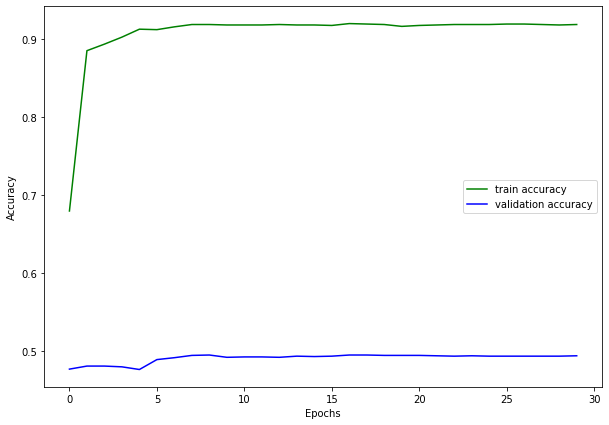

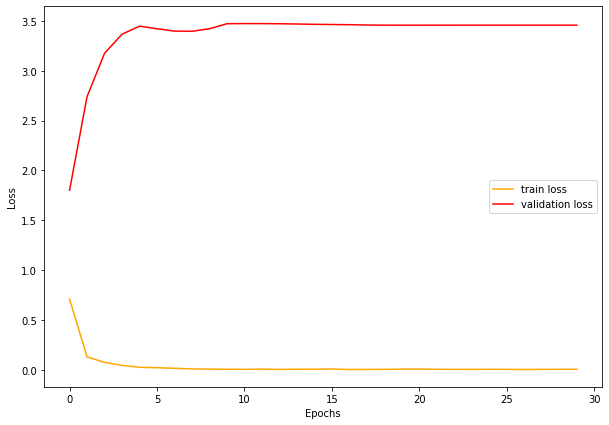

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Test Accuracy: 0.47705078125
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.2292580604553223


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.7787, Train Acc: 0.65
Val Loss: 1.9242, Val Acc: 0.46


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.11672057211399078


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train Loss: 0.1286, Train Acc: 0.88
Val Loss: 2.5903, Val Acc: 0.48


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0846, Train Acc: 0.90
Val Loss: 3.1195, Val Acc: 0.47


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.035042084753513336


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0504, Train Acc: 0.90
Val Loss: 3.2252, Val Acc: 0.49


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0344, Train Acc: 0.91
Val Loss: 3.3703, Val Acc: 0.48


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.030302779749035835


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0241, Train Acc: 0.91
Val Loss: 3.3946, Val Acc: 0.49


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.004343098029494286


100%|██████████| 8/8 [00:06<00:00,  1.14it/s]


Train Loss: 0.0119, Train Acc: 0.91
Val Loss: 3.3993, Val Acc: 0.50


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0161, Train Acc: 0.91
Val Loss: 3.4382, Val Acc: 0.49


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.009334197267889977


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0072, Train Acc: 0.92
Val Loss: 3.4608, Val Acc: 0.49


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0099, Train Acc: 0.92
Val Loss: 3.3642, Val Acc: 0.49


Starting epoch 11/30, LR = [0.003]


Step 60, Loss 0.003583347424864769


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0065, Train Acc: 0.92
Val Loss: 3.3369, Val Acc: 0.50


Starting epoch 12/30, LR = [0.003]


Step 70, Loss 0.015584900975227356


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0071, Train Acc: 0.92
Val Loss: 3.3183, Val Acc: 0.50


Starting epoch 13/30, LR = [0.003]



100%|██████████| 8/8 [00:06<00:00,  1.14it/s]


Train Loss: 0.0056, Train Acc: 0.92
Val Loss: 3.3125, Val Acc: 0.50


Starting epoch 14/30, LR = [0.003]


Step 80, Loss 0.006906639784574509


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0054, Train Acc: 0.92
Val Loss: 3.3221, Val Acc: 0.50


Starting epoch 15/30, LR = [0.003]



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0053, Train Acc: 0.92
Val Loss: 3.3459, Val Acc: 0.49


Starting epoch 16/30, LR = [0.003]


Step 90, Loss 0.002125997096300125


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0042, Train Acc: 0.92
Val Loss: 3.3618, Val Acc: 0.49


Starting epoch 17/30, LR = [0.003]


Step 100, Loss 0.016801122575998306


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0069, Train Acc: 0.92
Val Loss: 3.3626, Val Acc: 0.49


Starting epoch 18/30, LR = [0.003]



100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0046, Train Acc: 0.92
Val Loss: 3.3577, Val Acc: 0.49


Starting epoch 19/30, LR = [0.003]


Step 110, Loss 0.0014211684465408325


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0052, Train Acc: 0.92
Val Loss: 3.3617, Val Acc: 0.49


Starting epoch 20/30, LR = [0.003]



100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 3.3712, Val Acc: 0.49


Starting epoch 21/30, LR = [0.0009]


Step 120, Loss 0.0011758822947740555


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 3.3718, Val Acc: 0.49


Starting epoch 22/30, LR = [0.0009]


Step 130, Loss 0.0015897229313850403


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0037, Train Acc: 0.92
Val Loss: 3.3707, Val Acc: 0.49


Starting epoch 23/30, LR = [0.0009]



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0028, Train Acc: 0.92
Val Loss: 3.3708, Val Acc: 0.49


Starting epoch 24/30, LR = [0.0009]


Step 140, Loss 0.004673931747674942


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.3700, Val Acc: 0.49


Starting epoch 25/30, LR = [0.0009]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0051, Train Acc: 0.92
Val Loss: 3.3670, Val Acc: 0.49


Starting epoch 26/30, LR = [0.0009]


Step 150, Loss 0.0027945823967456818


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.0038, Train Acc: 0.92
Val Loss: 3.3644, Val Acc: 0.49


Starting epoch 27/30, LR = [0.0009]


Step 160, Loss 0.0045656561851501465


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 3.3630, Val Acc: 0.49


Starting epoch 28/30, LR = [0.0009]



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0026, Train Acc: 0.92
Val Loss: 3.3615, Val Acc: 0.49


Starting epoch 29/30, LR = [0.0009]


Step 170, Loss 0.002988779917359352


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.0042, Train Acc: 0.92
Val Loss: 3.3610, Val Acc: 0.49


Starting epoch 30/30, LR = [0.0009]



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]



Train Loss: 0.0043, Train Acc: 0.92
Val Loss: 3.3652, Val Acc: 0.49


[(0.7787419607241949, 0.6508982035928144), (0.1285810557504495, 0.8754491017964072), (0.0846110371251901, 0.895808383233533), (0.050433569277326264, 0.9041916167664671), (0.034433972711364426, 0.9059880239520958), (0.024137721707423527, 0.911377245508982), (0.011945478152483702, 0.9149700598802395), (0.016143713301668566, 0.9149700598802395), (0.007236044543484847, 0.918562874251497), (0.009892952007551989, 0.9161676646706587), (0.006503484832743804, 0.918562874251497), (0.007087338094909986, 0.9173652694610779), (0.0055538977806766825, 0.918562874251497), (0.005356155335903168, 0.918562874251497), (0.00528982716302077, 0.918562874251497), (0.004217937899132569, 0.9197604790419162), (0.006910461932420731, 0.9167664670658683), (0.0045966338366270065, 0.918562874251497), (0.005217513690392177, 0.9191616766467066), (0.0038873696078856788, 0.9191616766467066), (0.003885825785497824, 0.9197604790419162), (0.0037016924470

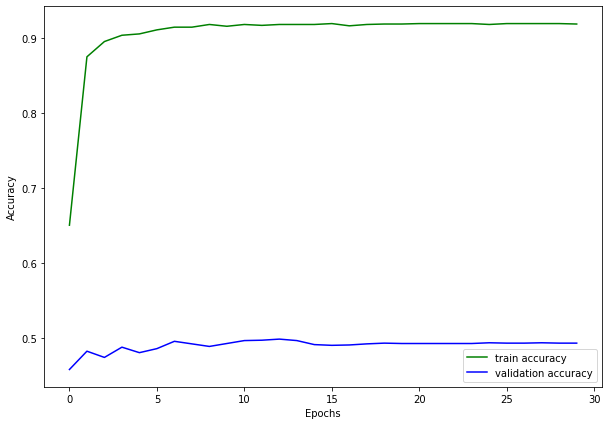

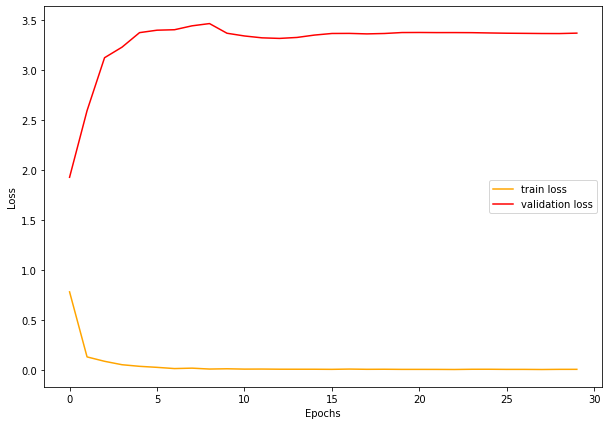

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Test Accuracy: 0.45849609375
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 2.2711641788482666


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]



Train Loss: 0.7595, Train Acc: 0.66
Val Loss: 1.9006, Val Acc: 0.47


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 0.13300533592700958


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.1219, Train Acc: 0.88
Val Loss: 2.9284, Val Acc: 0.47


Starting epoch 3/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0867, Train Acc: 0.89
Val Loss: 3.4020, Val Acc: 0.46


Starting epoch 4/30, LR = [0.01]


Step 20, Loss 0.05140466243028641


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0512, Train Acc: 0.90
Val Loss: 3.5585, Val Acc: 0.47


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0281, Train Acc: 0.91
Val Loss: 3.6352, Val Acc: 0.47


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 0.02487660013139248


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.0212, Train Acc: 0.91
Val Loss: 3.6320, Val Acc: 0.48


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 0.014732282608747482


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0119, Train Acc: 0.92
Val Loss: 3.6643, Val Acc: 0.47


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0097, Train Acc: 0.92
Val Loss: 3.6475, Val Acc: 0.48


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 0.014418100006878376


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0103, Train Acc: 0.92
Val Loss: 3.6449, Val Acc: 0.48


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0073, Train Acc: 0.92
Val Loss: 3.6779, Val Acc: 0.48


Starting epoch 11/30, LR = [0.005]


Step 60, Loss 0.001986570656299591


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.6815, Val Acc: 0.48


Starting epoch 12/30, LR = [0.005]


Step 70, Loss 0.009493131190538406


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 0.0061, Train Acc: 0.92
Val Loss: 3.6795, Val Acc: 0.48


Starting epoch 13/30, LR = [0.005]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.6682, Val Acc: 0.48


Starting epoch 14/30, LR = [0.005]


Step 80, Loss 0.003076719120144844


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0050, Train Acc: 0.92
Val Loss: 3.6773, Val Acc: 0.48


Starting epoch 15/30, LR = [0.005]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0049, Train Acc: 0.92
Val Loss: 3.6813, Val Acc: 0.48


Starting epoch 16/30, LR = [0.005]


Step 90, Loss 0.007439067587256432


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.6866, Val Acc: 0.48


Starting epoch 17/30, LR = [0.005]


Step 100, Loss 0.0022995471954345703


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0039, Train Acc: 0.92
Val Loss: 3.6883, Val Acc: 0.48


Starting epoch 18/30, LR = [0.005]



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train Loss: 0.0059, Train Acc: 0.92
Val Loss: 3.6927, Val Acc: 0.48


Starting epoch 19/30, LR = [0.005]


Step 110, Loss 0.008529895916581154


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0055, Train Acc: 0.92
Val Loss: 3.7078, Val Acc: 0.48


Starting epoch 20/30, LR = [0.005]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0062, Train Acc: 0.92
Val Loss: 3.7345, Val Acc: 0.48


Starting epoch 21/30, LR = [0.0025]


Step 120, Loss 0.002771163359284401


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0058, Train Acc: 0.92
Val Loss: 3.7381, Val Acc: 0.48


Starting epoch 22/30, LR = [0.0025]


Step 130, Loss 0.005336843430995941


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0034, Train Acc: 0.92
Val Loss: 3.7348, Val Acc: 0.48


Starting epoch 23/30, LR = [0.0025]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0043, Train Acc: 0.92
Val Loss: 3.7259, Val Acc: 0.48


Starting epoch 24/30, LR = [0.0025]


Step 140, Loss 0.004633503034710884


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0027, Train Acc: 0.92
Val Loss: 3.7160, Val Acc: 0.48


Starting epoch 25/30, LR = [0.0025]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.0041, Train Acc: 0.92
Val Loss: 3.7102, Val Acc: 0.48


Starting epoch 26/30, LR = [0.0025]


Step 150, Loss 0.00448349304497242


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.0024, Train Acc: 0.92
Val Loss: 3.7147, Val Acc: 0.48


Starting epoch 27/30, LR = [0.0025]


Step 160, Loss 0.0015324968844652176


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0026, Train Acc: 0.92
Val Loss: 3.7163, Val Acc: 0.48


Starting epoch 28/30, LR = [0.0025]



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0025, Train Acc: 0.92
Val Loss: 3.7137, Val Acc: 0.48


Starting epoch 29/30, LR = [0.0025]


Step 170, Loss 0.0037568435072898865


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.0035, Train Acc: 0.92
Val Loss: 3.7074, Val Acc: 0.48


Starting epoch 30/30, LR = [0.0025]



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]



Train Loss: 0.0029, Train Acc: 0.92
Val Loss: 3.7011, Val Acc: 0.48


[(0.7595457012454668, 0.6574850299401198), (0.12190085649490356, 0.8766467065868263), (0.08669261261820793, 0.8940119760479042), (0.05120518462111553, 0.9047904191616767), (0.028146800274650257, 0.911377245508982), (0.02117984090000391, 0.9131736526946108), (0.011930023630460104, 0.9173652694610779), (0.00965165812522173, 0.9167664670658683), (0.010332703745613495, 0.9179640718562875), (0.0072905998677015305, 0.918562874251497), (0.005837475260098775, 0.9179640718562875), (0.006119338174661, 0.918562874251497), (0.005811246111989021, 0.9179640718562875), (0.004950456476459901, 0.9179640718562875), (0.0049474652235706644, 0.9179640718562875), (0.005822266762455304, 0.9179640718562875), (0.0038923677057027817, 0.9191616766467066), (0.005871637413899104, 0.9191616766467066), (0.005479341372847557, 0.918562874251497), (0.00617833932240804, 0.9179640718562875), (0.0058088113243381185, 0.918562874251497), (0.0033928037931

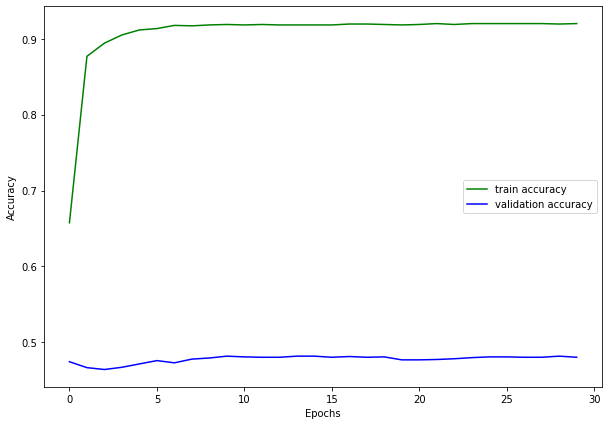

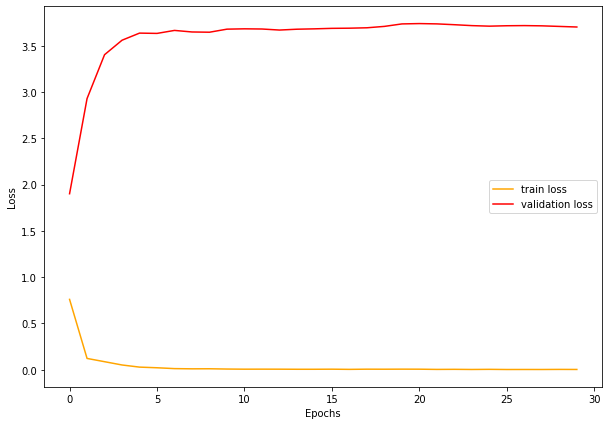

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

Test Accuracy: 0.474609375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-0

In [ ]:
BATCH_SIZE = 256     
LR = 1e-2            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5   
NUM_EPOCHS = 30      
STEP_SIZE = 10       
GAMMA = 0.1       

parameters = {
    'LR' : [1e-1,1e-3],
    'WEIGHT_DECAY' : [5e-4,5e-6],
    'STEP_SIZE': [5,10,15],
    'GAMMA' : [0.05,0.3,0.5]
}
tests = []
first_attempt = {
'LR' : LR,
'WEIGHT_DECAY' : WEIGHT_DECAY,
'STEP_SIZE': STEP_SIZE,
'GAMMA' : GAMMA,
'accuracy' : 0.470703125
}
tests.append(first_attempt)
ress = [0.470703125]
for lra in parameters['LR']:
    s = f'lr_{lra}'
    net = torchvision.models.alexnet(pretrained = True)
    net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=lra, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="/content/drive/My Drive/alexnet_noDANN_pretrained_"+s)
    print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained_"+s)
    res = test(net,target_dataloader)
    
    result = {  'LR' : lra,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      LR = lra
    ress.append(res)

print(tests)
print(ress)

for wd in parameters['WEIGHT_DECAY']:
    s = f'wd_{wd}'
    net = torchvision.models.alexnet(pretrained = True)
    net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="/content/drive/My Drive/alexnet_noDANN_pretrained_"+s)
    print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained_"+s)
    res = test(net,target_dataloader)
    
    result = {  'LR' : LR,
                'WEIGHT_DECAY' : wd,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      print("new best found")
      WEIGHT_DECAY=wd
    ress.append(res)

print(tests)
print(ress)

for st in parameters['STEP_SIZE']:
    s = f'st_{st}'
    net = torchvision.models.alexnet(pretrained = True)
    net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=st, gamma=GAMMA)
    tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="/content/drive/My Drive/alexnet_noDANN_pretrained_"+s)
    print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained_"+s)
    res = test(net,target_dataloader)
    
    result = {  'LR' : LR,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': st,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      print("new best found")
      STEP_SIZE = st
    ress.append(res)

print(tests)
print(ress)


for g in parameters['GAMMA']:
    s = f'g_{g}'
    net = torchvision.models.alexnet(pretrained = True)
    net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=g)
    tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="/content/drive/My Drive/alexnet_noDANN_pretrained_"+s)
    print_acc_loss(tl,ta,vl,va,"alexnet_noDANN_pretrained_"+s)
    res = test(net,target_dataloader)
    result = {  'LR' : LR,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : g,
                'accuracy' : res}
    tests.append(result)
    
    if res > max(ress):
      GAMMA = g
    ress.append(res)

print(tests)
print(ress)

Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Source class Loss: 0.7824, Train class Acc: 0.72
Target class Loss: 0.6819, Val class Acc: 0.29
Source domain Loss: 0.5589, Source domain Acc: 0.79
Target domain Loss: 0.4871, Target domain Acc: 0.82
Total train Loss: 0.6095, Total train Acc: 0.78
Total domain Loss: 0.5230, Total domain Acc: 0.81


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.4989, Train class Acc: 0.82
Target class Loss: 0.5257, Val class Acc: 0.27
Source domain Loss: 0.3376, Source domain Acc: 0.88
Target domain Loss: 0.3936, Target domain Acc: 0.86
Total train Loss: 0.4100, Total train Acc: 0.85
Total domain Loss: 0.3656, Total domain Acc: 0.87


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.3721, Train class Acc: 0.87
Target class Loss: 0.3124, Val class Acc: 0.27
Source domain Loss: 0.2576, Source domain Acc: 0.91
Target domain Loss: 0.2792, Target domain Acc: 0.88
Total train Loss: 0.3030, Total train Acc: 0.89
Total domain Loss: 0.2684, Total domain Acc: 0.89


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.2735, Train class Acc: 0.91
Target class Loss: 0.2625, Val class Acc: 0.33
Source domain Loss: 0.1952, Source domain Acc: 0.92
Target domain Loss: 0.1757, Target domain Acc: 0.93
Total train Loss: 0.2148, Total train Acc: 0.92
Total domain Loss: 0.1854, Total domain Acc: 0.92


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.1924, Train class Acc: 0.93
Target class Loss: 0.0953, Val class Acc: 0.36
Source domain Loss: 0.1084, Source domain Acc: 0.96
Target domain Loss: 0.1537, Target domain Acc: 0.94
Total train Loss: 0.1515, Total train Acc: 0.94
Total domain Loss: 0.1310, Total domain Acc: 0.95


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0958, Train class Acc: 0.97
Target class Loss: 0.0565, Val class Acc: 0.40
Source domain Loss: 0.1013, Source domain Acc: 0.96
Target domain Loss: 0.0720, Target domain Acc: 0.97
Total train Loss: 0.0897, Total train Acc: 0.97
Total domain Loss: 0.0867, Total domain Acc: 0.97


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0510, Train class Acc: 0.98
Target class Loss: 0.0216, Val class Acc: 0.39
Source domain Loss: 0.0490, Source domain Acc: 0.98
Target domain Loss: 0.0588, Target domain Acc: 0.98
Total train Loss: 0.0529, Total train Acc: 0.98
Total domain Loss: 0.0539, Total domain Acc: 0.98


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0331, Train class Acc: 0.99
Target class Loss: 0.0275, Val class Acc: 0.40
Source domain Loss: 0.0330, Source domain Acc: 0.99
Target domain Loss: 0.0313, Target domain Acc: 0.99
Total train Loss: 0.0325, Total train Acc: 0.99
Total domain Loss: 0.0321, Total domain Acc: 0.99


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0227, Train class Acc: 0.99
Target class Loss: 0.0217, Val class Acc: 0.39
Source domain Loss: 0.0202, Source domain Acc: 0.99
Target domain Loss: 0.0220, Target domain Acc: 0.99
Total train Loss: 0.0216, Total train Acc: 0.99
Total domain Loss: 0.0211, Total domain Acc: 0.99


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0197, Train class Acc: 1.00
Target class Loss: 0.0114, Val class Acc: 0.41
Source domain Loss: 0.0093, Source domain Acc: 1.00
Target domain Loss: 0.0134, Target domain Acc: 1.00
Total train Loss: 0.0141, Total train Acc: 1.00
Total domain Loss: 0.0114, Total domain Acc: 1.00


Starting epoch 11/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0098, Val class Acc: 0.41
Source domain Loss: 0.0107, Source domain Acc: 1.00
Target domain Loss: 0.0053, Target domain Acc: 1.00
Total train Loss: 0.0071, Total train Acc: 1.00
Total domain Loss: 0.0080, Total domain Acc: 1.00


Starting epoch 12/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0055, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.42
Source domain Loss: 0.0059, Source domain Acc: 1.00
Target domain Loss: 0.0076, Target domain Acc: 1.00
Total train Loss: 0.0063, Total train Acc: 1.00
Total domain Loss: 0.0067, Total domain Acc: 1.00


Starting epoch 13/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0046, Train class Acc: 1.00
Target class Loss: 0.0054, Val class Acc: 0.41
Source domain Loss: 0.0031, Source domain Acc: 1.00
Target domain Loss: 0.0067, Target domain Acc: 1.00
Total train Loss: 0.0048, Total train Acc: 1.00
Total domain Loss: 0.0049, Total domain Acc: 1.00


Starting epoch 14/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0049, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.41
Source domain Loss: 0.0063, Source domain Acc: 1.00
Target domain Loss: 0.0042, Target domain Acc: 1.00
Total train Loss: 0.0051, Total train Acc: 1.00
Total domain Loss: 0.0053, Total domain Acc: 1.00


Starting epoch 15/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0070, Val class Acc: 0.42
Source domain Loss: 0.0050, Source domain Acc: 1.00
Target domain Loss: 0.0035, Target domain Acc: 1.00
Total train Loss: 0.0043, Total train Acc: 1.00
Total domain Loss: 0.0043, Total domain Acc: 1.00


Starting epoch 16/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0044, Val class Acc: 0.42
Source domain Loss: 0.0029, Source domain Acc: 1.00
Target domain Loss: 0.0044, Target domain Acc: 1.00
Total train Loss: 0.0039, Total train Acc: 1.00
Total domain Loss: 0.0036, Total domain Acc: 1.00


Starting epoch 17/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0010, Val class Acc: 0.42
Source domain Loss: 0.0034, Source domain Acc: 1.00
Target domain Loss: 0.0046, Target domain Acc: 1.00
Total train Loss: 0.0037, Total train Acc: 1.00
Total domain Loss: 0.0040, Total domain Acc: 1.00


Starting epoch 18/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0028, Val class Acc: 0.42
Source domain Loss: 0.0030, Source domain Acc: 1.00
Target domain Loss: 0.0036, Target domain Acc: 1.00
Total train Loss: 0.0034, Total train Acc: 1.00
Total domain Loss: 0.0033, Total domain Acc: 1.00


Starting epoch 19/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]



Source class Loss: 0.0027, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.42
Source domain Loss: 0.0034, Source domain Acc: 1.00
Target domain Loss: 0.0027, Target domain Acc: 1.00
Total train Loss: 0.0030, Total train Acc: 1.00
Total domain Loss: 0.0031, Total domain Acc: 1.00


Starting epoch 20/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]



Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.42
Source domain Loss: 0.0039, Source domain Acc: 1.00
Target domain Loss: 0.0042, Target domain Acc: 1.00
Total train Loss: 0.0045, Total train Acc: 1.00
Total domain Loss: 0.0040, Total domain Acc: 1.00


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.42
Source domain Loss: 0.0021, Source domain Acc: 1.00
Target domain Loss: 0.0044, Target domain Acc: 1.00
Total train Loss: 0.0033, Total train Acc: 1.00
Total domain Loss: 0.0033, Total domain Acc: 1.00


Starting epoch 22/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 0.0028, Train class Acc: 1.00
Target class Loss: 0.0045, Val class Acc: 0.42
Source domain Loss: 0.0025, Source domain Acc: 1.00
Target domain Loss: 0.0030, Target domain Acc: 1.00
Total train Loss: 0.0027, Total train Acc: 1.00
Total domain Loss: 0.0027, Total domain Acc: 1.00


Starting epoch 23/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]



Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0045, Val class Acc: 0.42
Source domain Loss: 0.0039, Source domain Acc: 1.00
Target domain Loss: 0.0030, Target domain Acc: 1.00
Total train Loss: 0.0037, Total train Acc: 1.00
Total domain Loss: 0.0035, Total domain Acc: 1.00


Starting epoch 24/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.42
Source domain Loss: 0.0027, Source domain Acc: 1.00
Target domain Loss: 0.0034, Target domain Acc: 1.00
Total train Loss: 0.0028, Total train Acc: 1.00
Total domain Loss: 0.0030, Total domain Acc: 1.00


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0024, Train class Acc: 1.00
Target class Loss: 0.0014, Val class Acc: 0.42
Source domain Loss: 0.0022, Source domain Acc: 1.00
Target domain Loss: 0.0024, Target domain Acc: 1.00
Total train Loss: 0.0024, Total train Acc: 1.00
Total domain Loss: 0.0023, Total domain Acc: 1.00


Starting epoch 26/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0039, Val class Acc: 0.42
Source domain Loss: 0.0031, Source domain Acc: 1.00
Target domain Loss: 0.0021, Target domain Acc: 1.00
Total train Loss: 0.0029, Total train Acc: 1.00
Total domain Loss: 0.0026, Total domain Acc: 1.00


Starting epoch 27/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.42
Source domain Loss: 0.0049, Source domain Acc: 1.00
Target domain Loss: 0.0023, Target domain Acc: 1.00
Total train Loss: 0.0032, Total train Acc: 1.00
Total domain Loss: 0.0036, Total domain Acc: 1.00


Starting epoch 28/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.42
Source domain Loss: 0.0028, Source domain Acc: 1.00
Target domain Loss: 0.0032, Target domain Acc: 1.00
Total train Loss: 0.0033, Total train Acc: 1.00
Total domain Loss: 0.0030, Total domain Acc: 1.00


Starting epoch 29/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.42
Source domain Loss: 0.0037, Source domain Acc: 1.00
Target domain Loss: 0.0032, Target domain Acc: 1.00
Total train Loss: 0.0034, Total train Acc: 1.00
Total domain Loss: 0.0035, Total domain Acc: 1.00


Starting epoch 30/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0024, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.42
Source domain Loss: 0.0026, Source domain Acc: 1.00
Target domain Loss: 0.0031, Target domain Acc: 1.00
Total train Loss: 0.0027, Total train Acc: 1.00
Total domain Loss: 0.0029, Total domain Acc: 1.00


[(0.7823612876236439, 0.71875), (0.4988613463938236, 0.81640625), (0.37208836525678635, 0.873046875), (0.27351585403084755, 0.90673828125), (0.19239446613937616, 0.9267578125), (0.09576544165611267, 0.9658203125), (0.05096210399642587, 0.982421875), (0.03311914671212435, 0.990234375), (0.022652128944173455, 0.99267578125), (0.019654082134366035, 0.99560546875), (0.005407578544691205, 0.99951171875), (0.005477372440509498, 0.99951171875), (0.004608754068613052, 0.99951171875), (0.004902206943370402, 0.99951171875), (0.004320260835811496, 1.0), (0.0042692378628998995, 1.0), (0.00295458291657269, 1.0), (0.003608591970987618, 1.0), (0.0027388455346226692, 0.99951171875), (0.005355998175218701, 

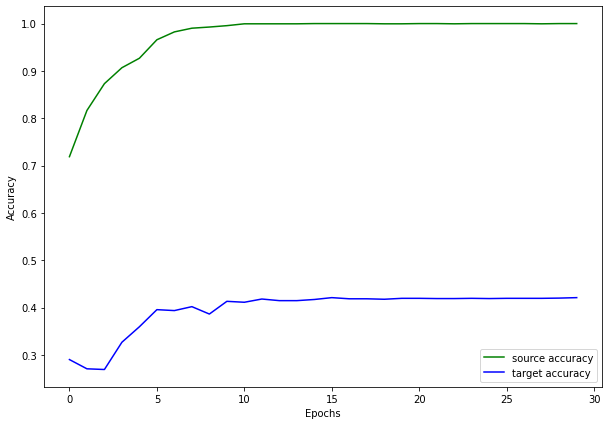

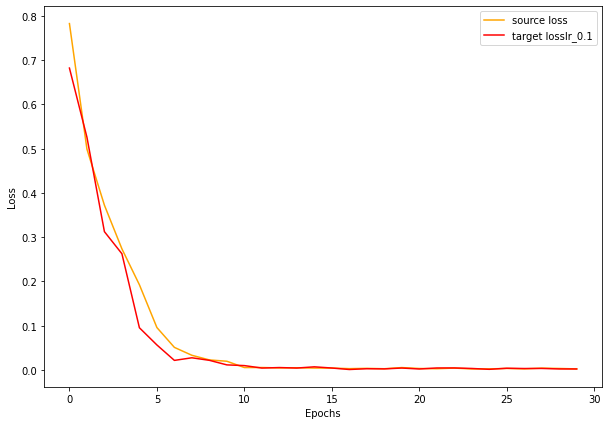

[(0.558938373811543, 0.79296875), (0.3376029417850077, 0.87841796875), (0.2576092300005257, 0.90869140625), (0.19520408241078258, 0.9189453125), (0.10843652719631791, 0.9580078125), (0.10128411441110075, 0.9638671875), (0.049030427588149905, 0.9794921875), (0.03299671958666295, 0.98779296875), (0.020228247973136604, 0.9921875), (0.009337576804682612, 0.998046875), (0.01074543796130456, 0.9970703125), (0.005873534188140184, 0.99951171875), (0.0030760146910324693, 1.0), (0.006341374304611236, 0.9990234375), (0.00498214503750205, 0.9990234375), (0.0028971853898838162, 0.99951171875), (0.0034293294011149555, 0.99951171875), (0.003029412735486403, 1.0), (0.003418171312659979, 0.99951171875), (0.0039046880847308785, 0.99951171875), (0.0021170902182348073, 1.0), (0.0024554746341891587, 0.99951171875), (0.0038831672572996467, 0.99951171875), (0.0026529423194006085, 1.0), (0.0022492508869618177, 1.0), (0.0030983348260633647, 0.99951171875), (0.004903090186417103, 0.9990234375), (0.0027993922412

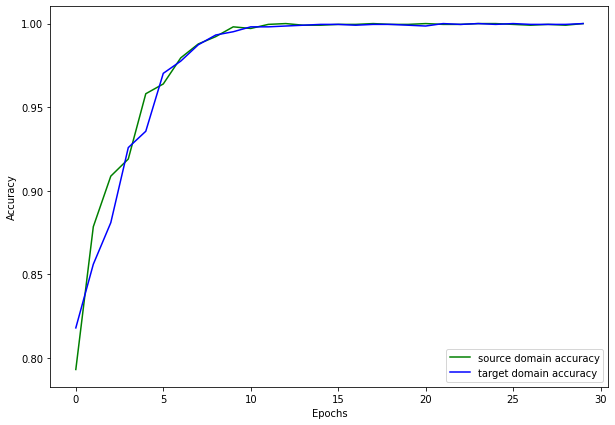

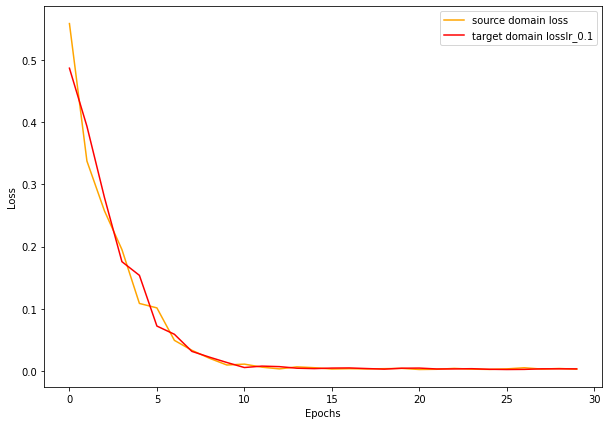

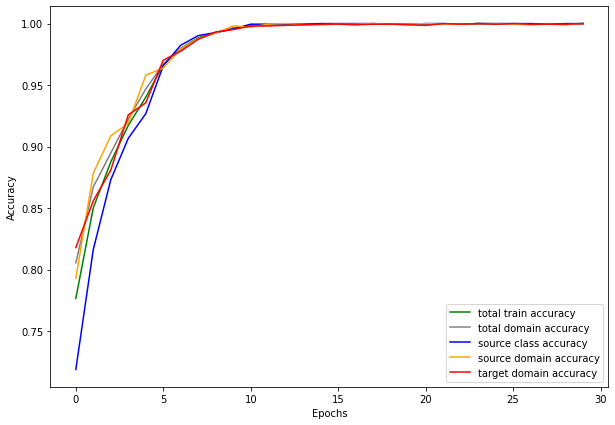

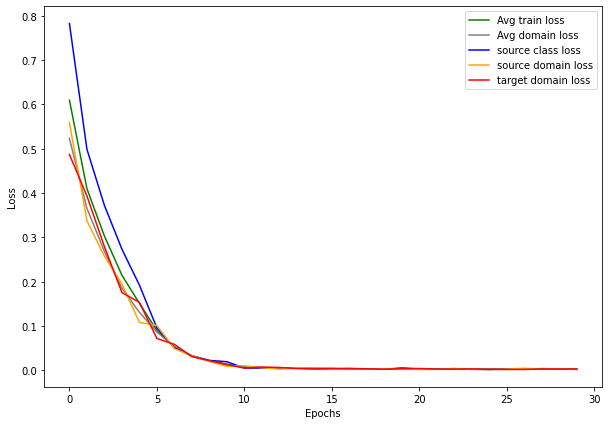

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Test Accuracy: 0.41845703125
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.7448, Train class Acc: 0.73
Target class Loss: 0.7462, Val class Acc: 0.24
Source domain Loss: 0.6354, Source domain Acc: 0.78
Target domain Loss: 0.5067, Target domain Acc: 0.81
Total train Loss: 0.6290, Total train Acc: 0.77
Total domain Loss: 0.5711, Total domain Acc: 0.80


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 1.0381, Train class Acc: 0.62
Target class Loss: 1.4933, Val class Acc: 0.15
Source domain Loss: 0.4641, Source domain Acc: 0.76
Target domain Loss: 0.8121, Target domain Acc: 0.68
Total train Loss: 0.7714, Total train Acc: 0.69
Total domain Loss: 0.6381, Total domain Acc: 0.72


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]



Source class Loss: 2.1013, Train class Acc: 0.17
Target class Loss: 2.0718, Val class Acc: 0.10
Source domain Loss: 0.9396, Source domain Acc: 0.19
Target domain Loss: 0.5714, Target domain Acc: 0.84
Total train Loss: 1.2041, Total train Acc: 0.40
Total domain Loss: 0.7555, Total domain Acc: 0.51


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 2.2059, Train class Acc: 0.17
Target class Loss: 1.9148, Val class Acc: 0.22
Source domain Loss: 0.7004, Source domain Acc: 0.52
Target domain Loss: 0.8993, Target domain Acc: 0.49
Total train Loss: 1.2685, Total train Acc: 0.39
Total domain Loss: 0.7998, Total domain Acc: 0.50


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 1.8994, Train class Acc: 0.26
Target class Loss: 1.8834, Val class Acc: 0.22
Source domain Loss: 0.6976, Source domain Acc: 0.56
Target domain Loss: 0.7053, Target domain Acc: 0.46
Total train Loss: 1.1007, Total train Acc: 0.43
Total domain Loss: 0.7014, Total domain Acc: 0.51


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 1.9051, Train class Acc: 0.26
Target class Loss: 1.8928, Val class Acc: 0.22
Source domain Loss: 0.7079, Source domain Acc: 0.49
Target domain Loss: 0.6920, Target domain Acc: 0.52
Total train Loss: 1.1017, Total train Acc: 0.42
Total domain Loss: 0.6999, Total domain Acc: 0.51


Starting epoch 7/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Source class Loss: 1.8890, Train class Acc: 0.26
Target class Loss: 1.9045, Val class Acc: 0.22
Source domain Loss: 0.6995, Source domain Acc: 0.52
Target domain Loss: 0.6985, Target domain Acc: 0.47
Total train Loss: 1.0957, Total train Acc: 0.42
Total domain Loss: 0.6990, Total domain Acc: 0.50


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 1.8931, Train class Acc: 0.26
Target class Loss: 1.8832, Val class Acc: 0.22
Source domain Loss: 0.6988, Source domain Acc: 0.50
Target domain Loss: 0.6938, Target domain Acc: 0.51
Total train Loss: 1.0952, Total train Acc: 0.42
Total domain Loss: 0.6963, Total domain Acc: 0.51


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Source class Loss: 1.8880, Train class Acc: 0.27
Target class Loss: 1.8561, Val class Acc: 0.22
Source domain Loss: 0.7007, Source domain Acc: 0.49
Target domain Loss: 0.6937, Target domain Acc: 0.50
Total train Loss: 1.0941, Total train Acc: 0.42
Total domain Loss: 0.6972, Total domain Acc: 0.50


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 1.8826, Train class Acc: 0.27
Target class Loss: 1.8686, Val class Acc: 0.22
Source domain Loss: 0.6977, Source domain Acc: 0.50
Target domain Loss: 0.6959, Target domain Acc: 0.50
Total train Loss: 1.0921, Total train Acc: 0.42
Total domain Loss: 0.6968, Total domain Acc: 0.50


Starting epoch 11/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 1.8861, Train class Acc: 0.26
Target class Loss: 1.8747, Val class Acc: 0.22
Source domain Loss: 0.6870, Source domain Acc: 0.55
Target domain Loss: 0.7061, Target domain Acc: 0.44
Total train Loss: 1.0930, Total train Acc: 0.42
Total domain Loss: 0.6965, Total domain Acc: 0.50


Starting epoch 12/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Source class Loss: 1.8945, Train class Acc: 0.26
Target class Loss: 1.9043, Val class Acc: 0.22
Source domain Loss: 0.6946, Source domain Acc: 0.51
Target domain Loss: 0.6952, Target domain Acc: 0.49
Total train Loss: 1.0948, Total train Acc: 0.42
Total domain Loss: 0.6949, Total domain Acc: 0.50


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Source class Loss: 1.8956, Train class Acc: 0.26
Target class Loss: 1.8970, Val class Acc: 0.22
Source domain Loss: 0.7005, Source domain Acc: 0.48
Target domain Loss: 0.6926, Target domain Acc: 0.51
Total train Loss: 1.0962, Total train Acc: 0.41
Total domain Loss: 0.6965, Total domain Acc: 0.49


Starting epoch 14/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Source class Loss: 1.8980, Train class Acc: 0.25
Target class Loss: 1.9211, Val class Acc: 0.22
Source domain Loss: 0.6938, Source domain Acc: 0.51
Target domain Loss: 0.6984, Target domain Acc: 0.48
Total train Loss: 1.0967, Total train Acc: 0.41
Total domain Loss: 0.6961, Total domain Acc: 0.50


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Source class Loss: 1.8952, Train class Acc: 0.25
Target class Loss: 1.9112, Val class Acc: 0.22
Source domain Loss: 0.6927, Source domain Acc: 0.51
Target domain Loss: 0.6990, Target domain Acc: 0.47
Total train Loss: 1.0956, Total train Acc: 0.41
Total domain Loss: 0.6959, Total domain Acc: 0.49


Starting epoch 16/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 1.8936, Train class Acc: 0.26
Target class Loss: 1.9074, Val class Acc: 0.22
Source domain Loss: 0.6943, Source domain Acc: 0.51
Target domain Loss: 0.6972, Target domain Acc: 0.48
Total train Loss: 1.0950, Total train Acc: 0.41
Total domain Loss: 0.6957, Total domain Acc: 0.49


Starting epoch 17/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 1.8952, Train class Acc: 0.26
Target class Loss: 1.9149, Val class Acc: 0.22
Source domain Loss: 0.6941, Source domain Acc: 0.51
Target domain Loss: 0.6944, Target domain Acc: 0.50
Total train Loss: 1.0946, Total train Acc: 0.42
Total domain Loss: 0.6943, Total domain Acc: 0.50


Starting epoch 18/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Source class Loss: 1.8965, Train class Acc: 0.25
Target class Loss: 1.8924, Val class Acc: 0.22
Source domain Loss: 0.6942, Source domain Acc: 0.51
Target domain Loss: 0.6986, Target domain Acc: 0.49
Total train Loss: 1.0964, Total train Acc: 0.42
Total domain Loss: 0.6964, Total domain Acc: 0.50


Starting epoch 19/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 1.8898, Train class Acc: 0.26
Target class Loss: 1.8818, Val class Acc: 0.22
Source domain Loss: 0.6977, Source domain Acc: 0.49
Target domain Loss: 0.6968, Target domain Acc: 0.49
Total train Loss: 1.0948, Total train Acc: 0.41
Total domain Loss: 0.6972, Total domain Acc: 0.49


Starting epoch 20/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 1.8892, Train class Acc: 0.26
Target class Loss: 1.9133, Val class Acc: 0.22
Source domain Loss: 0.6968, Source domain Acc: 0.50
Target domain Loss: 0.6975, Target domain Acc: 0.48
Total train Loss: 1.0945, Total train Acc: 0.41
Total domain Loss: 0.6972, Total domain Acc: 0.49


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 1.8895, Train class Acc: 0.26
Target class Loss: 1.8772, Val class Acc: 0.22
Source domain Loss: 0.6926, Source domain Acc: 0.53
Target domain Loss: 0.6965, Target domain Acc: 0.50
Total train Loss: 1.0929, Total train Acc: 0.43
Total domain Loss: 0.6946, Total domain Acc: 0.51


Starting epoch 22/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 1.8880, Train class Acc: 0.27
Target class Loss: 1.8922, Val class Acc: 0.22
Source domain Loss: 0.6943, Source domain Acc: 0.52
Target domain Loss: 0.7010, Target domain Acc: 0.45
Total train Loss: 1.0944, Total train Acc: 0.41
Total domain Loss: 0.6976, Total domain Acc: 0.48


Starting epoch 23/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 1.8884, Train class Acc: 0.26
Target class Loss: 1.8744, Val class Acc: 0.22
Source domain Loss: 0.6951, Source domain Acc: 0.51
Target domain Loss: 0.6993, Target domain Acc: 0.47
Total train Loss: 1.0943, Total train Acc: 0.41
Total domain Loss: 0.6972, Total domain Acc: 0.49


Starting epoch 24/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 1.8881, Train class Acc: 0.26
Target class Loss: 1.8554, Val class Acc: 0.22
Source domain Loss: 0.6946, Source domain Acc: 0.50
Target domain Loss: 0.6982, Target domain Acc: 0.48
Total train Loss: 1.0936, Total train Acc: 0.41
Total domain Loss: 0.6964, Total domain Acc: 0.49


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 1.8915, Train class Acc: 0.26
Target class Loss: 1.8713, Val class Acc: 0.22
Source domain Loss: 0.6936, Source domain Acc: 0.51
Target domain Loss: 0.6975, Target domain Acc: 0.49
Total train Loss: 1.0942, Total train Acc: 0.42
Total domain Loss: 0.6955, Total domain Acc: 0.50


Starting epoch 26/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 1.8928, Train class Acc: 0.26
Target class Loss: 1.9130, Val class Acc: 0.22
Source domain Loss: 0.6925, Source domain Acc: 0.51
Target domain Loss: 0.6977, Target domain Acc: 0.48
Total train Loss: 1.0944, Total train Acc: 0.42
Total domain Loss: 0.6951, Total domain Acc: 0.50


Starting epoch 27/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 1.8926, Train class Acc: 0.26
Target class Loss: 1.9047, Val class Acc: 0.22
Source domain Loss: 0.6944, Source domain Acc: 0.51
Target domain Loss: 0.6966, Target domain Acc: 0.49
Total train Loss: 1.0945, Total train Acc: 0.42
Total domain Loss: 0.6955, Total domain Acc: 0.50


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 1.8855, Train class Acc: 0.26
Target class Loss: 1.8612, Val class Acc: 0.22
Source domain Loss: 0.6944, Source domain Acc: 0.51
Target domain Loss: 0.6949, Target domain Acc: 0.50
Total train Loss: 1.0916, Total train Acc: 0.42
Total domain Loss: 0.6946, Total domain Acc: 0.50


Starting epoch 29/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 1.8916, Train class Acc: 0.26
Target class Loss: 1.9188, Val class Acc: 0.22
Source domain Loss: 0.6939, Source domain Acc: 0.51
Target domain Loss: 0.6955, Target domain Acc: 0.49
Total train Loss: 1.0937, Total train Acc: 0.42
Total domain Loss: 0.6947, Total domain Acc: 0.50


Starting epoch 30/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 1.8852, Train class Acc: 0.26
Target class Loss: 1.8862, Val class Acc: 0.22
Source domain Loss: 0.6947, Source domain Acc: 0.51
Target domain Loss: 0.6964, Target domain Acc: 0.50
Total train Loss: 1.0921, Total train Acc: 0.43
Total domain Loss: 0.6956, Total domain Acc: 0.51


[(0.7447833940386772, 0.72607421875), (1.03805473446846, 0.6220703125), (2.101314440369606, 0.16650390625), (2.205944702029228, 0.17041015625), (1.8993574976921082, 0.2587890625), (1.9051164090633392, 0.25634765625), (1.8890132457017899, 0.26171875), (1.8930890262126923, 0.2578125), (1.8880442827939987, 0.26611328125), (1.8826436251401901, 0.2685546875), (1.8860837072134018, 0.263671875), (1.894498035311699, 0.25634765625), (1.8955537974834442, 0.2568359375), (1.8980113714933395, 0.2529296875), (1.8952072709798813, 0.25341796875), (1.893649771809578, 0.255859375), (1.8952153772115707, 0.25537109375), (1.8964578360319138, 0.2548828125), (1.8898455649614334, 0.2587890625), (1.8891552686691284

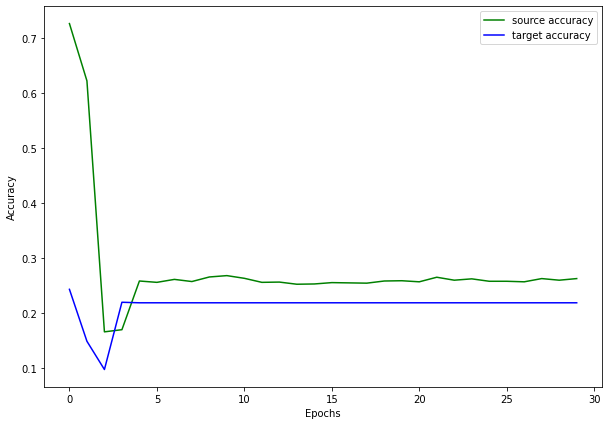

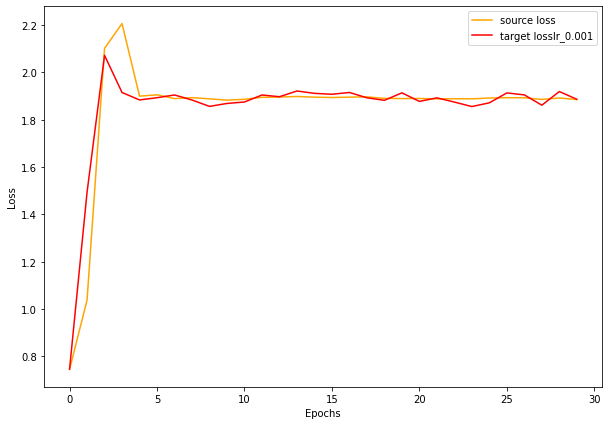

[(0.6354471649974585, 0.78369140625), (0.46408718917518854, 0.7646484375), (0.9396477565169334, 0.185546875), (0.7004106864333153, 0.51611328125), (0.6975817009806633, 0.5556640625), (0.7078696191310883, 0.48876953125), (0.6994802430272102, 0.517578125), (0.698829673230648, 0.5029296875), (0.700672559440136, 0.48681640625), (0.6977069526910782, 0.4951171875), (0.686957098543644, 0.55419921875), (0.6946240141987801, 0.5146484375), (0.7004652842879295, 0.4765625), (0.6938189193606377, 0.51123046875), (0.6926824152469635, 0.5107421875), (0.6942713856697083, 0.50830078125), (0.6941176429390907, 0.5078125), (0.6942052692174911, 0.50732421875), (0.6976791024208069, 0.486328125), (0.6967997178435326, 0.49609375), (0.6926285922527313, 0.52587890625), (0.6942642852663994, 0.51708984375), (0.6950973197817802, 0.5087890625), (0.6946013197302818, 0.50390625), (0.6935920342803001, 0.51123046875), (0.6925257816910744, 0.5126953125), (0.6944151669740677, 0.5146484375), (0.6943626776337624, 0.51269531

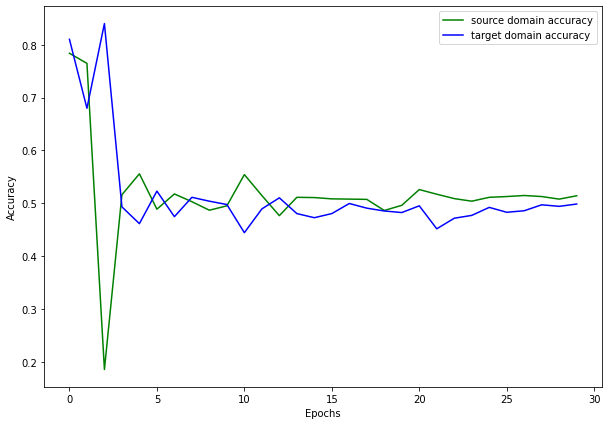

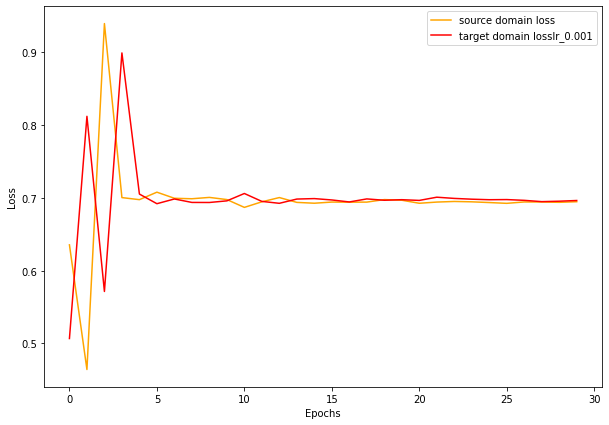

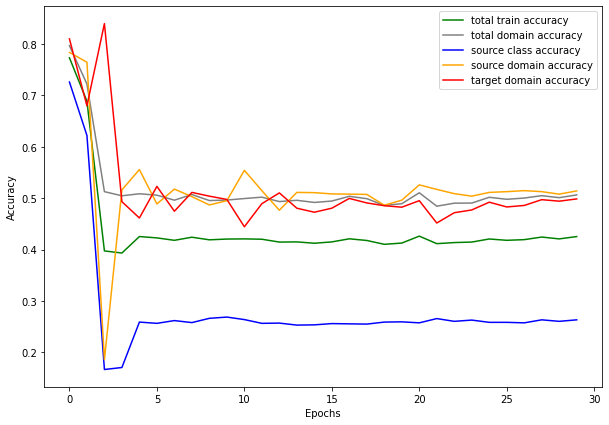

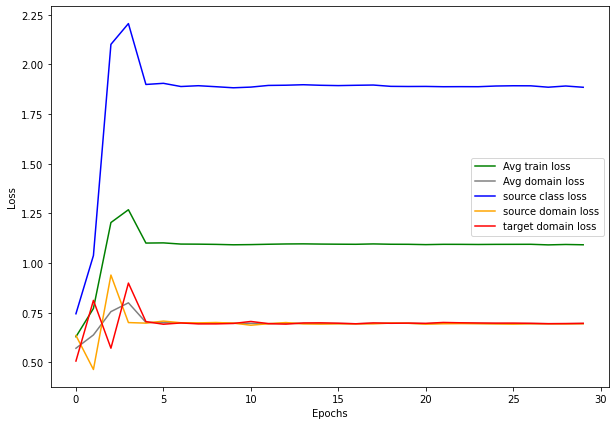

100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Test Accuracy: 0.24365234375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]



Source class Loss: 0.5786, Train class Acc: 0.79
Target class Loss: 0.1394, Val class Acc: 0.48
Source domain Loss: 0.8287, Source domain Acc: 0.46
Target domain Loss: 0.7949, Target domain Acc: 0.47
Total train Loss: 0.7341, Total train Acc: 0.57
Total domain Loss: 0.8118, Total domain Acc: 0.46


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 0.0992, Train class Acc: 0.97
Target class Loss: 0.0281, Val class Acc: 0.47
Source domain Loss: 0.8228, Source domain Acc: 0.44
Target domain Loss: 0.8074, Target domain Acc: 0.47
Total train Loss: 0.5765, Total train Acc: 0.63
Total domain Loss: 0.8151, Total domain Acc: 0.46


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.0590, Train class Acc: 0.98
Target class Loss: 0.0420, Val class Acc: 0.47
Source domain Loss: 0.8260, Source domain Acc: 0.45
Target domain Loss: 0.8219, Target domain Acc: 0.45
Total train Loss: 0.5690, Total train Acc: 0.63
Total domain Loss: 0.8240, Total domain Acc: 0.45


Starting epoch 4/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0277, Train class Acc: 0.99
Target class Loss: 0.0254, Val class Acc: 0.47
Source domain Loss: 0.8238, Source domain Acc: 0.46
Target domain Loss: 0.8211, Target domain Acc: 0.46
Total train Loss: 0.5575, Total train Acc: 0.64
Total domain Loss: 0.8225, Total domain Acc: 0.46


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0182, Train class Acc: 0.99
Target class Loss: 0.0100, Val class Acc: 0.48
Source domain Loss: 0.8206, Source domain Acc: 0.46
Target domain Loss: 0.8130, Target domain Acc: 0.46
Total train Loss: 0.5506, Total train Acc: 0.64
Total domain Loss: 0.8168, Total domain Acc: 0.46


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0136, Train class Acc: 1.00
Target class Loss: 0.0116, Val class Acc: 0.47
Source domain Loss: 0.8204, Source domain Acc: 0.45
Target domain Loss: 0.8148, Target domain Acc: 0.47
Total train Loss: 0.5496, Total train Acc: 0.64
Total domain Loss: 0.8176, Total domain Acc: 0.46


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0097, Train class Acc: 1.00
Target class Loss: 0.0061, Val class Acc: 0.49
Source domain Loss: 0.8063, Source domain Acc: 0.46
Target domain Loss: 0.8179, Target domain Acc: 0.46
Total train Loss: 0.5446, Total train Acc: 0.64
Total domain Loss: 0.8121, Total domain Acc: 0.46


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0077, Train class Acc: 1.00
Target class Loss: 0.0108, Val class Acc: 0.49
Source domain Loss: 0.8212, Source domain Acc: 0.46
Target domain Loss: 0.8197, Target domain Acc: 0.46
Total train Loss: 0.5495, Total train Acc: 0.64
Total domain Loss: 0.8204, Total domain Acc: 0.46


Starting epoch 9/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0089, Train class Acc: 1.00
Target class Loss: 0.0187, Val class Acc: 0.49
Source domain Loss: 0.8208, Source domain Acc: 0.45
Target domain Loss: 0.8168, Target domain Acc: 0.46
Total train Loss: 0.5489, Total train Acc: 0.64
Total domain Loss: 0.8188, Total domain Acc: 0.46


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.0052, Train class Acc: 1.00
Target class Loss: 0.0068, Val class Acc: 0.49
Source domain Loss: 0.8220, Source domain Acc: 0.44
Target domain Loss: 0.8149, Target domain Acc: 0.45
Total train Loss: 0.5474, Total train Acc: 0.63
Total domain Loss: 0.8184, Total domain Acc: 0.45


Starting epoch 11/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0027, Val class Acc: 0.49
Source domain Loss: 0.8135, Source domain Acc: 0.45
Target domain Loss: 0.8231, Target domain Acc: 0.45
Total train Loss: 0.5466, Total train Acc: 0.64
Total domain Loss: 0.8183, Total domain Acc: 0.45


Starting epoch 12/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.49
Source domain Loss: 0.8235, Source domain Acc: 0.46
Target domain Loss: 0.8194, Target domain Acc: 0.45
Total train Loss: 0.5488, Total train Acc: 0.64
Total domain Loss: 0.8214, Total domain Acc: 0.46


Starting epoch 13/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0013, Val class Acc: 0.49
Source domain Loss: 0.8121, Source domain Acc: 0.46
Target domain Loss: 0.8045, Target domain Acc: 0.46
Total train Loss: 0.5401, Total train Acc: 0.64
Total domain Loss: 0.8083, Total domain Acc: 0.46


Starting epoch 14/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.8176, Source domain Acc: 0.46
Target domain Loss: 0.8179, Target domain Acc: 0.46
Total train Loss: 0.5466, Total train Acc: 0.64
Total domain Loss: 0.8178, Total domain Acc: 0.46


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0024, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.8225, Source domain Acc: 0.46
Target domain Loss: 0.8099, Target domain Acc: 0.46
Total train Loss: 0.5449, Total train Acc: 0.64
Total domain Loss: 0.8162, Total domain Acc: 0.46


Starting epoch 16/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0046, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.8124, Source domain Acc: 0.45
Target domain Loss: 0.8134, Target domain Acc: 0.47
Total train Loss: 0.5434, Total train Acc: 0.64
Total domain Loss: 0.8129, Total domain Acc: 0.46


Starting epoch 17/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.8205, Source domain Acc: 0.45
Target domain Loss: 0.8159, Target domain Acc: 0.46
Total train Loss: 0.5470, Total train Acc: 0.64
Total domain Loss: 0.8182, Total domain Acc: 0.46


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0035, Val class Acc: 0.49
Source domain Loss: 0.8315, Source domain Acc: 0.45
Target domain Loss: 0.8199, Target domain Acc: 0.46
Total train Loss: 0.5516, Total train Acc: 0.63
Total domain Loss: 0.8257, Total domain Acc: 0.45


Starting epoch 19/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0035, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.49
Source domain Loss: 0.8151, Source domain Acc: 0.48
Target domain Loss: 0.8114, Target domain Acc: 0.47
Total train Loss: 0.5433, Total train Acc: 0.65
Total domain Loss: 0.8133, Total domain Acc: 0.47


Starting epoch 20/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.49
Source domain Loss: 0.8146, Source domain Acc: 0.46
Target domain Loss: 0.8141, Target domain Acc: 0.46
Total train Loss: 0.5439, Total train Acc: 0.64
Total domain Loss: 0.8143, Total domain Acc: 0.46


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0020, Val class Acc: 0.49
Source domain Loss: 0.8271, Source domain Acc: 0.46
Target domain Loss: 0.8065, Target domain Acc: 0.47
Total train Loss: 0.5456, Total train Acc: 0.64
Total domain Loss: 0.8168, Total domain Acc: 0.46


Starting epoch 22/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0066, Val class Acc: 0.49
Source domain Loss: 0.8284, Source domain Acc: 0.44
Target domain Loss: 0.8170, Target domain Acc: 0.46
Total train Loss: 0.5497, Total train Acc: 0.63
Total domain Loss: 0.8227, Total domain Acc: 0.45


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0052, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.49
Source domain Loss: 0.8282, Source domain Acc: 0.45
Target domain Loss: 0.8279, Target domain Acc: 0.46
Total train Loss: 0.5538, Total train Acc: 0.64
Total domain Loss: 0.8281, Total domain Acc: 0.45


Starting epoch 24/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0027, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.49
Source domain Loss: 0.8264, Source domain Acc: 0.44
Target domain Loss: 0.8144, Target domain Acc: 0.45
Total train Loss: 0.5478, Total train Acc: 0.63
Total domain Loss: 0.8204, Total domain Acc: 0.45


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.8299, Source domain Acc: 0.45
Target domain Loss: 0.8163, Target domain Acc: 0.47
Total train Loss: 0.5503, Total train Acc: 0.64
Total domain Loss: 0.8231, Total domain Acc: 0.46


Starting epoch 26/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0063, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.8156, Source domain Acc: 0.46
Target domain Loss: 0.8069, Target domain Acc: 0.46
Total train Loss: 0.5430, Total train Acc: 0.64
Total domain Loss: 0.8113, Total domain Acc: 0.46


Starting epoch 27/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0049, Train class Acc: 1.00
Target class Loss: 0.0090, Val class Acc: 0.49
Source domain Loss: 0.8193, Source domain Acc: 0.45
Target domain Loss: 0.8107, Target domain Acc: 0.46
Total train Loss: 0.5450, Total train Acc: 0.64
Total domain Loss: 0.8150, Total domain Acc: 0.46


Starting epoch 28/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0040, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.8287, Source domain Acc: 0.44
Target domain Loss: 0.8222, Target domain Acc: 0.45
Total train Loss: 0.5516, Total train Acc: 0.63
Total domain Loss: 0.8255, Total domain Acc: 0.45


Starting epoch 29/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.8308, Source domain Acc: 0.44
Target domain Loss: 0.8150, Target domain Acc: 0.47
Total train Loss: 0.5500, Total train Acc: 0.64
Total domain Loss: 0.8229, Total domain Acc: 0.45


Starting epoch 30/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0045, Train class Acc: 1.00
Target class Loss: 0.0054, Val class Acc: 0.49
Source domain Loss: 0.8306, Source domain Acc: 0.46
Target domain Loss: 0.8248, Target domain Acc: 0.46
Total train Loss: 0.5533, Total train Acc: 0.64
Total domain Loss: 0.8277, Total domain Acc: 0.46


[(0.5786411752924323, 0.7919921875), (0.09924616501666605, 0.9697265625), (0.05904207075946033, 0.9814453125), (0.027663301210850477, 0.99169921875), (0.018248304026201367, 0.99462890625), (0.013600807869806886, 0.99609375), (0.009660794166848063, 0.99755859375), (0.007736812578514218, 0.99853515625), (0.008943653432652354, 0.99658203125), (0.005233946139924228, 0.99951171875), (0.0031325144227594137, 0.99951171875), (0.0035776110598817468, 0.99951171875), (0.0036102570593357086, 0.99951171875), (0.004218335496261716, 0.9990234375), (0.002414860762655735, 1.0), (0.004564851755276322, 0.9990234375), (0.004739163909107447, 0.99951171875), (0.003308472689241171, 1.0), (0.003473426215350628, 1.

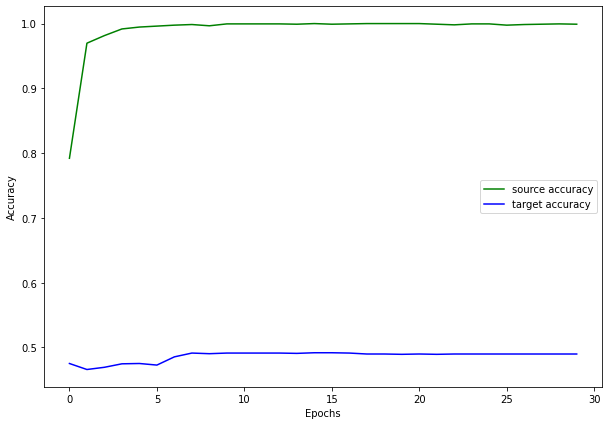

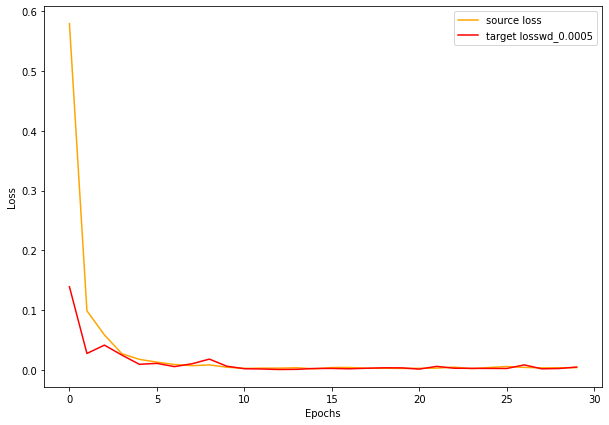

[(0.8287466466426849, 0.45654296875), (0.8228119164705276, 0.44140625), (0.826027512550354, 0.44580078125), (0.8237913325428963, 0.45556640625), (0.8205933198332787, 0.46337890625), (0.8204426765441895, 0.453125), (0.806334413588047, 0.4560546875), (0.8211990743875504, 0.45556640625), (0.8207970038056374, 0.451171875), (0.8220072016119957, 0.44482421875), (0.8134708926081657, 0.4541015625), (0.8234735056757927, 0.4599609375), (0.8121454641222954, 0.45849609375), (0.8176351264119148, 0.4580078125), (0.8224857673048973, 0.4580078125), (0.8123515993356705, 0.45068359375), (0.8204538375139236, 0.45166015625), (0.831462599337101, 0.44873046875), (0.8150984644889832, 0.47802734375), (0.8145790100097656, 0.46240234375), (0.8270938694477081, 0.4560546875), (0.8284337446093559, 0.44384765625), (0.8282187879085541, 0.45361328125), (0.8263966292142868, 0.44287109375), (0.8298609107732773, 0.44921875), (0.8156209141016006, 0.458984375), (0.8192957416176796, 0.45263671875), (0.8287327215075493, 0.4

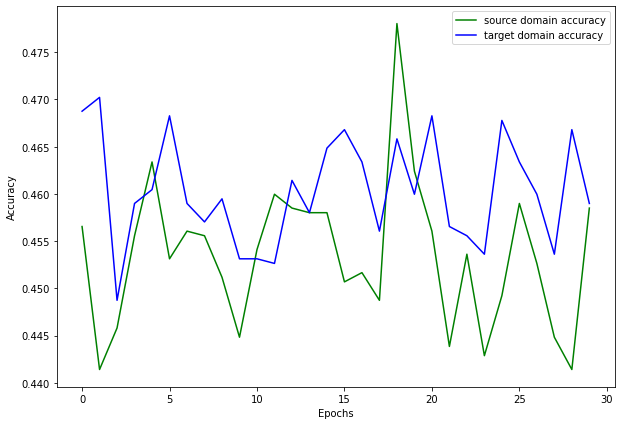

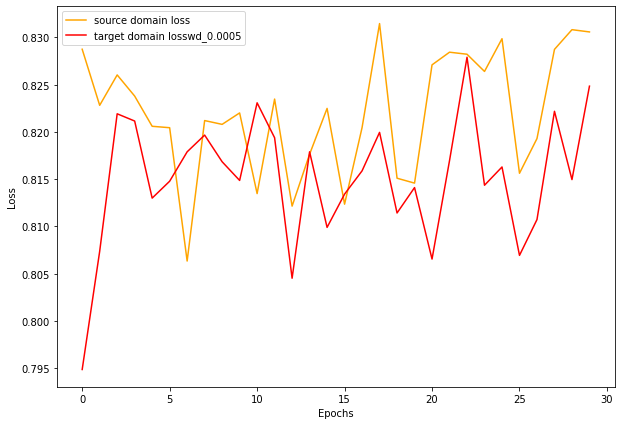

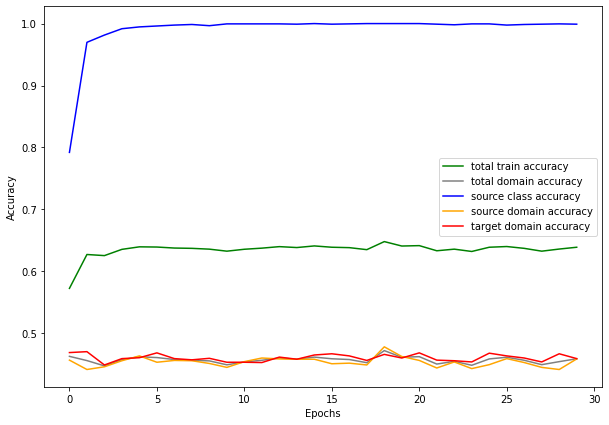

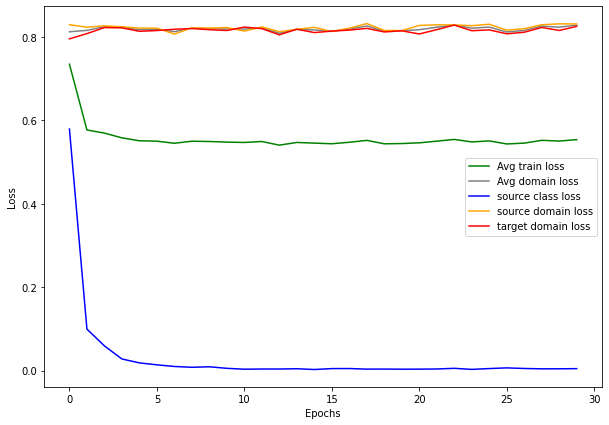

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Test Accuracy: 0.4912109375
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 0.5812, Train class Acc: 0.78
Target class Loss: 0.1631, Val class Acc: 0.48
Source domain Loss: 0.9252, Source domain Acc: 0.43
Target domain Loss: 0.5912, Target domain Acc: 0.69
Total train Loss: 0.6992, Total train Acc: 0.63
Total domain Loss: 0.7582, Total domain Acc: 0.56


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.1124, Train class Acc: 0.96
Target class Loss: 0.0750, Val class Acc: 0.48
Source domain Loss: 0.9340, Source domain Acc: 0.42
Target domain Loss: 0.5854, Target domain Acc: 0.70
Total train Loss: 0.5439, Total train Acc: 0.69
Total domain Loss: 0.7597, Total domain Acc: 0.56


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0582, Train class Acc: 0.98
Target class Loss: 0.0564, Val class Acc: 0.47
Source domain Loss: 0.9313, Source domain Acc: 0.42
Target domain Loss: 0.5788, Target domain Acc: 0.71
Total train Loss: 0.5228, Total train Acc: 0.70
Total domain Loss: 0.7551, Total domain Acc: 0.57


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0255, Train class Acc: 0.99
Target class Loss: 0.0162, Val class Acc: 0.48
Source domain Loss: 0.9322, Source domain Acc: 0.42
Target domain Loss: 0.5876, Target domain Acc: 0.69
Total train Loss: 0.5151, Total train Acc: 0.70
Total domain Loss: 0.7599, Total domain Acc: 0.55


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0187, Train class Acc: 0.99
Target class Loss: 0.0167, Val class Acc: 0.49
Source domain Loss: 0.9290, Source domain Acc: 0.41
Target domain Loss: 0.5850, Target domain Acc: 0.70
Total train Loss: 0.5109, Total train Acc: 0.70
Total domain Loss: 0.7570, Total domain Acc: 0.56


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0106, Train class Acc: 1.00
Target class Loss: 0.0055, Val class Acc: 0.48
Source domain Loss: 0.9368, Source domain Acc: 0.41
Target domain Loss: 0.5989, Target domain Acc: 0.68
Total train Loss: 0.5154, Total train Acc: 0.70
Total domain Loss: 0.7679, Total domain Acc: 0.55


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0065, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.49
Source domain Loss: 0.9191, Source domain Acc: 0.43
Target domain Loss: 0.5838, Target domain Acc: 0.70
Total train Loss: 0.5031, Total train Acc: 0.71
Total domain Loss: 0.7514, Total domain Acc: 0.56


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0061, Train class Acc: 1.00
Target class Loss: 0.0048, Val class Acc: 0.48
Source domain Loss: 0.9405, Source domain Acc: 0.42
Target domain Loss: 0.5841, Target domain Acc: 0.68
Total train Loss: 0.5102, Total train Acc: 0.70
Total domain Loss: 0.7623, Total domain Acc: 0.55


Starting epoch 9/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0051, Val class Acc: 0.48
Source domain Loss: 0.9288, Source domain Acc: 0.42
Target domain Loss: 0.5921, Target domain Acc: 0.68
Total train Loss: 0.5089, Total train Acc: 0.70
Total domain Loss: 0.7604, Total domain Acc: 0.55


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.48
Source domain Loss: 0.9416, Source domain Acc: 0.41
Target domain Loss: 0.5895, Target domain Acc: 0.68
Total train Loss: 0.5123, Total train Acc: 0.70
Total domain Loss: 0.7656, Total domain Acc: 0.54


Starting epoch 11/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0059, Train class Acc: 1.00
Target class Loss: 0.0053, Val class Acc: 0.48
Source domain Loss: 0.9308, Source domain Acc: 0.42
Target domain Loss: 0.5806, Target domain Acc: 0.69
Total train Loss: 0.5058, Total train Acc: 0.70
Total domain Loss: 0.7557, Total domain Acc: 0.56


Starting epoch 12/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0059, Val class Acc: 0.49
Source domain Loss: 0.9441, Source domain Acc: 0.42
Target domain Loss: 0.5975, Target domain Acc: 0.67
Total train Loss: 0.5156, Total train Acc: 0.70
Total domain Loss: 0.7708, Total domain Acc: 0.54


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0046, Val class Acc: 0.49
Source domain Loss: 0.9421, Source domain Acc: 0.41
Target domain Loss: 0.5915, Target domain Acc: 0.69
Total train Loss: 0.5128, Total train Acc: 0.70
Total domain Loss: 0.7668, Total domain Acc: 0.55


Starting epoch 14/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0026, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.49
Source domain Loss: 0.9167, Source domain Acc: 0.42
Target domain Loss: 0.5872, Target domain Acc: 0.69
Total train Loss: 0.5022, Total train Acc: 0.70
Total domain Loss: 0.7520, Total domain Acc: 0.56


Starting epoch 15/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.49
Source domain Loss: 0.9307, Source domain Acc: 0.42
Target domain Loss: 0.5892, Target domain Acc: 0.69
Total train Loss: 0.5077, Total train Acc: 0.71
Total domain Loss: 0.7600, Total domain Acc: 0.56


Starting epoch 16/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.49
Source domain Loss: 0.9230, Source domain Acc: 0.44
Target domain Loss: 0.5917, Target domain Acc: 0.68
Total train Loss: 0.5062, Total train Acc: 0.71
Total domain Loss: 0.7573, Total domain Acc: 0.56


Starting epoch 17/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.49
Source domain Loss: 0.9407, Source domain Acc: 0.42
Target domain Loss: 0.5997, Target domain Acc: 0.68
Total train Loss: 0.5149, Total train Acc: 0.70
Total domain Loss: 0.7702, Total domain Acc: 0.55


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0071, Val class Acc: 0.49
Source domain Loss: 0.9341, Source domain Acc: 0.42
Target domain Loss: 0.5914, Target domain Acc: 0.69
Total train Loss: 0.5101, Total train Acc: 0.70
Total domain Loss: 0.7628, Total domain Acc: 0.55


Starting epoch 19/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.49
Source domain Loss: 0.9247, Source domain Acc: 0.42
Target domain Loss: 0.6002, Target domain Acc: 0.68
Total train Loss: 0.5094, Total train Acc: 0.70
Total domain Loss: 0.7625, Total domain Acc: 0.55


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.9250, Source domain Acc: 0.43
Target domain Loss: 0.5842, Target domain Acc: 0.69
Total train Loss: 0.5044, Total train Acc: 0.71
Total domain Loss: 0.7546, Total domain Acc: 0.56


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0035, Train class Acc: 1.00
Target class Loss: 0.0020, Val class Acc: 0.49
Source domain Loss: 0.9265, Source domain Acc: 0.41
Target domain Loss: 0.5936, Target domain Acc: 0.68
Total train Loss: 0.5079, Total train Acc: 0.70
Total domain Loss: 0.7601, Total domain Acc: 0.55


Starting epoch 22/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.49
Source domain Loss: 0.9368, Source domain Acc: 0.41
Target domain Loss: 0.5911, Target domain Acc: 0.67
Total train Loss: 0.5103, Total train Acc: 0.69
Total domain Loss: 0.7639, Total domain Acc: 0.54


Starting epoch 23/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.49
Source domain Loss: 0.9246, Source domain Acc: 0.42
Target domain Loss: 0.5890, Target domain Acc: 0.69
Total train Loss: 0.5058, Total train Acc: 0.70
Total domain Loss: 0.7568, Total domain Acc: 0.55


Starting epoch 24/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.49
Source domain Loss: 0.9346, Source domain Acc: 0.41
Target domain Loss: 0.5884, Target domain Acc: 0.69
Total train Loss: 0.5093, Total train Acc: 0.70
Total domain Loss: 0.7615, Total domain Acc: 0.55


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.49
Source domain Loss: 0.9415, Source domain Acc: 0.41
Target domain Loss: 0.5976, Target domain Acc: 0.68
Total train Loss: 0.5150, Total train Acc: 0.70
Total domain Loss: 0.7695, Total domain Acc: 0.54


Starting epoch 26/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0085, Val class Acc: 0.49
Source domain Loss: 0.9258, Source domain Acc: 0.42
Target domain Loss: 0.5983, Target domain Acc: 0.68
Total train Loss: 0.5092, Total train Acc: 0.70
Total domain Loss: 0.7621, Total domain Acc: 0.55


Starting epoch 27/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0024, Train class Acc: 1.00
Target class Loss: 0.0015, Val class Acc: 0.49
Source domain Loss: 0.9480, Source domain Acc: 0.41
Target domain Loss: 0.5946, Target domain Acc: 0.68
Total train Loss: 0.5150, Total train Acc: 0.70
Total domain Loss: 0.7713, Total domain Acc: 0.54


Starting epoch 28/30, LR = [0.0001]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0060, Val class Acc: 0.49
Source domain Loss: 0.9498, Source domain Acc: 0.41
Target domain Loss: 0.5943, Target domain Acc: 0.68
Total train Loss: 0.5160, Total train Acc: 0.70
Total domain Loss: 0.7720, Total domain Acc: 0.54


Starting epoch 29/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0059, Val class Acc: 0.49
Source domain Loss: 0.9356, Source domain Acc: 0.42
Target domain Loss: 0.5943, Target domain Acc: 0.68
Total train Loss: 0.5114, Total train Acc: 0.70
Total domain Loss: 0.7650, Total domain Acc: 0.55


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0028, Val class Acc: 0.49
Source domain Loss: 0.9312, Source domain Acc: 0.42
Target domain Loss: 0.5854, Target domain Acc: 0.70
Total train Loss: 0.5066, Total train Acc: 0.71
Total domain Loss: 0.7583, Total domain Acc: 0.56


[(0.5812339037656784, 0.7822265625), (0.11235971469432116, 0.96435546875), (0.05821254150941968, 0.9814453125), (0.02553870645351708, 0.990234375), (0.01870710274670273, 0.99462890625), (0.010580268921330571, 0.99755859375), (0.006468813167884946, 1.0), (0.006110577145591378, 1.0), (0.005823962623253465, 0.99951171875), (0.005801631370559335, 0.9990234375), (0.005923801101744175, 0.998046875), (0.0050928115379065275, 0.99951171875), (0.004774116910994053, 0.99951171875), (0.0026048594154417515, 1.0), (0.0031834933906793594, 1.0), (0.003855916205793619, 1.0), (0.004122684244066477, 0.99951171875), (0.004837827989831567, 0.99853515625), (0.0033925333991646767, 1.0), (0.004108261549845338, 0.9

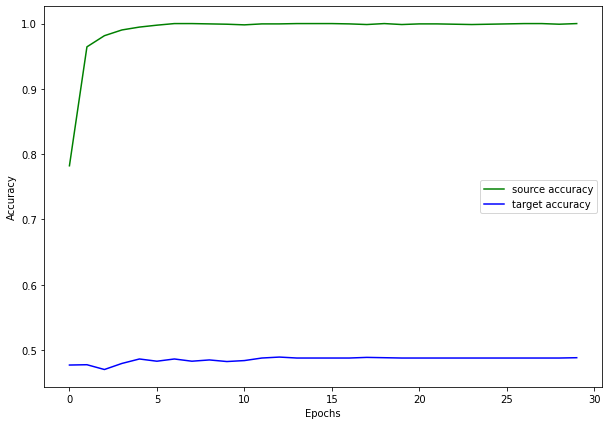

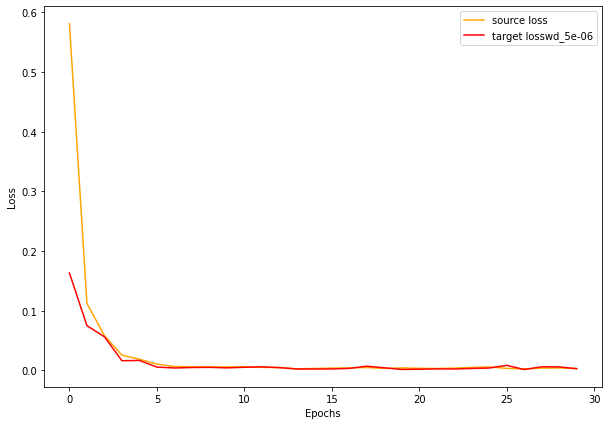

[(0.9251957088708878, 0.4296875), (0.934040866792202, 0.4169921875), (0.9313157275319099, 0.41845703125), (0.9322122409939766, 0.4189453125), (0.9289923161268234, 0.4130859375), (0.9368372708559036, 0.41357421875), (0.9190504848957062, 0.42724609375), (0.9405396431684494, 0.41552734375), (0.9287855699658394, 0.416015625), (0.9416138753294945, 0.40576171875), (0.9308302849531174, 0.4228515625), (0.944112204015255, 0.41552734375), (0.9421496763825417, 0.40576171875), (0.9166929721832275, 0.423828125), (0.9307358935475349, 0.4228515625), (0.9229509457945824, 0.43603515625), (0.9407152310013771, 0.41552734375), (0.9341175258159637, 0.4208984375), (0.9247460514307022, 0.41943359375), (0.9250067248940468, 0.42919921875), (0.9265198186039925, 0.4140625), (0.9367615655064583, 0.41259765625), (0.9245876297354698, 0.416015625), (0.9345607981085777, 0.41015625), (0.9414607807993889, 0.41064453125), (0.9257998168468475, 0.4150390625), (0.9479798972606659, 0.41015625), (0.9497789293527603, 0.411132

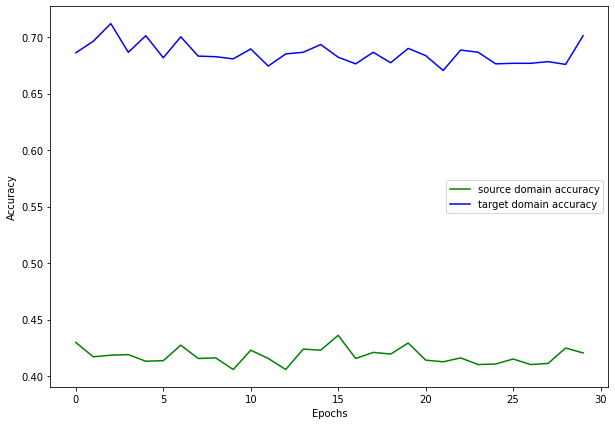

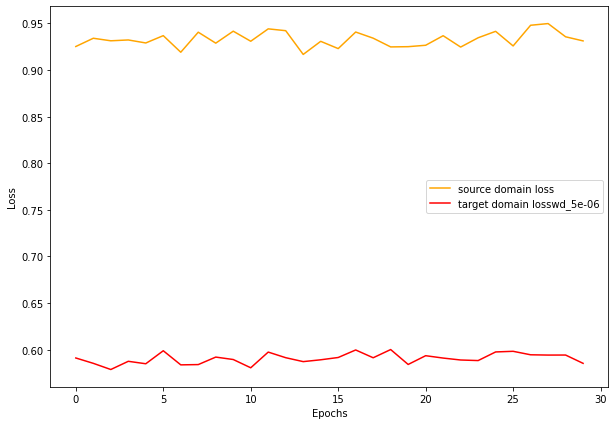

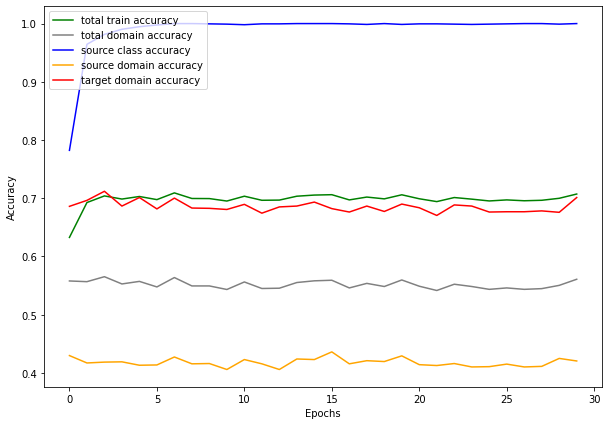

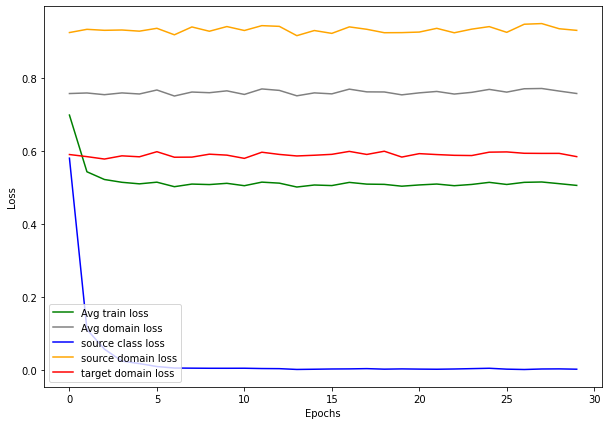

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Test Accuracy: 0.48779296875
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.5797, Train class Acc: 0.80
Target class Loss: 0.1615, Val class Acc: 0.47
Source domain Loss: 0.6925, Source domain Acc: 0.61
Target domain Loss: 0.9983, Target domain Acc: 0.34
Total train Loss: 0.7568, Total train Acc: 0.58
Total domain Loss: 0.8454, Total domain Acc: 0.48


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Source class Loss: 0.0875, Train class Acc: 0.97
Target class Loss: 0.0274, Val class Acc: 0.48
Source domain Loss: 0.6946, Source domain Acc: 0.60
Target domain Loss: 1.0017, Target domain Acc: 0.34
Total train Loss: 0.5946, Total train Acc: 0.64
Total domain Loss: 0.8481, Total domain Acc: 0.47


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0523, Train class Acc: 0.98
Target class Loss: 0.0281, Val class Acc: 0.49
Source domain Loss: 0.7019, Source domain Acc: 0.60
Target domain Loss: 0.9978, Target domain Acc: 0.34
Total train Loss: 0.5840, Total train Acc: 0.64
Total domain Loss: 0.8499, Total domain Acc: 0.47


Starting epoch 4/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.0244, Train class Acc: 0.99
Target class Loss: 0.0165, Val class Acc: 0.49
Source domain Loss: 0.6955, Source domain Acc: 0.62
Target domain Loss: 1.0039, Target domain Acc: 0.34
Total train Loss: 0.5746, Total train Acc: 0.65
Total domain Loss: 0.8497, Total domain Acc: 0.48


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]



Source class Loss: 0.0178, Train class Acc: 0.99
Target class Loss: 0.0027, Val class Acc: 0.48
Source domain Loss: 0.7003, Source domain Acc: 0.60
Target domain Loss: 1.0048, Target domain Acc: 0.33
Total train Loss: 0.5743, Total train Acc: 0.64
Total domain Loss: 0.8525, Total domain Acc: 0.46


Starting epoch 6/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Source class Loss: 0.0101, Train class Acc: 1.00
Target class Loss: 0.0193, Val class Acc: 0.48
Source domain Loss: 0.7042, Source domain Acc: 0.61
Target domain Loss: 1.0114, Target domain Acc: 0.33
Total train Loss: 0.5752, Total train Acc: 0.64
Total domain Loss: 0.8578, Total domain Acc: 0.47


Starting epoch 7/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.0158, Train class Acc: 1.00
Target class Loss: 0.0219, Val class Acc: 0.49
Source domain Loss: 0.6958, Source domain Acc: 0.61
Target domain Loss: 0.9966, Target domain Acc: 0.34
Total train Loss: 0.5694, Total train Acc: 0.65
Total domain Loss: 0.8462, Total domain Acc: 0.47


Starting epoch 8/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Source class Loss: 0.0109, Train class Acc: 1.00
Target class Loss: 0.0148, Val class Acc: 0.49
Source domain Loss: 0.7003, Source domain Acc: 0.60
Target domain Loss: 1.0069, Target domain Acc: 0.33
Total train Loss: 0.5727, Total train Acc: 0.65
Total domain Loss: 0.8536, Total domain Acc: 0.47


Starting epoch 9/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0091, Train class Acc: 1.00
Target class Loss: 0.0035, Val class Acc: 0.49
Source domain Loss: 0.6903, Source domain Acc: 0.63
Target domain Loss: 1.0012, Target domain Acc: 0.34
Total train Loss: 0.5669, Total train Acc: 0.65
Total domain Loss: 0.8458, Total domain Acc: 0.48


Starting epoch 10/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0134, Train class Acc: 1.00
Target class Loss: 0.0086, Val class Acc: 0.48
Source domain Loss: 0.7009, Source domain Acc: 0.59
Target domain Loss: 0.9921, Target domain Acc: 0.34
Total train Loss: 0.5688, Total train Acc: 0.64
Total domain Loss: 0.8465, Total domain Acc: 0.47


Starting epoch 11/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0113, Train class Acc: 1.00
Target class Loss: 0.0123, Val class Acc: 0.48
Source domain Loss: 0.7013, Source domain Acc: 0.59
Target domain Loss: 0.9944, Target domain Acc: 0.33
Total train Loss: 0.5690, Total train Acc: 0.64
Total domain Loss: 0.8478, Total domain Acc: 0.46


Starting epoch 12/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0084, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.48
Source domain Loss: 0.6972, Source domain Acc: 0.61
Target domain Loss: 1.0171, Target domain Acc: 0.33
Total train Loss: 0.5742, Total train Acc: 0.65
Total domain Loss: 0.8572, Total domain Acc: 0.47


Starting epoch 13/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0126, Train class Acc: 1.00
Target class Loss: 0.0191, Val class Acc: 0.48
Source domain Loss: 0.7014, Source domain Acc: 0.61
Target domain Loss: 0.9991, Target domain Acc: 0.34
Total train Loss: 0.5710, Total train Acc: 0.65
Total domain Loss: 0.8503, Total domain Acc: 0.47


Starting epoch 14/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0092, Train class Acc: 1.00
Target class Loss: 0.0059, Val class Acc: 0.48
Source domain Loss: 0.6980, Source domain Acc: 0.62
Target domain Loss: 1.0038, Target domain Acc: 0.32
Total train Loss: 0.5703, Total train Acc: 0.65
Total domain Loss: 0.8509, Total domain Acc: 0.47


Starting epoch 15/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0103, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.48
Source domain Loss: 0.6997, Source domain Acc: 0.61
Target domain Loss: 1.0061, Target domain Acc: 0.34
Total train Loss: 0.5720, Total train Acc: 0.65
Total domain Loss: 0.8529, Total domain Acc: 0.48


Starting epoch 16/30, LR = [1e-05]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0102, Train class Acc: 1.00
Target class Loss: 0.0052, Val class Acc: 0.48
Source domain Loss: 0.6907, Source domain Acc: 0.62
Target domain Loss: 0.9925, Target domain Acc: 0.35
Total train Loss: 0.5645, Total train Acc: 0.65
Total domain Loss: 0.8416, Total domain Acc: 0.48


Starting epoch 17/30, LR = [1e-05]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0108, Train class Acc: 1.00
Target class Loss: 0.0064, Val class Acc: 0.48
Source domain Loss: 0.6938, Source domain Acc: 0.61
Target domain Loss: 0.9998, Target domain Acc: 0.34
Total train Loss: 0.5682, Total train Acc: 0.65
Total domain Loss: 0.8468, Total domain Acc: 0.47


Starting epoch 18/30, LR = [1e-05]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0073, Train class Acc: 1.00
Target class Loss: 0.0047, Val class Acc: 0.48
Source domain Loss: 0.6800, Source domain Acc: 0.62
Target domain Loss: 1.0003, Target domain Acc: 0.34
Total train Loss: 0.5625, Total train Acc: 0.65
Total domain Loss: 0.8401, Total domain Acc: 0.48


Starting epoch 19/30, LR = [1e-05]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0100, Train class Acc: 1.00
Target class Loss: 0.0164, Val class Acc: 0.48
Source domain Loss: 0.7122, Source domain Acc: 0.58
Target domain Loss: 1.0137, Target domain Acc: 0.33
Total train Loss: 0.5787, Total train Acc: 0.64
Total domain Loss: 0.8630, Total domain Acc: 0.46


Starting epoch 20/30, LR = [1e-05]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0091, Train class Acc: 1.00
Target class Loss: 0.0114, Val class Acc: 0.48
Source domain Loss: 0.6979, Source domain Acc: 0.60
Target domain Loss: 0.9971, Target domain Acc: 0.34
Total train Loss: 0.5680, Total train Acc: 0.65
Total domain Loss: 0.8475, Total domain Acc: 0.47


Starting epoch 21/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0097, Train class Acc: 1.00
Target class Loss: 0.0141, Val class Acc: 0.48
Source domain Loss: 0.7014, Source domain Acc: 0.60
Target domain Loss: 0.9939, Target domain Acc: 0.34
Total train Loss: 0.5683, Total train Acc: 0.65
Total domain Loss: 0.8476, Total domain Acc: 0.47


Starting epoch 22/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0110, Train class Acc: 1.00
Target class Loss: 0.0186, Val class Acc: 0.48
Source domain Loss: 0.7046, Source domain Acc: 0.62
Target domain Loss: 0.9877, Target domain Acc: 0.35
Total train Loss: 0.5678, Total train Acc: 0.66
Total domain Loss: 0.8462, Total domain Acc: 0.48


Starting epoch 23/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0098, Train class Acc: 1.00
Target class Loss: 0.0079, Val class Acc: 0.48
Source domain Loss: 0.6907, Source domain Acc: 0.61
Target domain Loss: 0.9991, Target domain Acc: 0.34
Total train Loss: 0.5665, Total train Acc: 0.65
Total domain Loss: 0.8449, Total domain Acc: 0.48


Starting epoch 24/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0081, Train class Acc: 1.00
Target class Loss: 0.0122, Val class Acc: 0.48
Source domain Loss: 0.6958, Source domain Acc: 0.60
Target domain Loss: 1.0104, Target domain Acc: 0.34
Total train Loss: 0.5714, Total train Acc: 0.65
Total domain Loss: 0.8531, Total domain Acc: 0.47


Starting epoch 25/30, LR = [1.0000000000000002e-06]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0105, Train class Acc: 1.00
Target class Loss: 0.0179, Val class Acc: 0.48
Source domain Loss: 0.7015, Source domain Acc: 0.60
Target domain Loss: 0.9948, Target domain Acc: 0.34
Total train Loss: 0.5689, Total train Acc: 0.65
Total domain Loss: 0.8481, Total domain Acc: 0.47


Starting epoch 26/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Source class Loss: 0.0107, Train class Acc: 1.00
Target class Loss: 0.0121, Val class Acc: 0.48
Source domain Loss: 0.6862, Source domain Acc: 0.62
Target domain Loss: 0.9920, Target domain Acc: 0.34
Total train Loss: 0.5630, Total train Acc: 0.65
Total domain Loss: 0.8391, Total domain Acc: 0.48


Starting epoch 27/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0096, Train class Acc: 1.00
Target class Loss: 0.0053, Val class Acc: 0.48
Source domain Loss: 0.6969, Source domain Acc: 0.60
Target domain Loss: 1.0087, Target domain Acc: 0.33
Total train Loss: 0.5717, Total train Acc: 0.64
Total domain Loss: 0.8528, Total domain Acc: 0.46


Starting epoch 28/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0097, Train class Acc: 1.00
Target class Loss: 0.0052, Val class Acc: 0.48
Source domain Loss: 0.6878, Source domain Acc: 0.62
Target domain Loss: 1.0111, Target domain Acc: 0.33
Total train Loss: 0.5695, Total train Acc: 0.65
Total domain Loss: 0.8494, Total domain Acc: 0.47


Starting epoch 29/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0097, Train class Acc: 1.00
Target class Loss: 0.0061, Val class Acc: 0.48
Source domain Loss: 0.6987, Source domain Acc: 0.62
Target domain Loss: 1.0074, Target domain Acc: 0.34
Total train Loss: 0.5719, Total train Acc: 0.65
Total domain Loss: 0.8531, Total domain Acc: 0.48


Starting epoch 30/30, LR = [1.0000000000000002e-07]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0082, Train class Acc: 1.00
Target class Loss: 0.0086, Val class Acc: 0.48
Source domain Loss: 0.6928, Source domain Acc: 0.60
Target domain Loss: 1.0142, Target domain Acc: 0.33
Total train Loss: 0.5717, Total train Acc: 0.64
Total domain Loss: 0.8535, Total domain Acc: 0.47


[(0.5796654913574457, 0.7958984375), (0.08745999075472355, 0.97119140625), (0.05231780791655183, 0.982421875), (0.02442775061354041, 0.9921875), (0.01784054678864777, 0.994140625), (0.01008014171384275, 0.9970703125), (0.015849907649680972, 0.9951171875), (0.010888113640248775, 0.99755859375), (0.009062237804755569, 0.9970703125), (0.01344488631002605, 0.99755859375), (0.011287176865153015, 0.99658203125), (0.008407020475715399, 0.99755859375), (0.012575138127431273, 0.99658203125), (0.009193440433591604, 0.9970703125), (0.010261346702463925, 0.99755859375), (0.010228606057353318, 0.9970703125), (0.01084088149946183, 0.998046875), (0.007304820464923978, 0.99951171875), (0.010038820095360279

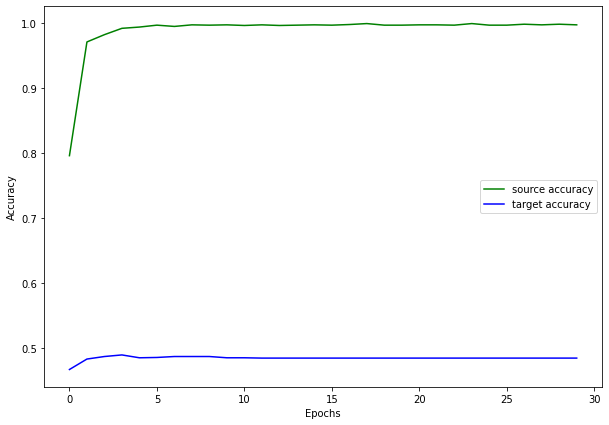

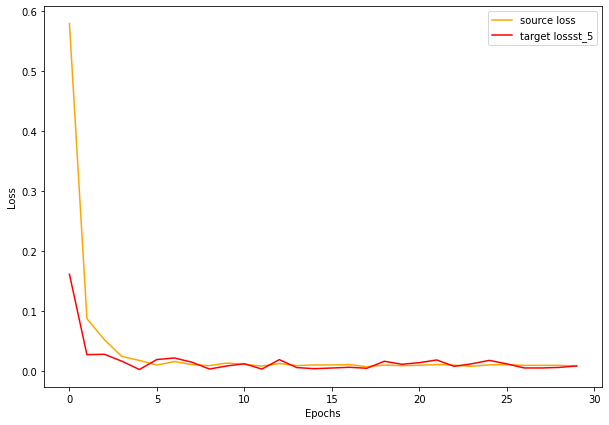

[(0.6925333440303802, 0.6142578125), (0.6945913657546043, 0.59912109375), (0.7019221037626266, 0.60498046875), (0.6955083161592484, 0.6201171875), (0.7002699449658394, 0.59912109375), (0.7042013183236122, 0.60595703125), (0.6958241760730743, 0.60595703125), (0.7002774178981781, 0.6044921875), (0.6903477013111115, 0.6259765625), (0.7009204030036926, 0.59326171875), (0.7012819051742554, 0.59375), (0.6972465664148331, 0.6083984375), (0.7014444693922997, 0.60595703125), (0.6979802995920181, 0.62060546875), (0.6997120678424835, 0.6083984375), (0.6907452195882797, 0.61767578125), (0.6938130259513855, 0.6123046875), (0.6799887269735336, 0.61865234375), (0.7122286111116409, 0.5849609375), (0.6978679597377777, 0.59814453125), (0.7013643831014633, 0.599609375), (0.7046276330947876, 0.62060546875), (0.6906998381018639, 0.611328125), (0.6957744434475899, 0.60107421875), (0.7014602795243263, 0.59912109375), (0.6861906722187996, 0.61767578125), (0.6969259306788445, 0.60205078125), (0.687806010246276

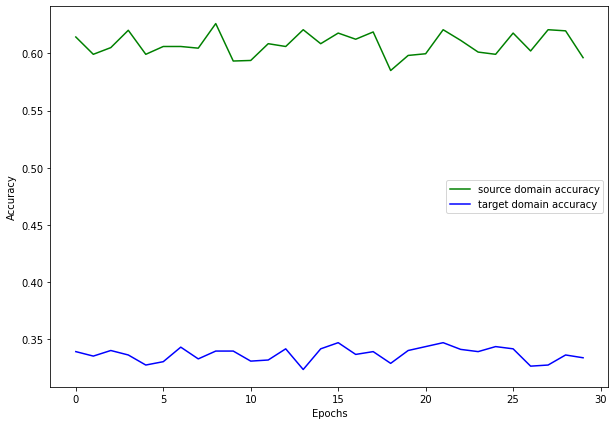

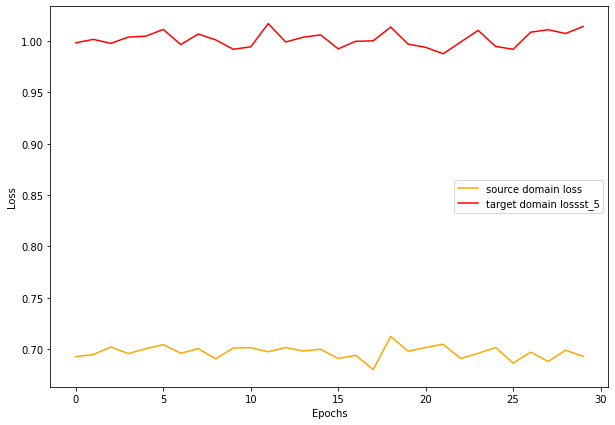

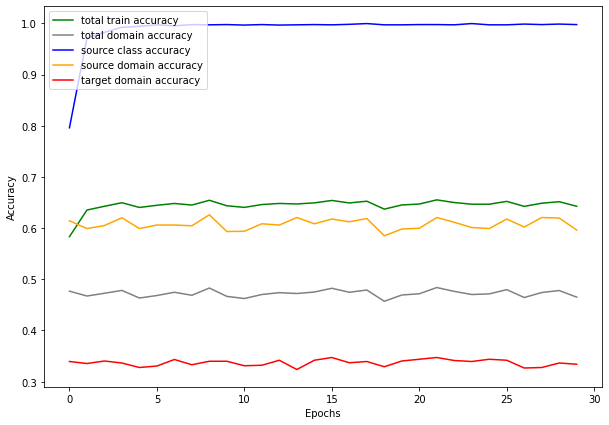

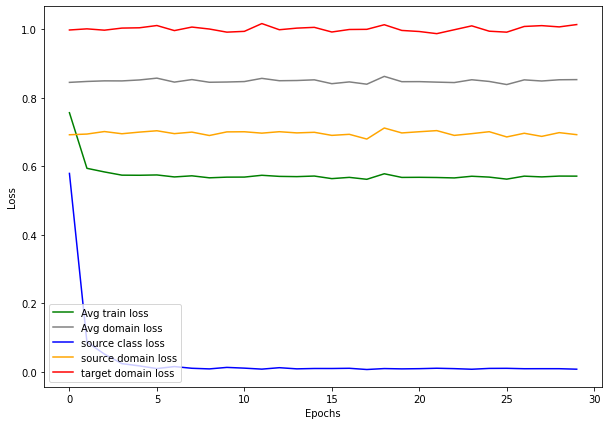

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Test Accuracy: 0.484375
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Source class Loss: 0.6419, Train class Acc: 0.76
Target class Loss: 0.1578, Val class Acc: 0.49
Source domain Loss: 0.7435, Source domain Acc: 0.52
Target domain Loss: 0.7533, Target domain Acc: 0.54
Total train Loss: 0.7129, Total train Acc: 0.61
Total domain Loss: 0.7484, Total domain Acc: 0.53


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.0917, Train class Acc: 0.97
Target class Loss: 0.0436, Val class Acc: 0.48
Source domain Loss: 0.7343, Source domain Acc: 0.53
Target domain Loss: 0.7548, Target domain Acc: 0.53
Total train Loss: 0.5269, Total train Acc: 0.68
Total domain Loss: 0.7446, Total domain Acc: 0.53


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0494, Train class Acc: 0.98
Target class Loss: 0.0172, Val class Acc: 0.48
Source domain Loss: 0.7280, Source domain Acc: 0.52
Target domain Loss: 0.7667, Target domain Acc: 0.52
Total train Loss: 0.5147, Total train Acc: 0.67
Total domain Loss: 0.7474, Total domain Acc: 0.52


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0248, Train class Acc: 0.99
Target class Loss: 0.0214, Val class Acc: 0.49
Source domain Loss: 0.7282, Source domain Acc: 0.54
Target domain Loss: 0.7484, Target domain Acc: 0.54
Total train Loss: 0.5005, Total train Acc: 0.69
Total domain Loss: 0.7383, Total domain Acc: 0.54


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0206, Train class Acc: 1.00
Target class Loss: 0.0541, Val class Acc: 0.49
Source domain Loss: 0.7301, Source domain Acc: 0.52
Target domain Loss: 0.7563, Target domain Acc: 0.53
Total train Loss: 0.5023, Total train Acc: 0.68
Total domain Loss: 0.7432, Total domain Acc: 0.53


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0111, Train class Acc: 1.00
Target class Loss: 0.0118, Val class Acc: 0.48
Source domain Loss: 0.7416, Source domain Acc: 0.52
Target domain Loss: 0.7492, Target domain Acc: 0.54
Total train Loss: 0.5007, Total train Acc: 0.69
Total domain Loss: 0.7454, Total domain Acc: 0.53


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0101, Train class Acc: 1.00
Target class Loss: 0.0090, Val class Acc: 0.49
Source domain Loss: 0.7359, Source domain Acc: 0.53
Target domain Loss: 0.7513, Target domain Acc: 0.54
Total train Loss: 0.4991, Total train Acc: 0.69
Total domain Loss: 0.7436, Total domain Acc: 0.53


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0066, Train class Acc: 1.00
Target class Loss: 0.0046, Val class Acc: 0.48
Source domain Loss: 0.7301, Source domain Acc: 0.53
Target domain Loss: 0.7425, Target domain Acc: 0.55
Total train Loss: 0.4931, Total train Acc: 0.69
Total domain Loss: 0.7363, Total domain Acc: 0.54


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0053, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.49
Source domain Loss: 0.7273, Source domain Acc: 0.54
Target domain Loss: 0.7527, Target domain Acc: 0.54
Total train Loss: 0.4951, Total train Acc: 0.69
Total domain Loss: 0.7400, Total domain Acc: 0.54


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0050, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.7358, Source domain Acc: 0.52
Target domain Loss: 0.7502, Target domain Acc: 0.54
Total train Loss: 0.4970, Total train Acc: 0.68
Total domain Loss: 0.7430, Total domain Acc: 0.53


Starting epoch 11/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0047, Val class Acc: 0.49
Source domain Loss: 0.7292, Source domain Acc: 0.52
Target domain Loss: 0.7591, Target domain Acc: 0.53
Total train Loss: 0.4979, Total train Acc: 0.69
Total domain Loss: 0.7442, Total domain Acc: 0.53


Starting epoch 12/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.7359, Source domain Acc: 0.52
Target domain Loss: 0.7600, Target domain Acc: 0.54
Total train Loss: 0.4999, Total train Acc: 0.69
Total domain Loss: 0.7479, Total domain Acc: 0.53


Starting epoch 13/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0089, Val class Acc: 0.49
Source domain Loss: 0.7337, Source domain Acc: 0.51
Target domain Loss: 0.7543, Target domain Acc: 0.54
Total train Loss: 0.4974, Total train Acc: 0.68
Total domain Loss: 0.7440, Total domain Acc: 0.52


Starting epoch 14/30, LR = [0.001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0057, Train class Acc: 1.00
Target class Loss: 0.0028, Val class Acc: 0.49
Source domain Loss: 0.7265, Source domain Acc: 0.54
Target domain Loss: 0.7428, Target domain Acc: 0.55
Total train Loss: 0.4916, Total train Acc: 0.70
Total domain Loss: 0.7346, Total domain Acc: 0.55


Starting epoch 15/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0062, Train class Acc: 1.00
Target class Loss: 0.0082, Val class Acc: 0.49
Source domain Loss: 0.7310, Source domain Acc: 0.52
Target domain Loss: 0.7622, Target domain Acc: 0.54
Total train Loss: 0.4998, Total train Acc: 0.69
Total domain Loss: 0.7466, Total domain Acc: 0.53


Starting epoch 16/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.49
Source domain Loss: 0.7307, Source domain Acc: 0.54
Target domain Loss: 0.7550, Target domain Acc: 0.54
Total train Loss: 0.4963, Total train Acc: 0.69
Total domain Loss: 0.7429, Total domain Acc: 0.54


Starting epoch 17/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.7205, Source domain Acc: 0.54
Target domain Loss: 0.7482, Target domain Acc: 0.54
Total train Loss: 0.4908, Total train Acc: 0.69
Total domain Loss: 0.7344, Total domain Acc: 0.54


Starting epoch 18/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0029, Val class Acc: 0.49
Source domain Loss: 0.7346, Source domain Acc: 0.53
Target domain Loss: 0.7488, Target domain Acc: 0.55
Total train Loss: 0.4956, Total train Acc: 0.69
Total domain Loss: 0.7417, Total domain Acc: 0.54


Starting epoch 19/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0037, Train class Acc: 1.00
Target class Loss: 0.0079, Val class Acc: 0.49
Source domain Loss: 0.7382, Source domain Acc: 0.52
Target domain Loss: 0.7489, Target domain Acc: 0.54
Total train Loss: 0.4969, Total train Acc: 0.69
Total domain Loss: 0.7436, Total domain Acc: 0.53


Starting epoch 20/30, LR = [0.001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0064, Val class Acc: 0.49
Source domain Loss: 0.7331, Source domain Acc: 0.53
Target domain Loss: 0.7509, Target domain Acc: 0.55
Total train Loss: 0.4957, Total train Acc: 0.69
Total domain Loss: 0.7420, Total domain Acc: 0.54


Starting epoch 21/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.49
Source domain Loss: 0.7289, Source domain Acc: 0.52
Target domain Loss: 0.7512, Target domain Acc: 0.55
Total train Loss: 0.4946, Total train Acc: 0.69
Total domain Loss: 0.7400, Total domain Acc: 0.53


Starting epoch 22/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0068, Val class Acc: 0.49
Source domain Loss: 0.7173, Source domain Acc: 0.54
Target domain Loss: 0.7491, Target domain Acc: 0.54
Total train Loss: 0.4900, Total train Acc: 0.69
Total domain Loss: 0.7332, Total domain Acc: 0.54


Starting epoch 23/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.7293, Source domain Acc: 0.52
Target domain Loss: 0.7530, Target domain Acc: 0.54
Total train Loss: 0.4955, Total train Acc: 0.69
Total domain Loss: 0.7412, Total domain Acc: 0.53


Starting epoch 24/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0060, Train class Acc: 1.00
Target class Loss: 0.0065, Val class Acc: 0.49
Source domain Loss: 0.7307, Source domain Acc: 0.54
Target domain Loss: 0.7334, Target domain Acc: 0.55
Total train Loss: 0.4900, Total train Acc: 0.70
Total domain Loss: 0.7320, Total domain Acc: 0.55


Starting epoch 25/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0040, Train class Acc: 1.00
Target class Loss: 0.0017, Val class Acc: 0.49
Source domain Loss: 0.7397, Source domain Acc: 0.52
Target domain Loss: 0.7558, Target domain Acc: 0.53
Total train Loss: 0.4998, Total train Acc: 0.68
Total domain Loss: 0.7478, Total domain Acc: 0.53


Starting epoch 26/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0049, Train class Acc: 1.00
Target class Loss: 0.0052, Val class Acc: 0.49
Source domain Loss: 0.7292, Source domain Acc: 0.53
Target domain Loss: 0.7657, Target domain Acc: 0.52
Total train Loss: 0.4999, Total train Acc: 0.68
Total domain Loss: 0.7474, Total domain Acc: 0.53


Starting epoch 27/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Source class Loss: 0.0037, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.49
Source domain Loss: 0.7399, Source domain Acc: 0.52
Target domain Loss: 0.7518, Target domain Acc: 0.54
Total train Loss: 0.4985, Total train Acc: 0.69
Total domain Loss: 0.7458, Total domain Acc: 0.53


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.7316, Source domain Acc: 0.52
Target domain Loss: 0.7530, Target domain Acc: 0.53
Total train Loss: 0.4962, Total train Acc: 0.68
Total domain Loss: 0.7423, Total domain Acc: 0.53


Starting epoch 29/30, LR = [0.0001]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.49
Source domain Loss: 0.7197, Source domain Acc: 0.54
Target domain Loss: 0.7530, Target domain Acc: 0.52
Total train Loss: 0.4920, Total train Acc: 0.69
Total domain Loss: 0.7364, Total domain Acc: 0.53


Starting epoch 30/30, LR = [0.0001]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0040, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.7350, Source domain Acc: 0.51
Target domain Loss: 0.7570, Target domain Acc: 0.54
Total train Loss: 0.4987, Total train Acc: 0.68
Total domain Loss: 0.7460, Total domain Acc: 0.53


[(0.6419058814644814, 0.7646484375), (0.09165135771036148, 0.9677734375), (0.04935128544457257, 0.98291015625), (0.02484980085864663, 0.9912109375), (0.02058399631641805, 0.9951171875), (0.011110362713225186, 0.9970703125), (0.010132477967999876, 0.99755859375), (0.006599164335057139, 0.99853515625), (0.005321466596797109, 0.9990234375), (0.0050249474588781595, 0.99853515625), (0.005367502337321639, 0.99853515625), (0.003942330600693822, 0.99951171875), (0.004312734119594097, 0.99951171875), (0.005652399268001318, 0.998046875), (0.006214272929355502, 0.998046875), (0.0033252115827053785, 1.0), (0.003562605706974864, 0.99951171875), (0.0032655836548656225, 0.99951171875), (0.0036551284138113

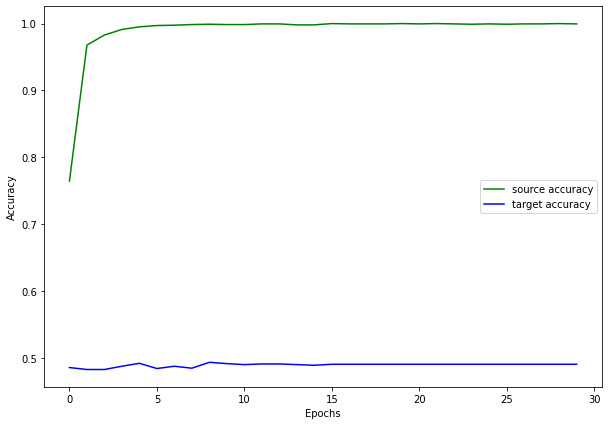

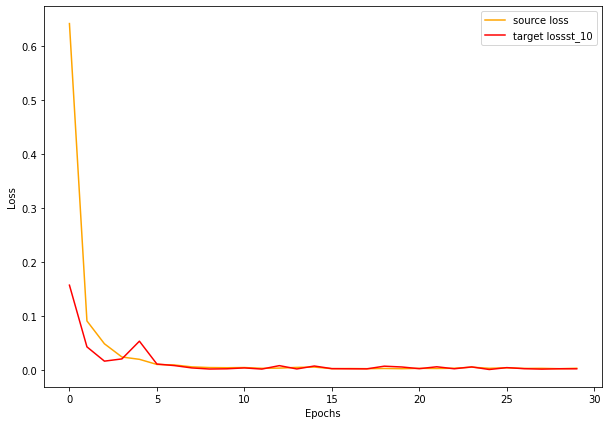

[(0.7435472309589386, 0.515625), (0.7343013361096382, 0.5302734375), (0.7280315086245537, 0.521484375), (0.7281540408730507, 0.53564453125), (0.7300506308674812, 0.52490234375), (0.7416097745299339, 0.517578125), (0.735907755792141, 0.5302734375), (0.7301284372806549, 0.52978515625), (0.7272795140743256, 0.53662109375), (0.7357777804136276, 0.51806640625), (0.7292465046048164, 0.52392578125), (0.735851563513279, 0.5244140625), (0.7336688488721848, 0.5107421875), (0.726459875702858, 0.53759765625), (0.7310438975691795, 0.51904296875), (0.730697825551033, 0.54345703125), (0.7205206230282784, 0.53662109375), (0.7346038818359375, 0.525390625), (0.7381507083773613, 0.517578125), (0.7330816239118576, 0.53173828125), (0.7288549840450287, 0.51708984375), (0.7172520309686661, 0.53955078125), (0.7293029129505157, 0.5224609375), (0.7307189106941223, 0.5390625), (0.7396674081683159, 0.52001953125), (0.7291704192757607, 0.53173828125), (0.7399038746953011, 0.5185546875), (0.7316361889243126, 0.5234

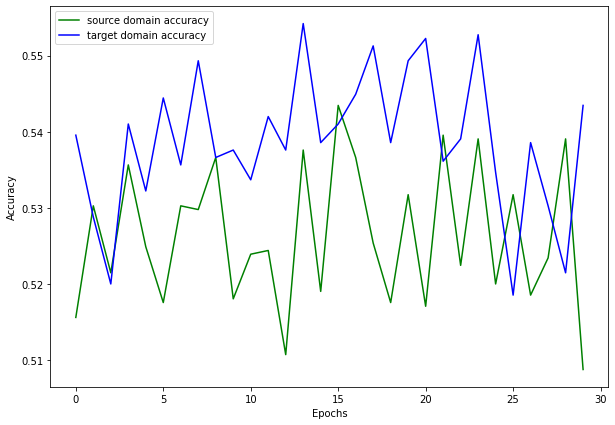

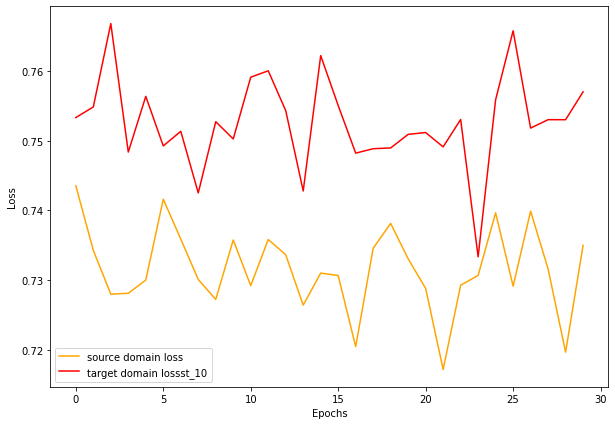

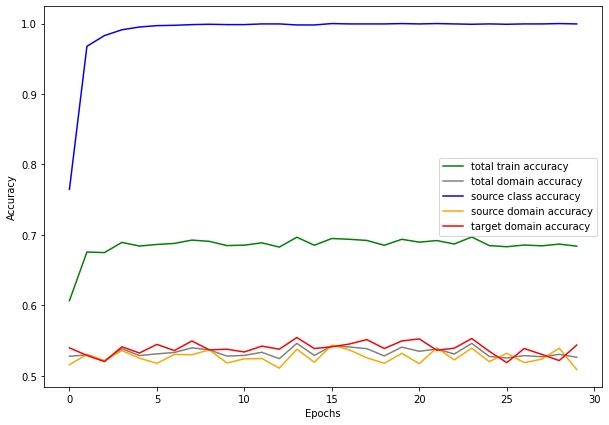

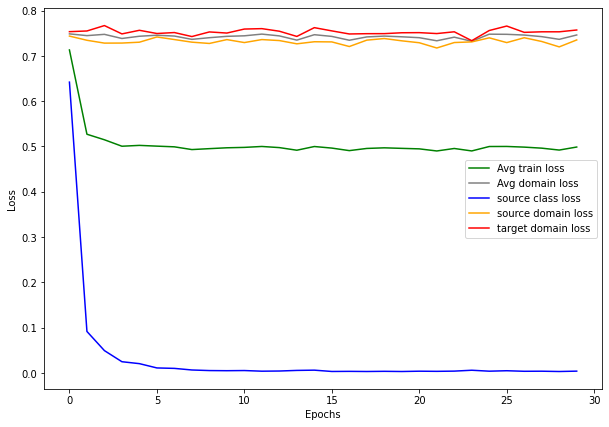

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Test Accuracy: 0.49072265625
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.5599, Train class Acc: 0.79
Target class Loss: 0.1185, Val class Acc: 0.47
Source domain Loss: 0.7608, Source domain Acc: 0.54
Target domain Loss: 0.6448, Target domain Acc: 0.61
Total train Loss: 0.6552, Total train Acc: 0.65
Total domain Loss: 0.7028, Total domain Acc: 0.58


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0911, Train class Acc: 0.97
Target class Loss: 0.0457, Val class Acc: 0.46
Source domain Loss: 0.7603, Source domain Acc: 0.53
Target domain Loss: 0.6352, Target domain Acc: 0.63
Total train Loss: 0.4955, Total train Acc: 0.71
Total domain Loss: 0.6978, Total domain Acc: 0.58


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0511, Train class Acc: 0.98
Target class Loss: 0.0236, Val class Acc: 0.47
Source domain Loss: 0.7700, Source domain Acc: 0.53
Target domain Loss: 0.6435, Target domain Acc: 0.64
Total train Loss: 0.4882, Total train Acc: 0.72
Total domain Loss: 0.7067, Total domain Acc: 0.58


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0281, Train class Acc: 0.99
Target class Loss: 0.0174, Val class Acc: 0.48
Source domain Loss: 0.7782, Source domain Acc: 0.52
Target domain Loss: 0.6373, Target domain Acc: 0.64
Total train Loss: 0.4812, Total train Acc: 0.72
Total domain Loss: 0.7078, Total domain Acc: 0.58


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0216, Train class Acc: 0.99
Target class Loss: 0.0353, Val class Acc: 0.49
Source domain Loss: 0.7610, Source domain Acc: 0.55
Target domain Loss: 0.6381, Target domain Acc: 0.63
Total train Loss: 0.4736, Total train Acc: 0.72
Total domain Loss: 0.6996, Total domain Acc: 0.59


Starting epoch 6/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0134, Train class Acc: 1.00
Target class Loss: 0.0042, Val class Acc: 0.47
Source domain Loss: 0.7606, Source domain Acc: 0.54
Target domain Loss: 0.6416, Target domain Acc: 0.62
Total train Loss: 0.4719, Total train Acc: 0.72
Total domain Loss: 0.7011, Total domain Acc: 0.58


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0092, Train class Acc: 1.00
Target class Loss: 0.0170, Val class Acc: 0.48
Source domain Loss: 0.7642, Source domain Acc: 0.54
Target domain Loss: 0.6359, Target domain Acc: 0.62
Total train Loss: 0.4698, Total train Acc: 0.72
Total domain Loss: 0.7001, Total domain Acc: 0.58


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0086, Train class Acc: 1.00
Target class Loss: 0.0027, Val class Acc: 0.48
Source domain Loss: 0.7623, Source domain Acc: 0.55
Target domain Loss: 0.6349, Target domain Acc: 0.62
Total train Loss: 0.4686, Total train Acc: 0.72
Total domain Loss: 0.6986, Total domain Acc: 0.58


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0045, Train class Acc: 1.00
Target class Loss: 0.0021, Val class Acc: 0.47
Source domain Loss: 0.7642, Source domain Acc: 0.54
Target domain Loss: 0.6409, Target domain Acc: 0.64
Total train Loss: 0.4699, Total train Acc: 0.72
Total domain Loss: 0.7025, Total domain Acc: 0.59


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0068, Train class Acc: 1.00
Target class Loss: 0.0042, Val class Acc: 0.48
Source domain Loss: 0.7679, Source domain Acc: 0.54
Target domain Loss: 0.6390, Target domain Acc: 0.62
Total train Loss: 0.4712, Total train Acc: 0.72
Total domain Loss: 0.7034, Total domain Acc: 0.58


Starting epoch 11/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.48
Source domain Loss: 0.7494, Source domain Acc: 0.54
Target domain Loss: 0.6389, Target domain Acc: 0.62
Total train Loss: 0.4641, Total train Acc: 0.72
Total domain Loss: 0.6942, Total domain Acc: 0.58


Starting epoch 12/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0036, Val class Acc: 0.48
Source domain Loss: 0.7728, Source domain Acc: 0.53
Target domain Loss: 0.6412, Target domain Acc: 0.63
Total train Loss: 0.4725, Total train Acc: 0.72
Total domain Loss: 0.7070, Total domain Acc: 0.58


Starting epoch 13/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.47
Source domain Loss: 0.7717, Source domain Acc: 0.54
Target domain Loss: 0.6420, Target domain Acc: 0.62
Total train Loss: 0.4721, Total train Acc: 0.72
Total domain Loss: 0.7069, Total domain Acc: 0.58


Starting epoch 14/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0039, Val class Acc: 0.46
Source domain Loss: 0.7654, Source domain Acc: 0.53
Target domain Loss: 0.6434, Target domain Acc: 0.62
Total train Loss: 0.4714, Total train Acc: 0.72
Total domain Loss: 0.7044, Total domain Acc: 0.58


Starting epoch 15/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.47
Source domain Loss: 0.7592, Source domain Acc: 0.54
Target domain Loss: 0.6374, Target domain Acc: 0.63
Total train Loss: 0.4667, Total train Acc: 0.72
Total domain Loss: 0.6983, Total domain Acc: 0.58


Starting epoch 16/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0012, Val class Acc: 0.47
Source domain Loss: 0.7560, Source domain Acc: 0.54
Target domain Loss: 0.6452, Target domain Acc: 0.62
Total train Loss: 0.4678, Total train Acc: 0.72
Total domain Loss: 0.7006, Total domain Acc: 0.58


Starting epoch 17/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0021, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.47
Source domain Loss: 0.7486, Source domain Acc: 0.55
Target domain Loss: 0.6440, Target domain Acc: 0.62
Total train Loss: 0.4649, Total train Acc: 0.73
Total domain Loss: 0.6963, Total domain Acc: 0.59


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0022, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.47
Source domain Loss: 0.7622, Source domain Acc: 0.54
Target domain Loss: 0.6349, Target domain Acc: 0.62
Total train Loss: 0.4664, Total train Acc: 0.72
Total domain Loss: 0.6985, Total domain Acc: 0.58


Starting epoch 19/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0022, Train class Acc: 1.00
Target class Loss: 0.0011, Val class Acc: 0.47
Source domain Loss: 0.7482, Source domain Acc: 0.54
Target domain Loss: 0.6358, Target domain Acc: 0.63
Total train Loss: 0.4621, Total train Acc: 0.72
Total domain Loss: 0.6920, Total domain Acc: 0.58


Starting epoch 20/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.47
Source domain Loss: 0.7618, Source domain Acc: 0.55
Target domain Loss: 0.6340, Target domain Acc: 0.62
Total train Loss: 0.4660, Total train Acc: 0.72
Total domain Loss: 0.6979, Total domain Acc: 0.59


Starting epoch 21/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0020, Train class Acc: 1.00
Target class Loss: 0.0029, Val class Acc: 0.47
Source domain Loss: 0.7568, Source domain Acc: 0.54
Target domain Loss: 0.6280, Target domain Acc: 0.63
Total train Loss: 0.4623, Total train Acc: 0.73
Total domain Loss: 0.6924, Total domain Acc: 0.59


Starting epoch 22/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0013, Val class Acc: 0.47
Source domain Loss: 0.7582, Source domain Acc: 0.54
Target domain Loss: 0.6435, Target domain Acc: 0.62
Total train Loss: 0.4681, Total train Acc: 0.72
Total domain Loss: 0.7009, Total domain Acc: 0.58


Starting epoch 23/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0028, Train class Acc: 1.00
Target class Loss: 0.0009, Val class Acc: 0.47
Source domain Loss: 0.7477, Source domain Acc: 0.55
Target domain Loss: 0.6268, Target domain Acc: 0.63
Total train Loss: 0.4591, Total train Acc: 0.73
Total domain Loss: 0.6873, Total domain Acc: 0.59


Starting epoch 24/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.47
Source domain Loss: 0.7569, Source domain Acc: 0.54
Target domain Loss: 0.6374, Target domain Acc: 0.62
Total train Loss: 0.4655, Total train Acc: 0.72
Total domain Loss: 0.6972, Total domain Acc: 0.58


Starting epoch 25/30, LR = [0.001]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.47
Source domain Loss: 0.7594, Source domain Acc: 0.54
Target domain Loss: 0.6331, Target domain Acc: 0.63
Total train Loss: 0.4652, Total train Acc: 0.72
Total domain Loss: 0.6962, Total domain Acc: 0.58


Starting epoch 26/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0018, Train class Acc: 1.00
Target class Loss: 0.0028, Val class Acc: 0.47
Source domain Loss: 0.7750, Source domain Acc: 0.53
Target domain Loss: 0.6347, Target domain Acc: 0.62
Total train Loss: 0.4705, Total train Acc: 0.72
Total domain Loss: 0.7048, Total domain Acc: 0.58


Starting epoch 27/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0018, Train class Acc: 1.00
Target class Loss: 0.0017, Val class Acc: 0.47
Source domain Loss: 0.7573, Source domain Acc: 0.54
Target domain Loss: 0.6391, Target domain Acc: 0.62
Total train Loss: 0.4661, Total train Acc: 0.72
Total domain Loss: 0.6982, Total domain Acc: 0.58


Starting epoch 28/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0029, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.47
Source domain Loss: 0.7627, Source domain Acc: 0.54
Target domain Loss: 0.6446, Target domain Acc: 0.61
Total train Loss: 0.4701, Total train Acc: 0.72
Total domain Loss: 0.7036, Total domain Acc: 0.58


Starting epoch 29/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0022, Train class Acc: 1.00
Target class Loss: 0.0009, Val class Acc: 0.47
Source domain Loss: 0.7632, Source domain Acc: 0.53
Target domain Loss: 0.6365, Target domain Acc: 0.63
Total train Loss: 0.4673, Total train Acc: 0.72
Total domain Loss: 0.6999, Total domain Acc: 0.58


Starting epoch 30/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0020, Val class Acc: 0.47
Source domain Loss: 0.7558, Source domain Acc: 0.54
Target domain Loss: 0.6350, Target domain Acc: 0.63
Total train Loss: 0.4647, Total train Acc: 0.72
Total domain Loss: 0.6954, Total domain Acc: 0.58


[(0.5599144920706749, 0.79443359375), (0.09111952548846602, 0.96923828125), (0.05113043636083603, 0.98291015625), (0.02809163392521441, 0.990234375), (0.021600460167974234, 0.9921875), (0.013424384989775717, 0.99560546875), (0.009209195850417018, 0.998046875), (0.008640187326818705, 0.9970703125), (0.0044981001410633326, 0.99951171875), (0.006838313303887844, 0.99853515625), (0.003895245026797056, 0.9990234375), (0.0035595495719462633, 0.99951171875), (0.0024996395222842693, 1.0), (0.0053870826959609985, 0.99951171875), (0.0035860962234437466, 0.99951171875), (0.0022848749067634344, 0.99951171875), (0.0020792828872799873, 1.0), (0.0022211309988051653, 1.0), (0.0021771269384771585, 1.0), (0.

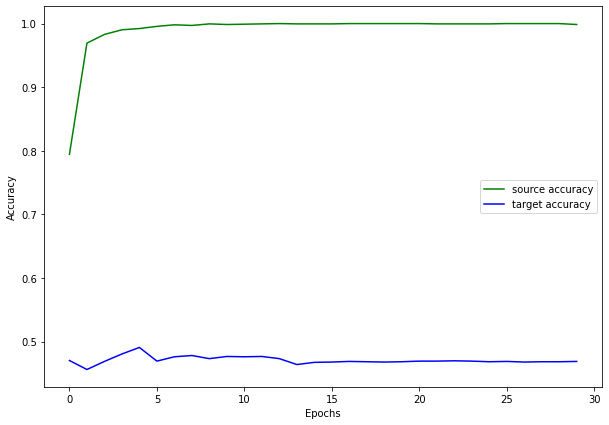

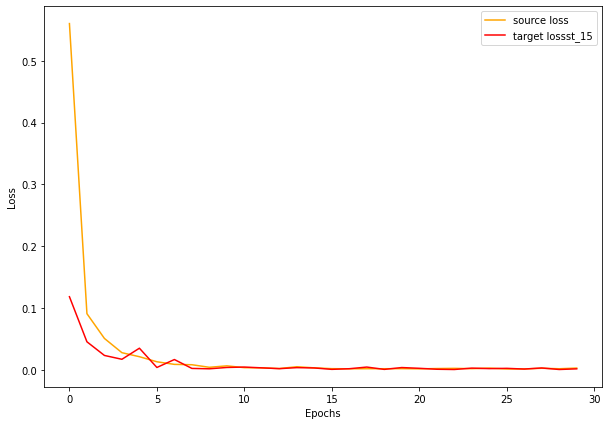

[(0.760837584733963, 0.53662109375), (0.7603210881352425, 0.52685546875), (0.770028755068779, 0.5322265625), (0.7782019898295403, 0.5205078125), (0.760964035987854, 0.548828125), (0.7605642750859261, 0.54296875), (0.7641783207654953, 0.53955078125), (0.762306921184063, 0.54931640625), (0.7641609907150269, 0.537109375), (0.7678906992077827, 0.5361328125), (0.7494075372815132, 0.53955078125), (0.772822692990303, 0.5322265625), (0.7717492803931236, 0.53759765625), (0.7654213756322861, 0.53369140625), (0.7591898962855339, 0.5419921875), (0.7559856846928596, 0.53759765625), (0.7486308887600899, 0.5537109375), (0.7621537446975708, 0.5390625), (0.7482262775301933, 0.5380859375), (0.7617601677775383, 0.5478515625), (0.7568071112036705, 0.54443359375), (0.7582422494888306, 0.54443359375), (0.7477056831121445, 0.55126953125), (0.7568640783429146, 0.54248046875), (0.7593571990728378, 0.5390625), (0.7749693617224693, 0.53369140625), (0.7572782263159752, 0.5439453125), (0.7626808434724808, 0.544921

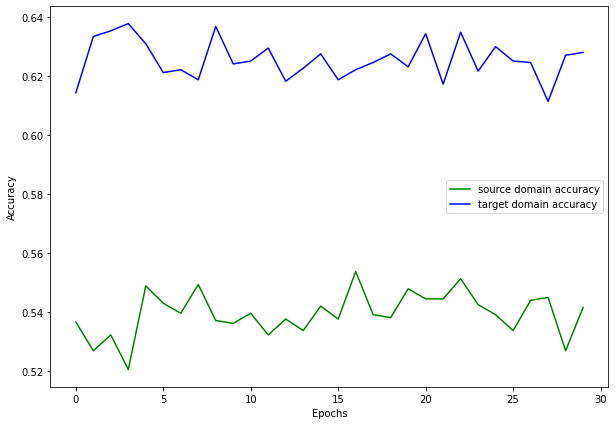

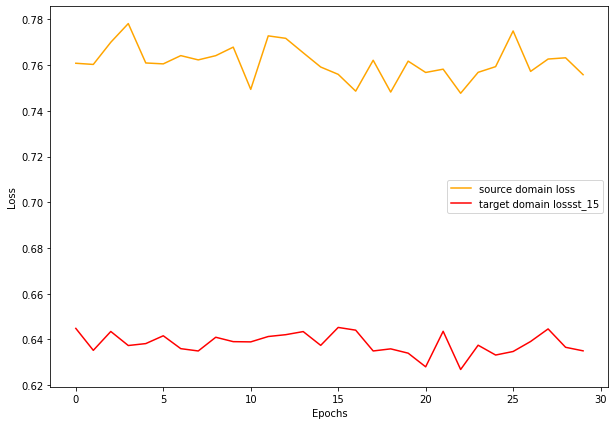

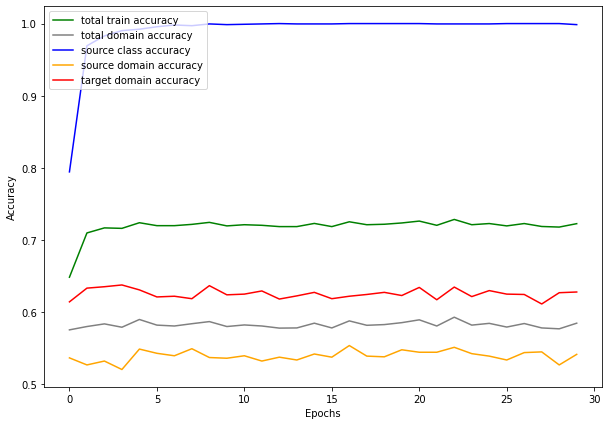

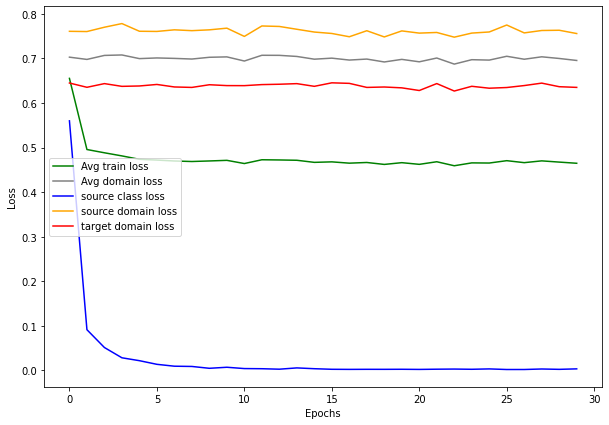

100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Test Accuracy: 0.4697265625
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-

100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.6139, Train class Acc: 0.77
Target class Loss: 0.1584, Val class Acc: 0.46
Source domain Loss: 0.9139, Source domain Acc: 0.39
Target domain Loss: 0.4671, Target domain Acc: 0.81
Total train Loss: 0.6650, Total train Acc: 0.65
Total domain Loss: 0.6905, Total domain Acc: 0.60


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0874, Train class Acc: 0.97
Target class Loss: 0.0729, Val class Acc: 0.46
Source domain Loss: 0.9016, Source domain Acc: 0.39
Target domain Loss: 0.4675, Target domain Acc: 0.81
Total train Loss: 0.4855, Total train Acc: 0.72
Total domain Loss: 0.6845, Total domain Acc: 0.60


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0537, Train class Acc: 0.98
Target class Loss: 0.0421, Val class Acc: 0.47
Source domain Loss: 0.8989, Source domain Acc: 0.39
Target domain Loss: 0.4738, Target domain Acc: 0.80
Total train Loss: 0.4755, Total train Acc: 0.72
Total domain Loss: 0.6863, Total domain Acc: 0.59


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0329, Train class Acc: 0.99
Target class Loss: 0.0200, Val class Acc: 0.48
Source domain Loss: 0.8867, Source domain Acc: 0.40
Target domain Loss: 0.4711, Target domain Acc: 0.81
Total train Loss: 0.4636, Total train Acc: 0.73
Total domain Loss: 0.6789, Total domain Acc: 0.60


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0131, Train class Acc: 1.00
Target class Loss: 0.0063, Val class Acc: 0.48
Source domain Loss: 0.9067, Source domain Acc: 0.39
Target domain Loss: 0.4717, Target domain Acc: 0.80
Total train Loss: 0.4639, Total train Acc: 0.73
Total domain Loss: 0.6892, Total domain Acc: 0.59


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0106, Train class Acc: 1.00
Target class Loss: 0.0152, Val class Acc: 0.49
Source domain Loss: 0.8951, Source domain Acc: 0.39
Target domain Loss: 0.4744, Target domain Acc: 0.81
Total train Loss: 0.4600, Total train Acc: 0.73
Total domain Loss: 0.6848, Total domain Acc: 0.60


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0086, Train class Acc: 1.00
Target class Loss: 0.0122, Val class Acc: 0.49
Source domain Loss: 0.9003, Source domain Acc: 0.38
Target domain Loss: 0.4740, Target domain Acc: 0.80
Total train Loss: 0.4610, Total train Acc: 0.72
Total domain Loss: 0.6872, Total domain Acc: 0.59


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0075, Train class Acc: 1.00
Target class Loss: 0.0075, Val class Acc: 0.49
Source domain Loss: 0.9002, Source domain Acc: 0.39
Target domain Loss: 0.4661, Target domain Acc: 0.80
Total train Loss: 0.4579, Total train Acc: 0.73
Total domain Loss: 0.6831, Total domain Acc: 0.60


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0079, Train class Acc: 1.00
Target class Loss: 0.0051, Val class Acc: 0.50
Source domain Loss: 0.9016, Source domain Acc: 0.39
Target domain Loss: 0.4694, Target domain Acc: 0.80
Total train Loss: 0.4597, Total train Acc: 0.73
Total domain Loss: 0.6855, Total domain Acc: 0.59


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0052, Train class Acc: 1.00
Target class Loss: 0.0047, Val class Acc: 0.49
Source domain Loss: 0.9017, Source domain Acc: 0.37
Target domain Loss: 0.4641, Target domain Acc: 0.80
Total train Loss: 0.4570, Total train Acc: 0.73
Total domain Loss: 0.6829, Total domain Acc: 0.59


Starting epoch 11/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.8886, Source domain Acc: 0.40
Target domain Loss: 0.4725, Target domain Acc: 0.81
Total train Loss: 0.4548, Total train Acc: 0.74
Total domain Loss: 0.6806, Total domain Acc: 0.60


Starting epoch 12/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Source class Loss: 0.0027, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.49
Source domain Loss: 0.8909, Source domain Acc: 0.40
Target domain Loss: 0.4714, Target domain Acc: 0.81
Total train Loss: 0.4550, Total train Acc: 0.74
Total domain Loss: 0.6812, Total domain Acc: 0.60


Starting epoch 13/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0045, Train class Acc: 1.00
Target class Loss: 0.0056, Val class Acc: 0.49
Source domain Loss: 0.9092, Source domain Acc: 0.38
Target domain Loss: 0.4736, Target domain Acc: 0.79
Total train Loss: 0.4624, Total train Acc: 0.72
Total domain Loss: 0.6914, Total domain Acc: 0.58


Starting epoch 14/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.8963, Source domain Acc: 0.38
Target domain Loss: 0.4740, Target domain Acc: 0.80
Total train Loss: 0.4583, Total train Acc: 0.73
Total domain Loss: 0.6851, Total domain Acc: 0.59


Starting epoch 15/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0053, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.49
Source domain Loss: 0.9029, Source domain Acc: 0.39
Target domain Loss: 0.4703, Target domain Acc: 0.81
Total train Loss: 0.4595, Total train Acc: 0.73
Total domain Loss: 0.6866, Total domain Acc: 0.60


Starting epoch 16/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.49
Source domain Loss: 0.9029, Source domain Acc: 0.38
Target domain Loss: 0.4785, Target domain Acc: 0.80
Total train Loss: 0.4618, Total train Acc: 0.73
Total domain Loss: 0.6907, Total domain Acc: 0.59


Starting epoch 17/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0033, Val class Acc: 0.50
Source domain Loss: 0.8950, Source domain Acc: 0.39
Target domain Loss: 0.4642, Target domain Acc: 0.81
Total train Loss: 0.4541, Total train Acc: 0.73
Total domain Loss: 0.6796, Total domain Acc: 0.60


Starting epoch 18/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0152, Val class Acc: 0.50
Source domain Loss: 0.9115, Source domain Acc: 0.37
Target domain Loss: 0.4748, Target domain Acc: 0.80
Total train Loss: 0.4638, Total train Acc: 0.72
Total domain Loss: 0.6931, Total domain Acc: 0.58


Starting epoch 19/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Source class Loss: 0.0049, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.50
Source domain Loss: 0.9045, Source domain Acc: 0.38
Target domain Loss: 0.4671, Target domain Acc: 0.80
Total train Loss: 0.4588, Total train Acc: 0.73
Total domain Loss: 0.6858, Total domain Acc: 0.59


Starting epoch 20/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0050, Val class Acc: 0.50
Source domain Loss: 0.9019, Source domain Acc: 0.39
Target domain Loss: 0.4656, Target domain Acc: 0.81
Total train Loss: 0.4574, Total train Acc: 0.73
Total domain Loss: 0.6838, Total domain Acc: 0.60


Starting epoch 21/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]



Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0053, Val class Acc: 0.50
Source domain Loss: 0.8955, Source domain Acc: 0.39
Target domain Loss: 0.4774, Target domain Acc: 0.80
Total train Loss: 0.4588, Total train Acc: 0.73
Total domain Loss: 0.6865, Total domain Acc: 0.59


Starting epoch 22/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]



Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0013, Val class Acc: 0.50
Source domain Loss: 0.8894, Source domain Acc: 0.40
Target domain Loss: 0.4701, Target domain Acc: 0.82
Total train Loss: 0.4546, Total train Acc: 0.74
Total domain Loss: 0.6797, Total domain Acc: 0.61


Starting epoch 23/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0027, Val class Acc: 0.50
Source domain Loss: 0.9068, Source domain Acc: 0.38
Target domain Loss: 0.4747, Target domain Acc: 0.80
Total train Loss: 0.4615, Total train Acc: 0.73
Total domain Loss: 0.6907, Total domain Acc: 0.59


Starting epoch 24/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0042, Val class Acc: 0.50
Source domain Loss: 0.9066, Source domain Acc: 0.39
Target domain Loss: 0.4757, Target domain Acc: 0.81
Total train Loss: 0.4622, Total train Acc: 0.73
Total domain Loss: 0.6912, Total domain Acc: 0.60


Starting epoch 25/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0037, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.50
Source domain Loss: 0.8979, Source domain Acc: 0.37
Target domain Loss: 0.4623, Target domain Acc: 0.82
Total train Loss: 0.4546, Total train Acc: 0.73
Total domain Loss: 0.6801, Total domain Acc: 0.60


Starting epoch 26/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0092, Val class Acc: 0.50
Source domain Loss: 0.8940, Source domain Acc: 0.38
Target domain Loss: 0.4662, Target domain Acc: 0.81
Total train Loss: 0.4549, Total train Acc: 0.73
Total domain Loss: 0.6801, Total domain Acc: 0.60


Starting epoch 27/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0036, Val class Acc: 0.50
Source domain Loss: 0.8964, Source domain Acc: 0.40
Target domain Loss: 0.4726, Target domain Acc: 0.81
Total train Loss: 0.4578, Total train Acc: 0.74
Total domain Loss: 0.6845, Total domain Acc: 0.61


Starting epoch 28/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.50
Source domain Loss: 0.8912, Source domain Acc: 0.40
Target domain Loss: 0.4699, Target domain Acc: 0.80
Total train Loss: 0.4548, Total train Acc: 0.73
Total domain Loss: 0.6806, Total domain Acc: 0.60


Starting epoch 29/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0014, Val class Acc: 0.50
Source domain Loss: 0.8915, Source domain Acc: 0.39
Target domain Loss: 0.4749, Target domain Acc: 0.80
Total train Loss: 0.4569, Total train Acc: 0.73
Total domain Loss: 0.6832, Total domain Acc: 0.60


Starting epoch 30/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0066, Train class Acc: 1.00
Target class Loss: 0.0111, Val class Acc: 0.50
Source domain Loss: 0.9007, Source domain Acc: 0.38
Target domain Loss: 0.4729, Target domain Acc: 0.80
Total train Loss: 0.4601, Total train Acc: 0.72
Total domain Loss: 0.6868, Total domain Acc: 0.59


[(0.6138758882880211, 0.76708984375), (0.08740984555333853, 0.97265625), (0.053710156586021185, 0.98388671875), (0.03292732569389045, 0.98779296875), (0.01309065124951303, 0.99658203125), (0.01059119333513081, 0.99755859375), (0.00864540203474462, 0.99755859375), (0.00747872528154403, 0.9990234375), (0.007888945750892162, 0.998046875), (0.005180817097425461, 0.9990234375), (0.0032322185579687357, 1.0), (0.0027084716130048037, 1.0), (0.00445152772590518, 0.99951171875), (0.004655060824006796, 0.99853515625), (0.005316732916980982, 0.99951171875), (0.004139930475503206, 0.99951171875), (0.003125968389213085, 1.0), (0.005117944208905101, 0.9990234375), (0.0048770366702228785, 0.9990234375), (0

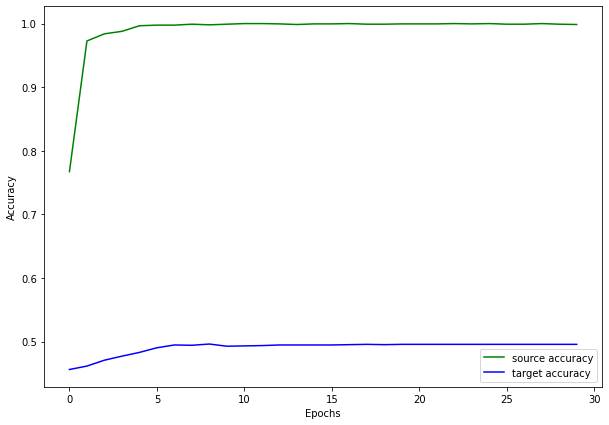

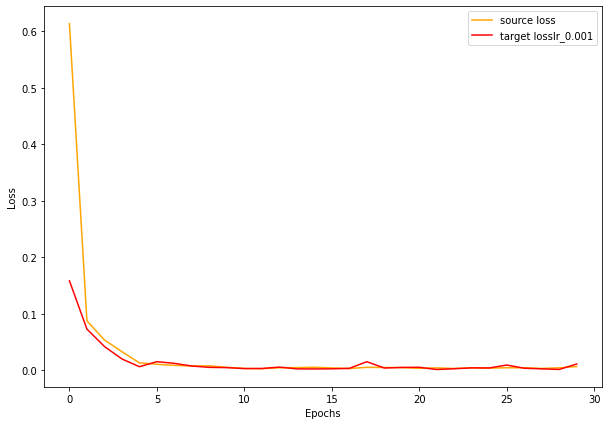

[(0.9138913229107857, 0.38525390625), (0.9015969261527061, 0.38671875), (0.8988695219159126, 0.38818359375), (0.886677697300911, 0.3994140625), (0.9067332148551941, 0.38525390625), (0.8951009660959244, 0.38623046875), (0.9002711847424507, 0.37890625), (0.900176890194416, 0.38916015625), (0.901629239320755, 0.3896484375), (0.9017112627625465, 0.3720703125), (0.8886391669511795, 0.39990234375), (0.8908994048833847, 0.3994140625), (0.9091934785246849, 0.38232421875), (0.896286852657795, 0.3798828125), (0.9028857722878456, 0.38623046875), (0.9029367938637733, 0.3818359375), (0.8949589058756828, 0.39013671875), (0.9115007594227791, 0.36865234375), (0.9044501036405563, 0.37744140625), (0.9019162803888321, 0.38525390625), (0.8954963386058807, 0.39306640625), (0.8893868774175644, 0.3984375), (0.9068163484334946, 0.3779296875), (0.906602755188942, 0.38720703125), (0.8979273438453674, 0.373046875), (0.8939912095665932, 0.376953125), (0.8963826149702072, 0.40185546875), (0.8912264034152031, 0.398

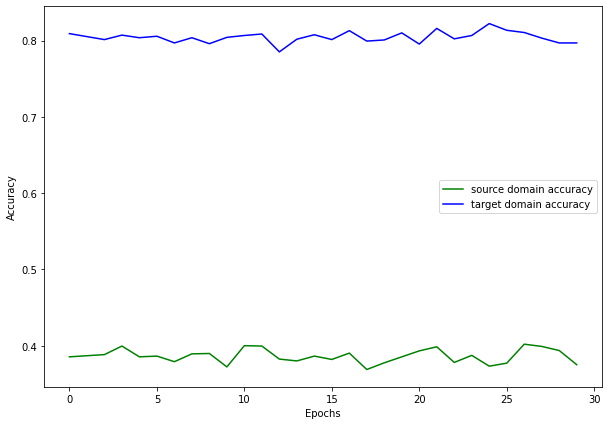

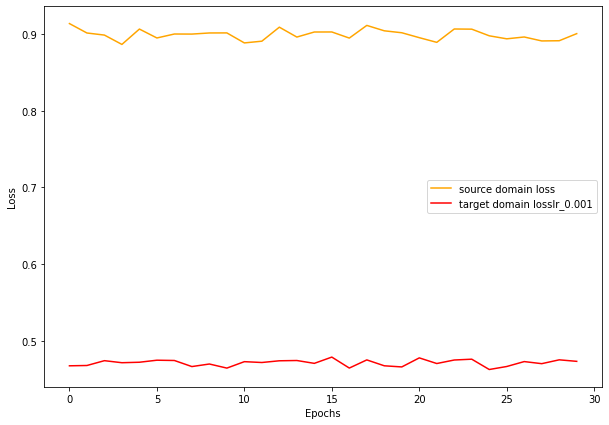

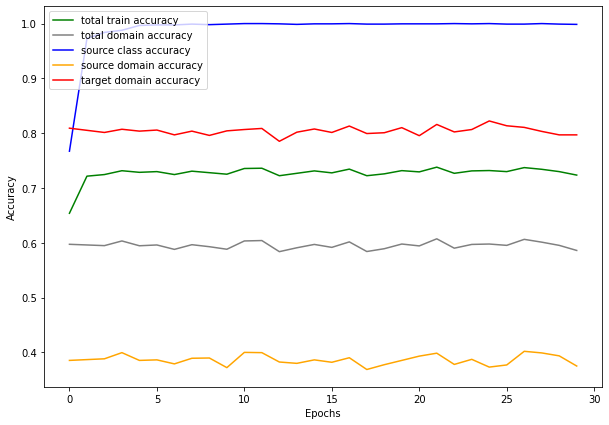

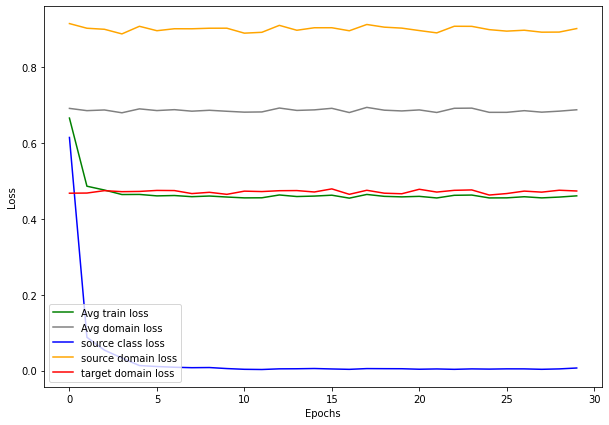

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Test Accuracy: 0.49560546875
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.5436, Train class Acc: 0.80
Target class Loss: 0.0726, Val class Acc: 0.46
Source domain Loss: 0.9219, Source domain Acc: 0.38
Target domain Loss: 0.8075, Target domain Acc: 0.49
Total train Loss: 0.7577, Total train Acc: 0.56
Total domain Loss: 0.8647, Total domain Acc: 0.44


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.1104, Train class Acc: 0.97
Target class Loss: 0.0539, Val class Acc: 0.46
Source domain Loss: 0.9106, Source domain Acc: 0.39
Target domain Loss: 0.8043, Target domain Acc: 0.48
Total train Loss: 0.6084, Total train Acc: 0.61
Total domain Loss: 0.8574, Total domain Acc: 0.44


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]



Source class Loss: 0.0520, Train class Acc: 0.98
Target class Loss: 0.0280, Val class Acc: 0.47
Source domain Loss: 0.9123, Source domain Acc: 0.40
Target domain Loss: 0.8154, Target domain Acc: 0.48
Total train Loss: 0.5932, Total train Acc: 0.62
Total domain Loss: 0.8639, Total domain Acc: 0.44


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Source class Loss: 0.0373, Train class Acc: 0.99
Target class Loss: 0.0531, Val class Acc: 0.46
Source domain Loss: 0.9125, Source domain Acc: 0.40
Target domain Loss: 0.8128, Target domain Acc: 0.49
Total train Loss: 0.5876, Total train Acc: 0.62
Total domain Loss: 0.8627, Total domain Acc: 0.44


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0223, Train class Acc: 0.99
Target class Loss: 0.0044, Val class Acc: 0.47
Source domain Loss: 0.9052, Source domain Acc: 0.39
Target domain Loss: 0.8183, Target domain Acc: 0.48
Total train Loss: 0.5819, Total train Acc: 0.62
Total domain Loss: 0.8618, Total domain Acc: 0.44


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0112, Train class Acc: 1.00
Target class Loss: 0.0055, Val class Acc: 0.47
Source domain Loss: 0.9157, Source domain Acc: 0.40
Target domain Loss: 0.8077, Target domain Acc: 0.49
Total train Loss: 0.5782, Total train Acc: 0.63
Total domain Loss: 0.8617, Total domain Acc: 0.44


Starting epoch 7/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0070, Train class Acc: 1.00
Target class Loss: 0.0028, Val class Acc: 0.47
Source domain Loss: 0.9337, Source domain Acc: 0.38
Target domain Loss: 0.8174, Target domain Acc: 0.50
Total train Loss: 0.5860, Total train Acc: 0.62
Total domain Loss: 0.8755, Total domain Acc: 0.44


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0062, Train class Acc: 1.00
Target class Loss: 0.0057, Val class Acc: 0.48
Source domain Loss: 0.9094, Source domain Acc: 0.40
Target domain Loss: 0.8100, Target domain Acc: 0.48
Total train Loss: 0.5752, Total train Acc: 0.63
Total domain Loss: 0.8597, Total domain Acc: 0.44


Starting epoch 9/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0069, Train class Acc: 1.00
Target class Loss: 0.0027, Val class Acc: 0.49
Source domain Loss: 0.9239, Source domain Acc: 0.39
Target domain Loss: 0.8081, Target domain Acc: 0.50
Total train Loss: 0.5796, Total train Acc: 0.63
Total domain Loss: 0.8660, Total domain Acc: 0.44


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0012, Val class Acc: 0.48
Source domain Loss: 0.9229, Source domain Acc: 0.38
Target domain Loss: 0.8179, Target domain Acc: 0.48
Total train Loss: 0.5819, Total train Acc: 0.62
Total domain Loss: 0.8704, Total domain Acc: 0.43


Starting epoch 11/30, LR = [0.003]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0039, Val class Acc: 0.48
Source domain Loss: 0.9085, Source domain Acc: 0.39
Target domain Loss: 0.8152, Target domain Acc: 0.47
Total train Loss: 0.5760, Total train Acc: 0.62
Total domain Loss: 0.8619, Total domain Acc: 0.43


Starting epoch 12/30, LR = [0.003]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0040, Train class Acc: 1.00
Target class Loss: 0.0010, Val class Acc: 0.48
Source domain Loss: 0.9206, Source domain Acc: 0.39
Target domain Loss: 0.8075, Target domain Acc: 0.48
Total train Loss: 0.5774, Total train Acc: 0.62
Total domain Loss: 0.8640, Total domain Acc: 0.44


Starting epoch 13/30, LR = [0.003]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0021, Val class Acc: 0.48
Source domain Loss: 0.9117, Source domain Acc: 0.38
Target domain Loss: 0.8121, Target domain Acc: 0.49
Total train Loss: 0.5756, Total train Acc: 0.62
Total domain Loss: 0.8619, Total domain Acc: 0.44


Starting epoch 14/30, LR = [0.003]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0040, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.48
Source domain Loss: 0.9175, Source domain Acc: 0.39
Target domain Loss: 0.8066, Target domain Acc: 0.48
Total train Loss: 0.5760, Total train Acc: 0.62
Total domain Loss: 0.8620, Total domain Acc: 0.43


Starting epoch 15/30, LR = [0.003]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.48
Source domain Loss: 0.9123, Source domain Acc: 0.39
Target domain Loss: 0.8094, Target domain Acc: 0.49
Total train Loss: 0.5752, Total train Acc: 0.62
Total domain Loss: 0.8609, Total domain Acc: 0.44


Starting epoch 16/30, LR = [0.003]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0053, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.48
Source domain Loss: 0.9267, Source domain Acc: 0.39
Target domain Loss: 0.8158, Target domain Acc: 0.49
Total train Loss: 0.5826, Total train Acc: 0.62
Total domain Loss: 0.8712, Total domain Acc: 0.44


Starting epoch 17/30, LR = [0.003]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0037, Val class Acc: 0.48
Source domain Loss: 0.9226, Source domain Acc: 0.38
Target domain Loss: 0.8071, Target domain Acc: 0.48
Total train Loss: 0.5778, Total train Acc: 0.62
Total domain Loss: 0.8649, Total domain Acc: 0.43


Starting epoch 18/30, LR = [0.003]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0026, Train class Acc: 1.00
Target class Loss: 0.0017, Val class Acc: 0.48
Source domain Loss: 0.9184, Source domain Acc: 0.38
Target domain Loss: 0.8165, Target domain Acc: 0.49
Total train Loss: 0.5792, Total train Acc: 0.62
Total domain Loss: 0.8675, Total domain Acc: 0.44


Starting epoch 19/30, LR = [0.003]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0036, Val class Acc: 0.48
Source domain Loss: 0.9071, Source domain Acc: 0.38
Target domain Loss: 0.8054, Target domain Acc: 0.49
Total train Loss: 0.5722, Total train Acc: 0.62
Total domain Loss: 0.8563, Total domain Acc: 0.43


Starting epoch 20/30, LR = [0.003]


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0035, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.49
Source domain Loss: 0.9265, Source domain Acc: 0.38
Target domain Loss: 0.8028, Target domain Acc: 0.49
Total train Loss: 0.5776, Total train Acc: 0.62
Total domain Loss: 0.8646, Total domain Acc: 0.43


Starting epoch 21/30, LR = [0.0009]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0011, Val class Acc: 0.49
Source domain Loss: 0.9104, Source domain Acc: 0.41
Target domain Loss: 0.8066, Target domain Acc: 0.49
Total train Loss: 0.5734, Total train Acc: 0.63
Total domain Loss: 0.8585, Total domain Acc: 0.45


Starting epoch 22/30, LR = [0.0009]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.49
Source domain Loss: 0.9205, Source domain Acc: 0.38
Target domain Loss: 0.8119, Target domain Acc: 0.48
Total train Loss: 0.5785, Total train Acc: 0.62
Total domain Loss: 0.8662, Total domain Acc: 0.43


Starting epoch 23/30, LR = [0.0009]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.49
Source domain Loss: 0.9109, Source domain Acc: 0.39
Target domain Loss: 0.8158, Target domain Acc: 0.48
Total train Loss: 0.5766, Total train Acc: 0.63
Total domain Loss: 0.8634, Total domain Acc: 0.44


Starting epoch 24/30, LR = [0.0009]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0153, Val class Acc: 0.49
Source domain Loss: 0.9083, Source domain Acc: 0.39
Target domain Loss: 0.8100, Target domain Acc: 0.49
Total train Loss: 0.5744, Total train Acc: 0.63
Total domain Loss: 0.8592, Total domain Acc: 0.44


Starting epoch 25/30, LR = [0.0009]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0083, Val class Acc: 0.49
Source domain Loss: 0.9010, Source domain Acc: 0.40
Target domain Loss: 0.8120, Target domain Acc: 0.48
Total train Loss: 0.5720, Total train Acc: 0.63
Total domain Loss: 0.8565, Total domain Acc: 0.44


Starting epoch 26/30, LR = [0.0009]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0021, Val class Acc: 0.49
Source domain Loss: 0.9196, Source domain Acc: 0.39
Target domain Loss: 0.8124, Target domain Acc: 0.48
Total train Loss: 0.5782, Total train Acc: 0.62
Total domain Loss: 0.8660, Total domain Acc: 0.44


Starting epoch 27/30, LR = [0.0009]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0011, Val class Acc: 0.48
Source domain Loss: 0.9228, Source domain Acc: 0.39
Target domain Loss: 0.8136, Target domain Acc: 0.48
Total train Loss: 0.5802, Total train Acc: 0.62
Total domain Loss: 0.8682, Total domain Acc: 0.44


Starting epoch 28/30, LR = [0.0009]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0062, Val class Acc: 0.48
Source domain Loss: 0.9080, Source domain Acc: 0.38
Target domain Loss: 0.8049, Target domain Acc: 0.49
Total train Loss: 0.5724, Total train Acc: 0.62
Total domain Loss: 0.8564, Total domain Acc: 0.44


Starting epoch 29/30, LR = [0.0009]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.49
Source domain Loss: 0.9141, Source domain Acc: 0.38
Target domain Loss: 0.8033, Target domain Acc: 0.49
Total train Loss: 0.5735, Total train Acc: 0.62
Total domain Loss: 0.8587, Total domain Acc: 0.43


Starting epoch 30/30, LR = [0.0009]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0021, Train class Acc: 1.00
Target class Loss: 0.0030, Val class Acc: 0.49
Source domain Loss: 0.9111, Source domain Acc: 0.40
Target domain Loss: 0.7922, Target domain Acc: 0.50
Total train Loss: 0.5685, Total train Acc: 0.63
Total domain Loss: 0.8517, Total domain Acc: 0.45


[(0.543593936599791, 0.80078125), (0.11044712737202644, 0.96826171875), (0.05201965756714344, 0.98291015625), (0.037318698363378644, 0.98681640625), (0.022291660076007247, 0.9912109375), (0.011205795221030712, 0.9970703125), (0.006983389379456639, 0.9990234375), (0.006210981402546167, 0.998046875), (0.006851857295259833, 0.9990234375), (0.004707087762653828, 0.99951171875), (0.00426612957380712, 0.99951171875), (0.004034560872241855, 0.99853515625), (0.0030191735131666064, 1.0), (0.003999259672127664, 1.0), (0.003933395026251674, 0.9990234375), (0.005323898047208786, 0.9990234375), (0.003581500379368663, 1.0), (0.0025819295551627874, 1.0), (0.004175902111455798, 0.9990234375), (0.0035116209

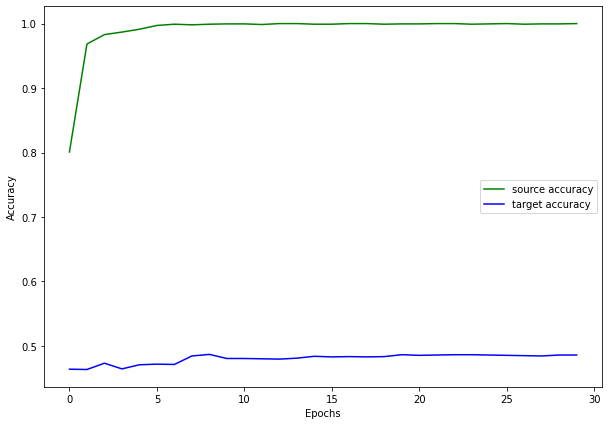

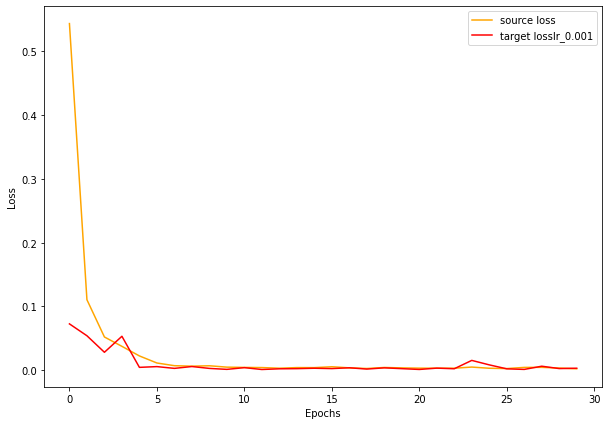

[(0.9218830242753029, 0.38232421875), (0.9105755239725113, 0.38916015625), (0.9122572690248489, 0.39794921875), (0.9125382676720619, 0.3974609375), (0.9052127972245216, 0.39208984375), (0.9157434180378914, 0.3994140625), (0.9336687549948692, 0.376953125), (0.9094017967581749, 0.396484375), (0.9238587245345116, 0.38818359375), (0.9229226931929588, 0.37939453125), (0.9084720462560654, 0.390625), (0.9205945879220963, 0.38916015625), (0.911655880510807, 0.380859375), (0.917529821395874, 0.3896484375), (0.9123328402638435, 0.38623046875), (0.9266805201768875, 0.3857421875), (0.9226382449269295, 0.3828125), (0.9184058457612991, 0.3818359375), (0.9071461334824562, 0.3779296875), (0.9264596626162529, 0.37890625), (0.9104347229003906, 0.40869140625), (0.9205219820141792, 0.3837890625), (0.9109432846307755, 0.39111328125), (0.9083259254693985, 0.39208984375), (0.9010225459933281, 0.40185546875), (0.919640988111496, 0.39013671875), (0.9228327721357346, 0.38916015625), (0.9080158248543739, 0.38134

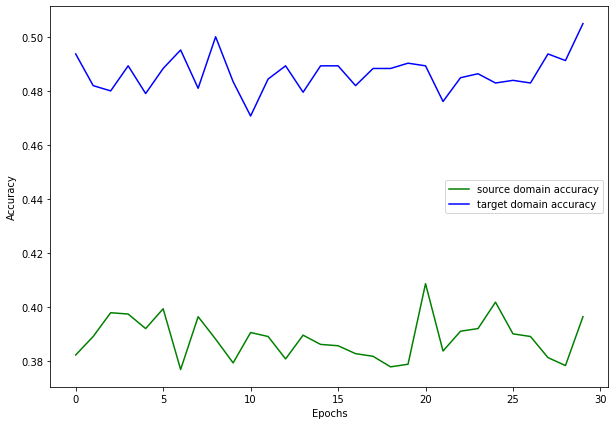

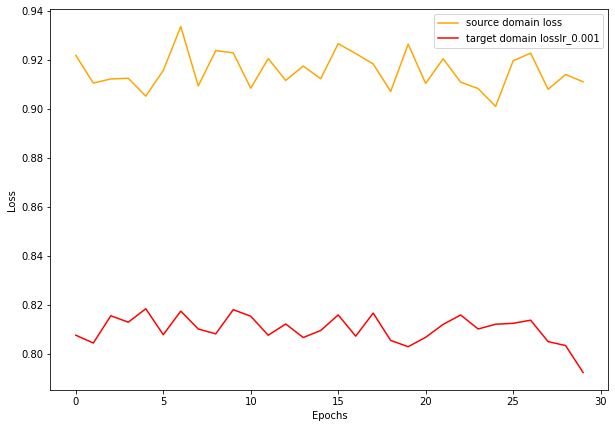

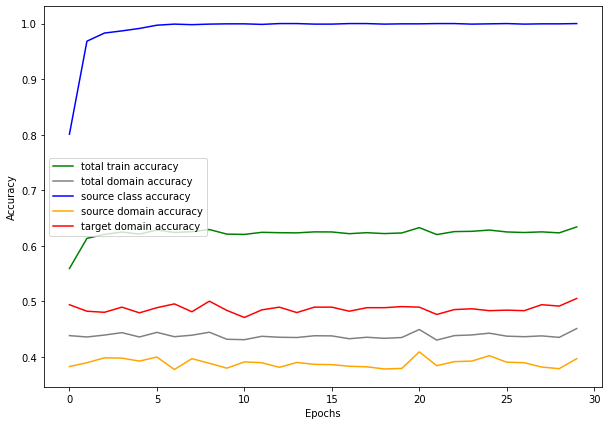

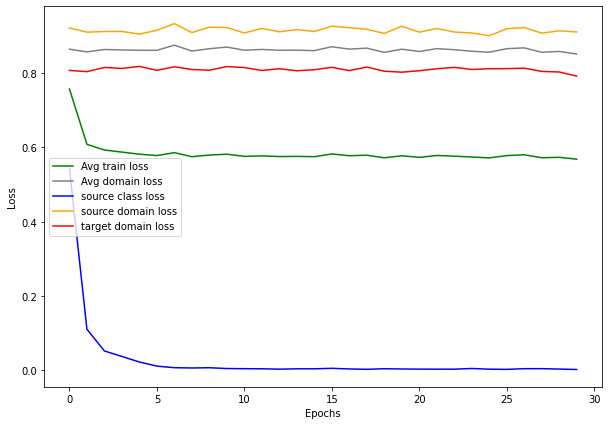

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Test Accuracy: 0.47998046875
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.6065, Train class Acc: 0.78
Target class Loss: 0.1643, Val class Acc: 0.47
Source domain Loss: 0.6738, Source domain Acc: 0.64
Target domain Loss: 1.0569, Target domain Acc: 0.29
Total train Loss: 0.7791, Total train Acc: 0.57
Total domain Loss: 0.8653, Total domain Acc: 0.46


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.1212, Train class Acc: 0.96
Target class Loss: 0.1305, Val class Acc: 0.45
Source domain Loss: 0.6668, Source domain Acc: 0.64
Target domain Loss: 1.0448, Target domain Acc: 0.29
Total train Loss: 0.6109, Total train Acc: 0.63
Total domain Loss: 0.8558, Total domain Acc: 0.47


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0540, Train class Acc: 0.98
Target class Loss: 0.0386, Val class Acc: 0.47
Source domain Loss: 0.6697, Source domain Acc: 0.64
Target domain Loss: 1.0403, Target domain Acc: 0.30
Total train Loss: 0.5880, Total train Acc: 0.64
Total domain Loss: 0.8550, Total domain Acc: 0.47


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Source class Loss: 0.0399, Train class Acc: 0.98
Target class Loss: 0.0420, Val class Acc: 0.45
Source domain Loss: 0.6759, Source domain Acc: 0.61
Target domain Loss: 1.0435, Target domain Acc: 0.28
Total train Loss: 0.5864, Total train Acc: 0.63
Total domain Loss: 0.8597, Total domain Acc: 0.45


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0161, Train class Acc: 0.99
Target class Loss: 0.0260, Val class Acc: 0.47
Source domain Loss: 0.6766, Source domain Acc: 0.62
Target domain Loss: 1.0576, Target domain Acc: 0.29
Total train Loss: 0.5834, Total train Acc: 0.64
Total domain Loss: 0.8671, Total domain Acc: 0.46


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0125, Train class Acc: 1.00
Target class Loss: 0.0073, Val class Acc: 0.47
Source domain Loss: 0.6682, Source domain Acc: 0.63
Target domain Loss: 1.0520, Target domain Acc: 0.29
Total train Loss: 0.5776, Total train Acc: 0.64
Total domain Loss: 0.8601, Total domain Acc: 0.46


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0074, Train class Acc: 1.00
Target class Loss: 0.0101, Val class Acc: 0.48
Source domain Loss: 0.6779, Source domain Acc: 0.63
Target domain Loss: 1.0519, Target domain Acc: 0.29
Total train Loss: 0.5791, Total train Acc: 0.64
Total domain Loss: 0.8649, Total domain Acc: 0.46


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.49
Source domain Loss: 0.6731, Source domain Acc: 0.63
Target domain Loss: 1.0476, Target domain Acc: 0.28
Total train Loss: 0.5752, Total train Acc: 0.64
Total domain Loss: 0.8603, Total domain Acc: 0.45


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0048, Val class Acc: 0.49
Source domain Loss: 0.6775, Source domain Acc: 0.63
Target domain Loss: 1.0491, Target domain Acc: 0.28
Total train Loss: 0.5769, Total train Acc: 0.64
Total domain Loss: 0.8633, Total domain Acc: 0.45


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0076, Train class Acc: 1.00
Target class Loss: 0.0060, Val class Acc: 0.49
Source domain Loss: 0.6695, Source domain Acc: 0.63
Target domain Loss: 1.0579, Target domain Acc: 0.27
Total train Loss: 0.5783, Total train Acc: 0.63
Total domain Loss: 0.8637, Total domain Acc: 0.45


Starting epoch 11/30, LR = [0.005]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.49
Source domain Loss: 0.6704, Source domain Acc: 0.62
Target domain Loss: 1.0489, Target domain Acc: 0.29
Total train Loss: 0.5741, Total train Acc: 0.64
Total domain Loss: 0.8596, Total domain Acc: 0.46


Starting epoch 12/30, LR = [0.005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0032, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.49
Source domain Loss: 0.6698, Source domain Acc: 0.62
Target domain Loss: 1.0521, Target domain Acc: 0.28
Total train Loss: 0.5750, Total train Acc: 0.63
Total domain Loss: 0.8609, Total domain Acc: 0.45


Starting epoch 13/30, LR = [0.005]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.6753, Source domain Acc: 0.64
Target domain Loss: 1.0429, Target domain Acc: 0.29
Total train Loss: 0.5738, Total train Acc: 0.64
Total domain Loss: 0.8591, Total domain Acc: 0.47


Starting epoch 14/30, LR = [0.005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0021, Val class Acc: 0.49
Source domain Loss: 0.6726, Source domain Acc: 0.62
Target domain Loss: 1.0347, Target domain Acc: 0.28
Total train Loss: 0.5700, Total train Acc: 0.64
Total domain Loss: 0.8537, Total domain Acc: 0.45


Starting epoch 15/30, LR = [0.005]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0051, Val class Acc: 0.49
Source domain Loss: 0.6738, Source domain Acc: 0.62
Target domain Loss: 1.0474, Target domain Acc: 0.28
Total train Loss: 0.5751, Total train Acc: 0.63
Total domain Loss: 0.8606, Total domain Acc: 0.45


Starting epoch 16/30, LR = [0.005]


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.6766, Source domain Acc: 0.61
Target domain Loss: 1.0571, Target domain Acc: 0.29
Total train Loss: 0.5791, Total train Acc: 0.64
Total domain Loss: 0.8669, Total domain Acc: 0.45


Starting epoch 17/30, LR = [0.005]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0014, Val class Acc: 0.49
Source domain Loss: 0.6730, Source domain Acc: 0.63
Target domain Loss: 1.0498, Target domain Acc: 0.30
Total train Loss: 0.5756, Total train Acc: 0.64
Total domain Loss: 0.8614, Total domain Acc: 0.47


Starting epoch 18/30, LR = [0.005]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0013, Val class Acc: 0.49
Source domain Loss: 0.6879, Source domain Acc: 0.61
Target domain Loss: 1.0493, Target domain Acc: 0.29
Total train Loss: 0.5803, Total train Acc: 0.63
Total domain Loss: 0.8686, Total domain Acc: 0.45


Starting epoch 19/30, LR = [0.005]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0025, Train class Acc: 1.00
Target class Loss: 0.0014, Val class Acc: 0.50
Source domain Loss: 0.6743, Source domain Acc: 0.64
Target domain Loss: 1.0570, Target domain Acc: 0.28
Total train Loss: 0.5779, Total train Acc: 0.64
Total domain Loss: 0.8656, Total domain Acc: 0.46


Starting epoch 20/30, LR = [0.005]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0053, Val class Acc: 0.50
Source domain Loss: 0.6712, Source domain Acc: 0.63
Target domain Loss: 1.0550, Target domain Acc: 0.28
Total train Loss: 0.5764, Total train Acc: 0.63
Total domain Loss: 0.8631, Total domain Acc: 0.45


Starting epoch 21/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0019, Val class Acc: 0.50
Source domain Loss: 0.6707, Source domain Acc: 0.63
Target domain Loss: 1.0404, Target domain Acc: 0.30
Total train Loss: 0.5711, Total train Acc: 0.64
Total domain Loss: 0.8555, Total domain Acc: 0.47


Starting epoch 22/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0030, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.49
Source domain Loss: 0.6631, Source domain Acc: 0.64
Target domain Loss: 1.0500, Target domain Acc: 0.29
Total train Loss: 0.5720, Total train Acc: 0.64
Total domain Loss: 0.8565, Total domain Acc: 0.46


Starting epoch 23/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0011, Val class Acc: 0.49
Source domain Loss: 0.6702, Source domain Acc: 0.64
Target domain Loss: 1.0535, Target domain Acc: 0.29
Total train Loss: 0.5757, Total train Acc: 0.64
Total domain Loss: 0.8619, Total domain Acc: 0.47


Starting epoch 24/30, LR = [0.0025]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0019, Train class Acc: 1.00
Target class Loss: 0.0008, Val class Acc: 0.49
Source domain Loss: 0.6693, Source domain Acc: 0.63
Target domain Loss: 1.0624, Target domain Acc: 0.28
Total train Loss: 0.5778, Total train Acc: 0.64
Total domain Loss: 0.8658, Total domain Acc: 0.46


Starting epoch 25/30, LR = [0.0025]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Source class Loss: 0.0028, Train class Acc: 1.00
Target class Loss: 0.0059, Val class Acc: 0.49
Source domain Loss: 0.6831, Source domain Acc: 0.61
Target domain Loss: 1.0445, Target domain Acc: 0.30
Total train Loss: 0.5768, Total train Acc: 0.64
Total domain Loss: 0.8638, Total domain Acc: 0.46


Starting epoch 26/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0023, Train class Acc: 1.00
Target class Loss: 0.0045, Val class Acc: 0.49
Source domain Loss: 0.6741, Source domain Acc: 0.63
Target domain Loss: 1.0450, Target domain Acc: 0.28
Total train Loss: 0.5738, Total train Acc: 0.64
Total domain Loss: 0.8596, Total domain Acc: 0.45


Starting epoch 27/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0021, Train class Acc: 1.00
Target class Loss: 0.0013, Val class Acc: 0.49
Source domain Loss: 0.6740, Source domain Acc: 0.64
Target domain Loss: 1.0449, Target domain Acc: 0.29
Total train Loss: 0.5737, Total train Acc: 0.64
Total domain Loss: 0.8595, Total domain Acc: 0.46


Starting epoch 28/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0033, Train class Acc: 1.00
Target class Loss: 0.0043, Val class Acc: 0.49
Source domain Loss: 0.6755, Source domain Acc: 0.62
Target domain Loss: 1.0473, Target domain Acc: 0.29
Total train Loss: 0.5754, Total train Acc: 0.63
Total domain Loss: 0.8614, Total domain Acc: 0.45


Starting epoch 29/30, LR = [0.0025]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Source class Loss: 0.0021, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.6749, Source domain Acc: 0.62
Target domain Loss: 1.0399, Target domain Acc: 0.29
Total train Loss: 0.5723, Total train Acc: 0.64
Total domain Loss: 0.8574, Total domain Acc: 0.46


Starting epoch 30/30, LR = [0.0025]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0017, Train class Acc: 1.00
Target class Loss: 0.0007, Val class Acc: 0.49
Source domain Loss: 0.6779, Source domain Acc: 0.62
Target domain Loss: 1.0487, Target domain Acc: 0.30
Total train Loss: 0.5761, Total train Acc: 0.64
Total domain Loss: 0.8633, Total domain Acc: 0.46


[(0.606488186866045, 0.783203125), (0.12123508471995592, 0.96142578125), (0.054030701983720064, 0.98046875), (0.03991449158638716, 0.98291015625), (0.016077854321338236, 0.994140625), (0.012463996419683099, 0.99658203125), (0.00744841992855072, 0.99853515625), (0.005064230877906084, 0.9990234375), (0.004214869346469641, 0.99951171875), (0.007565767737105489, 0.99853515625), (0.002967925276607275, 1.0), (0.003204553620889783, 0.99951171875), (0.003290291642770171, 0.99951171875), (0.0025390400551259518, 1.0), (0.004271040670573711, 0.99853515625), (0.0034262968692928553, 0.9990234375), (0.004057899117469788, 0.99853515625), (0.003777377074584365, 0.9990234375), (0.0025100167840719223, 0.9995

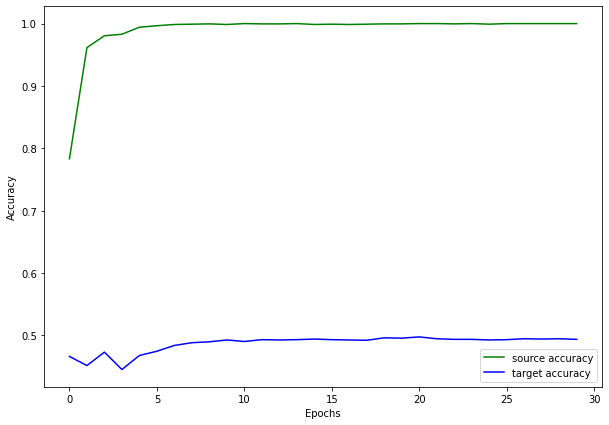

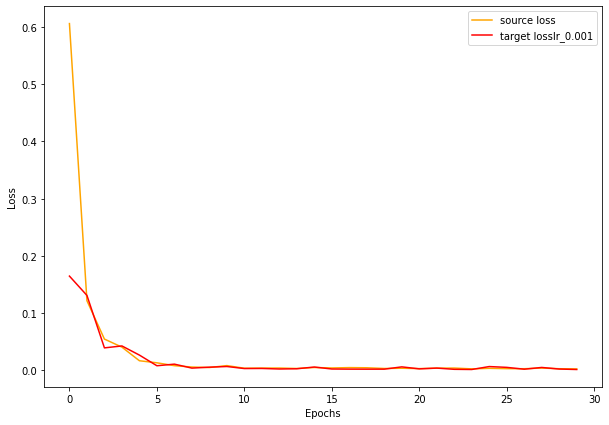

[(0.6738009378314018, 0.63623046875), (0.6667892336845398, 0.64404296875), (0.6697335615754128, 0.64111328125), (0.6758601889014244, 0.61474609375), (0.6765778586268425, 0.625), (0.6682199686765671, 0.6337890625), (0.6779170781373978, 0.62841796875), (0.6730696186423302, 0.62744140625), (0.6774985566735268, 0.62890625), (0.6694706007838249, 0.62646484375), (0.6703748628497124, 0.62255859375), (0.6697856113314629, 0.62353515625), (0.675261840224266, 0.64013671875), (0.6726281493902206, 0.625), (0.6737823784351349, 0.62451171875), (0.6766468584537506, 0.61474609375), (0.6730274260044098, 0.63427734375), (0.6879377439618111, 0.61474609375), (0.674262247979641, 0.63671875), (0.6711945459246635, 0.62548828125), (0.6706694141030312, 0.630859375), (0.6630706489086151, 0.63525390625), (0.6701950132846832, 0.6357421875), (0.6692680045962334, 0.6337890625), (0.6830884739756584, 0.6142578125), (0.6741094440221786, 0.6279296875), (0.6740338206291199, 0.63671875), (0.6754690781235695, 0.6162109375)

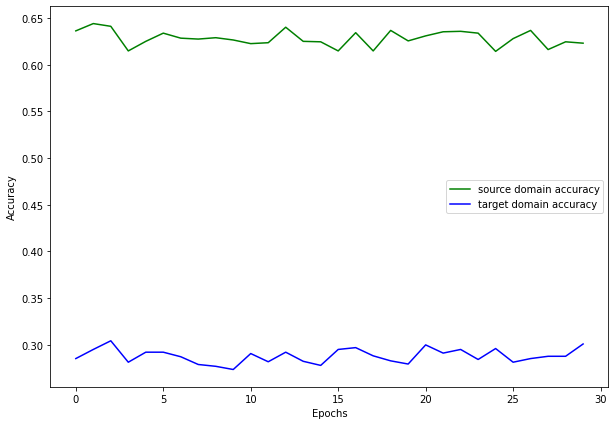

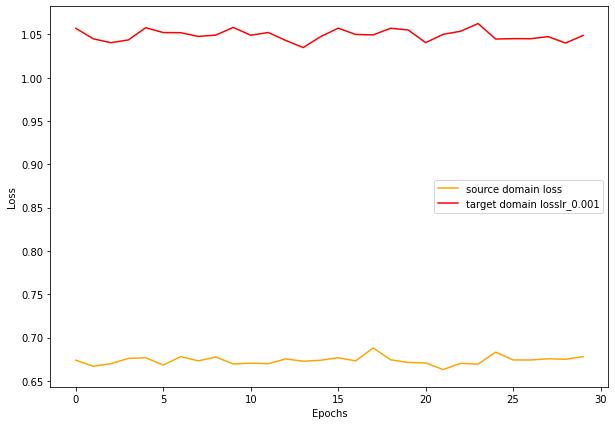

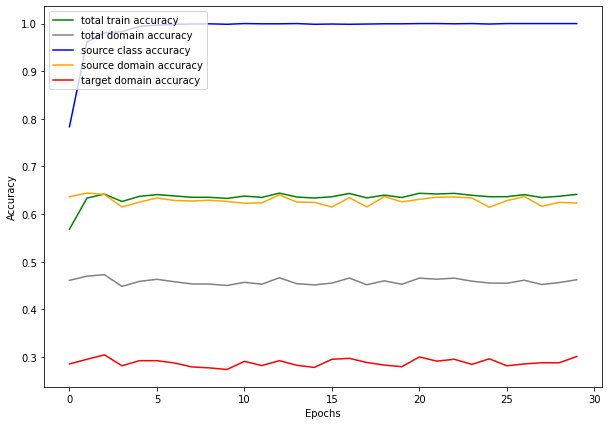

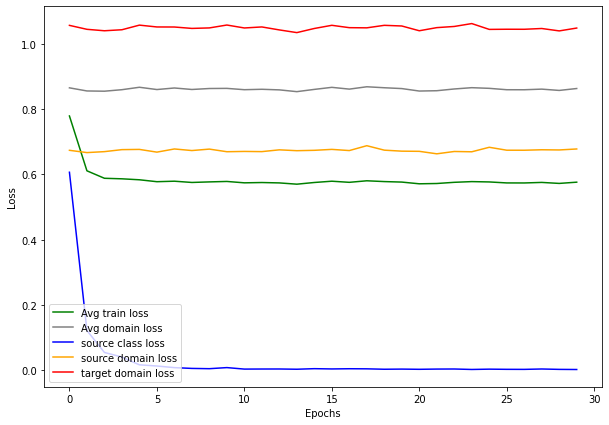

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Test Accuracy: 0.49365234375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.6010, Train class Acc: 0.78
Target class Loss: 0.1500, Val class Acc: 0.46
Source domain Loss: 0.8442, Source domain Acc: 0.47
Target domain Loss: 0.7691, Target domain Acc: 0.51
Total train Loss: 0.7381, Total train Acc: 0.59
Total domain Loss: 0.8066, Total domain Acc: 0.49


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.0894, Train class Acc: 0.97
Target class Loss: 0.0559, Val class Acc: 0.48
Source domain Loss: 0.8474, Source domain Acc: 0.47
Target domain Loss: 0.7558, Target domain Acc: 0.53
Total train Loss: 0.5642, Total train Acc: 0.66
Total domain Loss: 0.8016, Total domain Acc: 0.50


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0437, Train class Acc: 0.98
Target class Loss: 0.0299, Val class Acc: 0.47
Source domain Loss: 0.8423, Source domain Acc: 0.45
Target domain Loss: 0.7615, Target domain Acc: 0.52
Total train Loss: 0.5492, Total train Acc: 0.65
Total domain Loss: 0.8019, Total domain Acc: 0.49


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0280, Train class Acc: 0.99
Target class Loss: 0.0211, Val class Acc: 0.47
Source domain Loss: 0.8507, Source domain Acc: 0.47
Target domain Loss: 0.7553, Target domain Acc: 0.52
Total train Loss: 0.5447, Total train Acc: 0.66
Total domain Loss: 0.8030, Total domain Acc: 0.49


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]



Source class Loss: 0.0165, Train class Acc: 1.00
Target class Loss: 0.0105, Val class Acc: 0.48
Source domain Loss: 0.8409, Source domain Acc: 0.47
Target domain Loss: 0.7658, Target domain Acc: 0.52
Total train Loss: 0.5411, Total train Acc: 0.66
Total domain Loss: 0.8033, Total domain Acc: 0.49


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]



Source class Loss: 0.0112, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.47
Source domain Loss: 0.8406, Source domain Acc: 0.47
Target domain Loss: 0.7704, Target domain Acc: 0.52
Total train Loss: 0.5407, Total train Acc: 0.66
Total domain Loss: 0.8055, Total domain Acc: 0.50


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]



Source class Loss: 0.0077, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.48
Source domain Loss: 0.8362, Source domain Acc: 0.48
Target domain Loss: 0.7657, Target domain Acc: 0.52
Total train Loss: 0.5365, Total train Acc: 0.66
Total domain Loss: 0.8009, Total domain Acc: 0.50


Starting epoch 8/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]



Source class Loss: 0.0070, Train class Acc: 1.00
Target class Loss: 0.0047, Val class Acc: 0.47
Source domain Loss: 0.8326, Source domain Acc: 0.48
Target domain Loss: 0.7609, Target domain Acc: 0.52
Total train Loss: 0.5335, Total train Acc: 0.67
Total domain Loss: 0.7968, Total domain Acc: 0.50


Starting epoch 9/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0078, Train class Acc: 1.00
Target class Loss: 0.0045, Val class Acc: 0.48
Source domain Loss: 0.8424, Source domain Acc: 0.47
Target domain Loss: 0.7595, Target domain Acc: 0.52
Total train Loss: 0.5366, Total train Acc: 0.66
Total domain Loss: 0.8010, Total domain Acc: 0.50


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.49
Source domain Loss: 0.8366, Source domain Acc: 0.46
Target domain Loss: 0.7646, Target domain Acc: 0.51
Total train Loss: 0.5355, Total train Acc: 0.66
Total domain Loss: 0.8006, Total domain Acc: 0.49


Starting epoch 11/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.49
Source domain Loss: 0.8462, Source domain Acc: 0.47
Target domain Loss: 0.7546, Target domain Acc: 0.52
Total train Loss: 0.5355, Total train Acc: 0.66
Total domain Loss: 0.8004, Total domain Acc: 0.50


Starting epoch 12/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0047, Val class Acc: 0.49
Source domain Loss: 0.8405, Source domain Acc: 0.47
Target domain Loss: 0.7639, Target domain Acc: 0.53
Total train Loss: 0.5362, Total train Acc: 0.67
Total domain Loss: 0.8022, Total domain Acc: 0.50


Starting epoch 13/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0042, Train class Acc: 1.00
Target class Loss: 0.0053, Val class Acc: 0.49
Source domain Loss: 0.8360, Source domain Acc: 0.47
Target domain Loss: 0.7585, Target domain Acc: 0.52
Total train Loss: 0.5329, Total train Acc: 0.66
Total domain Loss: 0.7973, Total domain Acc: 0.50


Starting epoch 14/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0068, Val class Acc: 0.49
Source domain Loss: 0.8435, Source domain Acc: 0.47
Target domain Loss: 0.7599, Target domain Acc: 0.53
Total train Loss: 0.5357, Total train Acc: 0.66
Total domain Loss: 0.8017, Total domain Acc: 0.50


Starting epoch 15/30, LR = [0.0005]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0052, Train class Acc: 1.00
Target class Loss: 0.0016, Val class Acc: 0.49
Source domain Loss: 0.8493, Source domain Acc: 0.46
Target domain Loss: 0.7648, Target domain Acc: 0.52
Total train Loss: 0.5398, Total train Acc: 0.66
Total domain Loss: 0.8071, Total domain Acc: 0.49


Starting epoch 16/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.48
Source domain Loss: 0.8502, Source domain Acc: 0.46
Target domain Loss: 0.7631, Target domain Acc: 0.52
Total train Loss: 0.5391, Total train Acc: 0.66
Total domain Loss: 0.8066, Total domain Acc: 0.49


Starting epoch 17/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0029, Val class Acc: 0.48
Source domain Loss: 0.8462, Source domain Acc: 0.46
Target domain Loss: 0.7638, Target domain Acc: 0.52
Total train Loss: 0.5380, Total train Acc: 0.66
Total domain Loss: 0.8050, Total domain Acc: 0.49


Starting epoch 18/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Source class Loss: 0.0064, Train class Acc: 1.00
Target class Loss: 0.0157, Val class Acc: 0.48
Source domain Loss: 0.8318, Source domain Acc: 0.47
Target domain Loss: 0.7565, Target domain Acc: 0.53
Total train Loss: 0.5316, Total train Acc: 0.67
Total domain Loss: 0.7942, Total domain Acc: 0.50


Starting epoch 19/30, LR = [0.0005]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0038, Train class Acc: 1.00
Target class Loss: 0.0041, Val class Acc: 0.48
Source domain Loss: 0.8320, Source domain Acc: 0.47
Target domain Loss: 0.7640, Target domain Acc: 0.52
Total train Loss: 0.5333, Total train Acc: 0.66
Total domain Loss: 0.7980, Total domain Acc: 0.49


Starting epoch 20/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0055, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.48
Source domain Loss: 0.8461, Source domain Acc: 0.46
Target domain Loss: 0.7651, Target domain Acc: 0.51
Total train Loss: 0.5389, Total train Acc: 0.66
Total domain Loss: 0.8056, Total domain Acc: 0.49


Starting epoch 21/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.48
Source domain Loss: 0.8394, Source domain Acc: 0.47
Target domain Loss: 0.7548, Target domain Acc: 0.53
Total train Loss: 0.5328, Total train Acc: 0.67
Total domain Loss: 0.7971, Total domain Acc: 0.50


Starting epoch 22/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0056, Train class Acc: 1.00
Target class Loss: 0.0034, Val class Acc: 0.48
Source domain Loss: 0.8318, Source domain Acc: 0.49
Target domain Loss: 0.7544, Target domain Acc: 0.53
Total train Loss: 0.5306, Total train Acc: 0.67
Total domain Loss: 0.7931, Total domain Acc: 0.51


Starting epoch 23/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.48
Source domain Loss: 0.8295, Source domain Acc: 0.49
Target domain Loss: 0.7645, Target domain Acc: 0.52
Total train Loss: 0.5329, Total train Acc: 0.67
Total domain Loss: 0.7970, Total domain Acc: 0.51


Starting epoch 24/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0045, Train class Acc: 1.00
Target class Loss: 0.0031, Val class Acc: 0.48
Source domain Loss: 0.8341, Source domain Acc: 0.48
Target domain Loss: 0.7583, Target domain Acc: 0.52
Total train Loss: 0.5323, Total train Acc: 0.67
Total domain Loss: 0.7962, Total domain Acc: 0.50


Starting epoch 25/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.48
Source domain Loss: 0.8399, Source domain Acc: 0.49
Target domain Loss: 0.7587, Target domain Acc: 0.52
Total train Loss: 0.5339, Total train Acc: 0.67
Total domain Loss: 0.7993, Total domain Acc: 0.50


Starting epoch 26/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.48
Source domain Loss: 0.8506, Source domain Acc: 0.46
Target domain Loss: 0.7694, Target domain Acc: 0.51
Total train Loss: 0.5413, Total train Acc: 0.65
Total domain Loss: 0.8100, Total domain Acc: 0.48


Starting epoch 27/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0055, Train class Acc: 1.00
Target class Loss: 0.0071, Val class Acc: 0.48
Source domain Loss: 0.8403, Source domain Acc: 0.46
Target domain Loss: 0.7649, Target domain Acc: 0.51
Total train Loss: 0.5369, Total train Acc: 0.66
Total domain Loss: 0.8026, Total domain Acc: 0.48


Starting epoch 28/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0052, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.48
Source domain Loss: 0.8386, Source domain Acc: 0.47
Target domain Loss: 0.7709, Target domain Acc: 0.52
Total train Loss: 0.5382, Total train Acc: 0.66
Total domain Loss: 0.8047, Total domain Acc: 0.49


Starting epoch 29/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0050, Train class Acc: 1.00
Target class Loss: 0.0025, Val class Acc: 0.48
Source domain Loss: 0.8389, Source domain Acc: 0.47
Target domain Loss: 0.7622, Target domain Acc: 0.52
Total train Loss: 0.5354, Total train Acc: 0.66
Total domain Loss: 0.8006, Total domain Acc: 0.50


Starting epoch 30/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0054, Train class Acc: 1.00
Target class Loss: 0.0024, Val class Acc: 0.48
Source domain Loss: 0.8332, Source domain Acc: 0.47
Target domain Loss: 0.7666, Target domain Acc: 0.52
Total train Loss: 0.5351, Total train Acc: 0.66
Total domain Loss: 0.7999, Total domain Acc: 0.49


[(0.60099464841187, 0.7841796875), (0.089381517842412, 0.9697265625), (0.04370274115353823, 0.982421875), (0.027969800867140293, 0.990234375), (0.01652380102314055, 0.9970703125), (0.011211556266061962, 0.9970703125), (0.007696634856984019, 0.99755859375), (0.006979940575547516, 0.998046875), (0.007814024342224002, 0.998046875), (0.00543903186917305, 0.99951171875), (0.005807622103020549, 0.99951171875), (0.004249418154358864, 1.0), (0.004157341318204999, 0.99951171875), (0.0035882850643247366, 0.99951171875), (0.005189071409404278, 0.998046875), (0.0039099372224882245, 0.9990234375), (0.003845239756628871, 0.99951171875), (0.0064214898739010096, 0.99853515625), (0.0038372166454792023, 0.99

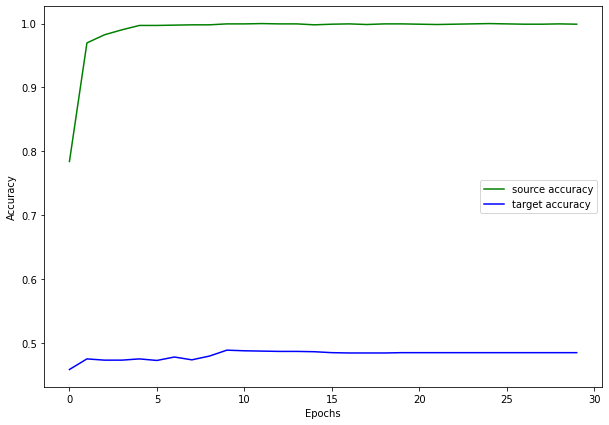

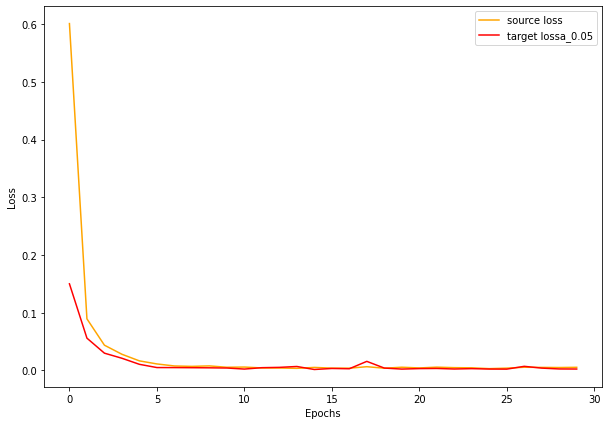

[(0.8441512584686279, 0.46728515625), (0.8473644480109215, 0.4697265625), (0.8422982916235924, 0.45458984375), (0.8507255762815475, 0.46630859375), (0.8408757150173187, 0.47265625), (0.8406205922365189, 0.47265625), (0.8361926600337029, 0.47509765625), (0.8326198533177376, 0.4794921875), (0.8424457758665085, 0.46728515625), (0.8365606367588043, 0.46240234375), (0.8461618274450302, 0.47119140625), (0.8405366390943527, 0.47119140625), (0.8360046073794365, 0.4677734375), (0.8435080051422119, 0.46533203125), (0.8492806628346443, 0.46044921875), (0.8501638248562813, 0.4599609375), (0.8462367206811905, 0.46044921875), (0.8318268433213234, 0.47265625), (0.8320480063557625, 0.47265625), (0.8461240455508232, 0.462890625), (0.8393624722957611, 0.4736328125), (0.8318170085549355, 0.4892578125), (0.8294570818543434, 0.49365234375), (0.8340666219592094, 0.4755859375), (0.8399295657873154, 0.486328125), (0.8506024554371834, 0.4580078125), (0.8403151705861092, 0.45947265625), (0.8386038616299629, 0.4

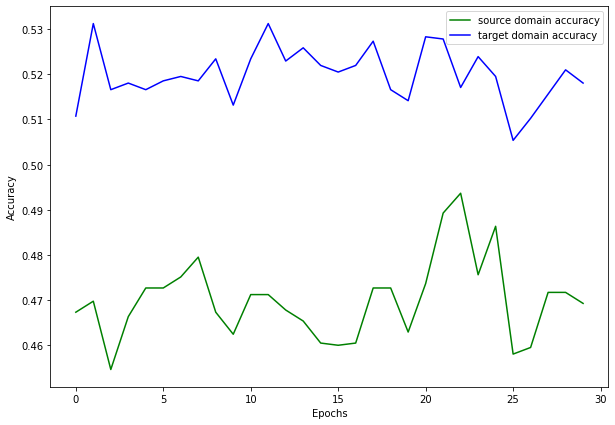

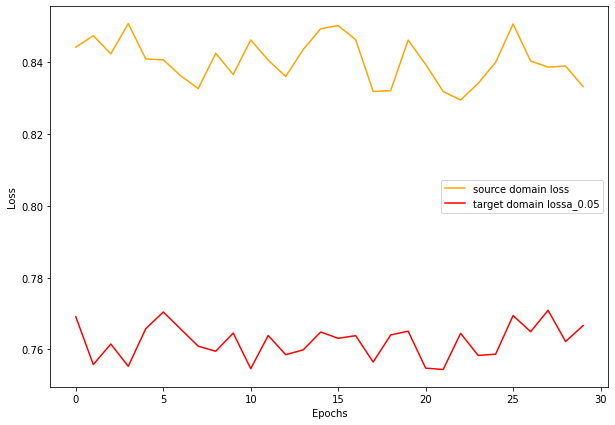

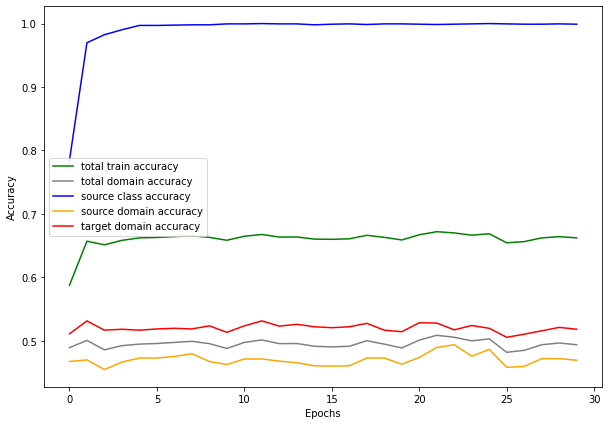

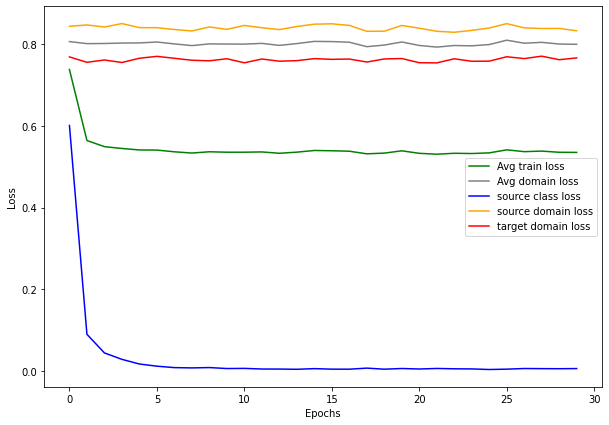

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Test Accuracy: 0.486328125
Starting epoch 1/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]



Source class Loss: 0.5864, Train class Acc: 0.78
Target class Loss: 0.0929, Val class Acc: 0.49
Source domain Loss: 0.8525, Source domain Acc: 0.48
Target domain Loss: 0.6309, Target domain Acc: 0.64
Total train Loss: 0.6899, Total train Acc: 0.63
Total domain Loss: 0.7417, Total domain Acc: 0.56


Starting epoch 2/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]



Source class Loss: 0.0921, Train class Acc: 0.97
Target class Loss: 0.0824, Val class Acc: 0.49
Source domain Loss: 0.8497, Source domain Acc: 0.48
Target domain Loss: 0.6307, Target domain Acc: 0.63
Total train Loss: 0.5242, Total train Acc: 0.69
Total domain Loss: 0.7402, Total domain Acc: 0.56


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



Source class Loss: 0.0689, Train class Acc: 0.97
Target class Loss: 0.0536, Val class Acc: 0.49
Source domain Loss: 0.8635, Source domain Acc: 0.48
Target domain Loss: 0.6292, Target domain Acc: 0.64
Total train Loss: 0.5205, Total train Acc: 0.70
Total domain Loss: 0.7464, Total domain Acc: 0.56


Starting epoch 4/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]



Source class Loss: 0.0272, Train class Acc: 0.99
Target class Loss: 0.0187, Val class Acc: 0.49
Source domain Loss: 0.8317, Source domain Acc: 0.50
Target domain Loss: 0.6351, Target domain Acc: 0.64
Total train Loss: 0.4980, Total train Acc: 0.71
Total domain Loss: 0.7334, Total domain Acc: 0.57


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0228, Train class Acc: 0.99
Target class Loss: 0.0133, Val class Acc: 0.49
Source domain Loss: 0.8513, Source domain Acc: 0.48
Target domain Loss: 0.6194, Target domain Acc: 0.65
Total train Loss: 0.4978, Total train Acc: 0.71
Total domain Loss: 0.7354, Total domain Acc: 0.56


Starting epoch 6/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]



Source class Loss: 0.0120, Train class Acc: 1.00
Target class Loss: 0.0096, Val class Acc: 0.49
Source domain Loss: 0.8571, Source domain Acc: 0.47
Target domain Loss: 0.6202, Target domain Acc: 0.64
Total train Loss: 0.4964, Total train Acc: 0.70
Total domain Loss: 0.7386, Total domain Acc: 0.55


Starting epoch 7/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Source class Loss: 0.0073, Train class Acc: 1.00
Target class Loss: 0.0100, Val class Acc: 0.48
Source domain Loss: 0.8489, Source domain Acc: 0.48
Target domain Loss: 0.6160, Target domain Acc: 0.64
Total train Loss: 0.4907, Total train Acc: 0.71
Total domain Loss: 0.7325, Total domain Acc: 0.56


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Source class Loss: 0.0062, Train class Acc: 1.00
Target class Loss: 0.0108, Val class Acc: 0.49
Source domain Loss: 0.8570, Source domain Acc: 0.47
Target domain Loss: 0.6183, Target domain Acc: 0.65
Total train Loss: 0.4938, Total train Acc: 0.71
Total domain Loss: 0.7376, Total domain Acc: 0.56


Starting epoch 9/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0048, Val class Acc: 0.50
Source domain Loss: 0.8559, Source domain Acc: 0.48
Target domain Loss: 0.6263, Target domain Acc: 0.64
Total train Loss: 0.4958, Total train Acc: 0.70
Total domain Loss: 0.7411, Total domain Acc: 0.56


Starting epoch 10/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0068, Train class Acc: 1.00
Target class Loss: 0.0099, Val class Acc: 0.50
Source domain Loss: 0.8636, Source domain Acc: 0.48
Target domain Loss: 0.6263, Target domain Acc: 0.64
Total train Loss: 0.4989, Total train Acc: 0.70
Total domain Loss: 0.7449, Total domain Acc: 0.56


Starting epoch 11/30, LR = [0.0005]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0040, Val class Acc: 0.50
Source domain Loss: 0.8437, Source domain Acc: 0.48
Target domain Loss: 0.6342, Target domain Acc: 0.63
Total train Loss: 0.4942, Total train Acc: 0.70
Total domain Loss: 0.7389, Total domain Acc: 0.55


Starting epoch 12/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0029, Val class Acc: 0.50
Source domain Loss: 0.8649, Source domain Acc: 0.47
Target domain Loss: 0.6261, Target domain Acc: 0.64
Total train Loss: 0.4985, Total train Acc: 0.70
Total domain Loss: 0.7455, Total domain Acc: 0.56


Starting epoch 13/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0092, Val class Acc: 0.50
Source domain Loss: 0.8448, Source domain Acc: 0.47
Target domain Loss: 0.6205, Target domain Acc: 0.64
Total train Loss: 0.4904, Total train Acc: 0.70
Total domain Loss: 0.7327, Total domain Acc: 0.55


Starting epoch 14/30, LR = [0.0005]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0031, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.50
Source domain Loss: 0.8581, Source domain Acc: 0.48
Target domain Loss: 0.6326, Target domain Acc: 0.65
Total train Loss: 0.4979, Total train Acc: 0.71
Total domain Loss: 0.7453, Total domain Acc: 0.56


Starting epoch 15/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0019, Val class Acc: 0.50
Source domain Loss: 0.8523, Source domain Acc: 0.48
Target domain Loss: 0.6232, Target domain Acc: 0.64
Total train Loss: 0.4933, Total train Acc: 0.71
Total domain Loss: 0.7378, Total domain Acc: 0.56


Starting epoch 16/30, LR = [0.0005]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0071, Val class Acc: 0.50
Source domain Loss: 0.8550, Source domain Acc: 0.48
Target domain Loss: 0.6326, Target domain Acc: 0.64
Total train Loss: 0.4972, Total train Acc: 0.71
Total domain Loss: 0.7438, Total domain Acc: 0.56


Starting epoch 17/30, LR = [0.0005]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0039, Train class Acc: 1.00
Target class Loss: 0.0051, Val class Acc: 0.50
Source domain Loss: 0.8449, Source domain Acc: 0.48
Target domain Loss: 0.6242, Target domain Acc: 0.63
Total train Loss: 0.4910, Total train Acc: 0.70
Total domain Loss: 0.7345, Total domain Acc: 0.56


Starting epoch 18/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Source class Loss: 0.0046, Train class Acc: 1.00
Target class Loss: 0.0104, Val class Acc: 0.50
Source domain Loss: 0.8516, Source domain Acc: 0.48
Target domain Loss: 0.6312, Target domain Acc: 0.63
Total train Loss: 0.4958, Total train Acc: 0.70
Total domain Loss: 0.7414, Total domain Acc: 0.55


Starting epoch 19/30, LR = [0.0005]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0041, Train class Acc: 1.00
Target class Loss: 0.0037, Val class Acc: 0.50
Source domain Loss: 0.8479, Source domain Acc: 0.47
Target domain Loss: 0.6236, Target domain Acc: 0.64
Total train Loss: 0.4919, Total train Acc: 0.70
Total domain Loss: 0.7358, Total domain Acc: 0.56


Starting epoch 20/30, LR = [0.0005]



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Source class Loss: 0.0036, Train class Acc: 1.00
Target class Loss: 0.0023, Val class Acc: 0.50
Source domain Loss: 0.8514, Source domain Acc: 0.47
Target domain Loss: 0.6289, Target domain Acc: 0.64
Total train Loss: 0.4946, Total train Acc: 0.70
Total domain Loss: 0.7401, Total domain Acc: 0.56


Starting epoch 21/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0035, Val class Acc: 0.50
Source domain Loss: 0.8491, Source domain Acc: 0.49
Target domain Loss: 0.6340, Target domain Acc: 0.63
Total train Loss: 0.4958, Total train Acc: 0.71
Total domain Loss: 0.7415, Total domain Acc: 0.56


Starting epoch 22/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0047, Train class Acc: 1.00
Target class Loss: 0.0026, Val class Acc: 0.50
Source domain Loss: 0.8441, Source domain Acc: 0.48
Target domain Loss: 0.6245, Target domain Acc: 0.65
Total train Loss: 0.4911, Total train Acc: 0.71
Total domain Loss: 0.7343, Total domain Acc: 0.56


Starting epoch 23/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Source class Loss: 0.0058, Train class Acc: 1.00
Target class Loss: 0.0049, Val class Acc: 0.50
Source domain Loss: 0.8570, Source domain Acc: 0.47
Target domain Loss: 0.6154, Target domain Acc: 0.65
Total train Loss: 0.4927, Total train Acc: 0.71
Total domain Loss: 0.7362, Total domain Acc: 0.56


Starting epoch 24/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0017, Val class Acc: 0.50
Source domain Loss: 0.8487, Source domain Acc: 0.49
Target domain Loss: 0.6180, Target domain Acc: 0.65
Total train Loss: 0.4905, Total train Acc: 0.71
Total domain Loss: 0.7333, Total domain Acc: 0.57


Starting epoch 25/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]



Source class Loss: 0.0035, Train class Acc: 1.00
Target class Loss: 0.0029, Val class Acc: 0.50
Source domain Loss: 0.8403, Source domain Acc: 0.50
Target domain Loss: 0.6316, Target domain Acc: 0.64
Total train Loss: 0.4918, Total train Acc: 0.71
Total domain Loss: 0.7360, Total domain Acc: 0.57


Starting epoch 26/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Source class Loss: 0.0043, Train class Acc: 1.00
Target class Loss: 0.0032, Val class Acc: 0.50
Source domain Loss: 0.8485, Source domain Acc: 0.49
Target domain Loss: 0.6269, Target domain Acc: 0.64
Total train Loss: 0.4932, Total train Acc: 0.71
Total domain Loss: 0.7377, Total domain Acc: 0.56


Starting epoch 27/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Source class Loss: 0.0034, Train class Acc: 1.00
Target class Loss: 0.0019, Val class Acc: 0.50
Source domain Loss: 0.8448, Source domain Acc: 0.46
Target domain Loss: 0.6257, Target domain Acc: 0.64
Total train Loss: 0.4913, Total train Acc: 0.70
Total domain Loss: 0.7353, Total domain Acc: 0.55


Starting epoch 28/30, LR = [2.5e-05]


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Source class Loss: 0.0048, Train class Acc: 1.00
Target class Loss: 0.0060, Val class Acc: 0.50
Source domain Loss: 0.8518, Source domain Acc: 0.49
Target domain Loss: 0.6265, Target domain Acc: 0.65
Total train Loss: 0.4944, Total train Acc: 0.71
Total domain Loss: 0.7392, Total domain Acc: 0.57


Starting epoch 29/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Source class Loss: 0.0051, Train class Acc: 1.00
Target class Loss: 0.0080, Val class Acc: 0.50
Source domain Loss: 0.8688, Source domain Acc: 0.47
Target domain Loss: 0.6307, Target domain Acc: 0.64
Total train Loss: 0.5015, Total train Acc: 0.70
Total domain Loss: 0.7498, Total domain Acc: 0.55


Starting epoch 30/30, LR = [2.5e-05]



100%|██████████| 8/8 [00:07<00:00,  1.00it/s]



Source class Loss: 0.0044, Train class Acc: 1.00
Target class Loss: 0.0022, Val class Acc: 0.50
Source domain Loss: 0.8504, Source domain Acc: 0.48
Target domain Loss: 0.6256, Target domain Acc: 0.64
Total train Loss: 0.4935, Total train Acc: 0.71
Total domain Loss: 0.7380, Total domain Acc: 0.56


[(0.5864100586622953, 0.7841796875), (0.09209202183410525, 0.96728515625), (0.06889017345383763, 0.97314453125), (0.02720184065401554, 0.9912109375), (0.02278700261376798, 0.99267578125), (0.011959198862314224, 0.99658203125), (0.007306374609470367, 0.9990234375), (0.0061529361410066485, 0.99951171875), (0.00509799993596971, 0.99853515625), (0.006832663435488939, 0.998046875), (0.004664425738155842, 0.9990234375), (0.0044320193119347095, 0.99951171875), (0.005794024793431163, 0.998046875), (0.0031307777389883995, 0.99951171875), (0.004398880293592811, 1.0), (0.004077637800946832, 0.9990234375), (0.0039040008559823036, 0.99951171875), (0.004624467110261321, 0.99853515625), (0.004086836008355

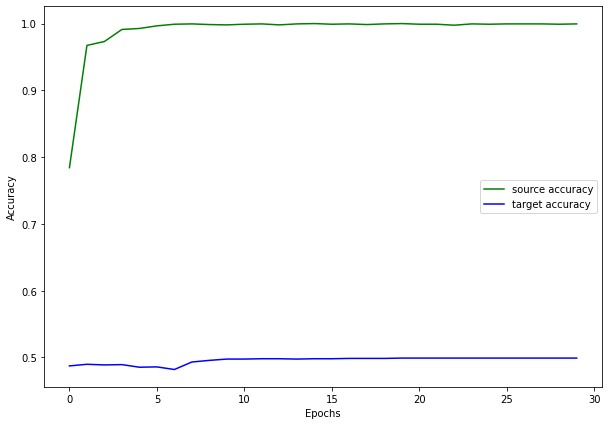

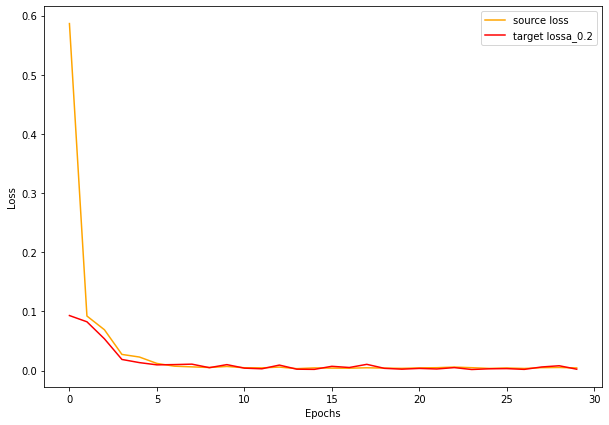

[(0.8525034859776497, 0.4755859375), (0.8496703132987022, 0.478515625), (0.8635248988866806, 0.47607421875), (0.8317495733499527, 0.4970703125), (0.8513016551733017, 0.4775390625), (0.8571250736713409, 0.47021484375), (0.8489439412951469, 0.48486328125), (0.8569577559828758, 0.46826171875), (0.8559350669384003, 0.478515625), (0.8635534718632698, 0.47509765625), (0.8437103033065796, 0.47900390625), (0.8649158477783203, 0.4677734375), (0.8448390439152718, 0.4677734375), (0.85811498016119, 0.47509765625), (0.8523157685995102, 0.47705078125), (0.8550329282879829, 0.4814453125), (0.844895526766777, 0.478515625), (0.8515918329358101, 0.47705078125), (0.8479364290833473, 0.47216796875), (0.8513706922531128, 0.47412109375), (0.8490701392292976, 0.49169921875), (0.8440907076001167, 0.4833984375), (0.8569868952035904, 0.46923828125), (0.8486964553594589, 0.48681640625), (0.8403255417943001, 0.49755859375), (0.8484619706869125, 0.48583984375), (0.8448471054434776, 0.46435546875), (0.8518375158309

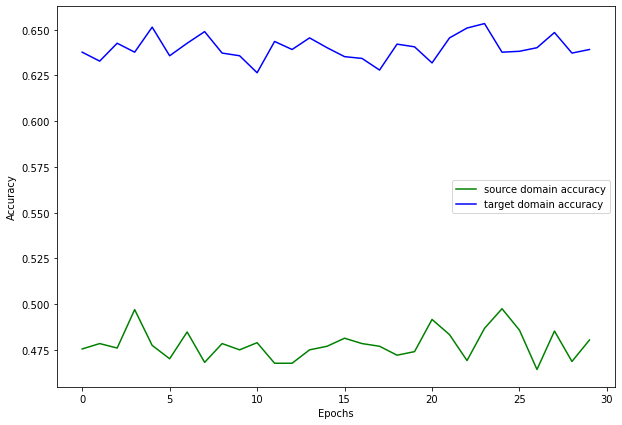

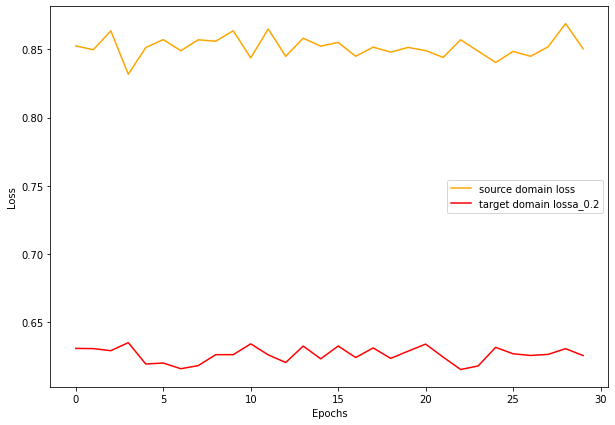

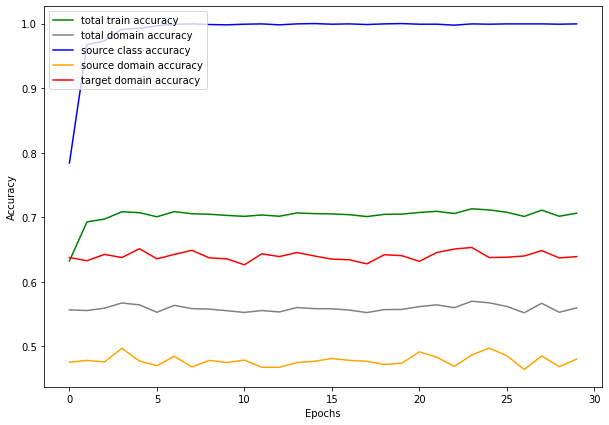

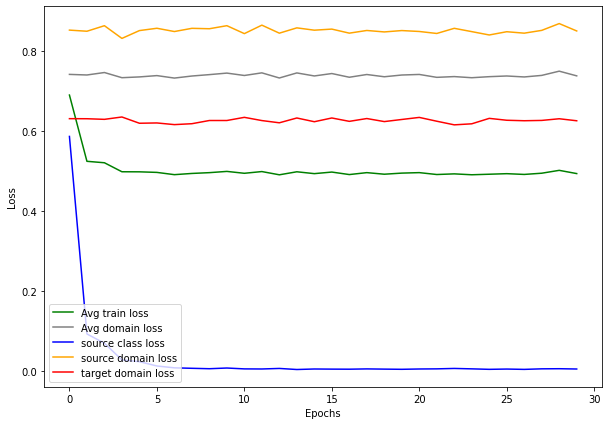

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

Test Accuracy: 0.4990234375
[{'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.1, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.42138671875}, {'LR': 0.001, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4638671875}, {'LR': 0.01, 'WEIGHT_DECAY': 0.0005, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.470703125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-06, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.4609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 5, 'GAMMA': 0.1, 'accuracy': 0.482421875}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.1, 'accuracy': 0.49365234375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 15, 'GAMMA': 0.1, 'accuracy': 0.4677734375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.05, 'accuracy': 0.47705078125}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-05, 'STEP_SIZE': 10, 'GAMMA': 0.3, 'accuracy': 0.45849609375}, {'LR': 0.01, 'WEIGHT_DECAY': 5e-

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
BATCH_SIZE = 256     
LR = 1e-2            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5   
NUM_EPOCHS = 30      
STEP_SIZE = 10       
GAMMA = 0.1       
ALPHA = 0.1
parameters = {
    'ALPHA' : [0.05,0.2],
    'LR' : [1e-1,1e-3],
    'WEIGHT_DECAY' : [5e-4,5e-6],
    'STEP_SIZE': [5,10,15],
    'GAMMA' : [0.05,0.3,0.5]
}

first_attempt = {
'ALPHA':ALPHA,
'LR' : LR,
'WEIGHT_DECAY' : WEIGHT_DECAY,
'STEP_SIZE': STEP_SIZE,
'GAMMA' : GAMMA,
'accuracy' : 0.38
}

tests.append(first_attempt)
ress = [0.38]

src_dataloader = DataLoader(src_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()

for lra in parameters['LR']:
    s = f'lr_{lra}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=lra, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=ALPHA)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)
    result = {  'ALPHA' : ALPHA,
                'LR' : lra,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      LR = lra
    ress.append(res)

print(tests)
print(ress)

for wd in parameters['WEIGHT_DECAY']:
    s = f'wd_{wd}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=ALPHA)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)
    result = {  'ALPHA' : ALPHA,
                'LR' : LR,
                'WEIGHT_DECAY' : wd,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      WEIGHT_DECAY=wd
    ress.append(res)

print(tests)
print(ress)

for st in parameters['STEP_SIZE']:
    s = f'st_{st}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=st, gamma=GAMMA)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=ALPHA)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)
    result = {  'ALPHA' : ALPHA,
                'LR' : LR,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': st,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      STEP_SIZE = st
    ress.append(res)

print(tests)
print(ress)


for g in parameters['GAMMA']:
    s = f'lr_{lra}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=g)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=ALPHA)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)
    result = {  'ALPHA' : ALPHA,
                'LR' : LR,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : g,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      GAMMA = g
    ress.append(res)

print(tests)
print(ress)

for a in parameters['ALPHA']:
    s = f'a_{a}'
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    net.domain_classifier[6] = nn.Linear(4096,NUM_DOMAINS)
    parameters_to_optimize = net.classifier.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,net = train_dann(net,src_dataloader=src_dataloader,target_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN"+s,ALPHA=a)
    print_acc_loss(tl,ta,vl,va,"alexnet_DANN class",label1 = 'source accuracy', label2 = 'target accuracy', label3 = 'source loss',label4= 'target loss'+s)
    print_acc_loss(sdl,sda,tdl,tda, "alexnet_DANN domain",label1 = 'source domain accuracy', label2 = 'target domain accuracy', label3 = 'source domain loss',label4= 'target domain loss'+s)
    print_DANN_acc_loss(totl,tota,dl,da,tl,ta,sdl,sda,tdl,tda,vl,va,title = 'DANN every plots'+s)
    res = test(net,target_dataloader)
    result = {  'ALPHA' : a,
                'LR' : LR,
                'WEIGHT_DECAY' : WEIGHT_DECAY,
                'STEP_SIZE': STEP_SIZE,
                'GAMMA' : GAMMA,
                'accuracy' : res}
    tests.append(result)
    if res > max(ress):
      ALPHA = a
    ress.append(res)


print(tests)
print(ress)

In [ ]:
!mv *.png /content/drive/My\ Drive/

In [ ]:
rs_alexnet = []
rs_dann = []
for image in os.listdir('/content/drive/My Drive'):
    if image.endswith('.png'):
        if image.startswith('alexnet_noDANN_pretrained_0.0'):
                data = image.split('_')
                dic = { 'LR' : data[3],
                        'WEIGHT_DECAY' : data[4],
                        'STEP_SIZE': 10,
                        'GAMMA' : data[5],
                        'accuracy' : 0}
                #model = torchvision.models.alexnet()
                #model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
                mp = '/content/drive/My Drive/' + "_".join(image.split('_')[:-1])
                model = torch.load(mp)#.load_state_dict(torch.load(mp))
                model.eval()
                res = test(model,target_dataloader)
                dic['accuracy'] = res
                rs_alexnet.append(dic)

print(rs_alexnet)
print(rs_dann)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:28,  4.01s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.90s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.12s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.58s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.84s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.34s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.01it/s]

100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Test Accuracy: 0.388671875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.82s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.76s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.02s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.49s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.81s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.33s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.01it/s]

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Test Accuracy: 0.388671875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.88s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.81s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.06s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.54s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.83s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.34s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.01it/s]

100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Test Accuracy: 0.466796875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:24,  3.54s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.69s/it]

 38%|███▊      | 3/8 [00:04<00:09,  1.98s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.48s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.67s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.32s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.02it/s]

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Test Accuracy: 0.466796875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:23,  3.39s/it]

 25%|██▌       | 2/8 [00:04<00:15,  2.62s/it]

 38%|███▊      | 3/8 [00:04<00:09,  1.92s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.43s/it]

 62%|██████▎   | 5/8 [00:06<00:04,  1.63s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.32s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.03it/s]

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Test Accuracy: 0.45654296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.96s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.87s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.10s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.56s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.85s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.00s/it]

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Test Accuracy: 0.45654296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.74s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.02s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.50s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.85s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.00s/it]

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Test Accuracy: 0.5




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.85s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.80s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.05s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.52s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.85s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.00it/s]

100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Test Accuracy: 0.5




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.87s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.80s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.04s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.51s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.86s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.36s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.00s/it]

100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Test Accuracy: 0.46142578125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:25,  3.68s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.68s/it]

 38%|███▊      | 3/8 [00:04<00:09,  2.00s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.49s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.81s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.33s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.02it/s]

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Test Accuracy: 0.46142578125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:23,  3.42s/it]

 25%|██▌       | 2/8 [00:04<00:15,  2.63s/it]

 38%|███▊      | 3/8 [00:04<00:09,  1.94s/it]

 50%|█████     | 4/8 [00:04<00:05,  1.43s/it]

 62%|██████▎   | 5/8 [00:06<00:04,  1.63s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.00it/s]

100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Test Accuracy: 0.47314453125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:27,  4.00s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.89s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.12s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.56s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.85s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.00it/s]

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]

Test Accuracy: 0.47314453125
[{'LR': '0.0001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.14163315384070613', 'accuracy': 0.388671875}, {'LR': '0.0001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.14163315384070613', 'accuracy': 0.388671875}, {'LR': '0.001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.15703938246887605', 'accuracy': 0.466796875}, {'LR': '0.001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.15703938246887605', 'accuracy': 0.466796875}, {'LR': '0.001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.1193961799620868', 'accuracy': 0.45654296875}, {'LR': '0.001', 'WEIGHT_DECAY': '4.9999999999999996e-06', 'STEP_SIZE': 10, 'GAMMA': '0.1193961799620868', 'accuracy': 0.45654296875}, {'LR': '0.001', 'WEIGHT_DECAY': '0.0005', 'STEP_SIZE': 10, 'GAMMA': '0.13498619876105714', 'accuracy': 0.5}, {'LR': '0.001', 'WEIGHT_DECAY': '0.0005', 'STEP_SIZE': 10, 

In [ ]:
rs_dann = []
for image in os.listdir('/content/drive/My Drive'):
    if image.endswith('.png'):
        if image.startswith('DANN'):
            data = image.split('plots')[1]
            data = data.split('_')
            if len(data) > 4:
                dic = { 'ALPHA' : data[3],
                        'LR' : data[0],
                        'WEIGHT_DECAY' : data[1],
                        'STEP_SIZE': 10,
                        'GAMMA' : data[2],
                        'accuracy' : 0}
                mp = '/content/drive/My Drive/alexnet_DANN' + "_".join(data[:-2])
                model = torch.load(mp)#.load_state_dict(torch.load(mp))
                model.eval()
                res = test(model,target_dataloader)
                dic['accuracy'] = res
                rs_dann.append(dic)
print(rs_dann)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:29,  4.27s/it]

 25%|██▌       | 2/8 [00:04<00:18,  3.08s/it]

 38%|███▊      | 3/8 [00:04<00:11,  2.26s/it]

 50%|█████     | 4/8 [00:05<00:06,  1.68s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.93s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.40s/it]

 88%|████████▊ | 7/8 [00:08<00:01,  1.03s/it]

100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Test Accuracy: 0.42529296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:28,  4.04s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.94s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.17s/it]

 50%|█████     | 4/8 [00:05<00:06,  1.62s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.87s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.37s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.01s/it]

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Test Accuracy: 0.42529296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:28,  4.03s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.91s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.14s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.58s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.96s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.43s/it]

 88%|████████▊ | 7/8 [00:08<00:01,  1.05s/it]

100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Test Accuracy: 0.30810546875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.92s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.85s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.08s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.55s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.87s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.36s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.01s/it]

100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Test Accuracy: 0.30810546875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:29,  4.24s/it]

 25%|██▌       | 2/8 [00:04<00:18,  3.06s/it]

 38%|███▊      | 3/8 [00:04<00:11,  2.24s/it]

 50%|█████     | 4/8 [00:05<00:06,  1.66s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.90s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.38s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.02s/it]

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Test Accuracy: 0.42529296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.96s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.88s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.12s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.58s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.88s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.37s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.02s/it]

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Test Accuracy: 0.42529296875




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:28,  4.07s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.93s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.14s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.58s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.88s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.37s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.01s/it]

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Test Accuracy: 0.22705078125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.84s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.79s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.03s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.51s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.84s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.34s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.01it/s]

100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Test Accuracy: 0.22705078125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:04<00:29,  4.22s/it]

 25%|██▌       | 2/8 [00:04<00:18,  3.05s/it]

 38%|███▊      | 3/8 [00:04<00:11,  2.22s/it]

 50%|█████     | 4/8 [00:05<00:06,  1.66s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.85s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.35s/it]

 88%|████████▊ | 7/8 [00:07<00:00,  1.00it/s]

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Test Accuracy: 0.43798828125




  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:27,  3.89s/it]

 25%|██▌       | 2/8 [00:04<00:16,  2.83s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.08s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.55s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.89s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.37s/it]

 88%|████████▊ | 7/8 [00:07<00:01,  1.02s/it]

100%|██████████| 8/8 [00:08<00:00,  1.02s/it]

Test Accuracy: 0.43798828125


FileNotFoundError: ignored

In [ ]:
BATCH_SIZE = 256
src_dataloader = DataLoader(src_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
net = alexnet(pretrained = True,num_classes = NUM_CLASSES,num_domains = 2) # Loading AlexNet model
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code
for p in net.parameters():
    p.requires_grad = True

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')



tl,ta,vl,va,net = train_dann(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="./alexnet_DANN",ALPHA=ALPHA)


111,574,857 total parameters.
111,574,857 training parameters.
Starting epoch 1/30, LR = [0.01]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7facfa7aa860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7facfa1f1518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Step 0, Loss 1.9826947450637817


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Train Loss: 1.3151, Train Acc: 0.65
Val Loss: 1.7384, Val Acc: 0.48


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 3.2856974601745605


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Train Loss: 1.9469, Train Acc: 0.78
Val Loss: 1.9825, Val Acc: 0.24


Starting epoch 3/30, LR = [0.01]


Step 20, Loss 1.1642791032791138


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 1.2044, Train Acc: 0.66
Val Loss: 1.8430, Val Acc: 0.20


Starting epoch 4/30, LR = [0.01]


Step 30, Loss 1.1089367866516113


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 1.0969, Train Acc: 0.63
Val Loss: 1.8432, Val Acc: 0.18


Starting epoch 5/30, LR = [0.01]



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 1.0342, Train Acc: 0.67
Val Loss: 1.8093, Val Acc: 0.26


Starting epoch 6/30, LR = [0.01]


Step 40, Loss 0.942156195640564


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.9272, Train Acc: 0.77
Val Loss: 1.8934, Val Acc: 0.23


Starting epoch 7/30, LR = [0.01]


Step 50, Loss 0.8543198704719543


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.7937, Train Acc: 0.82
Val Loss: 1.9880, Val Acc: 0.26


Starting epoch 8/30, LR = [0.01]


Step 60, Loss 0.7134389877319336


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train Loss: 0.6704, Train Acc: 0.91
Val Loss: 2.2882, Val Acc: 0.27


Starting epoch 9/30, LR = [0.01]


Step 70, Loss 0.5344288945198059


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Train Loss: 0.5610, Train Acc: 0.97
Val Loss: 2.4525, Val Acc: 0.31


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.4721, Train Acc: 1.00
Val Loss: 3.1302, Val Acc: 0.28


Starting epoch 11/30, LR = [0.001]


Step 80, Loss 0.40691930055618286


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.3986, Train Acc: 1.03
Val Loss: 2.8864, Val Acc: 0.31


Starting epoch 12/30, LR = [0.001]


Step 90, Loss 0.39141467213630676


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Train Loss: 0.3735, Train Acc: 1.05
Val Loss: 2.7024, Val Acc: 0.33


Starting epoch 13/30, LR = [0.001]


Step 100, Loss 0.2870001196861267


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.3300, Train Acc: 1.08
Val Loss: 2.9470, Val Acc: 0.31


Starting epoch 14/30, LR = [0.001]


Step 110, Loss 0.34389376640319824


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.3201, Train Acc: 1.09
Val Loss: 3.2993, Val Acc: 0.29


Starting epoch 15/30, LR = [0.001]


KeyboardInterrupt: ignored

**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(target_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(target_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:09<00:00,  1.19s/it]

Test Accuracy: 0.21923828125


57,032,519 total parameters.
57,032,519 training parameters.
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 1.948744773864746


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Train Loss: 1.9461, Train Acc: 0.15
Val Loss: 1.9431, Val Acc: 0.22


Starting epoch 2/30, LR = [0.01]
Step 10, Loss 1.9355387687683105


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Train Loss: 1.9376, Train Acc: 0.24
Val Loss: 1.9377, Val Acc: 0.22


Starting epoch 3/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Train Loss: 1.9259, Train Acc: 0.24
Val Loss: 1.9327, Val Acc: 0.22


Starting epoch 4/30, LR = [0.01]
Step 20, Loss 1.9025808572769165


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Train Loss: 1.9116, Train Acc: 0.24
Val Loss: 1.9304, Val Acc: 0.22


Starting epoch 5/30, LR = [0.01]


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.8969, Train Acc: 0.24
Val Loss: 1.9375, Val Acc: 0.22


Starting epoch 6/30, LR = [0.01]


Step 30, Loss 1.9030561447143555


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.8876, Train Acc: 0.23
Val Loss: 1.9752, Val Acc: 0.22


Starting epoch 7/30, LR = [0.01]


Step 40, Loss 1.843646764755249


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.8610, Train Acc: 0.24
Val Loss: 1.9900, Val Acc: 0.22


Starting epoch 8/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 1.8415, Train Acc: 0.24
Val Loss: 1.9958, Val Acc: 0.22


Starting epoch 9/30, LR = [0.01]


Step 50, Loss 1.838169813156128


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.7863, Train Acc: 0.24
Val Loss: 2.0269, Val Acc: 0.22


Starting epoch 10/30, LR = [0.01]



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 1.6897, Train Acc: 0.24
Val Loss: 2.0318, Val Acc: 0.23


Starting epoch 11/30, LR = [0.001]


Step 60, Loss 1.6405682563781738


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.6193, Train Acc: 0.27
Val Loss: 2.0232, Val Acc: 0.24


Starting epoch 12/30, LR = [0.001]


Step 70, Loss 1.5413891077041626


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 1.6051, Train Acc: 0.28
Val Loss: 2.0212, Val Acc: 0.24


Starting epoch 13/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 1.5935, Train Acc: 0.29
Val Loss: 2.0060, Val Acc: 0.24


Starting epoch 14/30, LR = [0.001]


Step 80, Loss 1.5671055316925049


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.5769, Train Acc: 0.30
Val Loss: 2.0095, Val Acc: 0.24


Starting epoch 15/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.5649, Train Acc: 0.32
Val Loss: 2.0098, Val Acc: 0.24


Starting epoch 16/30, LR = [0.001]


Step 90, Loss 1.5505852699279785


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 1.5493, Train Acc: 0.33
Val Loss: 2.0063, Val Acc: 0.23


Starting epoch 17/30, LR = [0.001]


Step 100, Loss 1.5517311096191406


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Train Loss: 1.5267, Train Acc: 0.34
Val Loss: 2.0002, Val Acc: 0.19


Starting epoch 18/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.5263, Train Acc: 0.35
Val Loss: 2.0044, Val Acc: 0.18


Starting epoch 19/30, LR = [0.001]


Step 110, Loss 1.5015031099319458


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.5073, Train Acc: 0.36
Val Loss: 2.0119, Val Acc: 0.17


Starting epoch 20/30, LR = [0.001]



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Train Loss: 1.4788, Train Acc: 0.37
Val Loss: 2.0182, Val Acc: 0.17


Starting epoch 21/30, LR = [0.0001]


Step 120, Loss 1.4641742706298828


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Train Loss: 1.4815, Train Acc: 0.37
Val Loss: 2.0188, Val Acc: 0.17


Starting epoch 22/30, LR = [0.0001]


Step 130, Loss 1.545756459236145


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Train Loss: 1.4878, Train Acc: 0.36
Val Loss: 2.0177, Val Acc: 0.17


Starting epoch 23/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 1.4739, Train Acc: 0.37
Val Loss: 2.0170, Val Acc: 0.17


Starting epoch 24/30, LR = [0.0001]


Step 140, Loss 1.4610177278518677


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Train Loss: 1.4733, Train Acc: 0.37
Val Loss: 2.0171, Val Acc: 0.17


Starting epoch 25/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.4779, Train Acc: 0.37
Val Loss: 2.0169, Val Acc: 0.17


Starting epoch 26/30, LR = [0.0001]


Step 150, Loss 1.4313560724258423


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.4629, Train Acc: 0.37
Val Loss: 2.0170, Val Acc: 0.17


Starting epoch 27/30, LR = [0.0001]


Step 160, Loss 1.5233393907546997


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.4656, Train Acc: 0.38
Val Loss: 2.0179, Val Acc: 0.17


Starting epoch 28/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Train Loss: 1.4600, Train Acc: 0.38
Val Loss: 2.0190, Val Acc: 0.17


Starting epoch 29/30, LR = [0.0001]


Step 170, Loss 1.4646828174591064


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Train Loss: 1.4669, Train Acc: 0.37
Val Loss: 2.0198, Val Acc: 0.17


Starting epoch 30/30, LR = [0.0001]



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Train Loss: 1.4632, Train Acc: 0.38
Val Loss: 2.0213, Val Acc: 0.17


[(1.9460601409276326, 0.14550898203592813), (1.9376217524210613, 0.23892215568862277), (1.9258564313252766, 0.23532934131736527), (1.9115681052207947, 0.24131736526946107), (1.8968916932741802, 0.23652694610778444), (1.8875796397527058, 0.23353293413173654), (1.861046592394511, 0.24251497005988024), (1.8415040373802185, 0.23592814371257484), (1.7863176663716633, 0.23892215568862277), (1.689721127351125, 0.24191616766467067), (1.6193320552508037, 0.26766467065868266), (1.605067292849223, 0.2778443113772455), (1.5934507648150127, 0.29281437125748505), (1.5768782496452332, 0.29880239520958085), (1.564875026543935, 0.31676646706586825), (1.5493463277816772, 0.325748502994012), (1.5266791979471843, 0.3437125748502994), (1.5262972116470337, 0.3508982035928144), (1.5073000192642212, 0.3592814371257485), (1.4788056214650471, 0.3664670658682635), (1.4815056721369426, 0.36706586826347304), (1.4878350694974263, 0.3622754491017

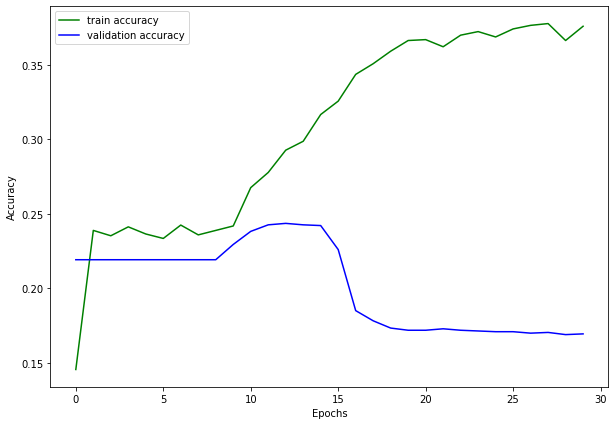

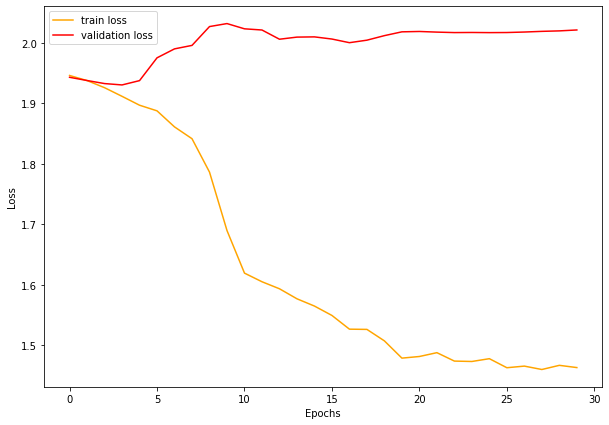

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]

Test Accuracy: 0.21923828125


In [ ]:
net = alexnet() #num_classes = NUM_CLASSES)#,num_domains = 2) # Loading AlexNet model
net.classifier[6] = nn.Linear(4096,NUM_CLASSES)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code
for p in net.parameters():
    p.requires_grad = True

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')



tl,ta,vl,va,net = train(net,train_dataloader=src_dataloader,val_dataloader=target_dataloader,checkpoint_path="./alexnet_noDANN")
print_acc_loss(tl,ta,vl,va,"alexnet_noDANN")
test(net,target_dataloader)